<h1><center> 
DeepLearning-Based RNA Toehold Switch Functionality Predictor Using One-Hot LSTM
</center></h1>

<center>
Nicolaas M Angenent-Mari<sup>1,2*</sup> Alexander S. Garruss<sup>2,3*</sup>,, Luis R. Soenksen<sup>1,2*</sup>, Diogo M. Camacho<sup>2*</sup>, Katherine M Collins<sup>1*</sup>, George Church<sup>1,2,3,4</sup>, Timothy K. Lu<sup>1,4</sup>, and James J. Collins<sup>1,2,3,4</sup>
</center>


<center><font color=gray><font size="1.5">
<sup>1</sup>Massachusetts Institute of Technology, <sup>2</sup>Wyss Institute for Biologically Inspired Engineering, <sup>3</sup>Harvard John A. Paulson School of Engineering and Applied Sciences, and <sup>4</sup>Broad Institute of MIT and Harvard. *Contributed equally
</font></font></center>


##### Abstract:
<font color=black><font size="2">
A benchmark tool in the field of synthetic biology is the RNA “Toehold-Switch”, a riboregulator that responds to a programmable target to change its secondary structure through strand displacement with up-regulation of a desired protein. Recent advances have streamlined the synthesis of these modules; however, in vitro and in vivo functionality remain highly unpredictable due to complex interactions unanticipated by standard base-pairing models. We are developing and testing aa high-quality library of 244,000 toehold sequences to train and optimize a Long Short Term Memory (LSTM) deep-learning architecture based on RNA tensors to enable accurate biological predictions of novel toehold sensor functionality.
</font></font>

---------------------------------------------------------------------------------------------

References:

> Randal S. Olson, Ryan J. Urbanowicz, Peter C. Andrews, Nicole A. Lavender, La Creis Kidd, and Jason H. Moore (2016). Automating biomedical data science through tree-based pipeline optimization. Applications of Evolutionary Computation, pages 123-137.

>Randal S. Olson, Nathan Bartley, Ryan J. Urbanowicz, and Jason H. Moore (2016). Evaluation of a Tree-based Pipeline Optimization Tool for Automating Data Science. Proceedings of GECCO 2016, pages 485-492.

---------------------------------------------------------------------------------------------

#### DATA STRUCTURE (INPUT / OUTPU)
> Data is loaded from a Toehold Sensor Database (data/2019-03-30_toehold_dataset_proc_with_params.csv) which is comma delimited table  having the following columns of DNA encoded sub-sequences: organism, sequence_class, sequence_id, pre_seq	promoter, trigger, loop1, switch, loop2, stem1, atg, stem2m linkerm post_linker, output	
> #### Input tensor is defined as (DS=Data_Style):
> **DS_1)**  Toehold DNA Sequence <br>
> *NOTE:  Base toehold string sequence [0-144]
> *       GGG  - Trigger - Loop1 - Switch  - Loop2 - Stem1 -  AUG  -  Stem2  -  Linker - Post-linker
> *     [-3,-1]  [0,-29]  [30-49]  [50-79]  [80-90] [91,96] [97,99] [100,108] [109,134]  [135,144]
> *     
> *     For training we select our input sequence vector start with GGG and concatenate everything from "Loop1" to "post-linker"... which is seq_SwitchOFF_GFP  = ggg + seq[30:145].
> *     Also, pre_seq & promoter sub-sequences are NEVER used because they are not converted into mRNA (is in the plasmid but > *     it is never in the functional toehold module), so it won't contribute in secondary structure at all. For this example > *     in particular we use DS_1.*

> #### Output vector is defined as:
> **OUT_1)** ON, Off & ON-OFF State values derived from the experimental testing of toehold switch RNA sequence

#### PROBLEM DEFINITION
> To investigate if a deep learning network can be used to predict toehold switch ON/OFF functionality, because in that case it would suggest the network is learning secondary structure prediction that would be transferable to other RNA based problems.

--------------------------------------------------------------------------------------------------------------------------------------------------------

### STEP 0)   Loading, Import Modules & Core helper functions
#### This code requires the following pre-installs:
> ##### Biopython
> In anaconda env: `conda install -c anaconda biopython` or `pip install biopython`<br>
> Ref: https://github.com/biopython/biopython
> ##### ViennaRNA
> In anaconda env: `conda install -c bioconda viennarna`<br>
> Ref: https://github.com/ViennaRNA/ViennaRNA
> ##### Pysster (Python 3.5+)
> In anaconda env: `pip3 install pysster`<br>
> Ref: https://github.com/budach/pysste

In [1]:
## Import Libraries
# General system libraries
import os
import gc
import cv2
import math
import h5py
import locale
import inspect
import argparse
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
from subprocess import call

# Math & Visualization Libs
import math
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import cycle
from scipy import stats, interp
from IPython.display import Image

# Multiprocessing
import multiprocessing

# DNA/RNA Analysis Libraries (Biopython, ViennaRNA, pysster) 
# > Biopython Lib
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import generic_rna, generic_dna, generic_protein, IUPAC
# > ViennaRNA Lib
import RNA

#RNAssp
import src.RNAssp.rna as rnassp

# Import Tensorflow
import tensorflow as tf

# Import Json
import json
import codecs

# Import Keras
from keras import optimizers
from keras import applications
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, load_model
from keras.models import model_from_json, load_model
from keras.layers import Activation, Conv1D, Conv2D, Reshape, BatchNormalization, Dropout, Flatten, Dense, merge, Input, Lambda, InputLayer, Convolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D, Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import multi_gpu_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint

#Import Keras-Vis for Saliency
from vis.utils import utils
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation, visualize_saliency, visualize_cam, overlay
    ## NOTE: Install in conda enviroment: pip install git+https://github.com/raghakot/keras-vis.git -U

# Import sklearn libs
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import roc_curve, auc
    ## NOTE: Activate a new terminal to monitor NVIDIA GPU usage writing
        # watch -n0.5 nvidia-smi
    ## NOTE: If not present, activate GPU persistence mode in terminal with
        # sudo nvidia-smi -pm 1
    ## If you do not see any GPU usage try uncommenting the following line:
        # sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To ensure activation of GPUs in TF Backend

# Progress Bar
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")

#Visualization mode
#%matplotlib ipympl

Using TensorFlow backend.


In [2]:
## Define helper function to copy full directory for backups
def copy_full_dir(source, target):
    call(['cp', '-a', source, target]) # Unix
    
#Get number of available GPUs
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
ngpus = len(get_available_gpus())
print('Available GPUs: '+ str(ngpus))

Available GPUs: 2


-----------------------------------------------------------------------------------------------------------------------------

### 1) Import Dataset & Define Raw Input(s)/Output(s)
> Full data CSV read, includes all necessary information to train and test

In [3]:
# Create Data folder if not existent
data_folder = "data/"
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)
    
## Define general path to store all generated models
core_models_path = 'models/'
# Create Data folder if not existent
if not os.path.isdir(core_models_path):
    os.makedirs(core_models_path)

# Define path to load desired Toehold dataset file (.csv)
data_filename = "2019-07-08_toehold_dataset_proc_with_params_QC1_1.csv"
data_path = data_folder + data_filename
data = pd.read_csv(data_path)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed) # Seed can be any number

In [4]:
### Datata Sequence ID selection
id_data = data['sequence_id']

### Toehold Switch dataset input/output columns for selection
input_cols = 'seq_SwitchON_GFP'
output_cols = ['ON', 'OFF', 'ON_OFF']
qc_levels = [1.1]
doTrain = True
loss_init = 'mae' #'logcosh', #'mse', 'mae', 'r2'
n_foldCV = 10
verbose_init = True
evaluate  = True
display_init = True

### Define data scaler (if any)
scaler_init = True
scaler = QuantileTransformer(output_distribution='uniform')

### DEFINE MODEL NAME (e.g. MLP, CNN, LSTM, etc.)
model_name = 'LSTM_1D'

#Show sample of dataframe structure
data.head()

off_id  \
0  AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...   
1  AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...   
2  AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...   
3  AACCAAACACACAAACGCACAAAAAAAATAACGTAGGACTACTACT...   
4  AACCAAACACACAAACGCACAAAAAAAATGGAAAACAGTTACTAAT...   

                                               on_id source_sequence  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
2  CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...        smallpox   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTTAACCAAACACACAAAC...        smallpox   
4  ACATATTAGTAACTGTTTTCCATTTTTTTTAACCAAACACACAAAC...        smallpox   

          sequence_id               pre_seq              promoter  \
0  smallpox_tile_2626  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
1  smallpox_tile_2625  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
2  smallpox_tile_4951  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
3  smallpox_tile_6492  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
4  smallpox_tile_2624  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   

                          trigger                 loop1  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
2  CTAAATTAACAATAGTAGTAATTTTTTTTT  AACCAAACACACAAACGCAC   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTT  AACCAAACACACAAACGCAC   
4  ACATATTAGTAACTGTTTTCCATTTTTTTT  AACCAAACACACAAACGCAC   

                           switch        loop2    ...     Cbn1_off  Cbn2_off  \
0  AAAAAAAAAAAAAAAAAATGGAAAACAGTT  AACAGAGGAGA    ...     0.000000  1.000000   
1  AAAAAAAAAAAAATGGAAAACAGTTACTAA  AACAGAGGAGA    ...          NaN       NaN   
2  AAAAAAAAATTACTACTATTGTTAATTTAG  AACAGAGGAGA    ...     1.000000  0.000000   
3  AAAAAAAATAACGTAGGACTACTACTTGGA  AACAGAGGAGA    ...     0.883458  0.116542   
4  AAAAAAAATGGAAAACAGTTACTAATATGT  AACAGAGGAGA    ...     0.815066  0.000000   

   Cbn3_off Cbn4_off        ON       OFF    ON_OFF QC_ON QC_OFF QC_ON_OFF  
0  0.000000      0.0       NaN  0.333333       NaN   NaN    NaN       NaN  
1       NaN      NaN       NaN       NaN       NaN   NaN    NaN       NaN  
2  0.000000      0.0  0.068295  0.000000  0.068295   2.0    1.1       1.1  
3  0.000000      0.0  0.000000  0.038847 -0.038847   1.1    2.0       1.1  
4  0.184934      0.0  0.080666  0.123289 -0.042624   2.0    3.0       2.0  

[5 rows x 99 columns]

-----------------------------------------------------------------------------------------------------------------------------

### 2) Definition of Pre-Processing Input(s)/Output(s) functions

> Define helper functions for one-hot encoding and Generation of Connectivity Map Tensors

> Definition of full input and output vectors for the network

In [5]:
# Helper function to pass string DNA/RNA sequence to one-hot
def dna2onehot(seq):
    #get sequence into an array
    seq_array = np.array(list(seq))
    
    #integer encode the sequence
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    
    #one hot the sequence
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    #reshape because that's what OneHotEncoder likes
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
    
    return onehot_encoded_seq

In [6]:
# INPUT / OUTPUT DEFINITION, PROCESSING & LOADING
def pre_process_data (data, input_cols, output_cols, export_path, qc_level_threshold=1, scaler_init=False, display=True):
    ## OUTPUT / INPUT DEFINITION, PROCESSING & LOADING
    
    #Init process bar
    tqdm.pandas() # Use `progress_apply` when `applying` one hot encoding and complementarity function to dataframe of input sequences

    # Define path to store input / output arrays
    tmp_data_path = 'data/tmp/'
    # Create Data folder if not existent
    if not os.path.isdir(tmp_data_path):
        os.makedirs(tmp_data_path)
        
    # GENERATE & SAVE FULL INPUT VECTORS (only if not exists because it is a large file)
    tmp_data_input_path = (tmp_data_path + 'data_input_file_1d_' + input_cols + '.h5')
    if not os.path.exists(tmp_data_input_path):
        # Data Input selection & Generation if absent (or delete it to re-calculate)
        n_batch_samples = 10000 #We constrain process batches to this number to allow for progressive saving of large files
        n_batches = math.ceil(len(data[input_cols])/n_batch_samples)
        
        if n_batches>1:
            print('Processing in batches...')
            
        # Process and Append Save:
        with h5py.File(tmp_data_input_path, 'a') as hf:
            is_first=True
            for data_tmp in np.split(data[input_cols], n_batches):
                df_data_input_tmp = data_tmp.progress_apply(dna2onehot)
                data_input_tmp = np.array(list(df_data_input_tmp.values))
                if is_first==True:
                    dset = hf.create_dataset("input",  data=data_input_tmp, maxshape=(None, data_input_tmp.shape[1], data_input_tmp.shape[2]), chunks=(n_batches,data_input_tmp.shape[1], data_input_tmp.shape[2])) 
                    is_first=False
                else:
                    dset.resize((dset.shape[0]+data_input_tmp.shape[0],data_input_tmp.shape[1],data_input_tmp.shape[2]))  
                    dset[-data_input_tmp.shape[0]:,:,:] = data_input_tmp
    
    # GENERATE & SAVE FULL OUTPUT VECTORS
    output_ids = "_".join(str(x) for x in output_cols)
    tmp_data_output_path = (tmp_data_path + 'data_output_file_QC_' + str(qc_level_threshold).replace('.','-') + '_' + output_ids + '.h5')
    
    # Data Output selection (QC filtered, OutColumns Only & Drop NaNs)
    df_data_output = data[data.QC_ON_OFF >= qc_level_threshold]
    df_data_output= df_data_output[output_cols]
    df_data_output = df_data_output.dropna(subset=output_cols)
    data_output = df_data_output.as_matrix().astype('float32')
    #Save:
    with h5py.File(tmp_data_output_path, 'w') as hf:
        hf.create_dataset("output",  data=data_output)

    # LOAD FULL INPUT ARRAY in memory and QC filter
    with h5py.File(tmp_data_input_path, 'r') as hf:
        data_input = hf['input'][:]
        data_input = data_input[df_data_output.index.values][:][:]
    
    # LOAD FULL OUTPUT ARRAY in memory and QC filter
    with h5py.File(tmp_data_output_path, 'r') as hf:
        data_output = hf['output'][:]
        data_output_orig = data_output
        #Pre-process data (scaler)
        if scaler_init==True:
            data_output = scaler.fit_transform(data_output)
    
    # LOAD FULL LIST OF SEQUENCES after filtering
    data_seqs = data[input_cols][df_data_output.index.values]
    
    # Display processed data if desired
    if display==True:
        ### Show example of processed dataset
        ## Display number of retrieved sequences
        print("Number of sequences retrieved: "+str(len(data_input)))
        print()

        #Select ID to show
        toehold_id = 0 

        ## Plot Example input toehold matrix 
        print('EXAMPLE OF INPUT ONE-HOT TOEHOLD')
        onehot_encoded_seq = dna2onehot(data_seqs.iloc[toehold_id])
        print(onehot_encoded_seq.transpose())
        print()
        
        # Display input size
        print("Input Size: " + str(onehot_encoded_seq.shape))
        print()

        # Display example of Output vector
        print('EXAMPLE OF OUTPUT VECTOR')
        print(' ' + str(data_output[toehold_id]))
        print()

        # Display Output Values
        for index,item in enumerate(output_cols):
            # Display Output Values
            plt.figure()
            print('Distribution of ' + str(item) + ' Values')
            sns.distplot(data_output[:,index], kde=True, rug=False)
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_dist.png", bbox_inches='tight', dpi=300)
        
        if scaler_init==True:           
            ## COMPUTE EFFECT OF SCALER
            # Difference between the transformed toehold output values and original toehold output values, 
            # then compute the absolute percentage difference for diplay
            test_metrics = np.zeros((data_output_orig.shape[1],3))
            diff = data_output_orig - data_output
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            
            # Plot: Scaled Output values vs. Original values and get R2 value
            for index,item in enumerate(output_cols):
                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(data_output_orig[:,index], data_output[:,index])
                
                # Display Output Values
                x=np.squeeze(data_output_orig[:,index])
                y=np.squeeze(data_output[:,index])
                
                # Display Output Values
                print('')
                print("" + item + " Mean_absolute_error (TRANSFORMATION): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('TRANSFORMED Values vs. ORIGINAL values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$ORIGINAL$", "$TRANSFORMED$");

                # save the figure
                g.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_data_scaling_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(export_path + '/scaling_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(export_path + '/scaling_data',data_output_orig,data_output) 

    return data_input, data_output

-----------------------------------------------------------------------------------------------------------------------------

### 3) Definition of Model Architecture Function
> Funtion to create keras model architecture
> Helper functions to save and evaluate models

In [7]:
### Function to create Keras LSTM for regression prediction
def create_lstm(width, height, regress=False):

    # Define our LSTM network
    rnn_hidden_dim = 128
    dropout_init = 0.3
    chanDim = -1
    
    #Input
    inputShape = (width, height) #DNA/RNA input sequence (one hot encoded)
    inputs = Input(shape=inputShape)
    
    # Define dense layers
    x = inputs
    #x = Bidirectional(LSTM(rnn_hidden_dim))(x)
    x = LSTM(rnn_hidden_dim)(x)
    #x = Dropout(dropout_init)(x)
    
    x = Dense(100, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x) 
        
    # Check to see if the regression node should be added
    if regress:
        x = Dense(len(output_cols), activation="linear")(x)
    else:
        x = Dense(len(output_cols), activation="sigmoid")(x)
        
    # Construct the Model
    model = Model(inputs, x) 
    
    return model

In [8]:
# Helper functions to save/load model and training history
def saveHist(path,history):
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 
        
def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

def save_model(model, identifier):
    ## MODEL SAVING ON WORKING FOLDER
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights_'+str(identifier)+'.h5')
    with open(os.path.abspath(model_path)+'/model_architecture_'+str(identifier)+'.json', 'w') as f:
        f.write(model.to_json())

    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model_'+str(identifier)+'.h5')

In [9]:
#Definition of R2 metric for testing
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

#Definition of Custom metric as loss related to Coefficient of Determination (R2) 
#  CoD = 1 - MSE / (variance of inputs), and since this is going to be a loss we want 
#  improvement to point towards zero, so we choose mse/variance of inputs
def custom_r2_loss(y_true, y_pred): 
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return (SS_res/(SS_tot + K.epsilon()))

#Definition of Custom metric as loss related to Weigted Mean Absolute error
#  Improvement points towards zero, but penalizes loss for small values and improves it for larger values
def custom_wmae_loss(y_true, y_pred): 
    from keras import backend as K
    weightedMAE = K.abs((y_true-y_pred)*y_true) #Increase loss for large ON or OFF values -- Skews focus of distribution right
    return weightedMAE

### 4) Definition of BASE Model Generator (with Training using Manual Verification Dataset & Evaluation)
> For use with a priori training (suggested: 75%) & testing (suggested: 25%) split, with internal training validation from the training set (10% or the 75%)
> For evaluation on unseen testing data (suggested: 25%) 
> This generator function generates and saves model in target path

In [10]:
### Define our final model architecture (layers & optimizor) and then compile it
def generate_model(model_path, trainX, testX, trainY, testY, verbose_init, evaluate=True):
    
    ## DEEP-LEARNING TRAINING PARAMETERS(e.g. verbose, patients, epoch size, batch size) to constrain process
    verbose_init = verbose_init #Zero is no keras verbose
    patience_init = 20 # Number of epochs to wait for no model improvement before early stopping a training
    epochs_init = 300 # Max number of epochs to perform (to cap training time)
    batch_size_init = 64*(1+ngpus) # number of samples that will be propagated through the network at every epoch dependent on the number of GPUs
    validation_spit_init = 0.1 # Percentage of testing data to use in internal validation during training
    
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_path):
        os.makedirs(model_path)
        
    ## Callbacks for training:
    #  Save the model weights to the same file, if and only if the validation accuracy improves.
    checkpoint_file_name = "model_checkpoint_weights.h5"
    model_checkpoint_path = os.path.join(os.path.abspath(model_path), checkpoint_file_name)
    
    if verbose_init==True:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = verbose_init, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = verbose_init),
                          TQDMNotebookCallback()] # Adds Keras integration with TQDM progress bars.
    else:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = False, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = False)]    
    
    ## Create Model (Change for MLP, CNN, ETC)
    # -------------------------------------------------------------------------------------------------------------------------------------
    # Define CNN model input shape
    (width, height) = np.shape(trainX[0])
    
    # Define core model on CPU
    with tf.device("/cpu:0"):  
        model = create_lstm(width, height, regress=True)
        
    ## Initialize the optimizer and Compile model:
    #   Custom metric is used (see above), if we use "Mean absolute percentage error" that
    #   implies that we seek to minimize the absolute percentage difference between 
    #   our *predictions* and *actual* output values. We also calculate other 
    #   valuable metrics for regression evaluation 
    opt = Adam(lr=0.001, epsilon=None, decay=1e-3/200, amsgrad=False) # epsilon=1e-1 for POISSON loss
    
    if loss_init=="r2":
        model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
    elif loss_init =="wmae":
        model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
    else:
        model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
    # -------------------------------------------------------------------------------------------------------------------------------------  
        
    ## Parallel computing (if multiple GPUs are available)
    # Define model for training (CPU, Single GPU or Multi-GPU depending on availability of resources)
    if ngpus<=1:
        print("[INFO] training with Single GPU or CPU...")
        model_history = model.fit(trainX, trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)

    else:
        print("[INFO] training with {} GPUs...".format(ngpus))
        # make the model parallel
        parallel_model = multi_gpu_model(model, gpus=ngpus)
        
        if loss_init=="r2":
            parallel_model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
        elif loss_init =="wmae":
            parallel_model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
        else:
            parallel_model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
        model_history = parallel_model.fit(trainX, trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)    
                    

    ## MODEL SAVING
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights.h5')
    with open(os.path.abspath(model_path)+'/model_architecture.json', 'w') as f:
        f.write(model.to_json())
    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model.h5')
    # Save model graph to file
    model_graph_path = model_path + '/model_graph.png'
    plot_model(model, to_file=model_graph_path, show_shapes=True, show_layer_names=True)
    # Save training history
    saveHist(model_path + '/model_history', model_history)
        
    ## MODEL LOADING (to ensure it works)
    # Option 1: Load latest model via Weights + Architecture
    #with open(os.path.abspath(model_path)+'/model_architecture.json', 'r') as f:
    #    model = model_from_json(f.read())
    #    model.load_weights(os.path.abspath(model_path)+'/model_weights.h5')
    # Option 2: Load latest model via entire model at once
    if loss_init=="r2":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_r2_loss': custom_r2_loss})
    elif loss_init =="wmae":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_wmae_loss': custom_wmae_loss})
    else:
        model = load_model(os.path.abspath(model_path)+'/model.h5')
    
    # Load model training history
    model_history = loadHist(model_path + '/model_history')
    
    # Init prediction output matrix
    testX_Preds = np.zeros_like(testY) #Empty matrix for full prediction evaluation
    # Init performance metrics matrix
    test_metrics = np.zeros((trainY.shape[1],3)) #Empty matrix for model performance metrics
    
    # GENERATE PREDICTIONS
    if testX.size > 0:
        ## Make predictions on testing data:
        print("Predicting functionality of Test Toeholds ...")
        print("")
        #Predictions in scaled space
        testX_Preds = model.predict(testX)
        
        if scaler_init == True:
            testY = scaler.inverse_transform(testY)
            testX_Preds = scaler.inverse_transform(testX_Preds)
        
        ## EVALUATE PERFORMANCE OF MODEL
        if evaluate==True:
            ## Plot training metrics per fold:
            plt.figure ()
            ax1 = plt.subplot(221)
            ax2 = plt.subplot(222)
            ax3 = plt.subplot(223)
            ax4 = plt.subplot(224)
            # Plot MSE metric
            ax1.set_title("Mean squared error")
            ax1.plot(model_history['mean_squared_error'])
            # Plot MAE metric
            ax2.set_title("Mean absolute error")
            ax2.plot(model_history['mean_absolute_error'])
            # Plot MAPE metric
            ax3.set_title("Mean absolute percentage error")
            ax3.plot(model_history['mean_absolute_percentage_error'])
            # Plot CP metric
            ax4.set_title("Cosine Proximity")
            ax4.plot(model_history['cosine_proximity'])
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(model_path + "/model_training_metrics.png", bbox_inches='tight', dpi=300)

            ## Plot compiled training metrics per fold:
            plt.figure()
            plt.style.use("default")
            N = np.arange(0, len(model_history["loss"]))
            # Plot used Loss metric
            plt.plot(N, model_history["loss"], label="train_loss")
            plt.plot(N, model_history["val_loss"], label="test_loss")
            # Plot used Accuracy metric (applicable only if categorical model)
            plt.plot(N, model_history["acc"], label="train_acc")
            plt.plot(N, model_history["val_acc"], label="test_acc")
            # Plot MSE metric
            plt.plot(N, model_history["mean_squared_error"], label="train_mse")
            plt.plot(N, model_history["val_mean_squared_error"], label="test_mse")
            # Plot MAE metric
            plt.plot(N, model_history["mean_absolute_error"], label="train_mae")
            plt.plot(N, model_history["val_mean_absolute_error"], label="test_mae")
            # Plot MAPE metric
            plt.plot(N, model_history["mean_absolute_percentage_error"], label="train_mape")
            plt.plot(N, model_history["val_mean_absolute_percentage_error"], label="test_mape")
            # Plot CP metric
            plt.plot(N, model_history["cosine_proximity"], label="train_cp")
            plt.plot(N, model_history["val_cosine_proximity"], label="test_cp")
            plt.title("CNN Toehold Complementary Rep Data")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Place a legend to the right of this smaller subplot.
            # Save figure
            plt.savefig(model_path + "/model_training_compilation.png", bbox_inches='tight', dpi=300)
            
            
            ## COMPUTE PERFORMANCE METRICS
            # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
            # then compute the absolute percentage difference for diplay
            diff = testX_Preds - testY
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            # Plot: Predicted values vs. Experimental values and get R2 value
            for index,item in enumerate(output_cols):

                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(testX_Preds[:,index], testY[:,index])
                
                # Display Output Values
                x=np.squeeze(testX_Preds[:,index])
                y=np.squeeze(testY[:,index])
                
                # Display Output Values
                print("" + item + " Mean_absolute_error (TEST): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");

                # save the figure
                g.savefig(model_path + "/model_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(model_path + '/test_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(model_path + '/test_data',testX_Preds, testY) 
                
    return model, model_history, testX_Preds, test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 5)  Definition of k-Fold Cross Validated Model Generator (with Ensemble Training, Evaluation & Full Deployment)

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of the performance of a model on unseen data. 

> It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 

> The performance measure accross all models in the unseen data for each fold

> The performance is printed for each model and it is stored

> A final deployment model trained in all data (no testing) is provided for evaluation in future data

In [11]:
### Define our crossvalidation model generator (layers, optimizor, compilation, training, reporting, etc)
def generate_crossval_model(model_cv_path, X, Y, n_foldCV, verbose_init=True, evaluate=True):
    
    ## CROSSVALIDATION TRAINING
    # Define CV parameters
    n_foldCV = n_foldCV #Number of Crossvalidation bins
    cv_folds = list(StratifiedKFold(n_splits=n_foldCV, shuffle=True, random_state=seed).split(X,Y.argmax(1))) # Non repeating CV bins
    cv_preds = np.zeros_like(Y) #Empty matrix for full prediction evaluation
    cv_test_metrics = np.zeros((n_foldCV, Y.shape[1], 3))
    deploy_test_metrics = np.zeros((Y.shape[1],3))
    
    # Perform n-fold crossvalidated training and evaluation
    for j, (train_idx, test_idx) in enumerate(cv_folds):
        print('\nFold ',j)
        
        # Define folder for CV fold model
        model_cv_fold_path = model_cv_path + '/Fold' + str(j) 

        ## CrossValidation Strategy: 
        # We use all data for n-crossvalidation this will give us average metrics of performance in future data
        # for this all data will be devided into n bins. In every sequential fold we will use n-1 bins for training 
        # and the remaining bin for testing this split is done in such a way that all data is used for training and
        # testing at some point (sweet!). Testing points will be aggregated tenerate an average metric of performance
        # and all the datapoints will be put into a master agreement plot for visualization. 
        # A working model will be made using 75% of the data for training and 25% for further testing.
        # A deploy model will be also trained using all available data without testing
        trainX_cv = X[train_idx]
        trainY_cv = Y[train_idx]
        testX_cv = X[test_idx]
        testY_cv = Y[test_idx]
        # NOTE: Validation set is taken internally from the training set (10% of each fold), this is applied in the the model.fit function
        
        # Create & Train model each fold according to generator function
        model, model_history, testX_Preds, test_metrics = generate_model(model_cv_fold_path, trainX_cv, testX_cv, trainY_cv, testY_cv, verbose_init=verbose_init, evaluate=evaluate)
        
        # Record predicted values of each CV fold training to generate an ensemble reporting
        print("Predicting functionality of CV-Fold Test Toeholds & Model performance metrics ...")
        cv_preds[test_idx,:] = testX_Preds
        cv_test_metrics[j,:,:] = test_metrics
        
        ## MODEL MEMORY RELEASE
        del model_history
        del model
        for i in range(ngpus+1): gc.collect()
        
        ## Free-up keras memmory to prevent leaks
        K.clear_session()
    
    #Transform back data
    if scaler_init == True:
        Y = scaler.inverse_transform(Y)
    
    # SAVE METRICS (.npy file)
    np.save(model_cv_path + '/cv_test_metrics',cv_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_cv_path + '/cv_test_data',cv_preds, Y)
            
    
    ## DEFINE FOLDER FOR DEPLOY MODEL
    model_deploy_path = model_cv_path + '/deploy'
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_deploy_path):
        os.makedirs(model_deploy_path)
    print('')
    print('Generating deployment model...')
    
    # COMPUTE PERFORMANCE METRICS FOR DEPLOY MODEL
    # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
    # then compute the absolute percentage difference for diplay

    diff = cv_preds - Y
    abstDiff = np.abs(diff)
    # Compute the mean and standard deviation of the absolute difference:
    apd_mean = np.mean(abstDiff, axis=0)
    apd_std = np.std(abstDiff, axis=0)
    apd_r2 = np.zeros_like(apd_mean)

    ## EVALUATE ENSEMBLE CROSSVALIDATION PERFORMANCE OF MODEL
    if evaluate==True:
        for index,item in enumerate(output_cols): 
            # R2 (Coefficient of Determination)
            apd_r2[index] = r2(cv_preds[:,index], Y[:,index])
            # Display Output Values
            x_tot=np.squeeze(cv_preds[:,index])
            y_tot=np.squeeze(Y[:,index])
            print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
            print('Pearson Correlation: '+ str(stats.pearsonr(x_tot, y_tot)[0]))
            print('Spearman Correlation: '+ str(stats.spearmanr(x_tot, y_tot)[0]))
            print('R2: '+ str(apd_r2[index]))
            print('')
            
            if scaler_init == True:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", xlim=(-0.2, 1.2), ylim=(-0.2, 1.2), stat_func=r2)
            else:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", stat_func=r2)
            g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
            g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
            g.ax_joint.collections[0].set_alpha(0)
            g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");
            
            # save the figure
            g.savefig(model_deploy_path + "/model_ensemble_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
    
            # Store model performance metrics for return   
            deploy_test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
            
    # SAVE METRICS (.npy file)
    np.save(model_deploy_path + '/deploy_test_metrics', deploy_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_deploy_path + '/deploy_test_data',cv_preds, Y)
    
    ## DEPLOYMENT MODEL TRAINING (with full dataset)
    # Partition the data into training (90%), validation (10%), testing (0%) splits 
    (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.0, random_state=seed)
    
    # Create model function according to generator function
    model, model_history, _ , _ = generate_model(model_deploy_path, trainX, testX, trainY, testY, verbose_init=True, evaluate=True)
                                                                                                                                               
    ## Return                                     
    return model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 6) Loop through all model(s) generation depending on: Model folder, Chosen input(s)/output(s), QC levels & k-fold bins

> Define helper function for master loop

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of performance

In [12]:
#Definer function for full model analysis and reporting
def execute_model_analysis(core_models_path, model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate):
      
    #Iterate through all desired Data QC levels
    for j, qc_level in enumerate(qc_levels): 
        
        ### 1) Create all folders per iteration
        ## Define general path to store all generated models
        model_path = core_models_path + model_name.lower()+ '/' + model_name.upper() +'-' + str('-'.join(output_cols) + '-QC' + str(qc_level).replace('.','-') + '/')
        print ("Iteration " + str(j) + ") Building analysis in: " + model_path) 
        # Create Data folder if not existent
        if not os.path.isdir(model_path):
            os.makedirs(model_path)
        
        ## SAVE INIT PARAMETER SAVING ON WORKING FOLDER
        init_param_path = model_path + "init_parameters.txt"
        with open(init_param_path, "w+") as variable_file:
            variable_file.write("data_folder = " + str(data_folder)+ '\n' +\
                                "core_models_path = " + str(core_models_path)+ '\n' +\
                                "data_filename = " + str(data_filename)+ '\n' +\
                                "seed = " + str(seed)+ '\n' +\
                                "model_name = " + str(model_name)+ '\n' +\
                                "input_cols = " + str(input_cols)+ '\n' +\
                                "output_cols = " + str(output_cols)+ '\n' +\
                                "qc_level = " + str(qc_level)+ '\n' +\
                                "n_foldCV = " + str(n_foldCV)+ '\n' +\
                                "scaler = " + str(scaler)+ '\n' +\
                                "loss_init = " + str(loss_init)+ '\n' +\
                                "verbose_init = " + str(verbose_init)+ '\n' +\
                                "evaluate  =  " + str(evaluate)+ '\n' +\
                                "display_init =  " + str(display_init)+ '\n')
        
        ## Define path to store base model
        model_base_path = model_path + 'base'
        # Create Data folder if not existent
        if not os.path.isdir(model_base_path):
            os.makedirs(model_base_path)

        ## Define path to store crossvalidation models
        model_cv_path = model_path + 'crossval'
        # Create Data folder if not existent
        if not os.path.isdir(model_cv_path):
            os.makedirs(model_cv_path)

        ## Define path to store all generated model inputs
        model_input_path = model_path + 'input'
        # Create Data folder if not existent
        if not os.path.isdir(model_input_path):
            os.makedirs(model_input_path)
            
        ## Define path to store all generated model outputs
        model_output_path = model_path + 'output'
        # Create Data folder if not existent
        if not os.path.isdir(model_output_path):
            os.makedirs(model_output_path)
    
            
        ## LOAD PREPROCESSED INPUT / OUTPUT
        data_input, data_output = pre_process_data (data, input_cols, output_cols, model_input_path, qc_level_threshold=qc_level, scaler_init=scaler_init, display=display_init)
            
        ### 3) Model Training using Manual Verification Dataset & Evaluation
        # Training with a priori training (75%) & testing (25%) split, with internal training validation from the training set (10% or the 75%)
        # This also does valuation on unseen testing data (25%), and saves base model

        # Create manual model function according to generator function, train it and display architecture
        if doTrain==True:
            # Partition the data into training (75%) and testing (25%) splits
            (trainX, testX, trainY, testY) = train_test_split(data_input, data_output, test_size=0.25, random_state=seed)
            # Generate, Train, Evaluate, Save and Display Model
            model, model_history, testX_Preds, test_metrics = generate_model(model_base_path, trainX, testX, trainY, testY, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
        
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(ngpus+1): gc.collect()
        
            ## Free-up keras memmory to prevent leaks
            K.clear_session()

        ### 4) Model Training using k-Fold Cross Validation, Ensemble Evaluation & Full Deployment
        # The gold standard for machine learning model evaluation is k-fold cross validation
        # It provides a robust estimate of the performance of a model on unseen data. 
        # It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 
        # The performance measure accross all models in the unseen data for each fold
        # The performance is printed for each model and it is stored
        # A final deployment model trained in all data (no testing) is provided for evaluation in future data

        # Create crossvalidated model function according to generator function, train it and display architecture
        # Generate, Train, Evaluate, Save and Display Model
        if n_foldCV>0:
            model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics = generate_crossval_model(model_cv_path, data_input, data_output, n_foldCV=n_foldCV, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
            
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(ngpus+1): gc.collect()
                
            ## Free-up keras memmory to prevent leaks
            K.clear_session()
    
    ## MODEL SAVING ON DATED BACKUP FOLDER
    # Save the entire current model folder to a backup folder
    source_model_path = core_models_path + model_name + '/'
    backup_model_path = 'backup/' + source_model_path +  datetime.now().strftime('%Y%m%d') + '_' + datetime.now().strftime('%H%M')
    ## Create folder to store model (if not existent)
    if not os.path.isdir(backup_model_path):
        os.makedirs(backup_model_path)
    # Copy all contents to dated backup
    copy_full_dir(source_model_path, backup_model_path)

Iteration 0) Building analysis in: models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/
Number of sequences retrieved: 91534

EXAMPLE OF INPUT ONE-HOT TOEHOLD
[[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
  0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
  1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
  1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
  0. 0. 1. 0. 0. 1. 0

Epoch 1/300


61785/61785 [==============================] - 107s 2ms/step - loss: 0.2412 - mean_squared_error: 0.0910 - mean_absolute_error: 0.2412 - mean_absolute_percentage_error: 13940547.7637 - cosine_proximity: -0.9110 - acc: 0.3975 - val_loss: 0.8496 - val_mean_squared_error: 0.8368 - val_mean_absolute_error: 0.8496 - val_mean_absolute_percentage_error: 36387576.9987 - val_cosine_proximity: -0.9086 - val_acc: 0.4727

Epoch 00001: val_loss improved from inf to 0.84956, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 2/300


61785/61785 [==============================] - 105s 2ms/step - loss: 0.2192 - mean_squared_error: 0.0729 - mean_absolute_error: 0.2192 - mean_absolute_percentage_error: 14838200.1795 - cosine_proximity: -0.9156 - acc: 0.4159 - val_loss: 0.3695 - val_mean_squared_error: 0.1978 - val_mean_absolute_error: 0.3695 - val_mean_absolute_percentage_error: 28932583.1854 - val_cosine_proximity: -0.9194 - val_acc: 0.4079

Epoch 00002: val_loss improved from 0.84956 to 0.36949, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 3/300


61785/61785 [==============================] - 104s 2ms/step - loss: 0.2142 - mean_squared_error: 0.0705 - mean_absolute_error: 0.2142 - mean_absolute_percentage_error: 14567336.5335 - cosine_proximity: -0.9172 - acc: 0.4363 - val_loss: 0.4041 - val_mean_squared_error: 0.2605 - val_mean_absolute_error: 0.4041 - val_mean_absolute_percentage_error: 15260687.5397 - val_cosine_proximity: -0.4293 - val_acc: 0.3949

Epoch 00003: val_loss did not improve from 0.36949
Epoch 4/300


61785/61785 [==============================] - 102s 2ms/step - loss: 0.2106 - mean_squared_error: 0.0689 - mean_absolute_error: 0.2106 - mean_absolute_percentage_error: 14437355.7398 - cosine_proximity: -0.9187 - acc: 0.4486 - val_loss: 0.2121 - val_mean_squared_error: 0.0683 - val_mean_absolute_error: 0.2121 - val_mean_absolute_percentage_error: 11657157.2740 - val_cosine_proximity: -0.9229 - val_acc: 0.4980

Epoch 00004: val_loss improved from 0.36949 to 0.21209, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 5/300


61785/61785 [==============================] - 106s 2ms/step - loss: 0.2072 - mean_squared_error: 0.0671 - mean_absolute_error: 0.2072 - mean_absolute_percentage_error: 14333632.6870 - cosine_proximity: -0.9194 - acc: 0.4575 - val_loss: 0.3688 - val_mean_squared_error: 0.1862 - val_mean_absolute_error: 0.3688 - val_mean_absolute_percentage_error: 7158352.9942 - val_cosine_proximity: -0.5895 - val_acc: 0.4051

Epoch 00005: val_loss did not improve from 0.21209
Epoch 6/300


61785/61785 [==============================] - 112s 2ms/step - loss: 0.2055 - mean_squared_error: 0.0664 - mean_absolute_error: 0.2055 - mean_absolute_percentage_error: 14353757.7039 - cosine_proximity: -0.9200 - acc: 0.4628 - val_loss: 0.2449 - val_mean_squared_error: 0.0921 - val_mean_absolute_error: 0.2449 - val_mean_absolute_percentage_error: 5633123.4443 - val_cosine_proximity: -0.8404 - val_acc: 0.4897

Epoch 00006: val_loss did not improve from 0.21209
Epoch 7/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.2039 - mean_squared_error: 0.0658 - mean_absolute_error: 0.2039 - mean_absolute_percentage_error: 14249494.7053 - cosine_proximity: -0.9204 - acc: 0.4674 - val_loss: 0.5501 - val_mean_squared_error: 0.4529 - val_mean_absolute_error: 0.5501 - val_mean_absolute_percentage_error: 45334218.1506 - val_cosine_proximity: -0.8005 - val_acc: 0.3949

Epoch 00007: val_loss did not improve from 0.21209
Epoch 8/300


61785/61785 [==============================] - 112s 2ms/step - loss: 0.2032 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2032 - mean_absolute_percentage_error: 14251241.0108 - cosine_proximity: -0.9209 - acc: 0.4746 - val_loss: 0.2249 - val_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.2249 - val_mean_absolute_percentage_error: 7900509.1465 - val_cosine_proximity: -0.8882 - val_acc: 0.4884

Epoch 00008: val_loss did not improve from 0.21209
Epoch 9/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.2016 - mean_squared_error: 0.0647 - mean_absolute_error: 0.2016 - mean_absolute_percentage_error: 14148938.0290 - cosine_proximity: -0.9214 - acc: 0.4777 - val_loss: 0.5748 - val_mean_squared_error: 0.4418 - val_mean_absolute_error: 0.5748 - val_mean_absolute_percentage_error: 17093876.6252 - val_cosine_proximity: -0.0016 - val_acc: 0.4746

Epoch 00009: val_loss did not improve from 0.21209
Epoch 10/300


61785/61785 [==============================] - 107s 2ms/step - loss: 0.2012 - mean_squared_error: 0.0644 - mean_absolute_error: 0.2012 - mean_absolute_percentage_error: 14060139.4377 - cosine_proximity: -0.9216 - acc: 0.4796 - val_loss: 0.2191 - val_mean_squared_error: 0.0795 - val_mean_absolute_error: 0.2191 - val_mean_absolute_percentage_error: 12101069.1665 - val_cosine_proximity: -0.9106 - val_acc: 0.5066

Epoch 00010: val_loss did not improve from 0.21209
Epoch 11/300


61785/61785 [==============================] - 104s 2ms/step - loss: 0.2003 - mean_squared_error: 0.0638 - mean_absolute_error: 0.2003 - mean_absolute_percentage_error: 14069946.1812 - cosine_proximity: -0.9217 - acc: 0.4829 - val_loss: 0.2000 - val_mean_squared_error: 0.0648 - val_mean_absolute_error: 0.2000 - val_mean_absolute_percentage_error: 11850972.6846 - val_cosine_proximity: -0.9231 - val_acc: 0.5088

Epoch 00011: val_loss improved from 0.21209 to 0.20000, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 12/300


61785/61785 [==============================] - 102s 2ms/step - loss: 0.1990 - mean_squared_error: 0.0633 - mean_absolute_error: 0.1990 - mean_absolute_percentage_error: 14049607.8697 - cosine_proximity: -0.9220 - acc: 0.4877 - val_loss: 0.5596 - val_mean_squared_error: 0.3803 - val_mean_absolute_error: 0.5596 - val_mean_absolute_percentage_error: 8497980.7116 - val_cosine_proximity: 0.0289 - val_acc: 0.5055

Epoch 00012: val_loss did not improve from 0.20000
Epoch 13/300


61785/61785 [==============================] - 104s 2ms/step - loss: 0.1977 - mean_squared_error: 0.0624 - mean_absolute_error: 0.1977 - mean_absolute_percentage_error: 13943907.5373 - cosine_proximity: -0.9222 - acc: 0.4891 - val_loss: 0.2026 - val_mean_squared_error: 0.0670 - val_mean_absolute_error: 0.2026 - val_mean_absolute_percentage_error: 8709027.2156 - val_cosine_proximity: -0.9081 - val_acc: 0.5092

Epoch 00013: val_loss did not improve from 0.20000
Epoch 14/300


61785/61785 [==============================] - 104s 2ms/step - loss: 0.1956 - mean_squared_error: 0.0610 - mean_absolute_error: 0.1956 - mean_absolute_percentage_error: 13655368.3904 - cosine_proximity: -0.9229 - acc: 0.5000 - val_loss: 0.1970 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1970 - val_mean_absolute_percentage_error: 12835632.7714 - val_cosine_proximity: -0.9246 - val_acc: 0.4908

Epoch 00014: val_loss improved from 0.20000 to 0.19701, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 15/300


61785/61785 [==============================] - 103s 2ms/step - loss: 0.1900 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1900 - mean_absolute_percentage_error: 13095533.3671 - cosine_proximity: -0.9226 - acc: 0.5053 - val_loss: 0.1929 - val_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.1929 - val_mean_absolute_percentage_error: 15212466.9095 - val_cosine_proximity: -0.8993 - val_acc: 0.4355

Epoch 00015: val_loss improved from 0.19701 to 0.19286, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 16/300


61785/61785 [==============================] - 104s 2ms/step - loss: 0.1744 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1744 - mean_absolute_percentage_error: 11836467.2942 - cosine_proximity: -0.9242 - acc: 0.5096 - val_loss: 0.1859 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1859 - val_mean_absolute_percentage_error: 10662873.2788 - val_cosine_proximity: -0.9101 - val_acc: 0.4919

Epoch 00016: val_loss improved from 0.19286 to 0.18589, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 17/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.1691 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 11486866.4286 - cosine_proximity: -0.9260 - acc: 0.5227 - val_loss: 0.7375 - val_mean_squared_error: 0.5901 - val_mean_absolute_error: 0.7375 - val_mean_absolute_percentage_error: 12266681.7856 - val_cosine_proximity: 0.5845 - val_acc: 0.5060

Epoch 00017: val_loss did not improve from 0.18589
Epoch 18/300


61785/61785 [==============================] - 108s 2ms/step - loss: 0.1673 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1673 - mean_absolute_percentage_error: 11444155.7949 - cosine_proximity: -0.9266 - acc: 0.5304 - val_loss: 0.1857 - val_mean_squared_error: 0.0577 - val_mean_absolute_error: 0.1857 - val_mean_absolute_percentage_error: 7953597.3247 - val_cosine_proximity: -0.8925 - val_acc: 0.5014

Epoch 00018: val_loss improved from 0.18589 to 0.18566, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 19/300


61785/61785 [==============================] - 108s 2ms/step - loss: 0.1666 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 11368481.5762 - cosine_proximity: -0.9269 - acc: 0.5360 - val_loss: 0.1794 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1794 - val_mean_absolute_percentage_error: 10721761.7527 - val_cosine_proximity: -0.9129 - val_acc: 0.5180

Epoch 00019: val_loss improved from 0.18566 to 0.17939, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 20/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.1653 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1653 - mean_absolute_percentage_error: 11325183.5006 - cosine_proximity: -0.9272 - acc: 0.5427 - val_loss: 0.2166 - val_mean_squared_error: 0.0744 - val_mean_absolute_error: 0.2166 - val_mean_absolute_percentage_error: 14056762.0239 - val_cosine_proximity: -0.9279 - val_acc: 0.5314

Epoch 00020: val_loss did not improve from 0.17939
Epoch 21/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1651 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1651 - mean_absolute_percentage_error: 11310828.4056 - cosine_proximity: -0.9272 - acc: 0.5458 - val_loss: 0.1996 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1996 - val_mean_absolute_percentage_error: 13660931.0159 - val_cosine_proximity: -0.8977 - val_acc: 0.4079

Epoch 00021: val_loss did not improve from 0.17939
Epoch 22/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.1646 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11287705.3813 - cosine_proximity: -0.9271 - acc: 0.5480 - val_loss: 0.1739 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1739 - val_mean_absolute_percentage_error: 7045032.6463 - val_cosine_proximity: -0.9144 - val_acc: 0.5391

Epoch 00022: val_loss improved from 0.17939 to 0.17386, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 23/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1638 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1638 - mean_absolute_percentage_error: 11251473.0092 - cosine_proximity: -0.9277 - acc: 0.5460 - val_loss: 0.1771 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1771 - val_mean_absolute_percentage_error: 6291495.2286 - val_cosine_proximity: -0.9241 - val_acc: 0.5369

Epoch 00023: val_loss did not improve from 0.17386
Epoch 24/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.1632 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11225816.9809 - cosine_proximity: -0.9280 - acc: 0.5502 - val_loss: 0.1784 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1784 - val_mean_absolute_percentage_error: 6991162.6412 - val_cosine_proximity: -0.9268 - val_acc: 0.5346

Epoch 00024: val_loss did not improve from 0.17386
Epoch 25/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1634 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1634 - mean_absolute_percentage_error: 11189578.9939 - cosine_proximity: -0.9277 - acc: 0.5531 - val_loss: 0.2131 - val_mean_squared_error: 0.0679 - val_mean_absolute_error: 0.2131 - val_mean_absolute_percentage_error: 14915352.1932 - val_cosine_proximity: -0.8342 - val_acc: 0.4047

Epoch 00025: val_loss did not improve from 0.17386
Epoch 26/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1621 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11240398.2511 - cosine_proximity: -0.9285 - acc: 0.5533 - val_loss: 0.2021 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.2021 - val_mean_absolute_percentage_error: 5281957.2084 - val_cosine_proximity: -0.9168 - val_acc: 0.4473

Epoch 00026: val_loss did not improve from 0.17386
Epoch 27/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.1623 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11215469.8137 - cosine_proximity: -0.9277 - acc: 0.5543 - val_loss: 0.1924 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1924 - val_mean_absolute_percentage_error: 12562459.0765 - val_cosine_proximity: -0.9302 - val_acc: 0.5266

Epoch 00027: val_loss did not improve from 0.17386
Epoch 28/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1614 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11114408.3523 - cosine_proximity: -0.9286 - acc: 0.5582 - val_loss: 0.1932 - val_mean_squared_error: 0.0577 - val_mean_absolute_error: 0.1932 - val_mean_absolute_percentage_error: 5085782.8435 - val_cosine_proximity: -0.8952 - val_acc: 0.5557

Epoch 00028: val_loss did not improve from 0.17386
Epoch 29/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1609 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11215246.6995 - cosine_proximity: -0.9288 - acc: 0.5606 - val_loss: 0.1746 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1746 - val_mean_absolute_percentage_error: 8243669.1324 - val_cosine_proximity: -0.9154 - val_acc: 0.5227

Epoch 00029: val_loss did not improve from 0.17386
Epoch 30/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1609 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11161443.0297 - cosine_proximity: -0.9286 - acc: 0.5587 - val_loss: 0.1601 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 12443438.0484 - val_cosine_proximity: -0.9324 - val_acc: 0.5639

Epoch 00030: val_loss improved from 0.17386 to 0.16006, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 31/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1599 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 11088715.6287 - cosine_proximity: -0.9289 - acc: 0.5620 - val_loss: 0.1909 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1909 - val_mean_absolute_percentage_error: 3991232.5313 - val_cosine_proximity: -0.8748 - val_acc: 0.5076

Epoch 00031: val_loss did not improve from 0.16006
Epoch 32/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.1596 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11092750.4271 - cosine_proximity: -0.9292 - acc: 0.5634 - val_loss: 0.2023 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.2023 - val_mean_absolute_percentage_error: 5343257.8428 - val_cosine_proximity: -0.8984 - val_acc: 0.5639

Epoch 00032: val_loss did not improve from 0.16006
Epoch 33/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1594 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11138611.3616 - cosine_proximity: -0.9290 - acc: 0.5623 - val_loss: 0.1758 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1758 - val_mean_absolute_percentage_error: 12754114.2488 - val_cosine_proximity: -0.9084 - val_acc: 0.3717

Epoch 00033: val_loss did not improve from 0.16006
Epoch 34/300


61785/61785 [==============================] - 112s 2ms/step - loss: 0.1594 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11073616.4508 - cosine_proximity: -0.9291 - acc: 0.5634 - val_loss: 0.1578 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 10349357.1075 - val_cosine_proximity: -0.9301 - val_acc: 0.5627

Epoch 00034: val_loss improved from 0.16006 to 0.15778, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 35/300


61785/61785 [==============================] - 113s 2ms/step - loss: 0.1580 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10995977.9101 - cosine_proximity: -0.9300 - acc: 0.5667 - val_loss: 0.1624 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1624 - val_mean_absolute_percentage_error: 12945188.2663 - val_cosine_proximity: -0.9310 - val_acc: 0.5294

Epoch 00035: val_loss did not improve from 0.15778
Epoch 36/300


61785/61785 [==============================] - 113s 2ms/step - loss: 0.1578 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 11058990.2751 - cosine_proximity: -0.9299 - acc: 0.5677 - val_loss: 0.1598 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 11742297.0497 - val_cosine_proximity: -0.9285 - val_acc: 0.5462

Epoch 00036: val_loss did not improve from 0.15778
Epoch 37/300


61785/61785 [==============================] - 115s 2ms/step - loss: 0.1574 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 11082658.8959 - cosine_proximity: -0.9296 - acc: 0.5671 - val_loss: 0.1673 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 11846526.8711 - val_cosine_proximity: -0.9107 - val_acc: 0.5036

Epoch 00037: val_loss did not improve from 0.15778
Epoch 38/300


61785/61785 [==============================] - 114s 2ms/step - loss: 0.1572 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 11004571.4625 - cosine_proximity: -0.9301 - acc: 0.5709 - val_loss: 0.1756 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1756 - val_mean_absolute_percentage_error: 15487060.0452 - val_cosine_proximity: -0.9167 - val_acc: 0.3614

Epoch 00038: val_loss did not improve from 0.15778
Epoch 39/300


61785/61785 [==============================] - 115s 2ms/step - loss: 0.1570 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 11076308.6815 - cosine_proximity: -0.9300 - acc: 0.5703 - val_loss: 0.1928 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.1928 - val_mean_absolute_percentage_error: 15746216.5279 - val_cosine_proximity: -0.9266 - val_acc: 0.4889

Epoch 00039: val_loss did not improve from 0.15778
Epoch 40/300


61785/61785 [==============================] - 114s 2ms/step - loss: 0.1563 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10919698.8863 - cosine_proximity: -0.9304 - acc: 0.5748 - val_loss: 0.1582 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 10240665.6039 - val_cosine_proximity: -0.9310 - val_acc: 0.5589

Epoch 00040: val_loss did not improve from 0.15778
Epoch 41/300


61785/61785 [==============================] - 114s 2ms/step - loss: 0.1564 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10976823.1567 - cosine_proximity: -0.9302 - acc: 0.5741 - val_loss: 0.1688 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1688 - val_mean_absolute_percentage_error: 9674701.0743 - val_cosine_proximity: -0.9186 - val_acc: 0.4554

Epoch 00041: val_loss did not improve from 0.15778
Epoch 42/300


61785/61785 [==============================] - 115s 2ms/step - loss: 0.1558 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10947191.8670 - cosine_proximity: -0.9305 - acc: 0.5725 - val_loss: 0.1615 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 11199124.5745 - val_cosine_proximity: -0.9279 - val_acc: 0.5377

Epoch 00042: val_loss did not improve from 0.15778
Epoch 43/300


61785/61785 [==============================] - 109s 2ms/step - loss: 0.1554 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10915620.8560 - cosine_proximity: -0.9308 - acc: 0.5764 - val_loss: 0.1648 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1648 - val_mean_absolute_percentage_error: 8299308.2663 - val_cosine_proximity: -0.9216 - val_acc: 0.5409

Epoch 00043: val_loss did not improve from 0.15778
Epoch 44/300


61785/61785 [==============================] - 107s 2ms/step - loss: 0.1548 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10951597.8991 - cosine_proximity: -0.9311 - acc: 0.5758 - val_loss: 0.2416 - val_mean_squared_error: 0.0977 - val_mean_absolute_error: 0.2416 - val_mean_absolute_percentage_error: 6996098.6945 - val_cosine_proximity: -0.8735 - val_acc: 0.4883

Epoch 00044: val_loss did not improve from 0.15778
Epoch 45/300


61785/61785 [==============================] - 105s 2ms/step - loss: 0.1550 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10903068.6756 - cosine_proximity: -0.9309 - acc: 0.5782 - val_loss: 0.1569 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 10972669.3479 - val_cosine_proximity: -0.9336 - val_acc: 0.5615

Epoch 00045: val_loss improved from 0.15778 to 0.15689, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 46/300


61785/61785 [==============================] - 105s 2ms/step - loss: 0.1545 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10868603.6357 - cosine_proximity: -0.9310 - acc: 0.5798 - val_loss: 0.1661 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 7550710.1933 - val_cosine_proximity: -0.9223 - val_acc: 0.5442

Epoch 00046: val_loss did not improve from 0.15689
Epoch 47/300


61785/61785 [==============================] - 105s 2ms/step - loss: 0.1538 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10854351.9464 - cosine_proximity: -0.9314 - acc: 0.5830 - val_loss: 0.1730 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1730 - val_mean_absolute_percentage_error: 8331299.3362 - val_cosine_proximity: -0.9043 - val_acc: 0.4401

Epoch 00047: val_loss did not improve from 0.15689
Epoch 48/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1538 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10914120.2602 - cosine_proximity: -0.9311 - acc: 0.5842 - val_loss: 0.1640 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 9485854.9234 - val_cosine_proximity: -0.9274 - val_acc: 0.5580

Epoch 00048: val_loss did not improve from 0.15689
Epoch 49/300


61785/61785 [==============================] - 115s 2ms/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10864820.6908 - cosine_proximity: -0.9313 - acc: 0.5835 - val_loss: 0.1603 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 9485502.8679 - val_cosine_proximity: -0.9263 - val_acc: 0.5025

Epoch 00049: val_loss did not improve from 0.15689
Epoch 50/300


61785/61785 [==============================] - 115s 2ms/step - loss: 0.1526 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10843449.0064 - cosine_proximity: -0.9316 - acc: 0.5869 - val_loss: 0.1999 - val_mean_squared_error: 0.0590 - val_mean_absolute_error: 0.1999 - val_mean_absolute_percentage_error: 9266818.8610 - val_cosine_proximity: -0.8868 - val_acc: 0.5272

Epoch 00050: val_loss did not improve from 0.15689
Epoch 51/300


61785/61785 [==============================] - 116s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10866305.7710 - cosine_proximity: -0.9320 - acc: 0.5876 - val_loss: 0.1615 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 11777120.2325 - val_cosine_proximity: -0.9307 - val_acc: 0.5369

Epoch 00051: val_loss did not improve from 0.15689
Epoch 52/300


61785/61785 [==============================] - 115s 2ms/step - loss: 0.1519 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10756240.9327 - cosine_proximity: -0.9320 - acc: 0.5905 - val_loss: 0.1686 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1686 - val_mean_absolute_percentage_error: 6281443.3531 - val_cosine_proximity: -0.9057 - val_acc: 0.5529

Epoch 00052: val_loss did not improve from 0.15689
Epoch 53/300


61785/61785 [==============================] - 115s 2ms/step - loss: 0.1516 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10791400.7780 - cosine_proximity: -0.9325 - acc: 0.5924 - val_loss: 0.1715 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1715 - val_mean_absolute_percentage_error: 9920138.3984 - val_cosine_proximity: -0.9086 - val_acc: 0.5232

Epoch 00053: val_loss did not improve from 0.15689
Epoch 54/300


61785/61785 [==============================] - 115s 2ms/step - loss: 0.1510 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1510 - mean_absolute_percentage_error: 10726408.7934 - cosine_proximity: -0.9327 - acc: 0.5923 - val_loss: 0.1590 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 9775716.6147 - val_cosine_proximity: -0.9298 - val_acc: 0.5636

Epoch 00054: val_loss did not improve from 0.15689
Epoch 55/300


61785/61785 [==============================] - 114s 2ms/step - loss: 0.1508 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1508 - mean_absolute_percentage_error: 10768433.0350 - cosine_proximity: -0.9324 - acc: 0.5949 - val_loss: 0.1640 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 10539631.6504 - val_cosine_proximity: -0.9243 - val_acc: 0.5509

Epoch 00055: val_loss did not improve from 0.15689
Epoch 56/300


61785/61785 [==============================] - 115s 2ms/step - loss: 0.1502 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1502 - mean_absolute_percentage_error: 10677982.2580 - cosine_proximity: -0.9324 - acc: 0.5938 - val_loss: 0.1868 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.1868 - val_mean_absolute_percentage_error: 12272571.9103 - val_cosine_proximity: -0.8749 - val_acc: 0.3133

Epoch 00056: val_loss did not improve from 0.15689
Epoch 57/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1501 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1501 - mean_absolute_percentage_error: 10714008.2006 - cosine_proximity: -0.9326 - acc: 0.5968 - val_loss: 0.1563 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 11392161.3770 - val_cosine_proximity: -0.9303 - val_acc: 0.5531

Epoch 00057: val_loss improved from 0.15689 to 0.15631, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 58/300


61785/61785 [==============================] - 109s 2ms/step - loss: 0.1495 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1495 - mean_absolute_percentage_error: 10714121.8774 - cosine_proximity: -0.9330 - acc: 0.5966 - val_loss: 0.1595 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 9321005.7618 - val_cosine_proximity: -0.9287 - val_acc: 0.5608

Epoch 00058: val_loss did not improve from 0.15631
Epoch 59/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1493 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1493 - mean_absolute_percentage_error: 10708129.1870 - cosine_proximity: -0.9329 - acc: 0.5991 - val_loss: 0.1649 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 8379089.8194 - val_cosine_proximity: -0.9317 - val_acc: 0.5513

Epoch 00059: val_loss did not improve from 0.15631
Epoch 60/300


61785/61785 [==============================] - 103s 2ms/step - loss: 0.1485 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1485 - mean_absolute_percentage_error: 10585400.0340 - cosine_proximity: -0.9331 - acc: 0.6013 - val_loss: 0.1583 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 11600572.4562 - val_cosine_proximity: -0.9290 - val_acc: 0.5299

Epoch 00060: val_loss did not improve from 0.15631
Epoch 61/300


61785/61785 [==============================] - 104s 2ms/step - loss: 0.1485 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1485 - mean_absolute_percentage_error: 10663922.1736 - cosine_proximity: -0.9332 - acc: 0.6015 - val_loss: 0.1736 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1736 - val_mean_absolute_percentage_error: 7409869.7765 - val_cosine_proximity: -0.9085 - val_acc: 0.5519

Epoch 00061: val_loss did not improve from 0.15631
Epoch 62/300


61785/61785 [==============================] - 104s 2ms/step - loss: 0.1478 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1478 - mean_absolute_percentage_error: 10565875.9567 - cosine_proximity: -0.9338 - acc: 0.6052 - val_loss: 0.1681 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1681 - val_mean_absolute_percentage_error: 13998745.7658 - val_cosine_proximity: -0.9261 - val_acc: 0.5304

Epoch 00062: val_loss did not improve from 0.15631
Epoch 63/300


61785/61785 [==============================] - 105s 2ms/step - loss: 0.1477 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1477 - mean_absolute_percentage_error: 10557151.5664 - cosine_proximity: -0.9337 - acc: 0.6049 - val_loss: 0.1608 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 12725768.9136 - val_cosine_proximity: -0.9229 - val_acc: 0.5231

Epoch 00063: val_loss did not improve from 0.15631
Epoch 64/300


61785/61785 [==============================] - 106s 2ms/step - loss: 0.1474 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1474 - mean_absolute_percentage_error: 10661682.9028 - cosine_proximity: -0.9337 - acc: 0.6071 - val_loss: 0.1576 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 9050042.4768 - val_cosine_proximity: -0.9319 - val_acc: 0.5668

Epoch 00064: val_loss did not improve from 0.15631
Epoch 65/300


61785/61785 [==============================] - 107s 2ms/step - loss: 0.1462 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1462 - mean_absolute_percentage_error: 10540852.5696 - cosine_proximity: -0.9345 - acc: 0.6111 - val_loss: 0.1649 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 12894678.0795 - val_cosine_proximity: -0.9259 - val_acc: 0.5340

Epoch 00065: val_loss did not improve from 0.15631
Epoch 66/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1461 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1461 - mean_absolute_percentage_error: 10560341.4862 - cosine_proximity: -0.9343 - acc: 0.6090 - val_loss: 0.1637 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 10057997.8533 - val_cosine_proximity: -0.9250 - val_acc: 0.5495

Epoch 00066: val_loss did not improve from 0.15631
Epoch 67/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1462 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1462 - mean_absolute_percentage_error: 10524010.6161 - cosine_proximity: -0.9342 - acc: 0.6091 - val_loss: 0.1660 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 9370118.5410 - val_cosine_proximity: -0.9255 - val_acc: 0.5551

Epoch 00067: val_loss did not improve from 0.15631
Epoch 68/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1454 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1454 - mean_absolute_percentage_error: 10481868.1858 - cosine_proximity: -0.9346 - acc: 0.6132 - val_loss: 0.1840 - val_mean_squared_error: 0.0525 - val_mean_absolute_error: 0.1840 - val_mean_absolute_percentage_error: 8910561.9368 - val_cosine_proximity: -0.9089 - val_acc: 0.5404

Epoch 00068: val_loss did not improve from 0.15631
Epoch 69/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.1446 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1446 - mean_absolute_percentage_error: 10487984.6739 - cosine_proximity: -0.9352 - acc: 0.6145 - val_loss: 0.1646 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1646 - val_mean_absolute_percentage_error: 12082221.6859 - val_cosine_proximity: -0.9309 - val_acc: 0.5604

Epoch 00069: val_loss did not improve from 0.15631
Epoch 70/300


61785/61785 [==============================] - 112s 2ms/step - loss: 0.1445 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1445 - mean_absolute_percentage_error: 10467764.6506 - cosine_proximity: -0.9351 - acc: 0.6152 - val_loss: 0.1633 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1633 - val_mean_absolute_percentage_error: 10660857.6274 - val_cosine_proximity: -0.9279 - val_acc: 0.5413

Epoch 00070: val_loss did not improve from 0.15631
Epoch 71/300


61785/61785 [==============================] - 110s 2ms/step - loss: 0.1441 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1441 - mean_absolute_percentage_error: 10431604.7039 - cosine_proximity: -0.9353 - acc: 0.6187 - val_loss: 0.1960 - val_mean_squared_error: 0.0651 - val_mean_absolute_error: 0.1960 - val_mean_absolute_percentage_error: 14090325.8916 - val_cosine_proximity: -0.9322 - val_acc: 0.5633

Epoch 00071: val_loss did not improve from 0.15631
Epoch 72/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1437 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1437 - mean_absolute_percentage_error: 10478318.9770 - cosine_proximity: -0.9354 - acc: 0.6179 - val_loss: 0.1894 - val_mean_squared_error: 0.0595 - val_mean_absolute_error: 0.1894 - val_mean_absolute_percentage_error: 16340709.6618 - val_cosine_proximity: -0.9187 - val_acc: 0.4862

Epoch 00072: val_loss did not improve from 0.15631
Epoch 73/300


61785/61785 [==============================] - 112s 2ms/step - loss: 0.1433 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1433 - mean_absolute_percentage_error: 10450511.9246 - cosine_proximity: -0.9352 - acc: 0.6202 - val_loss: 0.1645 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 10008376.2954 - val_cosine_proximity: -0.9281 - val_acc: 0.5404

Epoch 00073: val_loss did not improve from 0.15631
Epoch 74/300


61785/61785 [==============================] - 112s 2ms/step - loss: 0.1427 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1427 - mean_absolute_percentage_error: 10392059.5544 - cosine_proximity: -0.9359 - acc: 0.6220 - val_loss: 0.1696 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1696 - val_mean_absolute_percentage_error: 8319546.5585 - val_cosine_proximity: -0.9212 - val_acc: 0.5521

Epoch 00074: val_loss did not improve from 0.15631
Epoch 75/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1422 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1422 - mean_absolute_percentage_error: 10412694.4142 - cosine_proximity: -0.9360 - acc: 0.6243 - val_loss: 0.1853 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1853 - val_mean_absolute_percentage_error: 10487726.6066 - val_cosine_proximity: -0.9234 - val_acc: 0.5394

Epoch 00075: val_loss did not improve from 0.15631
Epoch 76/300


61785/61785 [==============================] - 113s 2ms/step - loss: 0.1416 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1416 - mean_absolute_percentage_error: 10368622.7509 - cosine_proximity: -0.9363 - acc: 0.6278 - val_loss: 0.1606 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 8015054.8275 - val_cosine_proximity: -0.9273 - val_acc: 0.5484

Epoch 00076: val_loss did not improve from 0.15631
Epoch 77/300


61785/61785 [==============================] - 111s 2ms/step - loss: 0.1412 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1412 - mean_absolute_percentage_error: 10318719.1821 - cosine_proximity: -0.9366 - acc: 0.6273 - val_loss: 0.1625 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.1625 - val_mean_absolute_percentage_error: 9193488.5665 - val_cosine_proximity: -0.9252 - val_acc: 0.5321

Epoch 00077: val_loss did not improve from 0.15631
Epoch 00077: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13393162 (SD: 0.1349556)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.83407456
Spearman Correlation: 0.8353472923391253
R2: 0.6956804

OFF Mean_absolute_error (TEST): 0.11336993 (SD: 0.137015)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6666893
Spearman Correlation: 0.6616403093183699
R2: 0.44447458

ON_OFF Mean_absolute_error (TEST): 0.17135447 (SD: 0.16319671)

EXPERIMEN

Epoch 1/300


74141/74141 [==============================] - 138s 2ms/step - loss: 0.2437 - mean_squared_error: 0.0906 - mean_absolute_error: 0.2437 - mean_absolute_percentage_error: 14337839.0251 - cosine_proximity: -0.9100 - acc: 0.3465 - val_loss: 0.8602 - val_mean_squared_error: 0.9870 - val_mean_absolute_error: 0.8602 - val_mean_absolute_percentage_error: 37547795.5717 - val_cosine_proximity: -0.8678 - val_acc: 0.1256

Epoch 00001: val_loss improved from inf to 0.86018, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 2/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.2176 - mean_squared_error: 0.0722 - mean_absolute_error: 0.2176 - mean_absolute_percentage_error: 14585743.4003 - cosine_proximity: -0.9152 - acc: 0.3974 - val_loss: 0.2643 - val_mean_squared_error: 0.1006 - val_mean_absolute_error: 0.2643 - val_mean_absolute_percentage_error: 7552219.3030 - val_cosine_proximity: -0.8845 - val_acc: 0.3498

Epoch 00002: val_loss improved from 0.86018 to 0.26426, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 3/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.2141 - mean_squared_error: 0.0706 - mean_absolute_error: 0.2141 - mean_absolute_percentage_error: 14412447.5563 - cosine_proximity: -0.9165 - acc: 0.4117 - val_loss: 1.4650 - val_mean_squared_error: 2.3382 - val_mean_absolute_error: 1.4650 - val_mean_absolute_percentage_error: 25247289.8121 - val_cosine_proximity: 0.8646 - val_acc: 0.3765

Epoch 00003: val_loss did not improve from 0.26426
Epoch 4/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.2096 - mean_squared_error: 0.0683 - mean_absolute_error: 0.2096 - mean_absolute_percentage_error: 14320681.4388 - cosine_proximity: -0.9183 - acc: 0.4436 - val_loss: 0.7003 - val_mean_squared_error: 0.5827 - val_mean_absolute_error: 0.7003 - val_mean_absolute_percentage_error: 11938910.2790 - val_cosine_proximity: 0.4700 - val_acc: 0.5103

Epoch 00004: val_loss did not improve from 0.26426
Epoch 5/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.2076 - mean_squared_error: 0.0674 - mean_absolute_error: 0.2076 - mean_absolute_percentage_error: 14297026.3813 - cosine_proximity: -0.9193 - acc: 0.4525 - val_loss: 0.3359 - val_mean_squared_error: 0.1717 - val_mean_absolute_error: 0.3359 - val_mean_absolute_percentage_error: 31201901.3430 - val_cosine_proximity: -0.8259 - val_acc: 0.3765

Epoch 00005: val_loss did not improve from 0.26426
Epoch 6/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.2054 - mean_squared_error: 0.0663 - mean_absolute_error: 0.2054 - mean_absolute_percentage_error: 14224882.0471 - cosine_proximity: -0.9202 - acc: 0.4563 - val_loss: 0.5651 - val_mean_squared_error: 0.4320 - val_mean_absolute_error: 0.5651 - val_mean_absolute_percentage_error: 16357673.9039 - val_cosine_proximity: -0.1437 - val_acc: 0.4979

Epoch 00006: val_loss did not improve from 0.26426
Epoch 7/300


74141/74141 [==============================] - 130s 2ms/step - loss: 0.2038 - mean_squared_error: 0.0655 - mean_absolute_error: 0.2038 - mean_absolute_percentage_error: 14124127.8791 - cosine_proximity: -0.9209 - acc: 0.4623 - val_loss: 0.4832 - val_mean_squared_error: 0.3110 - val_mean_absolute_error: 0.4832 - val_mean_absolute_percentage_error: 36396334.6540 - val_cosine_proximity: -0.8992 - val_acc: 0.1933

Epoch 00007: val_loss did not improve from 0.26426
Epoch 8/300


74141/74141 [==============================] - 127s 2ms/step - loss: 0.2019 - mean_squared_error: 0.0645 - mean_absolute_error: 0.2019 - mean_absolute_percentage_error: 14011687.4650 - cosine_proximity: -0.9214 - acc: 0.4730 - val_loss: 0.2291 - val_mean_squared_error: 0.0849 - val_mean_absolute_error: 0.2291 - val_mean_absolute_percentage_error: 21901479.2484 - val_cosine_proximity: -0.9033 - val_acc: 0.3089

Epoch 00008: val_loss improved from 0.26426 to 0.22910, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 9/300


74141/74141 [==============================] - 127s 2ms/step - loss: 0.2007 - mean_squared_error: 0.0636 - mean_absolute_error: 0.2007 - mean_absolute_percentage_error: 13953914.4320 - cosine_proximity: -0.9211 - acc: 0.4778 - val_loss: 0.5469 - val_mean_squared_error: 0.3631 - val_mean_absolute_error: 0.5469 - val_mean_absolute_percentage_error: 33792560.1049 - val_cosine_proximity: -0.9189 - val_acc: 0.1790

Epoch 00009: val_loss did not improve from 0.22910
Epoch 10/300


74141/74141 [==============================] - 130s 2ms/step - loss: 0.1960 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1960 - mean_absolute_percentage_error: 13465726.8140 - cosine_proximity: -0.9217 - acc: 0.4868 - val_loss: 0.2352 - val_mean_squared_error: 0.0842 - val_mean_absolute_error: 0.2352 - val_mean_absolute_percentage_error: 6258990.5331 - val_cosine_proximity: -0.8582 - val_acc: 0.5243

Epoch 00010: val_loss did not improve from 0.22910
Epoch 11/300


74141/74141 [==============================] - 126s 2ms/step - loss: 0.1768 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1768 - mean_absolute_percentage_error: 11746833.7971 - cosine_proximity: -0.9233 - acc: 0.5060 - val_loss: 0.5613 - val_mean_squared_error: 0.3796 - val_mean_absolute_error: 0.5613 - val_mean_absolute_percentage_error: 37812710.1005 - val_cosine_proximity: -0.9101 - val_acc: 0.3609

Epoch 00011: val_loss did not improve from 0.22910
Epoch 12/300


74141/74141 [==============================] - 138s 2ms/step - loss: 0.1713 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1713 - mean_absolute_percentage_error: 11417086.1760 - cosine_proximity: -0.9252 - acc: 0.5148 - val_loss: 0.4511 - val_mean_squared_error: 0.2476 - val_mean_absolute_error: 0.4511 - val_mean_absolute_percentage_error: 5598970.6107 - val_cosine_proximity: -0.2146 - val_acc: 0.4041

Epoch 00012: val_loss did not improve from 0.22910
Epoch 13/300


74141/74141 [==============================] - 134s 2ms/step - loss: 0.1701 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 11341365.7284 - cosine_proximity: -0.9258 - acc: 0.5175 - val_loss: 0.1761 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1761 - val_mean_absolute_percentage_error: 12844626.9294 - val_cosine_proximity: -0.9269 - val_acc: 0.5464

Epoch 00013: val_loss improved from 0.22910 to 0.17609, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 14/300


74141/74141 [==============================] - 139s 2ms/step - loss: 0.1688 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1688 - mean_absolute_percentage_error: 11251432.4722 - cosine_proximity: -0.9264 - acc: 0.5221 - val_loss: 0.2157 - val_mean_squared_error: 0.0763 - val_mean_absolute_error: 0.2157 - val_mean_absolute_percentage_error: 14357749.0357 - val_cosine_proximity: -0.9251 - val_acc: 0.5373

Epoch 00014: val_loss did not improve from 0.17609
Epoch 15/300


74141/74141 [==============================] - 138s 2ms/step - loss: 0.1681 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 11301540.7503 - cosine_proximity: -0.9263 - acc: 0.5293 - val_loss: 0.1681 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1681 - val_mean_absolute_percentage_error: 12137169.9439 - val_cosine_proximity: -0.9217 - val_acc: 0.5460

Epoch 00015: val_loss improved from 0.17609 to 0.16813, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 16/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.1671 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1671 - mean_absolute_percentage_error: 11222478.9298 - cosine_proximity: -0.9266 - acc: 0.5343 - val_loss: 0.1694 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1694 - val_mean_absolute_percentage_error: 14519420.2185 - val_cosine_proximity: -0.9215 - val_acc: 0.4834

Epoch 00016: val_loss did not improve from 0.16813
Epoch 17/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1664 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1664 - mean_absolute_percentage_error: 11203479.8822 - cosine_proximity: -0.9271 - acc: 0.5355 - val_loss: 0.2339 - val_mean_squared_error: 0.0850 - val_mean_absolute_error: 0.2339 - val_mean_absolute_percentage_error: 16809762.5725 - val_cosine_proximity: -0.9255 - val_acc: 0.5418

Epoch 00017: val_loss did not improve from 0.16813
Epoch 18/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1658 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1658 - mean_absolute_percentage_error: 11125227.0886 - cosine_proximity: -0.9273 - acc: 0.5391 - val_loss: 0.2032 - val_mean_squared_error: 0.0647 - val_mean_absolute_error: 0.2032 - val_mean_absolute_percentage_error: 4666998.0255 - val_cosine_proximity: -0.8559 - val_acc: 0.5464

Epoch 00018: val_loss did not improve from 0.16813
Epoch 19/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1653 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1653 - mean_absolute_percentage_error: 11190428.3781 - cosine_proximity: -0.9274 - acc: 0.5426 - val_loss: 0.1657 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 13424466.8114 - val_cosine_proximity: -0.9297 - val_acc: 0.5274

Epoch 00019: val_loss improved from 0.16813 to 0.16569, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 20/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1650 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1650 - mean_absolute_percentage_error: 11096430.7009 - cosine_proximity: -0.9271 - acc: 0.5432 - val_loss: 0.1884 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1884 - val_mean_absolute_percentage_error: 16101149.5106 - val_cosine_proximity: -0.9304 - val_acc: 0.5574

Epoch 00020: val_loss did not improve from 0.16569
Epoch 21/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.1643 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1643 - mean_absolute_percentage_error: 11146667.8364 - cosine_proximity: -0.9276 - acc: 0.5492 - val_loss: 0.2364 - val_mean_squared_error: 0.0912 - val_mean_absolute_error: 0.2364 - val_mean_absolute_percentage_error: 15904081.4334 - val_cosine_proximity: -0.9245 - val_acc: 0.5659

Epoch 00021: val_loss did not improve from 0.16569
Epoch 22/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1636 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1636 - mean_absolute_percentage_error: 11096706.8412 - cosine_proximity: -0.9277 - acc: 0.5521 - val_loss: 0.1924 - val_mean_squared_error: 0.0600 - val_mean_absolute_error: 0.1924 - val_mean_absolute_percentage_error: 10780200.1901 - val_cosine_proximity: -0.8786 - val_acc: 0.3236

Epoch 00022: val_loss did not improve from 0.16569
Epoch 23/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1628 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 10984563.1549 - cosine_proximity: -0.9280 - acc: 0.5514 - val_loss: 0.2093 - val_mean_squared_error: 0.0703 - val_mean_absolute_error: 0.2093 - val_mean_absolute_percentage_error: 19967197.5426 - val_cosine_proximity: -0.8718 - val_acc: 0.3888

Epoch 00023: val_loss did not improve from 0.16569
Epoch 24/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1630 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11036997.2582 - cosine_proximity: -0.9277 - acc: 0.5517 - val_loss: 0.2520 - val_mean_squared_error: 0.0887 - val_mean_absolute_error: 0.2520 - val_mean_absolute_percentage_error: 8150571.2950 - val_cosine_proximity: -0.7878 - val_acc: 0.4876

Epoch 00024: val_loss did not improve from 0.16569
Epoch 25/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1620 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11070934.3060 - cosine_proximity: -0.9283 - acc: 0.5580 - val_loss: 0.1638 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1638 - val_mean_absolute_percentage_error: 9298887.6657 - val_cosine_proximity: -0.9269 - val_acc: 0.5154

Epoch 00025: val_loss improved from 0.16569 to 0.16384, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 26/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.1611 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11005807.8349 - cosine_proximity: -0.9286 - acc: 0.5581 - val_loss: 0.2307 - val_mean_squared_error: 0.0800 - val_mean_absolute_error: 0.2307 - val_mean_absolute_percentage_error: 15122760.6686 - val_cosine_proximity: -0.8086 - val_acc: 0.2529

Epoch 00026: val_loss did not improve from 0.16384
Epoch 27/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1610 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 10982380.5118 - cosine_proximity: -0.9286 - acc: 0.5596 - val_loss: 0.2526 - val_mean_squared_error: 0.0958 - val_mean_absolute_error: 0.2526 - val_mean_absolute_percentage_error: 22814019.9738 - val_cosine_proximity: -0.9228 - val_acc: 0.4676

Epoch 00027: val_loss did not improve from 0.16384
Epoch 28/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.1605 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11019966.4722 - cosine_proximity: -0.9288 - acc: 0.5597 - val_loss: 0.3455 - val_mean_squared_error: 0.1602 - val_mean_absolute_error: 0.3455 - val_mean_absolute_percentage_error: 26737192.5710 - val_cosine_proximity: -0.9166 - val_acc: 0.3403

Epoch 00028: val_loss did not improve from 0.16384
Epoch 29/300


74141/74141 [==============================] - 138s 2ms/step - loss: 0.1601 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10945867.6809 - cosine_proximity: -0.9290 - acc: 0.5628 - val_loss: 0.2003 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.2003 - val_mean_absolute_percentage_error: 17888794.2666 - val_cosine_proximity: -0.8937 - val_acc: 0.3444

Epoch 00029: val_loss did not improve from 0.16384
Epoch 30/300


74141/74141 [==============================] - 139s 2ms/step - loss: 0.1598 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10942859.3640 - cosine_proximity: -0.9293 - acc: 0.5634 - val_loss: 0.1659 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 9371441.2425 - val_cosine_proximity: -0.9197 - val_acc: 0.5642

Epoch 00030: val_loss did not improve from 0.16384
Epoch 31/300


74141/74141 [==============================] - 138s 2ms/step - loss: 0.1592 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10950635.1828 - cosine_proximity: -0.9295 - acc: 0.5647 - val_loss: 0.1838 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1838 - val_mean_absolute_percentage_error: 11774071.9388 - val_cosine_proximity: -0.9033 - val_acc: 0.4411

Epoch 00031: val_loss did not improve from 0.16384
Epoch 32/300


74141/74141 [==============================] - 138s 2ms/step - loss: 0.1587 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10876818.9159 - cosine_proximity: -0.9295 - acc: 0.5688 - val_loss: 0.1786 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1786 - val_mean_absolute_percentage_error: 11386821.3511 - val_cosine_proximity: -0.9065 - val_acc: 0.5437

Epoch 00032: val_loss did not improve from 0.16384
Epoch 33/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.1580 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10871893.8963 - cosine_proximity: -0.9299 - acc: 0.5700 - val_loss: 0.2193 - val_mean_squared_error: 0.0732 - val_mean_absolute_error: 0.2193 - val_mean_absolute_percentage_error: 19583633.9330 - val_cosine_proximity: -0.9038 - val_acc: 0.3390

Epoch 00033: val_loss did not improve from 0.16384
Epoch 34/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1579 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10958095.8074 - cosine_proximity: -0.9298 - acc: 0.5688 - val_loss: 0.2285 - val_mean_squared_error: 0.0821 - val_mean_absolute_error: 0.2285 - val_mean_absolute_percentage_error: 20261063.3664 - val_cosine_proximity: -0.9267 - val_acc: 0.4960

Epoch 00034: val_loss did not improve from 0.16384
Epoch 35/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.1576 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10816966.7027 - cosine_proximity: -0.9294 - acc: 0.5719 - val_loss: 0.2555 - val_mean_squared_error: 0.0963 - val_mean_absolute_error: 0.2555 - val_mean_absolute_percentage_error: 20282603.1595 - val_cosine_proximity: -0.9254 - val_acc: 0.3494

Epoch 00035: val_loss did not improve from 0.16384
Epoch 36/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1566 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10898443.0277 - cosine_proximity: -0.9301 - acc: 0.5725 - val_loss: 0.1696 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1696 - val_mean_absolute_percentage_error: 9030614.1012 - val_cosine_proximity: -0.9168 - val_acc: 0.5912

Epoch 00036: val_loss did not improve from 0.16384
Epoch 37/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.1565 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10859880.0712 - cosine_proximity: -0.9301 - acc: 0.5729 - val_loss: 0.3660 - val_mean_squared_error: 0.1725 - val_mean_absolute_error: 0.3660 - val_mean_absolute_percentage_error: 23242083.5178 - val_cosine_proximity: -0.9292 - val_acc: 0.5538

Epoch 00037: val_loss did not improve from 0.16384
Epoch 38/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.1562 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10818633.5807 - cosine_proximity: -0.9305 - acc: 0.5765 - val_loss: 0.1738 - val_mean_squared_error: 0.0544 - val_mean_absolute_error: 0.1738 - val_mean_absolute_percentage_error: 10098461.0350 - val_cosine_proximity: -0.9218 - val_acc: 0.5575

Epoch 00038: val_loss did not improve from 0.16384
Epoch 39/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1555 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10769141.4438 - cosine_proximity: -0.9308 - acc: 0.5799 - val_loss: 0.2337 - val_mean_squared_error: 0.0837 - val_mean_absolute_error: 0.2337 - val_mean_absolute_percentage_error: 20867872.4195 - val_cosine_proximity: -0.9172 - val_acc: 0.3721

Epoch 00039: val_loss did not improve from 0.16384
Epoch 40/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1549 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10743800.6874 - cosine_proximity: -0.9313 - acc: 0.5796 - val_loss: 0.1617 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 15222692.6730 - val_cosine_proximity: -0.9264 - val_acc: 0.5303

Epoch 00040: val_loss improved from 0.16384 to 0.16172, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 41/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1545 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10736153.8574 - cosine_proximity: -0.9311 - acc: 0.5821 - val_loss: 0.1937 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.1937 - val_mean_absolute_percentage_error: 16191842.8929 - val_cosine_proximity: -0.8651 - val_acc: 0.3526

Epoch 00041: val_loss did not improve from 0.16172
Epoch 42/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10831245.0640 - cosine_proximity: -0.9312 - acc: 0.5812 - val_loss: 0.1926 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1926 - val_mean_absolute_percentage_error: 18247223.4945 - val_cosine_proximity: -0.9216 - val_acc: 0.4625

Epoch 00042: val_loss did not improve from 0.16172
Epoch 43/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1542 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10723054.5842 - cosine_proximity: -0.9310 - acc: 0.5813 - val_loss: 0.2195 - val_mean_squared_error: 0.0728 - val_mean_absolute_error: 0.2195 - val_mean_absolute_percentage_error: 13853182.5011 - val_cosine_proximity: -0.8408 - val_acc: 0.4077

Epoch 00043: val_loss did not improve from 0.16172
Epoch 44/300


74141/74141 [==============================] - 137s 2ms/step - loss: 0.1533 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10741936.7016 - cosine_proximity: -0.9314 - acc: 0.5852 - val_loss: 0.1562 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 10330409.6191 - val_cosine_proximity: -0.9313 - val_acc: 0.5829

Epoch 00044: val_loss improved from 0.16172 to 0.15621, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 45/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1530 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10732191.8549 - cosine_proximity: -0.9318 - acc: 0.5855 - val_loss: 0.1776 - val_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.1776 - val_mean_absolute_percentage_error: 16561677.8427 - val_cosine_proximity: -0.9315 - val_acc: 0.5575

Epoch 00045: val_loss did not improve from 0.15621
Epoch 46/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1528 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10704961.1068 - cosine_proximity: -0.9314 - acc: 0.5883 - val_loss: 0.1687 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1687 - val_mean_absolute_percentage_error: 10796275.8478 - val_cosine_proximity: -0.9264 - val_acc: 0.5500

Epoch 00046: val_loss did not improve from 0.15621
Epoch 47/300


74141/74141 [==============================] - 134s 2ms/step - loss: 0.1521 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10621865.5644 - cosine_proximity: -0.9320 - acc: 0.5888 - val_loss: 0.1599 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 11165742.4290 - val_cosine_proximity: -0.9295 - val_acc: 0.5745

Epoch 00047: val_loss did not improve from 0.15621
Epoch 48/300


74141/74141 [==============================] - 134s 2ms/step - loss: 0.1517 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10644885.0357 - cosine_proximity: -0.9321 - acc: 0.5911 - val_loss: 0.1733 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1733 - val_mean_absolute_percentage_error: 15107998.0306 - val_cosine_proximity: -0.8960 - val_acc: 0.4404

Epoch 00048: val_loss did not improve from 0.15621
Epoch 49/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1514 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10655382.1837 - cosine_proximity: -0.9322 - acc: 0.5923 - val_loss: 0.1634 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 15702694.3904 - val_cosine_proximity: -0.9312 - val_acc: 0.5671

Epoch 00049: val_loss did not improve from 0.15621
Epoch 50/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1508 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1508 - mean_absolute_percentage_error: 10609597.6168 - cosine_proximity: -0.9327 - acc: 0.5930 - val_loss: 0.2089 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.2089 - val_mean_absolute_percentage_error: 9702030.5936 - val_cosine_proximity: -0.8586 - val_acc: 0.5078

Epoch 00050: val_loss did not improve from 0.15621
Epoch 51/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1504 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1504 - mean_absolute_percentage_error: 10594136.0638 - cosine_proximity: -0.9327 - acc: 0.5970 - val_loss: 0.1810 - val_mean_squared_error: 0.0574 - val_mean_absolute_error: 0.1810 - val_mean_absolute_percentage_error: 19469534.7400 - val_cosine_proximity: -0.9074 - val_acc: 0.4851

Epoch 00051: val_loss did not improve from 0.15621
Epoch 52/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1501 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1501 - mean_absolute_percentage_error: 10617799.6486 - cosine_proximity: -0.9327 - acc: 0.5963 - val_loss: 0.1610 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1610 - val_mean_absolute_percentage_error: 15460475.4465 - val_cosine_proximity: -0.9199 - val_acc: 0.5534

Epoch 00052: val_loss did not improve from 0.15621
Epoch 53/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1489 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1489 - mean_absolute_percentage_error: 10543948.1275 - cosine_proximity: -0.9334 - acc: 0.6015 - val_loss: 0.1896 - val_mean_squared_error: 0.0577 - val_mean_absolute_error: 0.1896 - val_mean_absolute_percentage_error: 17034110.9731 - val_cosine_proximity: -0.9283 - val_acc: 0.5183

Epoch 00053: val_loss did not improve from 0.15621
Epoch 54/300


74141/74141 [==============================] - 134s 2ms/step - loss: 0.1486 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1486 - mean_absolute_percentage_error: 10517755.8505 - cosine_proximity: -0.9336 - acc: 0.6044 - val_loss: 0.1677 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1677 - val_mean_absolute_percentage_error: 14916259.8252 - val_cosine_proximity: -0.9052 - val_acc: 0.4326

Epoch 00054: val_loss did not improve from 0.15621
Epoch 55/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1482 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1482 - mean_absolute_percentage_error: 10558772.5024 - cosine_proximity: -0.9337 - acc: 0.6058 - val_loss: 0.2154 - val_mean_squared_error: 0.0738 - val_mean_absolute_error: 0.2154 - val_mean_absolute_percentage_error: 20912305.0415 - val_cosine_proximity: -0.8988 - val_acc: 0.3891

Epoch 00055: val_loss did not improve from 0.15621
Epoch 56/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1475 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1475 - mean_absolute_percentage_error: 10449500.6868 - cosine_proximity: -0.9341 - acc: 0.6068 - val_loss: 0.1787 - val_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.1787 - val_mean_absolute_percentage_error: 18288115.6795 - val_cosine_proximity: -0.9013 - val_acc: 0.4877

Epoch 00056: val_loss did not improve from 0.15621
Epoch 57/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1472 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1472 - mean_absolute_percentage_error: 10433403.8724 - cosine_proximity: -0.9340 - acc: 0.6082 - val_loss: 0.1584 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 13157310.4487 - val_cosine_proximity: -0.9335 - val_acc: 0.5784

Epoch 00057: val_loss did not improve from 0.15621
Epoch 58/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1469 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1469 - mean_absolute_percentage_error: 10389802.2260 - cosine_proximity: -0.9342 - acc: 0.6085 - val_loss: 0.1605 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 12487453.2207 - val_cosine_proximity: -0.9320 - val_acc: 0.5772

Epoch 00058: val_loss did not improve from 0.15621
Epoch 59/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1459 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1459 - mean_absolute_percentage_error: 10413594.6667 - cosine_proximity: -0.9348 - acc: 0.6119 - val_loss: 0.2111 - val_mean_squared_error: 0.0760 - val_mean_absolute_error: 0.2111 - val_mean_absolute_percentage_error: 22189420.5186 - val_cosine_proximity: -0.9093 - val_acc: 0.4706

Epoch 00059: val_loss did not improve from 0.15621
Epoch 60/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1456 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1456 - mean_absolute_percentage_error: 10379856.5877 - cosine_proximity: -0.9348 - acc: 0.6131 - val_loss: 0.1619 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 11003190.3751 - val_cosine_proximity: -0.9298 - val_acc: 0.5810

Epoch 00060: val_loss did not improve from 0.15621
Epoch 61/300


74141/74141 [==============================] - 134s 2ms/step - loss: 0.1452 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1452 - mean_absolute_percentage_error: 10327716.1850 - cosine_proximity: -0.9351 - acc: 0.6177 - val_loss: 0.1615 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 13916857.3066 - val_cosine_proximity: -0.9160 - val_acc: 0.5311

Epoch 00061: val_loss did not improve from 0.15621
Epoch 62/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1447 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1447 - mean_absolute_percentage_error: 10322895.3606 - cosine_proximity: -0.9353 - acc: 0.6188 - val_loss: 0.1641 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 13412564.2578 - val_cosine_proximity: -0.9306 - val_acc: 0.5225

Epoch 00062: val_loss did not improve from 0.15621
Epoch 63/300


74141/74141 [==============================] - 135s 2ms/step - loss: 0.1442 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1442 - mean_absolute_percentage_error: 10291257.1357 - cosine_proximity: -0.9355 - acc: 0.6194 - val_loss: 0.1632 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1632 - val_mean_absolute_percentage_error: 11285470.5564 - val_cosine_proximity: -0.9175 - val_acc: 0.5501

Epoch 00063: val_loss did not improve from 0.15621
Epoch 64/300


74141/74141 [==============================] - 136s 2ms/step - loss: 0.1436 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1436 - mean_absolute_percentage_error: 10228545.8649 - cosine_proximity: -0.9357 - acc: 0.6209 - val_loss: 0.1776 - val_mean_squared_error: 0.0538 - val_mean_absolute_error: 0.1776 - val_mean_absolute_percentage_error: 16094161.5615 - val_cosine_proximity: -0.9291 - val_acc: 0.5385

Epoch 00064: val_loss did not improve from 0.15621
Epoch 00064: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.15518895 (SD: 0.14477676)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8371869
Spearman Correlation: 0.8419113151005551
R2: 0.70088184

OFF Mean_absolute_error (TEST): 0.15513138 (SD: 0.16982435)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6799104
Spearman Correlation: 0.6778834548318005
R2: 0.4622782

ON_OFF Mean_absolute_error (TEST): 0.16480017 (SD: 0.1534955)

EXPERIM

Epoch 1/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.2377 - mean_squared_error: 0.0877 - mean_absolute_error: 0.2377 - mean_absolute_percentage_error: 14004325.4502 - cosine_proximity: -0.9097 - acc: 0.3606 - val_loss: 0.4099 - val_mean_squared_error: 0.2454 - val_mean_absolute_error: 0.4099 - val_mean_absolute_percentage_error: 35004665.3256 - val_cosine_proximity: -0.9083 - val_acc: 0.4849

Epoch 00001: val_loss improved from inf to 0.40988, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2177 - mean_squared_error: 0.0722 - mean_absolute_error: 0.2177 - mean_absolute_percentage_error: 14584328.1805 - cosine_proximity: -0.9157 - acc: 0.4104 - val_loss: 1.9778 - val_mean_squared_error: 4.6203 - val_mean_absolute_error: 1.9778 - val_mean_absolute_percentage_error: 88800004.2709 - val_cosine_proximity: 0.7785 - val_acc: 0.4985

Epoch 00002: val_loss did not improve from 0.40988
Epoch 3/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2135 - mean_squared_error: 0.0702 - mean_absolute_error: 0.2135 - mean_absolute_percentage_error: 14413880.2865 - cosine_proximity: -0.9189 - acc: 0.4303 - val_loss: 0.3475 - val_mean_squared_error: 0.1905 - val_mean_absolute_error: 0.3475 - val_mean_absolute_percentage_error: 14444340.2010 - val_cosine_proximity: -0.8863 - val_acc: 0.5008

Epoch 00003: val_loss improved from 0.40988 to 0.34750, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2102 - mean_squared_error: 0.0686 - mean_absolute_error: 0.2102 - mean_absolute_percentage_error: 14335372.8615 - cosine_proximity: -0.9194 - acc: 0.4441 - val_loss: 0.4527 - val_mean_squared_error: 0.2831 - val_mean_absolute_error: 0.4527 - val_mean_absolute_percentage_error: 23947319.6519 - val_cosine_proximity: -0.4456 - val_acc: 0.3738

Epoch 00004: val_loss did not improve from 0.34750
Epoch 5/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.2072 - mean_squared_error: 0.0671 - mean_absolute_error: 0.2072 - mean_absolute_percentage_error: 14207301.2104 - cosine_proximity: -0.9196 - acc: 0.4515 - val_loss: 0.2204 - val_mean_squared_error: 0.0721 - val_mean_absolute_error: 0.2204 - val_mean_absolute_percentage_error: 11993730.4800 - val_cosine_proximity: -0.9125 - val_acc: 0.4818

Epoch 00005: val_loss improved from 0.34750 to 0.22044, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2046 - mean_squared_error: 0.0660 - mean_absolute_error: 0.2046 - mean_absolute_percentage_error: 14196568.3481 - cosine_proximity: -0.9206 - acc: 0.4652 - val_loss: 0.3150 - val_mean_squared_error: 0.1451 - val_mean_absolute_error: 0.3150 - val_mean_absolute_percentage_error: 26754236.8886 - val_cosine_proximity: -0.8510 - val_acc: 0.2077

Epoch 00006: val_loss did not improve from 0.22044
Epoch 7/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.2027 - mean_squared_error: 0.0650 - mean_absolute_error: 0.2027 - mean_absolute_percentage_error: 14056687.3644 - cosine_proximity: -0.9210 - acc: 0.4673 - val_loss: 0.2408 - val_mean_squared_error: 0.0828 - val_mean_absolute_error: 0.2408 - val_mean_absolute_percentage_error: 16216078.7181 - val_cosine_proximity: -0.8900 - val_acc: 0.3883

Epoch 00007: val_loss did not improve from 0.22044
Epoch 8/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.2008 - mean_squared_error: 0.0639 - mean_absolute_error: 0.2008 - mean_absolute_percentage_error: 13952633.9608 - cosine_proximity: -0.9213 - acc: 0.4762 - val_loss: 0.2597 - val_mean_squared_error: 0.1077 - val_mean_absolute_error: 0.2597 - val_mean_absolute_percentage_error: 25624061.0663 - val_cosine_proximity: -0.9125 - val_acc: 0.3591

Epoch 00008: val_loss did not improve from 0.22044
Epoch 9/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1988 - mean_squared_error: 0.0624 - mean_absolute_error: 0.1988 - mean_absolute_percentage_error: 13693385.0611 - cosine_proximity: -0.9218 - acc: 0.4824 - val_loss: 0.2964 - val_mean_squared_error: 0.1393 - val_mean_absolute_error: 0.2964 - val_mean_absolute_percentage_error: 5091481.2917 - val_cosine_proximity: -0.7956 - val_acc: 0.5097

Epoch 00009: val_loss did not improve from 0.22044
Epoch 10/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1930 - mean_squared_error: 0.0589 - mean_absolute_error: 0.1930 - mean_absolute_percentage_error: 13141575.4532 - cosine_proximity: -0.9222 - acc: 0.4949 - val_loss: 0.1866 - val_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.1866 - val_mean_absolute_percentage_error: 14040350.9002 - val_cosine_proximity: -0.9266 - val_acc: 0.5283

Epoch 00010: val_loss improved from 0.22044 to 0.18657, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1788 - mean_squared_error: 0.0516 - mean_absolute_error: 0.1788 - mean_absolute_percentage_error: 11869211.7341 - cosine_proximity: -0.9228 - acc: 0.5050 - val_loss: 0.1784 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1784 - val_mean_absolute_percentage_error: 9876380.2280 - val_cosine_proximity: -0.9238 - val_acc: 0.5444

Epoch 00011: val_loss improved from 0.18657 to 0.17835, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 12/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1719 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1719 - mean_absolute_percentage_error: 11400812.8381 - cosine_proximity: -0.9249 - acc: 0.5130 - val_loss: 0.1833 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1833 - val_mean_absolute_percentage_error: 15162872.2870 - val_cosine_proximity: -0.9285 - val_acc: 0.5242

Epoch 00012: val_loss did not improve from 0.17835
Epoch 13/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1700 - mean_squared_error: 0.0478 - mean_absolute_error: 0.1700 - mean_absolute_percentage_error: 11434721.8246 - cosine_proximity: -0.9256 - acc: 0.5206 - val_loss: 0.1767 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1767 - val_mean_absolute_percentage_error: 10056065.7429 - val_cosine_proximity: -0.9246 - val_acc: 0.5555

Epoch 00013: val_loss improved from 0.17835 to 0.17674, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1686 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 11323514.0963 - cosine_proximity: -0.9259 - acc: 0.5255 - val_loss: 0.4655 - val_mean_squared_error: 0.2770 - val_mean_absolute_error: 0.4655 - val_mean_absolute_percentage_error: 34373587.1318 - val_cosine_proximity: -0.9190 - val_acc: 0.4144

Epoch 00014: val_loss did not improve from 0.17674
Epoch 15/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1677 - mean_squared_error: 0.0469 - mean_absolute_error: 0.1677 - mean_absolute_percentage_error: 11315232.6187 - cosine_proximity: -0.9266 - acc: 0.5320 - val_loss: 0.1763 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1763 - val_mean_absolute_percentage_error: 9925903.6526 - val_cosine_proximity: -0.9268 - val_acc: 0.5471

Epoch 00015: val_loss improved from 0.17674 to 0.17626, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1667 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1667 - mean_absolute_percentage_error: 11260272.1680 - cosine_proximity: -0.9267 - acc: 0.5350 - val_loss: 0.2285 - val_mean_squared_error: 0.0817 - val_mean_absolute_error: 0.2285 - val_mean_absolute_percentage_error: 16060666.3467 - val_cosine_proximity: -0.9240 - val_acc: 0.5283

Epoch 00016: val_loss did not improve from 0.17626
Epoch 17/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1662 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1662 - mean_absolute_percentage_error: 11222825.5235 - cosine_proximity: -0.9269 - acc: 0.5357 - val_loss: 0.1789 - val_mean_squared_error: 0.0540 - val_mean_absolute_error: 0.1789 - val_mean_absolute_percentage_error: 16883144.1733 - val_cosine_proximity: -0.9248 - val_acc: 0.4870

Epoch 00017: val_loss did not improve from 0.17626
Epoch 18/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1652 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1652 - mean_absolute_percentage_error: 11214967.2617 - cosine_proximity: -0.9273 - acc: 0.5427 - val_loss: 0.1627 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 12027741.8179 - val_cosine_proximity: -0.9292 - val_acc: 0.5518

Epoch 00018: val_loss improved from 0.17626 to 0.16270, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 19/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1649 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1649 - mean_absolute_percentage_error: 11215614.5385 - cosine_proximity: -0.9269 - acc: 0.5442 - val_loss: 0.2004 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.2004 - val_mean_absolute_percentage_error: 6998090.0328 - val_cosine_proximity: -0.9210 - val_acc: 0.5614

Epoch 00019: val_loss did not improve from 0.16270
Epoch 20/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1639 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1639 - mean_absolute_percentage_error: 11142519.1080 - cosine_proximity: -0.9278 - acc: 0.5489 - val_loss: 0.1641 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 13048932.8012 - val_cosine_proximity: -0.9225 - val_acc: 0.4067

Epoch 00020: val_loss did not improve from 0.16270
Epoch 21/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1634 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1634 - mean_absolute_percentage_error: 11093447.3966 - cosine_proximity: -0.9280 - acc: 0.5495 - val_loss: 0.1817 - val_mean_squared_error: 0.0577 - val_mean_absolute_error: 0.1817 - val_mean_absolute_percentage_error: 15331534.0495 - val_cosine_proximity: -0.9311 - val_acc: 0.5537

Epoch 00021: val_loss did not improve from 0.16270
Epoch 22/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1628 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11118873.4575 - cosine_proximity: -0.9281 - acc: 0.5513 - val_loss: 0.1767 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1767 - val_mean_absolute_percentage_error: 13951713.2017 - val_cosine_proximity: -0.9312 - val_acc: 0.5330

Epoch 00022: val_loss did not improve from 0.16270
Epoch 23/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1625 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1625 - mean_absolute_percentage_error: 11003222.0624 - cosine_proximity: -0.9283 - acc: 0.5530 - val_loss: 0.1808 - val_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.1808 - val_mean_absolute_percentage_error: 17394551.0677 - val_cosine_proximity: -0.9154 - val_acc: 0.4625

Epoch 00023: val_loss did not improve from 0.16270
Epoch 24/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1617 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 10997290.2466 - cosine_proximity: -0.9286 - acc: 0.5571 - val_loss: 0.1835 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1835 - val_mean_absolute_percentage_error: 9662306.9250 - val_cosine_proximity: -0.9234 - val_acc: 0.5386

Epoch 00024: val_loss did not improve from 0.16270
Epoch 25/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1610 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11020808.6471 - cosine_proximity: -0.9289 - acc: 0.5566 - val_loss: 0.1673 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 7378414.5484 - val_cosine_proximity: -0.9169 - val_acc: 0.5533

Epoch 00025: val_loss did not improve from 0.16270
Epoch 26/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1607 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11031306.2354 - cosine_proximity: -0.9290 - acc: 0.5582 - val_loss: 0.1641 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 15071354.5754 - val_cosine_proximity: -0.9316 - val_acc: 0.5510

Epoch 00026: val_loss did not improve from 0.16270
Epoch 27/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1605 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11000157.8922 - cosine_proximity: -0.9288 - acc: 0.5608 - val_loss: 0.1637 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 14446983.4319 - val_cosine_proximity: -0.9251 - val_acc: 0.5261

Epoch 00027: val_loss did not improve from 0.16270
Epoch 28/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1597 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 11020594.8208 - cosine_proximity: -0.9292 - acc: 0.5630 - val_loss: 0.1929 - val_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.1929 - val_mean_absolute_percentage_error: 9510476.1479 - val_cosine_proximity: -0.9137 - val_acc: 0.5310

Epoch 00028: val_loss did not improve from 0.16270
Epoch 29/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1597 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10925982.8560 - cosine_proximity: -0.9292 - acc: 0.5622 - val_loss: 0.1596 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 13435892.6235 - val_cosine_proximity: -0.9296 - val_acc: 0.5278

Epoch 00029: val_loss improved from 0.16270 to 0.15963, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 30/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1585 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10879598.4671 - cosine_proximity: -0.9298 - acc: 0.5675 - val_loss: 0.1988 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1988 - val_mean_absolute_percentage_error: 4408496.1730 - val_cosine_proximity: -0.8746 - val_acc: 0.5436

Epoch 00030: val_loss did not improve from 0.15963
Epoch 31/300


74142/74142 [==============================] - 140s 2ms/step - loss: 0.1583 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10945009.8874 - cosine_proximity: -0.9298 - acc: 0.5681 - val_loss: 0.1631 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1631 - val_mean_absolute_percentage_error: 9635911.1500 - val_cosine_proximity: -0.9287 - val_acc: 0.5639

Epoch 00031: val_loss did not improve from 0.15963
Epoch 32/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1580 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10902458.1737 - cosine_proximity: -0.9298 - acc: 0.5676 - val_loss: 0.1823 - val_mean_squared_error: 0.0583 - val_mean_absolute_error: 0.1823 - val_mean_absolute_percentage_error: 14823015.0838 - val_cosine_proximity: -0.9313 - val_acc: 0.5670

Epoch 00032: val_loss did not improve from 0.15963
Epoch 33/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1572 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10832534.6153 - cosine_proximity: -0.9303 - acc: 0.5720 - val_loss: 0.1802 - val_mean_squared_error: 0.0530 - val_mean_absolute_error: 0.1802 - val_mean_absolute_percentage_error: 6091014.2240 - val_cosine_proximity: -0.9217 - val_acc: 0.5694

Epoch 00033: val_loss did not improve from 0.15963
Epoch 34/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1568 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10910010.6146 - cosine_proximity: -0.9301 - acc: 0.5710 - val_loss: 0.1752 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1752 - val_mean_absolute_percentage_error: 6891389.7837 - val_cosine_proximity: -0.9088 - val_acc: 0.5532

Epoch 00034: val_loss did not improve from 0.15963
Epoch 35/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1562 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10826736.0936 - cosine_proximity: -0.9307 - acc: 0.5720 - val_loss: 0.1885 - val_mean_squared_error: 0.0570 - val_mean_absolute_error: 0.1885 - val_mean_absolute_percentage_error: 4668359.7436 - val_cosine_proximity: -0.8684 - val_acc: 0.5693

Epoch 00035: val_loss did not improve from 0.15963
Epoch 36/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1561 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10793242.1515 - cosine_proximity: -0.9307 - acc: 0.5752 - val_loss: 0.1629 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 12464996.7101 - val_cosine_proximity: -0.9318 - val_acc: 0.5639

Epoch 00036: val_loss did not improve from 0.15963
Epoch 37/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1556 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10800958.8686 - cosine_proximity: -0.9308 - acc: 0.5788 - val_loss: 0.1554 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1554 - val_mean_absolute_percentage_error: 11945978.4151 - val_cosine_proximity: -0.9314 - val_acc: 0.5699

Epoch 00037: val_loss improved from 0.15963 to 0.15539, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 38/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1553 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10874248.6796 - cosine_proximity: -0.9306 - acc: 0.5770 - val_loss: 0.1867 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.1867 - val_mean_absolute_percentage_error: 10238209.8543 - val_cosine_proximity: -0.9030 - val_acc: 0.5036

Epoch 00038: val_loss did not improve from 0.15539
Epoch 39/300


74142/74142 [==============================] - 131s 2ms/step - loss: 0.1549 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10769460.2440 - cosine_proximity: -0.9309 - acc: 0.5766 - val_loss: 0.1620 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 9416582.7997 - val_cosine_proximity: -0.9230 - val_acc: 0.5774

Epoch 00039: val_loss did not improve from 0.15539
Epoch 40/300


74142/74142 [==============================] - 131s 2ms/step - loss: 0.1547 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10847433.8113 - cosine_proximity: -0.9309 - acc: 0.5797 - val_loss: 0.1584 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 8879701.4414 - val_cosine_proximity: -0.9306 - val_acc: 0.5857

Epoch 00040: val_loss did not improve from 0.15539
Epoch 41/300


74142/74142 [==============================] - 127s 2ms/step - loss: 0.1536 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10728679.1221 - cosine_proximity: -0.9315 - acc: 0.5827 - val_loss: 0.1561 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 11958693.4071 - val_cosine_proximity: -0.9330 - val_acc: 0.5754

Epoch 00041: val_loss did not improve from 0.15539
Epoch 42/300


74142/74142 [==============================] - 129s 2ms/step - loss: 0.1535 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10691209.3450 - cosine_proximity: -0.9316 - acc: 0.5834 - val_loss: 0.1578 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 13720096.2476 - val_cosine_proximity: -0.9300 - val_acc: 0.5596

Epoch 00042: val_loss did not improve from 0.15539
Epoch 43/300


74142/74142 [==============================] - 131s 2ms/step - loss: 0.1531 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10681342.2136 - cosine_proximity: -0.9317 - acc: 0.5826 - val_loss: 0.1641 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1641 - val_mean_absolute_percentage_error: 11601086.1537 - val_cosine_proximity: -0.9301 - val_acc: 0.5845

Epoch 00043: val_loss did not improve from 0.15539
Epoch 44/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1526 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10682114.1513 - cosine_proximity: -0.9322 - acc: 0.5857 - val_loss: 0.1573 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 12988749.4698 - val_cosine_proximity: -0.9300 - val_acc: 0.5486

Epoch 00044: val_loss did not improve from 0.15539
Epoch 45/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10601902.8015 - cosine_proximity: -0.9320 - acc: 0.5898 - val_loss: 0.1611 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1611 - val_mean_absolute_percentage_error: 15044274.5288 - val_cosine_proximity: -0.9327 - val_acc: 0.5625

Epoch 00045: val_loss did not improve from 0.15539
Epoch 46/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1518 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10664329.5004 - cosine_proximity: -0.9320 - acc: 0.5855 - val_loss: 0.1749 - val_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.1749 - val_mean_absolute_percentage_error: 10607222.5688 - val_cosine_proximity: -0.9235 - val_acc: 0.5590

Epoch 00046: val_loss did not improve from 0.15539
Epoch 47/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1516 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10632854.0417 - cosine_proximity: -0.9323 - acc: 0.5900 - val_loss: 0.1571 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 9867518.3853 - val_cosine_proximity: -0.9320 - val_acc: 0.5859

Epoch 00047: val_loss did not improve from 0.15539
Epoch 48/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1512 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10595077.7134 - cosine_proximity: -0.9323 - acc: 0.5903 - val_loss: 0.1702 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1702 - val_mean_absolute_percentage_error: 10437465.0597 - val_cosine_proximity: -0.9178 - val_acc: 0.5444

Epoch 00048: val_loss did not improve from 0.15539
Epoch 49/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1505 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1505 - mean_absolute_percentage_error: 10552245.8432 - cosine_proximity: -0.9327 - acc: 0.5918 - val_loss: 0.1567 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 12551911.3205 - val_cosine_proximity: -0.9310 - val_acc: 0.5436

Epoch 00049: val_loss did not improve from 0.15539
Epoch 50/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1502 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1502 - mean_absolute_percentage_error: 10544859.2794 - cosine_proximity: -0.9328 - acc: 0.5948 - val_loss: 0.1645 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 8226065.9097 - val_cosine_proximity: -0.9238 - val_acc: 0.5706

Epoch 00050: val_loss did not improve from 0.15539
Epoch 51/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1497 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1497 - mean_absolute_percentage_error: 10567976.0256 - cosine_proximity: -0.9329 - acc: 0.5989 - val_loss: 0.1664 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 14505379.5834 - val_cosine_proximity: -0.9228 - val_acc: 0.3644

Epoch 00051: val_loss did not improve from 0.15539
Epoch 52/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1494 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1494 - mean_absolute_percentage_error: 10492673.7683 - cosine_proximity: -0.9333 - acc: 0.5980 - val_loss: 0.2222 - val_mean_squared_error: 0.0716 - val_mean_absolute_error: 0.2222 - val_mean_absolute_percentage_error: 4801632.7509 - val_cosine_proximity: -0.8510 - val_acc: 0.5799

Epoch 00052: val_loss did not improve from 0.15539
Epoch 53/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1486 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1486 - mean_absolute_percentage_error: 10469191.8105 - cosine_proximity: -0.9336 - acc: 0.5990 - val_loss: 0.2065 - val_mean_squared_error: 0.0689 - val_mean_absolute_error: 0.2065 - val_mean_absolute_percentage_error: 16152069.4261 - val_cosine_proximity: -0.9321 - val_acc: 0.5833

Epoch 00053: val_loss did not improve from 0.15539
Epoch 54/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1486 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1486 - mean_absolute_percentage_error: 10416781.5855 - cosine_proximity: -0.9335 - acc: 0.6009 - val_loss: 0.1618 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 10173030.2447 - val_cosine_proximity: -0.9283 - val_acc: 0.5699

Epoch 00054: val_loss did not improve from 0.15539
Epoch 55/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1476 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1476 - mean_absolute_percentage_error: 10498405.6179 - cosine_proximity: -0.9341 - acc: 0.6018 - val_loss: 0.2021 - val_mean_squared_error: 0.0681 - val_mean_absolute_error: 0.2021 - val_mean_absolute_percentage_error: 21416611.0561 - val_cosine_proximity: -0.8788 - val_acc: 0.4074

Epoch 00055: val_loss did not improve from 0.15539
Epoch 56/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1473 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1473 - mean_absolute_percentage_error: 10432276.0028 - cosine_proximity: -0.9339 - acc: 0.6045 - val_loss: 0.2070 - val_mean_squared_error: 0.0687 - val_mean_absolute_error: 0.2070 - val_mean_absolute_percentage_error: 20361157.9009 - val_cosine_proximity: -0.9147 - val_acc: 0.4246

Epoch 00056: val_loss did not improve from 0.15539
Epoch 57/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1470 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1470 - mean_absolute_percentage_error: 10375606.2451 - cosine_proximity: -0.9341 - acc: 0.6062 - val_loss: 0.1606 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 10646773.9978 - val_cosine_proximity: -0.9296 - val_acc: 0.5791

Epoch 00057: val_loss did not improve from 0.15539
Epoch 00057: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12393439 (SD: 0.11913898)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8414068
Spearman Correlation: 0.8451802718966847
R2: 0.70796543

OFF Mean_absolute_error (TEST): 0.12106704 (SD: 0.14916675)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6838536
Spearman Correlation: 0.6778070419924431
R2: 0.46765578

ON_OFF Mean_absolute_error (TEST): 0.17492378 (SD: 0.16039531)

EXPER

Epoch 1/300


74142/74142 [==============================] - 140s 2ms/step - loss: 0.2371 - mean_squared_error: 0.0873 - mean_absolute_error: 0.2371 - mean_absolute_percentage_error: 14087769.1824 - cosine_proximity: -0.9122 - acc: 0.3821 - val_loss: 1.1394 - val_mean_squared_error: 1.4516 - val_mean_absolute_error: 1.1394 - val_mean_absolute_percentage_error: 21053619.4057 - val_cosine_proximity: 0.8471 - val_acc: 0.1394

Epoch 00001: val_loss improved from inf to 1.13937, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2182 - mean_squared_error: 0.0723 - mean_absolute_error: 0.2182 - mean_absolute_percentage_error: 14724138.6438 - cosine_proximity: -0.9168 - acc: 0.4125 - val_loss: 0.4229 - val_mean_squared_error: 0.2592 - val_mean_absolute_error: 0.4229 - val_mean_absolute_percentage_error: 29274683.4552 - val_cosine_proximity: -0.8948 - val_acc: 0.1265

Epoch 00002: val_loss improved from 1.13937 to 0.42293, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2142 - mean_squared_error: 0.0703 - mean_absolute_error: 0.2142 - mean_absolute_percentage_error: 14561072.8480 - cosine_proximity: -0.9186 - acc: 0.4329 - val_loss: 0.2888 - val_mean_squared_error: 0.1190 - val_mean_absolute_error: 0.2888 - val_mean_absolute_percentage_error: 9412013.7968 - val_cosine_proximity: -0.8430 - val_acc: 0.4196

Epoch 00003: val_loss improved from 0.42293 to 0.28884, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.2105 - mean_squared_error: 0.0686 - mean_absolute_error: 0.2105 - mean_absolute_percentage_error: 14433177.9836 - cosine_proximity: -0.9193 - acc: 0.4449 - val_loss: 0.2508 - val_mean_squared_error: 0.1027 - val_mean_absolute_error: 0.2508 - val_mean_absolute_percentage_error: 15140165.2469 - val_cosine_proximity: -0.9130 - val_acc: 0.4887

Epoch 00004: val_loss improved from 0.28884 to 0.25082, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.2075 - mean_squared_error: 0.0673 - mean_absolute_error: 0.2075 - mean_absolute_percentage_error: 14292048.4491 - cosine_proximity: -0.9201 - acc: 0.4501 - val_loss: 0.3454 - val_mean_squared_error: 0.1860 - val_mean_absolute_error: 0.3454 - val_mean_absolute_percentage_error: 10020172.1682 - val_cosine_proximity: -0.5187 - val_acc: 0.2439

Epoch 00005: val_loss did not improve from 0.25082
Epoch 6/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.2047 - mean_squared_error: 0.0659 - mean_absolute_error: 0.2047 - mean_absolute_percentage_error: 14135626.5505 - cosine_proximity: -0.9209 - acc: 0.4618 - val_loss: 0.2366 - val_mean_squared_error: 0.0869 - val_mean_absolute_error: 0.2366 - val_mean_absolute_percentage_error: 8553706.3634 - val_cosine_proximity: -0.8774 - val_acc: 0.4981

Epoch 00006: val_loss improved from 0.25082 to 0.23664, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.2035 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2035 - mean_absolute_percentage_error: 14092733.3922 - cosine_proximity: -0.9215 - acc: 0.4703 - val_loss: 0.2306 - val_mean_squared_error: 0.0773 - val_mean_absolute_error: 0.2306 - val_mean_absolute_percentage_error: 9395667.0692 - val_cosine_proximity: -0.9094 - val_acc: 0.5277

Epoch 00007: val_loss improved from 0.23664 to 0.23059, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.2027 - mean_squared_error: 0.0650 - mean_absolute_error: 0.2027 - mean_absolute_percentage_error: 14092302.1218 - cosine_proximity: -0.9216 - acc: 0.4757 - val_loss: 0.2441 - val_mean_squared_error: 0.0989 - val_mean_absolute_error: 0.2441 - val_mean_absolute_percentage_error: 16704376.1194 - val_cosine_proximity: -0.9162 - val_acc: 0.4967

Epoch 00008: val_loss did not improve from 0.23059
Epoch 9/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2019 - mean_squared_error: 0.0646 - mean_absolute_error: 0.2019 - mean_absolute_percentage_error: 14072661.4476 - cosine_proximity: -0.9220 - acc: 0.4762 - val_loss: 0.2180 - val_mean_squared_error: 0.0787 - val_mean_absolute_error: 0.2180 - val_mean_absolute_percentage_error: 9611027.5943 - val_cosine_proximity: -0.8965 - val_acc: 0.5124

Epoch 00009: val_loss improved from 0.23059 to 0.21801, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2008 - mean_squared_error: 0.0640 - mean_absolute_error: 0.2008 - mean_absolute_percentage_error: 14068610.6333 - cosine_proximity: -0.9222 - acc: 0.4802 - val_loss: 0.2828 - val_mean_squared_error: 0.1259 - val_mean_absolute_error: 0.2828 - val_mean_absolute_percentage_error: 27300439.7495 - val_cosine_proximity: -0.9017 - val_acc: 0.3755

Epoch 00010: val_loss did not improve from 0.21801
Epoch 11/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1996 - mean_squared_error: 0.0635 - mean_absolute_error: 0.1996 - mean_absolute_percentage_error: 13945489.4429 - cosine_proximity: -0.9225 - acc: 0.4843 - val_loss: 0.2490 - val_mean_squared_error: 0.1009 - val_mean_absolute_error: 0.2490 - val_mean_absolute_percentage_error: 19629441.2236 - val_cosine_proximity: -0.9211 - val_acc: 0.5040

Epoch 00011: val_loss did not improve from 0.21801
Epoch 12/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1990 - mean_squared_error: 0.0630 - mean_absolute_error: 0.1990 - mean_absolute_percentage_error: 13899612.4216 - cosine_proximity: -0.9228 - acc: 0.4896 - val_loss: 0.2688 - val_mean_squared_error: 0.1025 - val_mean_absolute_error: 0.2688 - val_mean_absolute_percentage_error: 5903044.2378 - val_cosine_proximity: -0.8127 - val_acc: 0.5339

Epoch 00012: val_loss did not improve from 0.21801
Epoch 13/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1971 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1971 - mean_absolute_percentage_error: 13801795.7089 - cosine_proximity: -0.9230 - acc: 0.4954 - val_loss: 0.3786 - val_mean_squared_error: 0.1997 - val_mean_absolute_error: 0.3786 - val_mean_absolute_percentage_error: 30685155.1843 - val_cosine_proximity: -0.9157 - val_acc: 0.3089

Epoch 00013: val_loss did not improve from 0.21801
Epoch 14/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1893 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1893 - mean_absolute_percentage_error: 12882525.0473 - cosine_proximity: -0.9235 - acc: 0.5064 - val_loss: 0.1929 - val_mean_squared_error: 0.0616 - val_mean_absolute_error: 0.1929 - val_mean_absolute_percentage_error: 16799423.9927 - val_cosine_proximity: -0.9295 - val_acc: 0.5393

Epoch 00014: val_loss improved from 0.21801 to 0.19287, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1713 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1713 - mean_absolute_percentage_error: 11445692.5537 - cosine_proximity: -0.9256 - acc: 0.5213 - val_loss: 0.1956 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 7011240.1839 - val_cosine_proximity: -0.8992 - val_acc: 0.5330

Epoch 00015: val_loss did not improve from 0.19287
Epoch 16/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1688 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1688 - mean_absolute_percentage_error: 11315756.0948 - cosine_proximity: -0.9262 - acc: 0.5298 - val_loss: 0.1697 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1697 - val_mean_absolute_percentage_error: 14818354.3846 - val_cosine_proximity: -0.9262 - val_acc: 0.5376

Epoch 00016: val_loss improved from 0.19287 to 0.16973, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1673 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1673 - mean_absolute_percentage_error: 11262776.3392 - cosine_proximity: -0.9268 - acc: 0.5350 - val_loss: 0.1849 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1849 - val_mean_absolute_percentage_error: 11152854.9352 - val_cosine_proximity: -0.8892 - val_acc: 0.5301

Epoch 00017: val_loss did not improve from 0.16973
Epoch 18/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1666 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 11210842.4344 - cosine_proximity: -0.9269 - acc: 0.5396 - val_loss: 0.1795 - val_mean_squared_error: 0.0535 - val_mean_absolute_error: 0.1795 - val_mean_absolute_percentage_error: 16768349.1653 - val_cosine_proximity: -0.9160 - val_acc: 0.4337

Epoch 00018: val_loss did not improve from 0.16973
Epoch 19/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1659 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1659 - mean_absolute_percentage_error: 11199314.4355 - cosine_proximity: -0.9273 - acc: 0.5439 - val_loss: 0.2337 - val_mean_squared_error: 0.0847 - val_mean_absolute_error: 0.2337 - val_mean_absolute_percentage_error: 20352552.1267 - val_cosine_proximity: -0.9287 - val_acc: 0.5290

Epoch 00019: val_loss did not improve from 0.16973
Epoch 20/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1650 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1650 - mean_absolute_percentage_error: 11229199.1536 - cosine_proximity: -0.9276 - acc: 0.5454 - val_loss: 0.1656 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 11113663.0233 - val_cosine_proximity: -0.9293 - val_acc: 0.5291

Epoch 00020: val_loss improved from 0.16973 to 0.16557, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 21/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1645 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1645 - mean_absolute_percentage_error: 11201877.2752 - cosine_proximity: -0.9277 - acc: 0.5499 - val_loss: 0.1775 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1775 - val_mean_absolute_percentage_error: 14977474.0117 - val_cosine_proximity: -0.9203 - val_acc: 0.4530

Epoch 00021: val_loss did not improve from 0.16557
Epoch 22/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1638 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1638 - mean_absolute_percentage_error: 11144395.1152 - cosine_proximity: -0.9278 - acc: 0.5501 - val_loss: 0.1661 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 8926457.5739 - val_cosine_proximity: -0.9239 - val_acc: 0.5545

Epoch 00022: val_loss did not improve from 0.16557
Epoch 23/300


74142/74142 [==============================] - 159s 2ms/step - loss: 0.1630 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11107456.8022 - cosine_proximity: -0.9281 - acc: 0.5520 - val_loss: 0.1595 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 11960235.7283 - val_cosine_proximity: -0.9323 - val_acc: 0.5563

Epoch 00023: val_loss improved from 0.16557 to 0.15954, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 24/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1623 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11082347.1098 - cosine_proximity: -0.9285 - acc: 0.5573 - val_loss: 0.1606 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 12115957.6052 - val_cosine_proximity: -0.9327 - val_acc: 0.5745

Epoch 00024: val_loss did not improve from 0.15954
Epoch 25/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1620 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11068399.9918 - cosine_proximity: -0.9284 - acc: 0.5568 - val_loss: 0.1754 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1754 - val_mean_absolute_percentage_error: 7951900.4523 - val_cosine_proximity: -0.9183 - val_acc: 0.5715

Epoch 00025: val_loss did not improve from 0.15954
Epoch 26/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1616 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11051637.2640 - cosine_proximity: -0.9284 - acc: 0.5599 - val_loss: 0.1732 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1732 - val_mean_absolute_percentage_error: 8312950.8536 - val_cosine_proximity: -0.9014 - val_acc: 0.5795

Epoch 00026: val_loss did not improve from 0.15954
Epoch 27/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1607 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 10997442.5055 - cosine_proximity: -0.9290 - acc: 0.5598 - val_loss: 0.1604 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 11545989.3765 - val_cosine_proximity: -0.9221 - val_acc: 0.5498

Epoch 00027: val_loss did not improve from 0.15954
Epoch 28/300


74142/74142 [==============================] - 129s 2ms/step - loss: 0.1607 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11035176.9463 - cosine_proximity: -0.9289 - acc: 0.5635 - val_loss: 0.1664 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 12908792.1595 - val_cosine_proximity: -0.9290 - val_acc: 0.5356

Epoch 00028: val_loss did not improve from 0.15954
Epoch 29/300


74142/74142 [==============================] - 130s 2ms/step - loss: 0.1601 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10894026.6279 - cosine_proximity: -0.9294 - acc: 0.5638 - val_loss: 0.1596 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 12194907.2134 - val_cosine_proximity: -0.9340 - val_acc: 0.5476

Epoch 00029: val_loss did not improve from 0.15954
Epoch 30/300


74142/74142 [==============================] - 128s 2ms/step - loss: 0.1598 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10977409.6671 - cosine_proximity: -0.9293 - acc: 0.5641 - val_loss: 0.1651 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 13096428.5178 - val_cosine_proximity: -0.9228 - val_acc: 0.5297

Epoch 00030: val_loss did not improve from 0.15954
Epoch 31/300


74142/74142 [==============================] - 129s 2ms/step - loss: 0.1594 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10940679.9984 - cosine_proximity: -0.9294 - acc: 0.5646 - val_loss: 0.1694 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1694 - val_mean_absolute_percentage_error: 16021855.3736 - val_cosine_proximity: -0.9235 - val_acc: 0.4964

Epoch 00031: val_loss did not improve from 0.15954
Epoch 32/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1589 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10931084.3241 - cosine_proximity: -0.9296 - acc: 0.5679 - val_loss: 0.1665 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 9531296.9570 - val_cosine_proximity: -0.9327 - val_acc: 0.5737

Epoch 00032: val_loss did not improve from 0.15954
Epoch 33/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1583 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10859697.9581 - cosine_proximity: -0.9297 - acc: 0.5685 - val_loss: 0.1804 - val_mean_squared_error: 0.0578 - val_mean_absolute_error: 0.1804 - val_mean_absolute_percentage_error: 11134442.4996 - val_cosine_proximity: -0.9227 - val_acc: 0.5490

Epoch 00033: val_loss did not improve from 0.15954
Epoch 34/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1581 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10874883.5161 - cosine_proximity: -0.9297 - acc: 0.5676 - val_loss: 0.1729 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1729 - val_mean_absolute_percentage_error: 11966998.5098 - val_cosine_proximity: -0.9294 - val_acc: 0.5761

Epoch 00034: val_loss did not improve from 0.15954
Epoch 35/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1578 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10919540.9200 - cosine_proximity: -0.9301 - acc: 0.5692 - val_loss: 0.1586 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 12865227.5470 - val_cosine_proximity: -0.9333 - val_acc: 0.5642

Epoch 00035: val_loss improved from 0.15954 to 0.15863, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 36/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1572 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10893078.6112 - cosine_proximity: -0.9301 - acc: 0.5705 - val_loss: 0.1962 - val_mean_squared_error: 0.0583 - val_mean_absolute_error: 0.1962 - val_mean_absolute_percentage_error: 5971697.7058 - val_cosine_proximity: -0.9186 - val_acc: 0.5818

Epoch 00036: val_loss did not improve from 0.15863
Epoch 37/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1568 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10804851.8629 - cosine_proximity: -0.9301 - acc: 0.5711 - val_loss: 0.1639 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1639 - val_mean_absolute_percentage_error: 14218041.3751 - val_cosine_proximity: -0.9212 - val_acc: 0.5059

Epoch 00037: val_loss did not improve from 0.15863
Epoch 38/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1563 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10794815.0841 - cosine_proximity: -0.9303 - acc: 0.5753 - val_loss: 0.1667 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 10977143.8660 - val_cosine_proximity: -0.9278 - val_acc: 0.5618

Epoch 00038: val_loss did not improve from 0.15863
Epoch 39/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1563 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10825093.3956 - cosine_proximity: -0.9303 - acc: 0.5735 - val_loss: 0.1583 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 12643830.5011 - val_cosine_proximity: -0.9329 - val_acc: 0.5733

Epoch 00039: val_loss improved from 0.15863 to 0.15835, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 40/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1556 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10795902.9034 - cosine_proximity: -0.9305 - acc: 0.5801 - val_loss: 0.1587 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 14246230.8922 - val_cosine_proximity: -0.9325 - val_acc: 0.5524

Epoch 00040: val_loss did not improve from 0.15835
Epoch 41/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1554 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10878192.6489 - cosine_proximity: -0.9307 - acc: 0.5763 - val_loss: 0.1579 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 8793697.3256 - val_cosine_proximity: -0.9304 - val_acc: 0.5754

Epoch 00041: val_loss improved from 0.15835 to 0.15792, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 42/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1548 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10724553.1047 - cosine_proximity: -0.9311 - acc: 0.5804 - val_loss: 0.1607 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 9214595.2491 - val_cosine_proximity: -0.9288 - val_acc: 0.5033

Epoch 00042: val_loss did not improve from 0.15792
Epoch 43/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1544 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10782079.6292 - cosine_proximity: -0.9308 - acc: 0.5820 - val_loss: 0.1891 - val_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.1891 - val_mean_absolute_percentage_error: 7132891.8711 - val_cosine_proximity: -0.9182 - val_acc: 0.5622

Epoch 00043: val_loss did not improve from 0.15792
Epoch 44/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1541 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10657290.0203 - cosine_proximity: -0.9308 - acc: 0.5823 - val_loss: 0.1583 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 14115109.2891 - val_cosine_proximity: -0.9293 - val_acc: 0.5408

Epoch 00044: val_loss did not improve from 0.15792
Epoch 45/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1536 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10774248.2857 - cosine_proximity: -0.9310 - acc: 0.5824 - val_loss: 0.1868 - val_mean_squared_error: 0.0591 - val_mean_absolute_error: 0.1868 - val_mean_absolute_percentage_error: 17275122.1180 - val_cosine_proximity: -0.9285 - val_acc: 0.5370

Epoch 00045: val_loss did not improve from 0.15792
Epoch 46/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1533 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10703811.8415 - cosine_proximity: -0.9315 - acc: 0.5832 - val_loss: 0.1936 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1936 - val_mean_absolute_percentage_error: 14558824.2906 - val_cosine_proximity: -0.9323 - val_acc: 0.5573

Epoch 00046: val_loss did not improve from 0.15792
Epoch 47/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1527 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10680340.5992 - cosine_proximity: -0.9318 - acc: 0.5864 - val_loss: 0.1783 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1783 - val_mean_absolute_percentage_error: 6844911.0564 - val_cosine_proximity: -0.9281 - val_acc: 0.5672

Epoch 00047: val_loss did not improve from 0.15792
Epoch 48/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10640341.4120 - cosine_proximity: -0.9318 - acc: 0.5881 - val_loss: 0.1590 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 11651449.5936 - val_cosine_proximity: -0.9284 - val_acc: 0.5600

Epoch 00048: val_loss did not improve from 0.15792
Epoch 49/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10710849.3225 - cosine_proximity: -0.9318 - acc: 0.5893 - val_loss: 0.1820 - val_mean_squared_error: 0.0566 - val_mean_absolute_error: 0.1820 - val_mean_absolute_percentage_error: 15725735.5557 - val_cosine_proximity: -0.9345 - val_acc: 0.5834

Epoch 00049: val_loss did not improve from 0.15792
Epoch 50/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1514 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10633727.8721 - cosine_proximity: -0.9326 - acc: 0.5935 - val_loss: 0.1868 - val_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.1868 - val_mean_absolute_percentage_error: 3977012.9060 - val_cosine_proximity: -0.9032 - val_acc: 0.5725

Epoch 00050: val_loss did not improve from 0.15792
Epoch 51/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1510 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1510 - mean_absolute_percentage_error: 10650907.9357 - cosine_proximity: -0.9324 - acc: 0.5936 - val_loss: 0.1572 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12553114.3241 - val_cosine_proximity: -0.9233 - val_acc: 0.5119

Epoch 00051: val_loss improved from 0.15792 to 0.15715, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 52/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1504 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1504 - mean_absolute_percentage_error: 10637561.5268 - cosine_proximity: -0.9325 - acc: 0.5935 - val_loss: 0.1567 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1567 - val_mean_absolute_percentage_error: 10752864.4392 - val_cosine_proximity: -0.9324 - val_acc: 0.5804

Epoch 00052: val_loss improved from 0.15715 to 0.15672, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 53/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1499 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1499 - mean_absolute_percentage_error: 10588806.0757 - cosine_proximity: -0.9326 - acc: 0.5954 - val_loss: 0.1578 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 13755100.0881 - val_cosine_proximity: -0.9323 - val_acc: 0.5636

Epoch 00053: val_loss did not improve from 0.15672
Epoch 54/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1496 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1496 - mean_absolute_percentage_error: 10595864.6264 - cosine_proximity: -0.9329 - acc: 0.5999 - val_loss: 0.1613 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 14023729.0452 - val_cosine_proximity: -0.9324 - val_acc: 0.5726

Epoch 00054: val_loss did not improve from 0.15672
Epoch 55/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1488 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1488 - mean_absolute_percentage_error: 10557930.8563 - cosine_proximity: -0.9335 - acc: 0.6013 - val_loss: 0.1649 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 9747844.5798 - val_cosine_proximity: -0.9307 - val_acc: 0.5740

Epoch 00055: val_loss did not improve from 0.15672
Epoch 56/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1488 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1488 - mean_absolute_percentage_error: 10565712.1364 - cosine_proximity: -0.9331 - acc: 0.6005 - val_loss: 0.1712 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1712 - val_mean_absolute_percentage_error: 6624691.2626 - val_cosine_proximity: -0.9201 - val_acc: 0.5833

Epoch 00056: val_loss did not improve from 0.15672
Epoch 57/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1479 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1479 - mean_absolute_percentage_error: 10480966.5600 - cosine_proximity: -0.9335 - acc: 0.6032 - val_loss: 0.1574 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 12618694.3117 - val_cosine_proximity: -0.9195 - val_acc: 0.5617

Epoch 00057: val_loss did not improve from 0.15672
Epoch 58/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1478 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1478 - mean_absolute_percentage_error: 10473907.7806 - cosine_proximity: -0.9337 - acc: 0.6054 - val_loss: 0.1570 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1570 - val_mean_absolute_percentage_error: 8739214.8886 - val_cosine_proximity: -0.9332 - val_acc: 0.5762

Epoch 00058: val_loss did not improve from 0.15672
Epoch 59/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1471 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1471 - mean_absolute_percentage_error: 10406568.3259 - cosine_proximity: -0.9337 - acc: 0.6081 - val_loss: 0.1605 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 6855923.3838 - val_cosine_proximity: -0.9175 - val_acc: 0.5941

Epoch 00059: val_loss did not improve from 0.15672
Epoch 60/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1464 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1464 - mean_absolute_percentage_error: 10425473.7881 - cosine_proximity: -0.9345 - acc: 0.6108 - val_loss: 0.1599 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 14022042.2833 - val_cosine_proximity: -0.9312 - val_acc: 0.5670

Epoch 00060: val_loss did not improve from 0.15672
Epoch 61/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1460 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1460 - mean_absolute_percentage_error: 10376521.8630 - cosine_proximity: -0.9346 - acc: 0.6094 - val_loss: 0.1566 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 10541714.0284 - val_cosine_proximity: -0.9312 - val_acc: 0.5737

Epoch 00061: val_loss improved from 0.15672 to 0.15665, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 62/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1455 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1455 - mean_absolute_percentage_error: 10360345.3018 - cosine_proximity: -0.9350 - acc: 0.6122 - val_loss: 0.1640 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 12220589.5353 - val_cosine_proximity: -0.9168 - val_acc: 0.5357

Epoch 00062: val_loss did not improve from 0.15665
Epoch 63/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1450 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1450 - mean_absolute_percentage_error: 10331436.5309 - cosine_proximity: -0.9352 - acc: 0.6159 - val_loss: 0.1563 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12499638.1661 - val_cosine_proximity: -0.9275 - val_acc: 0.5664

Epoch 00063: val_loss improved from 0.15665 to 0.15630, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 64/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1450 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1450 - mean_absolute_percentage_error: 10369237.0355 - cosine_proximity: -0.9352 - acc: 0.6148 - val_loss: 0.1568 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 10277202.9607 - val_cosine_proximity: -0.9324 - val_acc: 0.5732

Epoch 00064: val_loss did not improve from 0.15630
Epoch 65/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1446 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1446 - mean_absolute_percentage_error: 10344116.6907 - cosine_proximity: -0.9354 - acc: 0.6159 - val_loss: 0.1578 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 12590246.0168 - val_cosine_proximity: -0.9310 - val_acc: 0.5533

Epoch 00065: val_loss did not improve from 0.15630
Epoch 66/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1438 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1438 - mean_absolute_percentage_error: 10347865.8618 - cosine_proximity: -0.9352 - acc: 0.6180 - val_loss: 0.1644 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 11786621.7698 - val_cosine_proximity: -0.9312 - val_acc: 0.5624

Epoch 00066: val_loss did not improve from 0.15630
Epoch 67/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1430 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1430 - mean_absolute_percentage_error: 10249421.4937 - cosine_proximity: -0.9357 - acc: 0.6197 - val_loss: 0.1656 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 16258063.2454 - val_cosine_proximity: -0.9198 - val_acc: 0.5445

Epoch 00067: val_loss did not improve from 0.15630
Epoch 68/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1425 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1425 - mean_absolute_percentage_error: 10253064.2387 - cosine_proximity: -0.9362 - acc: 0.6218 - val_loss: 0.1654 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 13793904.5069 - val_cosine_proximity: -0.9325 - val_acc: 0.5710

Epoch 00068: val_loss did not improve from 0.15630
Epoch 69/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1421 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1421 - mean_absolute_percentage_error: 10221844.9105 - cosine_proximity: -0.9366 - acc: 0.6236 - val_loss: 0.1654 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 7500389.0739 - val_cosine_proximity: -0.9156 - val_acc: 0.5808

Epoch 00069: val_loss did not improve from 0.15630
Epoch 70/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1415 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1415 - mean_absolute_percentage_error: 10129914.6176 - cosine_proximity: -0.9371 - acc: 0.6273 - val_loss: 0.1575 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1575 - val_mean_absolute_percentage_error: 9810039.2229 - val_cosine_proximity: -0.9287 - val_acc: 0.5589

Epoch 00070: val_loss did not improve from 0.15630
Epoch 71/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1405 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1405 - mean_absolute_percentage_error: 10194309.8834 - cosine_proximity: -0.9374 - acc: 0.6293 - val_loss: 0.1598 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1598 - val_mean_absolute_percentage_error: 11533067.3314 - val_cosine_proximity: -0.9242 - val_acc: 0.5714

Epoch 00071: val_loss did not improve from 0.15630
Epoch 72/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1404 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1404 - mean_absolute_percentage_error: 10145994.9088 - cosine_proximity: -0.9373 - acc: 0.6292 - val_loss: 0.1560 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 12122520.1100 - val_cosine_proximity: -0.9268 - val_acc: 0.5517

Epoch 00072: val_loss improved from 0.15630 to 0.15600, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 73/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1399 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1399 - mean_absolute_percentage_error: 10103664.2807 - cosine_proximity: -0.9372 - acc: 0.6323 - val_loss: 0.1709 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1709 - val_mean_absolute_percentage_error: 8530225.7465 - val_cosine_proximity: -0.9222 - val_acc: 0.5699

Epoch 00073: val_loss did not improve from 0.15600
Epoch 74/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1397 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1397 - mean_absolute_percentage_error: 10103055.7830 - cosine_proximity: -0.9379 - acc: 0.6335 - val_loss: 0.1631 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1631 - val_mean_absolute_percentage_error: 8293232.7400 - val_cosine_proximity: -0.9210 - val_acc: 0.5882

Epoch 00074: val_loss did not improve from 0.15600
Epoch 75/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1389 - mean_squared_error: 0.0349 - mean_absolute_error: 0.1389 - mean_absolute_percentage_error: 10075087.9270 - cosine_proximity: -0.9381 - acc: 0.6362 - val_loss: 0.1657 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 8271453.6905 - val_cosine_proximity: -0.9292 - val_acc: 0.5824

Epoch 00075: val_loss did not improve from 0.15600
Epoch 76/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1384 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1384 - mean_absolute_percentage_error: 10041451.1246 - cosine_proximity: -0.9384 - acc: 0.6403 - val_loss: 0.1636 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1636 - val_mean_absolute_percentage_error: 8585686.1355 - val_cosine_proximity: -0.9238 - val_acc: 0.5799

Epoch 00076: val_loss did not improve from 0.15600
Epoch 77/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1376 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1376 - mean_absolute_percentage_error: 10006831.9321 - cosine_proximity: -0.9386 - acc: 0.6401 - val_loss: 0.1626 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1626 - val_mean_absolute_percentage_error: 8875386.6184 - val_cosine_proximity: -0.9280 - val_acc: 0.5816

Epoch 00077: val_loss did not improve from 0.15600
Epoch 78/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1373 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1373 - mean_absolute_percentage_error: 10033993.5535 - cosine_proximity: -0.9390 - acc: 0.6420 - val_loss: 0.1637 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 9560213.8441 - val_cosine_proximity: -0.9300 - val_acc: 0.5755

Epoch 00078: val_loss did not improve from 0.15600
Epoch 79/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1368 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1368 - mean_absolute_percentage_error: 10054132.3866 - cosine_proximity: -0.9393 - acc: 0.6456 - val_loss: 0.1631 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1631 - val_mean_absolute_percentage_error: 14133334.6052 - val_cosine_proximity: -0.9285 - val_acc: 0.5657

Epoch 00079: val_loss did not improve from 0.15600
Epoch 80/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1362 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1362 - mean_absolute_percentage_error: 9944186.7123 - cosine_proximity: -0.9396 - acc: 0.6457 - val_loss: 0.1630 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1630 - val_mean_absolute_percentage_error: 14563265.0706 - val_cosine_proximity: -0.9223 - val_acc: 0.5325

Epoch 00080: val_loss did not improve from 0.15600
Epoch 81/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1359 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 9876393.9998 - cosine_proximity: -0.9400 - acc: 0.6471 - val_loss: 0.1596 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 11491530.3729 - val_cosine_proximity: -0.9293 - val_acc: 0.5655

Epoch 00081: val_loss did not improve from 0.15600
Epoch 82/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1353 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 9882302.9886 - cosine_proximity: -0.9403 - acc: 0.6496 - val_loss: 0.1581 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 11504952.4224 - val_cosine_proximity: -0.9319 - val_acc: 0.5863

Epoch 00082: val_loss did not improve from 0.15600
Epoch 83/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1351 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1351 - mean_absolute_percentage_error: 9892833.0657 - cosine_proximity: -0.9403 - acc: 0.6515 - val_loss: 0.1728 - val_mean_squared_error: 0.0503 - val_mean_absolute_error: 0.1728 - val_mean_absolute_percentage_error: 11890970.6999 - val_cosine_proximity: -0.9037 - val_acc: 0.5159

Epoch 00083: val_loss did not improve from 0.15600
Epoch 84/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1345 - mean_squared_error: 0.0331 - mean_absolute_error: 0.1345 - mean_absolute_percentage_error: 9802848.4601 - cosine_proximity: -0.9407 - acc: 0.6527 - val_loss: 0.1694 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1694 - val_mean_absolute_percentage_error: 12010452.0699 - val_cosine_proximity: -0.9284 - val_acc: 0.5714

Epoch 00084: val_loss did not improve from 0.15600
Epoch 85/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1337 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 9872901.2553 - cosine_proximity: -0.9407 - acc: 0.6544 - val_loss: 0.1606 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 10703656.8288 - val_cosine_proximity: -0.9274 - val_acc: 0.5475

Epoch 00085: val_loss did not improve from 0.15600
Epoch 86/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1337 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 9778427.9659 - cosine_proximity: -0.9412 - acc: 0.6555 - val_loss: 0.1613 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 10006653.1981 - val_cosine_proximity: -0.9264 - val_acc: 0.5766

Epoch 00086: val_loss did not improve from 0.15600
Epoch 87/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1330 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 9768169.9395 - cosine_proximity: -0.9410 - acc: 0.6560 - val_loss: 0.1589 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 10933247.4588 - val_cosine_proximity: -0.9302 - val_acc: 0.5723

Epoch 00087: val_loss did not improve from 0.15600
Epoch 88/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1326 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1326 - mean_absolute_percentage_error: 9749358.0923 - cosine_proximity: -0.9417 - acc: 0.6589 - val_loss: 0.1600 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 12627735.0415 - val_cosine_proximity: -0.9290 - val_acc: 0.5629

Epoch 00088: val_loss did not improve from 0.15600
Epoch 89/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.1320 - mean_absolute_percentage_error: 9748518.7052 - cosine_proximity: -0.9419 - acc: 0.6602 - val_loss: 0.1690 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1690 - val_mean_absolute_percentage_error: 13421486.5725 - val_cosine_proximity: -0.9080 - val_acc: 0.5256

Epoch 00089: val_loss did not improve from 0.15600
Epoch 90/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1319 - mean_absolute_percentage_error: 9681583.3833 - cosine_proximity: -0.9418 - acc: 0.6612 - val_loss: 0.1629 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 12365991.0007 - val_cosine_proximity: -0.9304 - val_acc: 0.5672

Epoch 00090: val_loss did not improve from 0.15600
Epoch 91/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1314 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1314 - mean_absolute_percentage_error: 9623304.1232 - cosine_proximity: -0.9424 - acc: 0.6642 - val_loss: 0.1697 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1697 - val_mean_absolute_percentage_error: 14221595.7669 - val_cosine_proximity: -0.9079 - val_acc: 0.4734

Epoch 00091: val_loss did not improve from 0.15600
Epoch 92/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1308 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1308 - mean_absolute_percentage_error: 9610518.3518 - cosine_proximity: -0.9425 - acc: 0.6625 - val_loss: 0.1690 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1690 - val_mean_absolute_percentage_error: 14767722.3824 - val_cosine_proximity: -0.9180 - val_acc: 0.5399

Epoch 00092: val_loss did not improve from 0.15600
Epoch 00092: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13070725 (SD: 0.12746406)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8345251
Spearman Correlation: 0.8347977181458757
R2: 0.6964322

OFF Mean_absolute_error (TEST): 0.14360765 (SD: 0.16254957)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6488586
Spearman Correlation: 0.6370020434796431
R2: 0.4210175

ON_OFF Mean_absolute_error (TEST): 0.1702727 (SD: 0.15563716)

EXPERIMEN

Epoch 1/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.2411 - mean_squared_error: 0.0897 - mean_absolute_error: 0.2411 - mean_absolute_percentage_error: 13882598.5659 - cosine_proximity: -0.9095 - acc: 0.3731 - val_loss: 2.5917 - val_mean_squared_error: 7.9894 - val_mean_absolute_error: 2.5917 - val_mean_absolute_percentage_error: 65285011.9330 - val_cosine_proximity: -0.8702 - val_acc: 0.1496

Epoch 00001: val_loss improved from inf to 2.59166, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2164 - mean_squared_error: 0.0717 - mean_absolute_error: 0.2164 - mean_absolute_percentage_error: 14483080.2959 - cosine_proximity: -0.9157 - acc: 0.4162 - val_loss: 0.5066 - val_mean_squared_error: 0.3442 - val_mean_absolute_error: 0.5066 - val_mean_absolute_percentage_error: 25002405.4436 - val_cosine_proximity: -0.9122 - val_acc: 0.4911

Epoch 00002: val_loss improved from 2.59166 to 0.50661, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2118 - mean_squared_error: 0.0693 - mean_absolute_error: 0.2118 - mean_absolute_percentage_error: 14373134.3804 - cosine_proximity: -0.9175 - acc: 0.4356 - val_loss: 0.4382 - val_mean_squared_error: 0.2510 - val_mean_absolute_error: 0.4382 - val_mean_absolute_percentage_error: 5276520.5317 - val_cosine_proximity: -0.3737 - val_acc: 0.4528

Epoch 00003: val_loss improved from 0.50661 to 0.43824, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2081 - mean_squared_error: 0.0676 - mean_absolute_error: 0.2081 - mean_absolute_percentage_error: 14215372.8580 - cosine_proximity: -0.9190 - acc: 0.4422 - val_loss: 0.5287 - val_mean_squared_error: 0.3415 - val_mean_absolute_error: 0.5287 - val_mean_absolute_percentage_error: 5896274.1384 - val_cosine_proximity: -0.0154 - val_acc: 0.4813

Epoch 00004: val_loss did not improve from 0.43824
Epoch 5/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2058 - mean_squared_error: 0.0667 - mean_absolute_error: 0.2058 - mean_absolute_percentage_error: 14208024.1546 - cosine_proximity: -0.9201 - acc: 0.4579 - val_loss: 0.2108 - val_mean_squared_error: 0.0671 - val_mean_absolute_error: 0.2108 - val_mean_absolute_percentage_error: 14798964.4654 - val_cosine_proximity: -0.9186 - val_acc: 0.5276

Epoch 00005: val_loss improved from 0.43824 to 0.21085, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2046 - mean_squared_error: 0.0661 - mean_absolute_error: 0.2046 - mean_absolute_percentage_error: 14139286.0314 - cosine_proximity: -0.9206 - acc: 0.4646 - val_loss: 0.2341 - val_mean_squared_error: 0.0774 - val_mean_absolute_error: 0.2341 - val_mean_absolute_percentage_error: 14713110.8886 - val_cosine_proximity: -0.9038 - val_acc: 0.4638

Epoch 00006: val_loss did not improve from 0.21085
Epoch 7/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2031 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2031 - mean_absolute_percentage_error: 14068139.3647 - cosine_proximity: -0.9214 - acc: 0.4719 - val_loss: 0.5909 - val_mean_squared_error: 0.4862 - val_mean_absolute_error: 0.5909 - val_mean_absolute_percentage_error: 27631281.3897 - val_cosine_proximity: -0.9051 - val_acc: 0.4975

Epoch 00007: val_loss did not improve from 0.21085
Epoch 8/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2023 - mean_squared_error: 0.0650 - mean_absolute_error: 0.2023 - mean_absolute_percentage_error: 14128067.6541 - cosine_proximity: -0.9212 - acc: 0.4727 - val_loss: 0.2141 - val_mean_squared_error: 0.0703 - val_mean_absolute_error: 0.2141 - val_mean_absolute_percentage_error: 18534604.7924 - val_cosine_proximity: -0.9094 - val_acc: 0.4332

Epoch 00008: val_loss did not improve from 0.21085
Epoch 9/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2009 - mean_squared_error: 0.0641 - mean_absolute_error: 0.2009 - mean_absolute_percentage_error: 13998853.8278 - cosine_proximity: -0.9221 - acc: 0.4810 - val_loss: 0.2413 - val_mean_squared_error: 0.0824 - val_mean_absolute_error: 0.2413 - val_mean_absolute_percentage_error: 10122383.5229 - val_cosine_proximity: -0.8851 - val_acc: 0.5305

Epoch 00009: val_loss did not improve from 0.21085
Epoch 10/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1987 - mean_squared_error: 0.0629 - mean_absolute_error: 0.1987 - mean_absolute_percentage_error: 13893276.6499 - cosine_proximity: -0.9225 - acc: 0.4885 - val_loss: 0.2360 - val_mean_squared_error: 0.0823 - val_mean_absolute_error: 0.2360 - val_mean_absolute_percentage_error: 16797236.4064 - val_cosine_proximity: -0.8631 - val_acc: 0.3836

Epoch 00010: val_loss did not improve from 0.21085
Epoch 11/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1957 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1957 - mean_absolute_percentage_error: 13455590.0508 - cosine_proximity: -0.9228 - acc: 0.4918 - val_loss: 0.2103 - val_mean_squared_error: 0.0692 - val_mean_absolute_error: 0.2103 - val_mean_absolute_percentage_error: 7870329.8427 - val_cosine_proximity: -0.8970 - val_acc: 0.5244

Epoch 00011: val_loss improved from 0.21085 to 0.21029, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 12/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1811 - mean_squared_error: 0.0530 - mean_absolute_error: 0.1811 - mean_absolute_percentage_error: 12100975.7653 - cosine_proximity: -0.9237 - acc: 0.5070 - val_loss: 0.1816 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1816 - val_mean_absolute_percentage_error: 16689436.1559 - val_cosine_proximity: -0.9222 - val_acc: 0.4073

Epoch 00012: val_loss improved from 0.21029 to 0.18164, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1704 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1704 - mean_absolute_percentage_error: 11358058.7568 - cosine_proximity: -0.9256 - acc: 0.5184 - val_loss: 0.3501 - val_mean_squared_error: 0.1576 - val_mean_absolute_error: 0.3501 - val_mean_absolute_percentage_error: 3301217.0038 - val_cosine_proximity: -0.5481 - val_acc: 0.5526

Epoch 00013: val_loss did not improve from 0.18164
Epoch 14/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1690 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1690 - mean_absolute_percentage_error: 11239774.9024 - cosine_proximity: -0.9259 - acc: 0.5267 - val_loss: 0.1726 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1726 - val_mean_absolute_percentage_error: 11484440.6380 - val_cosine_proximity: -0.9223 - val_acc: 0.5398

Epoch 00014: val_loss improved from 0.18164 to 0.17258, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1677 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1677 - mean_absolute_percentage_error: 11207851.2535 - cosine_proximity: -0.9269 - acc: 0.5345 - val_loss: 0.1834 - val_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.1834 - val_mean_absolute_percentage_error: 13442249.3452 - val_cosine_proximity: -0.9314 - val_acc: 0.5547

Epoch 00015: val_loss did not improve from 0.17258
Epoch 16/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1666 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 11243174.1021 - cosine_proximity: -0.9271 - acc: 0.5400 - val_loss: 0.1719 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1719 - val_mean_absolute_percentage_error: 10964315.5659 - val_cosine_proximity: -0.9192 - val_acc: 0.2689

Epoch 00016: val_loss improved from 0.17258 to 0.17188, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1658 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1658 - mean_absolute_percentage_error: 11165175.6897 - cosine_proximity: -0.9275 - acc: 0.5412 - val_loss: 0.1804 - val_mean_squared_error: 0.0582 - val_mean_absolute_error: 0.1804 - val_mean_absolute_percentage_error: 7599866.3664 - val_cosine_proximity: -0.9030 - val_acc: 0.5322

Epoch 00017: val_loss did not improve from 0.17188
Epoch 18/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1652 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1652 - mean_absolute_percentage_error: 11177505.7889 - cosine_proximity: -0.9278 - acc: 0.5428 - val_loss: 0.1802 - val_mean_squared_error: 0.0538 - val_mean_absolute_error: 0.1802 - val_mean_absolute_percentage_error: 17076621.5834 - val_cosine_proximity: -0.9197 - val_acc: 0.4277

Epoch 00018: val_loss did not improve from 0.17188
Epoch 19/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1644 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1644 - mean_absolute_percentage_error: 11103980.8984 - cosine_proximity: -0.9281 - acc: 0.5468 - val_loss: 0.1801 - val_mean_squared_error: 0.0578 - val_mean_absolute_error: 0.1801 - val_mean_absolute_percentage_error: 14731400.2731 - val_cosine_proximity: -0.9287 - val_acc: 0.5466

Epoch 00019: val_loss did not improve from 0.17188
Epoch 20/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1635 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1635 - mean_absolute_percentage_error: 11071251.9298 - cosine_proximity: -0.9281 - acc: 0.5478 - val_loss: 0.2014 - val_mean_squared_error: 0.0650 - val_mean_absolute_error: 0.2014 - val_mean_absolute_percentage_error: 19112229.0648 - val_cosine_proximity: -0.8805 - val_acc: 0.3891

Epoch 00020: val_loss did not improve from 0.17188
Epoch 21/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1631 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1631 - mean_absolute_percentage_error: 11044405.3344 - cosine_proximity: -0.9283 - acc: 0.5490 - val_loss: 0.1871 - val_mean_squared_error: 0.0586 - val_mean_absolute_error: 0.1871 - val_mean_absolute_percentage_error: 18014250.5754 - val_cosine_proximity: -0.8995 - val_acc: 0.4260

Epoch 00021: val_loss did not improve from 0.17188
Epoch 22/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1624 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 11030674.5098 - cosine_proximity: -0.9286 - acc: 0.5521 - val_loss: 0.1672 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 13313748.8864 - val_cosine_proximity: -0.9313 - val_acc: 0.5614

Epoch 00022: val_loss improved from 0.17188 to 0.16723, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 23/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1623 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11133574.3227 - cosine_proximity: -0.9284 - acc: 0.5549 - val_loss: 0.1610 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1610 - val_mean_absolute_percentage_error: 11277424.7276 - val_cosine_proximity: -0.9307 - val_acc: 0.5511

Epoch 00023: val_loss improved from 0.16723 to 0.16103, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 24/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1612 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11032854.1267 - cosine_proximity: -0.9291 - acc: 0.5559 - val_loss: 0.1663 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1663 - val_mean_absolute_percentage_error: 9544695.8172 - val_cosine_proximity: -0.9274 - val_acc: 0.5516

Epoch 00024: val_loss did not improve from 0.16103
Epoch 25/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1609 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 10962430.9845 - cosine_proximity: -0.9291 - acc: 0.5579 - val_loss: 0.1614 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 12628774.0896 - val_cosine_proximity: -0.9257 - val_acc: 0.5549

Epoch 00025: val_loss did not improve from 0.16103
Epoch 26/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1601 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10966708.4815 - cosine_proximity: -0.9294 - acc: 0.5591 - val_loss: 0.2000 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.2000 - val_mean_absolute_percentage_error: 5929418.3409 - val_cosine_proximity: -0.8957 - val_acc: 0.5725

Epoch 00026: val_loss did not improve from 0.16103
Epoch 27/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1599 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 10895414.2684 - cosine_proximity: -0.9294 - acc: 0.5617 - val_loss: 0.2094 - val_mean_squared_error: 0.0732 - val_mean_absolute_error: 0.2094 - val_mean_absolute_percentage_error: 17408308.8784 - val_cosine_proximity: -0.9326 - val_acc: 0.5624

Epoch 00027: val_loss did not improve from 0.16103
Epoch 28/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1591 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10927310.1716 - cosine_proximity: -0.9296 - acc: 0.5633 - val_loss: 0.1720 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1720 - val_mean_absolute_percentage_error: 12216531.3154 - val_cosine_proximity: -0.8914 - val_acc: 0.5286

Epoch 00028: val_loss did not improve from 0.16103
Epoch 29/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1588 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10884092.4588 - cosine_proximity: -0.9301 - acc: 0.5647 - val_loss: 0.1736 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1736 - val_mean_absolute_percentage_error: 7889916.9745 - val_cosine_proximity: -0.9269 - val_acc: 0.5704

Epoch 00029: val_loss did not improve from 0.16103
Epoch 30/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1583 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10888763.4554 - cosine_proximity: -0.9298 - acc: 0.5634 - val_loss: 0.1740 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1740 - val_mean_absolute_percentage_error: 10183744.9701 - val_cosine_proximity: -0.9256 - val_acc: 0.5597

Epoch 00030: val_loss did not improve from 0.16103
Epoch 31/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1577 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10875138.4206 - cosine_proximity: -0.9305 - acc: 0.5665 - val_loss: 0.2224 - val_mean_squared_error: 0.0845 - val_mean_absolute_error: 0.2224 - val_mean_absolute_percentage_error: 11586230.9585 - val_cosine_proximity: -0.9153 - val_acc: 0.5231

Epoch 00031: val_loss did not improve from 0.16103
Epoch 32/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1573 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10820293.2248 - cosine_proximity: -0.9304 - acc: 0.5676 - val_loss: 0.2491 - val_mean_squared_error: 0.0849 - val_mean_absolute_error: 0.2491 - val_mean_absolute_percentage_error: 7336793.2724 - val_cosine_proximity: -0.8091 - val_acc: 0.5388

Epoch 00032: val_loss did not improve from 0.16103
Epoch 33/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1568 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10857003.9664 - cosine_proximity: -0.9305 - acc: 0.5699 - val_loss: 0.1709 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1709 - val_mean_absolute_percentage_error: 15092915.0168 - val_cosine_proximity: -0.9099 - val_acc: 0.5002

Epoch 00033: val_loss did not improve from 0.16103
Epoch 34/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1560 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10820734.3586 - cosine_proximity: -0.9307 - acc: 0.5727 - val_loss: 0.1589 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 9370963.8004 - val_cosine_proximity: -0.9290 - val_acc: 0.5781

Epoch 00034: val_loss improved from 0.16103 to 0.15893, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 35/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1558 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10790742.0533 - cosine_proximity: -0.9307 - acc: 0.5729 - val_loss: 0.1733 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1733 - val_mean_absolute_percentage_error: 15373790.7283 - val_cosine_proximity: -0.9282 - val_acc: 0.5016

Epoch 00035: val_loss did not improve from 0.15893
Epoch 36/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1554 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10802355.6625 - cosine_proximity: -0.9312 - acc: 0.5747 - val_loss: 0.1654 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 14962509.3110 - val_cosine_proximity: -0.9273 - val_acc: 0.4899

Epoch 00036: val_loss did not improve from 0.15893
Epoch 37/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1551 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10795315.5122 - cosine_proximity: -0.9313 - acc: 0.5749 - val_loss: 0.1728 - val_mean_squared_error: 0.0503 - val_mean_absolute_error: 0.1728 - val_mean_absolute_percentage_error: 16754706.8813 - val_cosine_proximity: -0.9213 - val_acc: 0.4973

Epoch 00037: val_loss did not improve from 0.15893
Epoch 38/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1547 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10757528.6209 - cosine_proximity: -0.9314 - acc: 0.5756 - val_loss: 0.1886 - val_mean_squared_error: 0.0598 - val_mean_absolute_error: 0.1886 - val_mean_absolute_percentage_error: 19031849.8849 - val_cosine_proximity: -0.9143 - val_acc: 0.4666

Epoch 00038: val_loss did not improve from 0.15893
Epoch 39/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1542 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10742841.2052 - cosine_proximity: -0.9315 - acc: 0.5786 - val_loss: 0.1643 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1643 - val_mean_absolute_percentage_error: 7292290.2819 - val_cosine_proximity: -0.9286 - val_acc: 0.5642

Epoch 00039: val_loss did not improve from 0.15893
Epoch 40/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10768655.8512 - cosine_proximity: -0.9317 - acc: 0.5796 - val_loss: 0.1695 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1695 - val_mean_absolute_percentage_error: 16898546.0685 - val_cosine_proximity: -0.9245 - val_acc: 0.5216

Epoch 00040: val_loss did not improve from 0.15893
Epoch 41/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1537 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10720019.3084 - cosine_proximity: -0.9315 - acc: 0.5786 - val_loss: 0.1644 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 7528942.4727 - val_cosine_proximity: -0.9286 - val_acc: 0.5112

Epoch 00041: val_loss did not improve from 0.15893
Epoch 42/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1531 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10759591.8581 - cosine_proximity: -0.9319 - acc: 0.5829 - val_loss: 0.1718 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1718 - val_mean_absolute_percentage_error: 16940513.7276 - val_cosine_proximity: -0.9131 - val_acc: 0.4990

Epoch 00042: val_loss did not improve from 0.15893
Epoch 43/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1527 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10645352.5482 - cosine_proximity: -0.9319 - acc: 0.5846 - val_loss: 0.1617 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 14849060.0961 - val_cosine_proximity: -0.9292 - val_acc: 0.5540

Epoch 00043: val_loss did not improve from 0.15893
Epoch 44/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10652046.9041 - cosine_proximity: -0.9322 - acc: 0.5851 - val_loss: 0.1676 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1676 - val_mean_absolute_percentage_error: 15939019.9184 - val_cosine_proximity: -0.9273 - val_acc: 0.5290

Epoch 00044: val_loss did not improve from 0.15893
Epoch 45/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1521 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10599797.4890 - cosine_proximity: -0.9325 - acc: 0.5874 - val_loss: 0.1699 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1699 - val_mean_absolute_percentage_error: 11827347.1500 - val_cosine_proximity: -0.9191 - val_acc: 0.5140

Epoch 00045: val_loss did not improve from 0.15893
Epoch 46/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1513 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10600465.4562 - cosine_proximity: -0.9326 - acc: 0.5885 - val_loss: 0.2623 - val_mean_squared_error: 0.0999 - val_mean_absolute_error: 0.2623 - val_mean_absolute_percentage_error: 18428574.6147 - val_cosine_proximity: -0.9312 - val_acc: 0.5600

Epoch 00046: val_loss did not improve from 0.15893
Epoch 47/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1512 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10560577.0098 - cosine_proximity: -0.9327 - acc: 0.5908 - val_loss: 0.1558 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 11920663.6985 - val_cosine_proximity: -0.9304 - val_acc: 0.5085

Epoch 00047: val_loss improved from 0.15893 to 0.15584, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 48/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1508 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1508 - mean_absolute_percentage_error: 10577488.1946 - cosine_proximity: -0.9325 - acc: 0.5902 - val_loss: 0.1749 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1749 - val_mean_absolute_percentage_error: 13150020.1202 - val_cosine_proximity: -0.9332 - val_acc: 0.5747

Epoch 00048: val_loss did not improve from 0.15584
Epoch 49/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1502 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1502 - mean_absolute_percentage_error: 10523024.8557 - cosine_proximity: -0.9329 - acc: 0.5912 - val_loss: 0.1688 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.1688 - val_mean_absolute_percentage_error: 13132487.5157 - val_cosine_proximity: -0.9339 - val_acc: 0.5798

Epoch 00049: val_loss did not improve from 0.15584
Epoch 50/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1497 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1497 - mean_absolute_percentage_error: 10516860.6478 - cosine_proximity: -0.9334 - acc: 0.5952 - val_loss: 0.1847 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1847 - val_mean_absolute_percentage_error: 9308424.4232 - val_cosine_proximity: -0.9121 - val_acc: 0.5574

Epoch 00050: val_loss did not improve from 0.15584
Epoch 51/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1496 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1496 - mean_absolute_percentage_error: 10511624.6452 - cosine_proximity: -0.9332 - acc: 0.5967 - val_loss: 0.1632 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1632 - val_mean_absolute_percentage_error: 14679084.5652 - val_cosine_proximity: -0.9248 - val_acc: 0.5041

Epoch 00051: val_loss did not improve from 0.15584
Epoch 52/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1491 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1491 - mean_absolute_percentage_error: 10438567.6392 - cosine_proximity: -0.9332 - acc: 0.5958 - val_loss: 0.1778 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1778 - val_mean_absolute_percentage_error: 13572349.9497 - val_cosine_proximity: -0.9242 - val_acc: 0.3123

Epoch 00052: val_loss did not improve from 0.15584
Epoch 53/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1485 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1485 - mean_absolute_percentage_error: 10436713.4058 - cosine_proximity: -0.9338 - acc: 0.5976 - val_loss: 0.1608 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 11308752.1435 - val_cosine_proximity: -0.9208 - val_acc: 0.5307

Epoch 00053: val_loss did not improve from 0.15584
Epoch 54/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1481 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1481 - mean_absolute_percentage_error: 10436973.3786 - cosine_proximity: -0.9339 - acc: 0.5985 - val_loss: 0.1553 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 11543548.8128 - val_cosine_proximity: -0.9308 - val_acc: 0.5569

Epoch 00054: val_loss improved from 0.15584 to 0.15529, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 55/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1478 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1478 - mean_absolute_percentage_error: 10420041.2274 - cosine_proximity: -0.9339 - acc: 0.6004 - val_loss: 0.1777 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1777 - val_mean_absolute_percentage_error: 10375864.8390 - val_cosine_proximity: -0.9059 - val_acc: 0.4981

Epoch 00055: val_loss did not improve from 0.15529
Epoch 56/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1471 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1471 - mean_absolute_percentage_error: 10372819.4670 - cosine_proximity: -0.9342 - acc: 0.6036 - val_loss: 0.1695 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1695 - val_mean_absolute_percentage_error: 8622556.3190 - val_cosine_proximity: -0.9246 - val_acc: 0.5779

Epoch 00056: val_loss did not improve from 0.15529
Epoch 57/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1467 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1467 - mean_absolute_percentage_error: 10312659.3717 - cosine_proximity: -0.9345 - acc: 0.6041 - val_loss: 0.1753 - val_mean_squared_error: 0.0530 - val_mean_absolute_error: 0.1753 - val_mean_absolute_percentage_error: 4745724.8714 - val_cosine_proximity: -0.8973 - val_acc: 0.5676

Epoch 00057: val_loss did not improve from 0.15529
Epoch 58/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1460 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1460 - mean_absolute_percentage_error: 10317883.1719 - cosine_proximity: -0.9351 - acc: 0.6083 - val_loss: 0.1733 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1733 - val_mean_absolute_percentage_error: 7792072.8398 - val_cosine_proximity: -0.9283 - val_acc: 0.5774

Epoch 00058: val_loss did not improve from 0.15529
Epoch 59/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1456 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1456 - mean_absolute_percentage_error: 10343733.8357 - cosine_proximity: -0.9348 - acc: 0.6078 - val_loss: 0.1672 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 16037897.7378 - val_cosine_proximity: -0.9258 - val_acc: 0.4998

Epoch 00059: val_loss did not improve from 0.15529
Epoch 60/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1453 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1453 - mean_absolute_percentage_error: 10290109.9659 - cosine_proximity: -0.9350 - acc: 0.6082 - val_loss: 0.1660 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 12552616.1872 - val_cosine_proximity: -0.9289 - val_acc: 0.5373

Epoch 00060: val_loss did not improve from 0.15529
Epoch 61/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1446 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1446 - mean_absolute_percentage_error: 10262801.6589 - cosine_proximity: -0.9355 - acc: 0.6103 - val_loss: 0.1727 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1727 - val_mean_absolute_percentage_error: 7792813.1602 - val_cosine_proximity: -0.9213 - val_acc: 0.5515

Epoch 00061: val_loss did not improve from 0.15529
Epoch 62/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1441 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1441 - mean_absolute_percentage_error: 10305226.0694 - cosine_proximity: -0.9359 - acc: 0.6135 - val_loss: 0.1727 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1727 - val_mean_absolute_percentage_error: 7252228.1031 - val_cosine_proximity: -0.9264 - val_acc: 0.5723

Epoch 00062: val_loss did not improve from 0.15529
Epoch 63/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1438 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1438 - mean_absolute_percentage_error: 10201074.3488 - cosine_proximity: -0.9359 - acc: 0.6144 - val_loss: 0.1623 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1623 - val_mean_absolute_percentage_error: 11531370.8347 - val_cosine_proximity: -0.9236 - val_acc: 0.5268

Epoch 00063: val_loss did not improve from 0.15529
Epoch 64/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1434 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1434 - mean_absolute_percentage_error: 10202429.1727 - cosine_proximity: -0.9361 - acc: 0.6165 - val_loss: 0.1574 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: 11201029.4173 - val_cosine_proximity: -0.9250 - val_acc: 0.4811

Epoch 00064: val_loss did not improve from 0.15529
Epoch 65/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1428 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1428 - mean_absolute_percentage_error: 10170887.0444 - cosine_proximity: -0.9362 - acc: 0.6185 - val_loss: 0.1657 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 9979398.8296 - val_cosine_proximity: -0.9266 - val_acc: 0.5740

Epoch 00065: val_loss did not improve from 0.15529
Epoch 66/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1422 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1422 - mean_absolute_percentage_error: 10130990.7882 - cosine_proximity: -0.9368 - acc: 0.6208 - val_loss: 0.1669 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1669 - val_mean_absolute_percentage_error: 9585923.2586 - val_cosine_proximity: -0.9295 - val_acc: 0.5745

Epoch 00066: val_loss did not improve from 0.15529
Epoch 67/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1417 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1417 - mean_absolute_percentage_error: 10098763.4982 - cosine_proximity: -0.9369 - acc: 0.6235 - val_loss: 0.1668 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 9331177.8296 - val_cosine_proximity: -0.9172 - val_acc: 0.5683

Epoch 00067: val_loss did not improve from 0.15529
Epoch 68/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1410 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1410 - mean_absolute_percentage_error: 10057759.9849 - cosine_proximity: -0.9371 - acc: 0.6246 - val_loss: 0.1936 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.1936 - val_mean_absolute_percentage_error: 12434415.8849 - val_cosine_proximity: -0.9285 - val_acc: 0.5791

Epoch 00068: val_loss did not improve from 0.15529
Epoch 69/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1405 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1405 - mean_absolute_percentage_error: 10050278.8873 - cosine_proximity: -0.9375 - acc: 0.6288 - val_loss: 0.1635 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 12001144.2469 - val_cosine_proximity: -0.9224 - val_acc: 0.5473

Epoch 00069: val_loss did not improve from 0.15529
Epoch 70/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1400 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1400 - mean_absolute_percentage_error: 10038715.9825 - cosine_proximity: -0.9379 - acc: 0.6281 - val_loss: 0.1843 - val_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.1843 - val_mean_absolute_percentage_error: 11206037.6380 - val_cosine_proximity: -0.8956 - val_acc: 0.4876

Epoch 00070: val_loss did not improve from 0.15529
Epoch 71/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1400 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1400 - mean_absolute_percentage_error: 10003852.2616 - cosine_proximity: -0.9377 - acc: 0.6289 - val_loss: 0.1627 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 14044541.3110 - val_cosine_proximity: -0.9214 - val_acc: 0.5039

Epoch 00071: val_loss did not improve from 0.15529
Epoch 72/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1390 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1390 - mean_absolute_percentage_error: 9970652.7975 - cosine_proximity: -0.9385 - acc: 0.6329 - val_loss: 0.1607 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 12027194.1661 - val_cosine_proximity: -0.9267 - val_acc: 0.5612

Epoch 00072: val_loss did not improve from 0.15529
Epoch 73/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1384 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1384 - mean_absolute_percentage_error: 10004642.6695 - cosine_proximity: -0.9386 - acc: 0.6347 - val_loss: 0.1724 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1724 - val_mean_absolute_percentage_error: 11231232.8565 - val_cosine_proximity: -0.9268 - val_acc: 0.5836

Epoch 00073: val_loss did not improve from 0.15529
Epoch 74/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1383 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1383 - mean_absolute_percentage_error: 9948351.8064 - cosine_proximity: -0.9387 - acc: 0.6376 - val_loss: 0.1617 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 8513248.3197 - val_cosine_proximity: -0.9251 - val_acc: 0.5760

Epoch 00074: val_loss did not improve from 0.15529
Epoch 00074: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12849191 (SD: 0.11756347)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8394338
Spearman Correlation: 0.8407776340388528
R2: 0.7046491

OFF Mean_absolute_error (TEST): 0.11958747 (SD: 0.14917333)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.66697055
Spearman Correlation: 0.6574270067629283
R2: 0.44484973

ON_OFF Mean_absolute_error (TEST): 0.1652162 (SD: 0.15122026)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.2399 - mean_squared_error: 0.0890 - mean_absolute_error: 0.2399 - mean_absolute_percentage_error: 14186758.0444 - cosine_proximity: -0.9115 - acc: 0.3731 - val_loss: 1.1726 - val_mean_squared_error: 1.9462 - val_mean_absolute_error: 1.1726 - val_mean_absolute_percentage_error: 16101588.1151 - val_cosine_proximity: -0.8167 - val_acc: 0.4973

Epoch 00001: val_loss improved from inf to 1.17265, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2190 - mean_squared_error: 0.0728 - mean_absolute_error: 0.2190 - mean_absolute_percentage_error: 14715549.6074 - cosine_proximity: -0.9154 - acc: 0.4013 - val_loss: 0.6784 - val_mean_squared_error: 0.5401 - val_mean_absolute_error: 0.6784 - val_mean_absolute_percentage_error: 9694472.9315 - val_cosine_proximity: 0.5106 - val_acc: 0.5117

Epoch 00002: val_loss improved from 1.17265 to 0.67843, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2140 - mean_squared_error: 0.0701 - mean_absolute_error: 0.2140 - mean_absolute_percentage_error: 14477230.8653 - cosine_proximity: -0.9160 - acc: 0.4272 - val_loss: 0.7184 - val_mean_squared_error: 0.6527 - val_mean_absolute_error: 0.7184 - val_mean_absolute_percentage_error: 50991057.0197 - val_cosine_proximity: -0.8857 - val_acc: 0.3565

Epoch 00003: val_loss did not improve from 0.67843
Epoch 4/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2097 - mean_squared_error: 0.0682 - mean_absolute_error: 0.2097 - mean_absolute_percentage_error: 14289643.2389 - cosine_proximity: -0.9185 - acc: 0.4440 - val_loss: 0.2254 - val_mean_squared_error: 0.0748 - val_mean_absolute_error: 0.2254 - val_mean_absolute_percentage_error: 9976032.2957 - val_cosine_proximity: -0.9065 - val_acc: 0.5252

Epoch 00004: val_loss improved from 0.67843 to 0.22538, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2069 - mean_squared_error: 0.0669 - mean_absolute_error: 0.2069 - mean_absolute_percentage_error: 14097017.8002 - cosine_proximity: -0.9197 - acc: 0.4562 - val_loss: 0.2695 - val_mean_squared_error: 0.1197 - val_mean_absolute_error: 0.2695 - val_mean_absolute_percentage_error: 23574904.2258 - val_cosine_proximity: -0.9241 - val_acc: 0.5074

Epoch 00005: val_loss did not improve from 0.22538
Epoch 6/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2051 - mean_squared_error: 0.0661 - mean_absolute_error: 0.2051 - mean_absolute_percentage_error: 14197032.6718 - cosine_proximity: -0.9204 - acc: 0.4668 - val_loss: 0.4976 - val_mean_squared_error: 0.3158 - val_mean_absolute_error: 0.4976 - val_mean_absolute_percentage_error: 4733387.8121 - val_cosine_proximity: -0.1857 - val_acc: 0.5146

Epoch 00006: val_loss did not improve from 0.22538
Epoch 7/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2031 - mean_squared_error: 0.0651 - mean_absolute_error: 0.2031 - mean_absolute_percentage_error: 14008330.6209 - cosine_proximity: -0.9209 - acc: 0.4727 - val_loss: 0.2545 - val_mean_squared_error: 0.1031 - val_mean_absolute_error: 0.2545 - val_mean_absolute_percentage_error: 24284365.5732 - val_cosine_proximity: -0.8540 - val_acc: 0.3775

Epoch 00007: val_loss did not improve from 0.22538
Epoch 8/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2011 - mean_squared_error: 0.0638 - mean_absolute_error: 0.2011 - mean_absolute_percentage_error: 13772076.7076 - cosine_proximity: -0.9218 - acc: 0.4757 - val_loss: 0.3705 - val_mean_squared_error: 0.1931 - val_mean_absolute_error: 0.3705 - val_mean_absolute_percentage_error: 25352485.5018 - val_cosine_proximity: -0.9201 - val_acc: 0.4431

Epoch 00008: val_loss did not improve from 0.22538
Epoch 9/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1985 - mean_squared_error: 0.0624 - mean_absolute_error: 0.1985 - mean_absolute_percentage_error: 13714825.8803 - cosine_proximity: -0.9224 - acc: 0.4852 - val_loss: 0.3330 - val_mean_squared_error: 0.1629 - val_mean_absolute_error: 0.3330 - val_mean_absolute_percentage_error: 18217304.9119 - val_cosine_proximity: -0.9115 - val_acc: 0.4739

Epoch 00009: val_loss did not improve from 0.22538
Epoch 10/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1942 - mean_squared_error: 0.0600 - mean_absolute_error: 0.1942 - mean_absolute_percentage_error: 13234936.9781 - cosine_proximity: -0.9224 - acc: 0.4917 - val_loss: 0.3234 - val_mean_squared_error: 0.1592 - val_mean_absolute_error: 0.3234 - val_mean_absolute_percentage_error: 16820300.5346 - val_cosine_proximity: -0.9066 - val_acc: 0.5141

Epoch 00010: val_loss did not improve from 0.22538
Epoch 11/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1842 - mean_squared_error: 0.0545 - mean_absolute_error: 0.1842 - mean_absolute_percentage_error: 12258195.6873 - cosine_proximity: -0.9232 - acc: 0.5006 - val_loss: 0.1973 - val_mean_squared_error: 0.0649 - val_mean_absolute_error: 0.1973 - val_mean_absolute_percentage_error: 14271064.9541 - val_cosine_proximity: -0.9254 - val_acc: 0.5086

Epoch 00011: val_loss improved from 0.22538 to 0.19729, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 12/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1717 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1717 - mean_absolute_percentage_error: 11337093.7440 - cosine_proximity: -0.9253 - acc: 0.5098 - val_loss: 0.2029 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.2029 - val_mean_absolute_percentage_error: 8511752.2200 - val_cosine_proximity: -0.8936 - val_acc: 0.5356

Epoch 00012: val_loss did not improve from 0.19729
Epoch 13/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1695 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1695 - mean_absolute_percentage_error: 11193793.8432 - cosine_proximity: -0.9258 - acc: 0.5160 - val_loss: 0.1798 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1798 - val_mean_absolute_percentage_error: 10143032.9876 - val_cosine_proximity: -0.9227 - val_acc: 0.5301

Epoch 00013: val_loss improved from 0.19729 to 0.17984, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1683 - mean_squared_error: 0.0471 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 11219996.4276 - cosine_proximity: -0.9264 - acc: 0.5211 - val_loss: 0.1865 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1865 - val_mean_absolute_percentage_error: 9360069.7873 - val_cosine_proximity: -0.9183 - val_acc: 0.5471

Epoch 00014: val_loss did not improve from 0.17984
Epoch 15/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1673 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1673 - mean_absolute_percentage_error: 11122880.1487 - cosine_proximity: -0.9270 - acc: 0.5290 - val_loss: 0.2038 - val_mean_squared_error: 0.0704 - val_mean_absolute_error: 0.2038 - val_mean_absolute_percentage_error: 18207173.5528 - val_cosine_proximity: -0.9289 - val_acc: 0.5443

Epoch 00015: val_loss did not improve from 0.17984
Epoch 16/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1663 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1663 - mean_absolute_percentage_error: 11155459.5724 - cosine_proximity: -0.9273 - acc: 0.5355 - val_loss: 0.2072 - val_mean_squared_error: 0.0667 - val_mean_absolute_error: 0.2072 - val_mean_absolute_percentage_error: 20265883.9694 - val_cosine_proximity: -0.9024 - val_acc: 0.3679

Epoch 00016: val_loss did not improve from 0.17984
Epoch 17/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1657 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1657 - mean_absolute_percentage_error: 11116702.0591 - cosine_proximity: -0.9274 - acc: 0.5416 - val_loss: 0.2293 - val_mean_squared_error: 0.0799 - val_mean_absolute_error: 0.2293 - val_mean_absolute_percentage_error: 20863238.2928 - val_cosine_proximity: -0.9205 - val_acc: 0.3762

Epoch 00017: val_loss did not improve from 0.17984
Epoch 18/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1652 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1652 - mean_absolute_percentage_error: 11088690.9164 - cosine_proximity: -0.9274 - acc: 0.5446 - val_loss: 0.1884 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1884 - val_mean_absolute_percentage_error: 19056170.3277 - val_cosine_proximity: -0.9232 - val_acc: 0.4985

Epoch 00018: val_loss did not improve from 0.17984
Epoch 19/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1646 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11064528.3515 - cosine_proximity: -0.9280 - acc: 0.5471 - val_loss: 0.1749 - val_mean_squared_error: 0.0525 - val_mean_absolute_error: 0.1749 - val_mean_absolute_percentage_error: 11848715.8682 - val_cosine_proximity: -0.9253 - val_acc: 0.5500

Epoch 00019: val_loss improved from 0.17984 to 0.17487, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 20/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1642 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1642 - mean_absolute_percentage_error: 11022338.9135 - cosine_proximity: -0.9281 - acc: 0.5479 - val_loss: 0.2381 - val_mean_squared_error: 0.0898 - val_mean_absolute_error: 0.2381 - val_mean_absolute_percentage_error: 19519957.9359 - val_cosine_proximity: -0.7925 - val_acc: 0.3910

Epoch 00020: val_loss did not improve from 0.17487
Epoch 21/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1631 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1631 - mean_absolute_percentage_error: 11032392.1105 - cosine_proximity: -0.9282 - acc: 0.5508 - val_loss: 0.1696 - val_mean_squared_error: 0.0507 - val_mean_absolute_error: 0.1696 - val_mean_absolute_percentage_error: 14561269.2302 - val_cosine_proximity: -0.9321 - val_acc: 0.5571

Epoch 00021: val_loss improved from 0.17487 to 0.16962, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 22/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1627 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1627 - mean_absolute_percentage_error: 10996859.0713 - cosine_proximity: -0.9286 - acc: 0.5533 - val_loss: 0.2142 - val_mean_squared_error: 0.0657 - val_mean_absolute_error: 0.2142 - val_mean_absolute_percentage_error: 7458427.7498 - val_cosine_proximity: -0.8289 - val_acc: 0.5471

Epoch 00022: val_loss did not improve from 0.16962
Epoch 23/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1624 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 10920378.7636 - cosine_proximity: -0.9282 - acc: 0.5538 - val_loss: 0.2067 - val_mean_squared_error: 0.0694 - val_mean_absolute_error: 0.2067 - val_mean_absolute_percentage_error: 21033249.7130 - val_cosine_proximity: -0.8917 - val_acc: 0.3988

Epoch 00023: val_loss did not improve from 0.16962
Epoch 24/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1612 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 10919239.0121 - cosine_proximity: -0.9290 - acc: 0.5575 - val_loss: 0.1898 - val_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.1898 - val_mean_absolute_percentage_error: 3964487.2473 - val_cosine_proximity: -0.8616 - val_acc: 0.5283

Epoch 00024: val_loss did not improve from 0.16962
Epoch 25/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1610 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 10898153.6115 - cosine_proximity: -0.9289 - acc: 0.5574 - val_loss: 0.1879 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1879 - val_mean_absolute_percentage_error: 5099290.4829 - val_cosine_proximity: -0.8837 - val_acc: 0.5225

Epoch 00025: val_loss did not improve from 0.16962
Epoch 26/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1606 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 10913097.8943 - cosine_proximity: -0.9292 - acc: 0.5581 - val_loss: 0.2045 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.2045 - val_mean_absolute_percentage_error: 10465628.9716 - val_cosine_proximity: -0.8854 - val_acc: 0.4985

Epoch 00026: val_loss did not improve from 0.16962
Epoch 27/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1602 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10902866.4697 - cosine_proximity: -0.9291 - acc: 0.5601 - val_loss: 0.1681 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1681 - val_mean_absolute_percentage_error: 14471221.8485 - val_cosine_proximity: -0.9243 - val_acc: 0.4120

Epoch 00027: val_loss improved from 0.16962 to 0.16812, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 28/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1597 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10933216.5220 - cosine_proximity: -0.9294 - acc: 0.5588 - val_loss: 0.1861 - val_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.1861 - val_mean_absolute_percentage_error: 14255793.6475 - val_cosine_proximity: -0.8734 - val_acc: 0.4040

Epoch 00028: val_loss did not improve from 0.16812
Epoch 29/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1593 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10888981.7861 - cosine_proximity: -0.9293 - acc: 0.5640 - val_loss: 0.2863 - val_mean_squared_error: 0.1156 - val_mean_absolute_error: 0.2863 - val_mean_absolute_percentage_error: 20092286.5492 - val_cosine_proximity: -0.9222 - val_acc: 0.2332

Epoch 00029: val_loss did not improve from 0.16812
Epoch 30/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1588 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10831303.1623 - cosine_proximity: -0.9297 - acc: 0.5654 - val_loss: 0.1627 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 10493125.3627 - val_cosine_proximity: -0.9183 - val_acc: 0.5640

Epoch 00030: val_loss improved from 0.16812 to 0.16274, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 31/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1581 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10826018.9077 - cosine_proximity: -0.9300 - acc: 0.5658 - val_loss: 0.1615 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1615 - val_mean_absolute_percentage_error: 10339618.6329 - val_cosine_proximity: -0.9301 - val_acc: 0.5459

Epoch 00031: val_loss improved from 0.16274 to 0.16145, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 32/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1577 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10845304.0425 - cosine_proximity: -0.9303 - acc: 0.5684 - val_loss: 0.1788 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1788 - val_mean_absolute_percentage_error: 11908415.2950 - val_cosine_proximity: -0.8919 - val_acc: 0.5095

Epoch 00032: val_loss did not improve from 0.16145
Epoch 33/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1573 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10793970.7820 - cosine_proximity: -0.9300 - acc: 0.5678 - val_loss: 0.1637 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 12566766.5317 - val_cosine_proximity: -0.9231 - val_acc: 0.5617

Epoch 00033: val_loss did not improve from 0.16145
Epoch 34/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1567 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10752147.1360 - cosine_proximity: -0.9307 - acc: 0.5720 - val_loss: 0.2016 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.2016 - val_mean_absolute_percentage_error: 7130538.0969 - val_cosine_proximity: -0.8849 - val_acc: 0.5683

Epoch 00034: val_loss did not improve from 0.16145
Epoch 35/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1562 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10751322.5653 - cosine_proximity: -0.9306 - acc: 0.5712 - val_loss: 0.1561 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 12084003.5084 - val_cosine_proximity: -0.9322 - val_acc: 0.5441

Epoch 00035: val_loss improved from 0.16145 to 0.15610, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 36/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1560 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10744093.9068 - cosine_proximity: -0.9304 - acc: 0.5726 - val_loss: 0.1683 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1683 - val_mean_absolute_percentage_error: 5807729.7790 - val_cosine_proximity: -0.9038 - val_acc: 0.5347

Epoch 00036: val_loss did not improve from 0.15610
Epoch 37/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1551 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10726460.0353 - cosine_proximity: -0.9312 - acc: 0.5754 - val_loss: 0.1865 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.1865 - val_mean_absolute_percentage_error: 7224506.5051 - val_cosine_proximity: -0.8988 - val_acc: 0.5477

Epoch 00037: val_loss did not improve from 0.15610
Epoch 38/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1551 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10689460.6370 - cosine_proximity: -0.9309 - acc: 0.5764 - val_loss: 0.2425 - val_mean_squared_error: 0.0918 - val_mean_absolute_error: 0.2425 - val_mean_absolute_percentage_error: 14903529.6824 - val_cosine_proximity: -0.9237 - val_acc: 0.5486

Epoch 00038: val_loss did not improve from 0.15610
Epoch 39/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1545 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10693035.2610 - cosine_proximity: -0.9316 - acc: 0.5788 - val_loss: 0.1723 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1723 - val_mean_absolute_percentage_error: 10515239.6366 - val_cosine_proximity: -0.9224 - val_acc: 0.5472

Epoch 00039: val_loss did not improve from 0.15610
Epoch 40/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1541 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10714407.2332 - cosine_proximity: -0.9315 - acc: 0.5814 - val_loss: 0.1674 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1674 - val_mean_absolute_percentage_error: 14474352.2440 - val_cosine_proximity: -0.9152 - val_acc: 0.5181

Epoch 00040: val_loss did not improve from 0.15610
Epoch 41/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1536 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10701800.0688 - cosine_proximity: -0.9317 - acc: 0.5805 - val_loss: 0.1640 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 14061311.7210 - val_cosine_proximity: -0.9329 - val_acc: 0.5703

Epoch 00041: val_loss did not improve from 0.15610
Epoch 42/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1534 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10558596.6913 - cosine_proximity: -0.9319 - acc: 0.5827 - val_loss: 0.1838 - val_mean_squared_error: 0.0597 - val_mean_absolute_error: 0.1838 - val_mean_absolute_percentage_error: 10868769.4224 - val_cosine_proximity: -0.9191 - val_acc: 0.5469

Epoch 00042: val_loss did not improve from 0.15610
Epoch 43/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1530 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10661608.8925 - cosine_proximity: -0.9321 - acc: 0.5837 - val_loss: 0.1579 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: 11426031.0036 - val_cosine_proximity: -0.9276 - val_acc: 0.5679

Epoch 00043: val_loss did not improve from 0.15610
Epoch 44/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10526672.8442 - cosine_proximity: -0.9321 - acc: 0.5840 - val_loss: 0.1649 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 14938827.3518 - val_cosine_proximity: -0.9121 - val_acc: 0.4546

Epoch 00044: val_loss did not improve from 0.15610
Epoch 45/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1520 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10524232.4676 - cosine_proximity: -0.9327 - acc: 0.5866 - val_loss: 0.1810 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.1810 - val_mean_absolute_percentage_error: 11417103.4639 - val_cosine_proximity: -0.9255 - val_acc: 0.5464

Epoch 00045: val_loss did not improve from 0.15610
Epoch 46/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1516 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10517791.2259 - cosine_proximity: -0.9324 - acc: 0.5896 - val_loss: 0.1568 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 9926794.4355 - val_cosine_proximity: -0.9306 - val_acc: 0.5795

Epoch 00046: val_loss did not improve from 0.15610
Epoch 47/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1512 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10518759.0715 - cosine_proximity: -0.9327 - acc: 0.5909 - val_loss: 0.1789 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1789 - val_mean_absolute_percentage_error: 14810104.0277 - val_cosine_proximity: -0.9307 - val_acc: 0.5408

Epoch 00047: val_loss did not improve from 0.15610
Epoch 48/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1509 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1509 - mean_absolute_percentage_error: 10471490.3810 - cosine_proximity: -0.9326 - acc: 0.5922 - val_loss: 0.1707 - val_mean_squared_error: 0.0507 - val_mean_absolute_error: 0.1707 - val_mean_absolute_percentage_error: 11887837.1690 - val_cosine_proximity: -0.9285 - val_acc: 0.5805

Epoch 00048: val_loss did not improve from 0.15610
Epoch 49/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1499 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1499 - mean_absolute_percentage_error: 10478573.3238 - cosine_proximity: -0.9330 - acc: 0.5932 - val_loss: 0.1559 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 9912101.3066 - val_cosine_proximity: -0.9312 - val_acc: 0.5762

Epoch 00049: val_loss improved from 0.15610 to 0.15591, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 50/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1499 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1499 - mean_absolute_percentage_error: 10414156.4784 - cosine_proximity: -0.9330 - acc: 0.5925 - val_loss: 0.1741 - val_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.1741 - val_mean_absolute_percentage_error: 10122628.0095 - val_cosine_proximity: -0.9208 - val_acc: 0.5458

Epoch 00050: val_loss did not improve from 0.15591
Epoch 51/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1495 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1495 - mean_absolute_percentage_error: 10438836.2545 - cosine_proximity: -0.9334 - acc: 0.5952 - val_loss: 0.1711 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1711 - val_mean_absolute_percentage_error: 12323225.6060 - val_cosine_proximity: -0.9121 - val_acc: 0.5154

Epoch 00051: val_loss did not improve from 0.15591
Epoch 52/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1490 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1490 - mean_absolute_percentage_error: 10407349.6478 - cosine_proximity: -0.9335 - acc: 0.5979 - val_loss: 0.1590 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 11201105.7531 - val_cosine_proximity: -0.9269 - val_acc: 0.5456

Epoch 00052: val_loss did not improve from 0.15591
Epoch 53/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1486 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1486 - mean_absolute_percentage_error: 10394049.6681 - cosine_proximity: -0.9332 - acc: 0.5989 - val_loss: 0.1619 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 11683526.4057 - val_cosine_proximity: -0.9286 - val_acc: 0.5506

Epoch 00053: val_loss did not improve from 0.15591
Epoch 54/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1476 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1476 - mean_absolute_percentage_error: 10362421.2883 - cosine_proximity: -0.9342 - acc: 0.6035 - val_loss: 0.1739 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1739 - val_mean_absolute_percentage_error: 9474331.2047 - val_cosine_proximity: -0.9182 - val_acc: 0.5721

Epoch 00054: val_loss did not improve from 0.15591
Epoch 55/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1471 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1471 - mean_absolute_percentage_error: 10325452.0646 - cosine_proximity: -0.9343 - acc: 0.6045 - val_loss: 0.1736 - val_mean_squared_error: 0.0530 - val_mean_absolute_error: 0.1736 - val_mean_absolute_percentage_error: 18161262.1282 - val_cosine_proximity: -0.9088 - val_acc: 0.5198

Epoch 00055: val_loss did not improve from 0.15591
Epoch 56/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1466 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1466 - mean_absolute_percentage_error: 10322552.0867 - cosine_proximity: -0.9348 - acc: 0.6083 - val_loss: 0.1551 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 11805906.0728 - val_cosine_proximity: -0.9331 - val_acc: 0.5766

Epoch 00056: val_loss improved from 0.15591 to 0.15507, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 57/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1462 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1462 - mean_absolute_percentage_error: 10306741.5514 - cosine_proximity: -0.9344 - acc: 0.6066 - val_loss: 0.1832 - val_mean_squared_error: 0.0591 - val_mean_absolute_error: 0.1832 - val_mean_absolute_percentage_error: 17280609.2309 - val_cosine_proximity: -0.9310 - val_acc: 0.5586

Epoch 00057: val_loss did not improve from 0.15507
Epoch 58/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1460 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1460 - mean_absolute_percentage_error: 10267637.8504 - cosine_proximity: -0.9350 - acc: 0.6100 - val_loss: 0.1628 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1628 - val_mean_absolute_percentage_error: 12058740.8878 - val_cosine_proximity: -0.9277 - val_acc: 0.5631

Epoch 00058: val_loss did not improve from 0.15507
Epoch 59/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1454 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1454 - mean_absolute_percentage_error: 10277938.0649 - cosine_proximity: -0.9352 - acc: 0.6109 - val_loss: 0.2069 - val_mean_squared_error: 0.0709 - val_mean_absolute_error: 0.2069 - val_mean_absolute_percentage_error: 21021691.5732 - val_cosine_proximity: -0.9111 - val_acc: 0.4478

Epoch 00059: val_loss did not improve from 0.15507
Epoch 60/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1447 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1447 - mean_absolute_percentage_error: 10208639.6136 - cosine_proximity: -0.9354 - acc: 0.6140 - val_loss: 0.1593 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 8791505.1529 - val_cosine_proximity: -0.9261 - val_acc: 0.5527

Epoch 00060: val_loss did not improve from 0.15507
Epoch 61/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1443 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1443 - mean_absolute_percentage_error: 10176571.3645 - cosine_proximity: -0.9354 - acc: 0.6160 - val_loss: 0.1640 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 11959921.6686 - val_cosine_proximity: -0.9160 - val_acc: 0.5291

Epoch 00061: val_loss did not improve from 0.15507
Epoch 62/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1436 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1436 - mean_absolute_percentage_error: 10151919.1422 - cosine_proximity: -0.9359 - acc: 0.6185 - val_loss: 0.1569 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 13108439.2309 - val_cosine_proximity: -0.9314 - val_acc: 0.5628

Epoch 00062: val_loss did not improve from 0.15507
Epoch 63/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1431 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1431 - mean_absolute_percentage_error: 10164458.3218 - cosine_proximity: -0.9361 - acc: 0.6188 - val_loss: 0.1632 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1632 - val_mean_absolute_percentage_error: 13726129.0794 - val_cosine_proximity: -0.9215 - val_acc: 0.4229

Epoch 00063: val_loss did not improve from 0.15507
Epoch 64/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1425 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1425 - mean_absolute_percentage_error: 10064334.5891 - cosine_proximity: -0.9365 - acc: 0.6198 - val_loss: 0.1812 - val_mean_squared_error: 0.0585 - val_mean_absolute_error: 0.1812 - val_mean_absolute_percentage_error: 6821040.2312 - val_cosine_proximity: -0.9019 - val_acc: 0.5405

Epoch 00064: val_loss did not improve from 0.15507
Epoch 65/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1420 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1420 - mean_absolute_percentage_error: 10109502.1136 - cosine_proximity: -0.9368 - acc: 0.6249 - val_loss: 0.1618 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 13320262.0670 - val_cosine_proximity: -0.9262 - val_acc: 0.4950

Epoch 00065: val_loss did not improve from 0.15507
Epoch 66/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1417 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1417 - mean_absolute_percentage_error: 10128902.9748 - cosine_proximity: -0.9370 - acc: 0.6284 - val_loss: 0.1603 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 13008987.3044 - val_cosine_proximity: -0.9211 - val_acc: 0.5244

Epoch 00066: val_loss did not improve from 0.15507
Epoch 67/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1410 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1410 - mean_absolute_percentage_error: 10040313.1536 - cosine_proximity: -0.9371 - acc: 0.6251 - val_loss: 0.1656 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 10751891.8922 - val_cosine_proximity: -0.9225 - val_acc: 0.5668

Epoch 00067: val_loss did not improve from 0.15507
Epoch 68/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1404 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1404 - mean_absolute_percentage_error: 9991449.9822 - cosine_proximity: -0.9376 - acc: 0.6279 - val_loss: 0.1578 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 11068259.5062 - val_cosine_proximity: -0.9285 - val_acc: 0.5736

Epoch 00068: val_loss did not improve from 0.15507
Epoch 69/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1400 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1400 - mean_absolute_percentage_error: 9957289.5771 - cosine_proximity: -0.9379 - acc: 0.6298 - val_loss: 0.1612 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1612 - val_mean_absolute_percentage_error: 13569806.9818 - val_cosine_proximity: -0.9282 - val_acc: 0.5573

Epoch 00069: val_loss did not improve from 0.15507
Epoch 70/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1398 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1398 - mean_absolute_percentage_error: 10000837.8204 - cosine_proximity: -0.9377 - acc: 0.6313 - val_loss: 0.1717 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1717 - val_mean_absolute_percentage_error: 15774476.5739 - val_cosine_proximity: -0.9012 - val_acc: 0.4875

Epoch 00070: val_loss did not improve from 0.15507
Epoch 71/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1386 - mean_squared_error: 0.0349 - mean_absolute_error: 0.1386 - mean_absolute_percentage_error: 9937674.0758 - cosine_proximity: -0.9383 - acc: 0.6335 - val_loss: 0.1637 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 14615917.8558 - val_cosine_proximity: -0.9317 - val_acc: 0.5716

Epoch 00071: val_loss did not improve from 0.15507
Epoch 72/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1384 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1384 - mean_absolute_percentage_error: 9948199.4023 - cosine_proximity: -0.9384 - acc: 0.6364 - val_loss: 0.1971 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.1971 - val_mean_absolute_percentage_error: 8232481.9024 - val_cosine_proximity: -0.8914 - val_acc: 0.5123

Epoch 00072: val_loss did not improve from 0.15507
Epoch 73/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1380 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1380 - mean_absolute_percentage_error: 9876684.8770 - cosine_proximity: -0.9387 - acc: 0.6366 - val_loss: 0.1625 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1625 - val_mean_absolute_percentage_error: 9579304.7203 - val_cosine_proximity: -0.9182 - val_acc: 0.4312

Epoch 00073: val_loss did not improve from 0.15507
Epoch 74/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1374 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1374 - mean_absolute_percentage_error: 9865497.5066 - cosine_proximity: -0.9392 - acc: 0.6400 - val_loss: 0.1748 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1748 - val_mean_absolute_percentage_error: 17048881.0182 - val_cosine_proximity: -0.9230 - val_acc: 0.5419

Epoch 00074: val_loss did not improve from 0.15507
Epoch 75/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1367 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1367 - mean_absolute_percentage_error: 9899720.5408 - cosine_proximity: -0.9393 - acc: 0.6427 - val_loss: 0.1616 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1616 - val_mean_absolute_percentage_error: 10268135.3511 - val_cosine_proximity: -0.9272 - val_acc: 0.5703

Epoch 00075: val_loss did not improve from 0.15507
Epoch 76/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1364 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1364 - mean_absolute_percentage_error: 9809593.7495 - cosine_proximity: -0.9398 - acc: 0.6441 - val_loss: 0.1751 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.1751 - val_mean_absolute_percentage_error: 11529302.4093 - val_cosine_proximity: -0.9265 - val_acc: 0.5698

Epoch 00076: val_loss did not improve from 0.15507
Epoch 00076: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13064018 (SD: 0.12640002)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8434478
Spearman Correlation: 0.8442560865122515
R2: 0.7114042

OFF Mean_absolute_error (TEST): 0.11313556 (SD: 0.1323185)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.66222394
Spearman Correlation: 0.6486339807261847
R2: 0.43854055

ON_OFF Mean_absolute_error (TEST): 0.22669682 (SD: 0.19628109)

EXPERIM

Epoch 1/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.2398 - mean_squared_error: 0.0885 - mean_absolute_error: 0.2398 - mean_absolute_percentage_error: 14277992.3705 - cosine_proximity: -0.9114 - acc: 0.3723 - val_loss: 0.6237 - val_mean_squared_error: 0.6752 - val_mean_absolute_error: 0.6237 - val_mean_absolute_percentage_error: 6966290.2415 - val_cosine_proximity: -0.7583 - val_acc: 0.4988

Epoch 00001: val_loss improved from inf to 0.62368, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2170 - mean_squared_error: 0.0719 - mean_absolute_error: 0.2170 - mean_absolute_percentage_error: 14762611.3425 - cosine_proximity: -0.9154 - acc: 0.4148 - val_loss: 0.6723 - val_mean_squared_error: 0.6297 - val_mean_absolute_error: 0.6723 - val_mean_absolute_percentage_error: 52431292.9899 - val_cosine_proximity: -0.5654 - val_acc: 0.3767

Epoch 00002: val_loss did not improve from 0.62368
Epoch 3/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2118 - mean_squared_error: 0.0692 - mean_absolute_error: 0.2118 - mean_absolute_percentage_error: 14492095.1240 - cosine_proximity: -0.9178 - acc: 0.4415 - val_loss: 0.3628 - val_mean_squared_error: 0.1907 - val_mean_absolute_error: 0.3628 - val_mean_absolute_percentage_error: 33073429.0045 - val_cosine_proximity: -0.8351 - val_acc: 0.3767

Epoch 00003: val_loss improved from 0.62368 to 0.36275, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2082 - mean_squared_error: 0.0675 - mean_absolute_error: 0.2082 - mean_absolute_percentage_error: 14301961.0394 - cosine_proximity: -0.9197 - acc: 0.4536 - val_loss: 0.3647 - val_mean_squared_error: 0.1929 - val_mean_absolute_error: 0.3647 - val_mean_absolute_percentage_error: 32199438.3653 - val_cosine_proximity: -0.8806 - val_acc: 0.3793

Epoch 00004: val_loss did not improve from 0.36275
Epoch 5/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2059 - mean_squared_error: 0.0666 - mean_absolute_error: 0.2059 - mean_absolute_percentage_error: 14226394.8958 - cosine_proximity: -0.9201 - acc: 0.4624 - val_loss: 0.2294 - val_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.2294 - val_mean_absolute_percentage_error: 9266622.4060 - val_cosine_proximity: -0.8863 - val_acc: 0.4752

Epoch 00005: val_loss improved from 0.36275 to 0.22942, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2034 - mean_squared_error: 0.0655 - mean_absolute_error: 0.2034 - mean_absolute_percentage_error: 14139483.3847 - cosine_proximity: -0.9211 - acc: 0.4707 - val_loss: 0.2127 - val_mean_squared_error: 0.0699 - val_mean_absolute_error: 0.2127 - val_mean_absolute_percentage_error: 16317827.4577 - val_cosine_proximity: -0.9091 - val_acc: 0.4473

Epoch 00006: val_loss improved from 0.22942 to 0.21271, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2020 - mean_squared_error: 0.0648 - mean_absolute_error: 0.2020 - mean_absolute_percentage_error: 14108143.1401 - cosine_proximity: -0.9216 - acc: 0.4774 - val_loss: 0.2630 - val_mean_squared_error: 0.1177 - val_mean_absolute_error: 0.2630 - val_mean_absolute_percentage_error: 11565710.3165 - val_cosine_proximity: -0.8884 - val_acc: 0.5064

Epoch 00007: val_loss did not improve from 0.21271
Epoch 8/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2012 - mean_squared_error: 0.0642 - mean_absolute_error: 0.2012 - mean_absolute_percentage_error: 14053902.5742 - cosine_proximity: -0.9218 - acc: 0.4823 - val_loss: 0.2299 - val_mean_squared_error: 0.0794 - val_mean_absolute_error: 0.2299 - val_mean_absolute_percentage_error: 7680574.0386 - val_cosine_proximity: -0.8853 - val_acc: 0.5212

Epoch 00008: val_loss did not improve from 0.21271
Epoch 9/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2002 - mean_squared_error: 0.0637 - mean_absolute_error: 0.2002 - mean_absolute_percentage_error: 13968247.1247 - cosine_proximity: -0.9221 - acc: 0.4874 - val_loss: 0.2058 - val_mean_squared_error: 0.0678 - val_mean_absolute_error: 0.2058 - val_mean_absolute_percentage_error: 10756425.0452 - val_cosine_proximity: -0.9101 - val_acc: 0.5133

Epoch 00009: val_loss improved from 0.21271 to 0.20575, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1986 - mean_squared_error: 0.0626 - mean_absolute_error: 0.1986 - mean_absolute_percentage_error: 13854219.4630 - cosine_proximity: -0.9223 - acc: 0.4964 - val_loss: 0.2191 - val_mean_squared_error: 0.0796 - val_mean_absolute_error: 0.2191 - val_mean_absolute_percentage_error: 10592989.5936 - val_cosine_proximity: -0.9002 - val_acc: 0.5138

Epoch 00010: val_loss did not improve from 0.20575
Epoch 11/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1937 - mean_squared_error: 0.0596 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 13347555.1156 - cosine_proximity: -0.9226 - acc: 0.4997 - val_loss: 0.2261 - val_mean_squared_error: 0.0826 - val_mean_absolute_error: 0.2261 - val_mean_absolute_percentage_error: 20543248.3678 - val_cosine_proximity: -0.9136 - val_acc: 0.4033

Epoch 00011: val_loss did not improve from 0.20575
Epoch 12/300


74142/74142 [==============================] - 129s 2ms/step - loss: 0.1754 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1754 - mean_absolute_percentage_error: 11712993.5329 - cosine_proximity: -0.9242 - acc: 0.5127 - val_loss: 0.3182 - val_mean_squared_error: 0.1452 - val_mean_absolute_error: 0.3182 - val_mean_absolute_percentage_error: 15179982.7693 - val_cosine_proximity: -0.9111 - val_acc: 0.5309

Epoch 00012: val_loss did not improve from 0.20575
Epoch 13/300


74142/74142 [==============================] - 128s 2ms/step - loss: 0.1705 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 11405245.7097 - cosine_proximity: -0.9258 - acc: 0.5216 - val_loss: 0.1879 - val_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.1879 - val_mean_absolute_percentage_error: 12473369.9182 - val_cosine_proximity: -0.8827 - val_acc: 0.4445

Epoch 00013: val_loss improved from 0.20575 to 0.18792, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 127s 2ms/step - loss: 0.1688 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1688 - mean_absolute_percentage_error: 11338934.0356 - cosine_proximity: -0.9262 - acc: 0.5314 - val_loss: 0.1671 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1671 - val_mean_absolute_percentage_error: 13948033.8218 - val_cosine_proximity: -0.9296 - val_acc: 0.5372

Epoch 00014: val_loss improved from 0.18792 to 0.16707, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 127s 2ms/step - loss: 0.1678 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1678 - mean_absolute_percentage_error: 11263280.1034 - cosine_proximity: -0.9263 - acc: 0.5353 - val_loss: 0.2427 - val_mean_squared_error: 0.0948 - val_mean_absolute_error: 0.2427 - val_mean_absolute_percentage_error: 16439771.5905 - val_cosine_proximity: -0.9289 - val_acc: 0.5407

Epoch 00015: val_loss did not improve from 0.16707
Epoch 16/300


74142/74142 [==============================] - 127s 2ms/step - loss: 0.1674 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1674 - mean_absolute_percentage_error: 11290174.2119 - cosine_proximity: -0.9261 - acc: 0.5386 - val_loss: 0.1668 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 11483746.7348 - val_cosine_proximity: -0.9265 - val_acc: 0.5167

Epoch 00016: val_loss improved from 0.16707 to 0.16685, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1661 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1661 - mean_absolute_percentage_error: 11173235.3390 - cosine_proximity: -0.9272 - acc: 0.5398 - val_loss: 0.1679 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1679 - val_mean_absolute_percentage_error: 10470477.7928 - val_cosine_proximity: -0.9263 - val_acc: 0.4210

Epoch 00017: val_loss did not improve from 0.16685
Epoch 18/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1659 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1659 - mean_absolute_percentage_error: 11241669.7923 - cosine_proximity: -0.9268 - acc: 0.5427 - val_loss: 0.1988 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.1988 - val_mean_absolute_percentage_error: 6439799.9851 - val_cosine_proximity: -0.9196 - val_acc: 0.5492

Epoch 00018: val_loss did not improve from 0.16685
Epoch 19/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1652 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1652 - mean_absolute_percentage_error: 11193523.0374 - cosine_proximity: -0.9274 - acc: 0.5455 - val_loss: 0.2403 - val_mean_squared_error: 0.0907 - val_mean_absolute_error: 0.2403 - val_mean_absolute_percentage_error: 14827560.3265 - val_cosine_proximity: -0.9220 - val_acc: 0.5282

Epoch 00019: val_loss did not improve from 0.16685
Epoch 20/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1646 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11154102.8882 - cosine_proximity: -0.9274 - acc: 0.5462 - val_loss: 0.2939 - val_mean_squared_error: 0.1209 - val_mean_absolute_error: 0.2939 - val_mean_absolute_percentage_error: 5176613.8394 - val_cosine_proximity: -0.5817 - val_acc: 0.5347

Epoch 00020: val_loss did not improve from 0.16685
Epoch 21/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1641 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1641 - mean_absolute_percentage_error: 11131383.4228 - cosine_proximity: -0.9279 - acc: 0.5492 - val_loss: 0.1863 - val_mean_squared_error: 0.0588 - val_mean_absolute_error: 0.1863 - val_mean_absolute_percentage_error: 16659700.2117 - val_cosine_proximity: -0.9310 - val_acc: 0.5486

Epoch 00021: val_loss did not improve from 0.16685
Epoch 22/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1633 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 11100403.4793 - cosine_proximity: -0.9280 - acc: 0.5486 - val_loss: 0.1648 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1648 - val_mean_absolute_percentage_error: 8514002.2497 - val_cosine_proximity: -0.9198 - val_acc: 0.5370

Epoch 00022: val_loss improved from 0.16685 to 0.16485, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 23/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1623 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11071386.1258 - cosine_proximity: -0.9282 - acc: 0.5526 - val_loss: 0.1931 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1931 - val_mean_absolute_percentage_error: 15558422.3292 - val_cosine_proximity: -0.9291 - val_acc: 0.4908

Epoch 00023: val_loss did not improve from 0.16485
Epoch 24/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1625 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1625 - mean_absolute_percentage_error: 11029426.7442 - cosine_proximity: -0.9281 - acc: 0.5540 - val_loss: 0.1672 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 13714453.9201 - val_cosine_proximity: -0.9288 - val_acc: 0.5090

Epoch 00024: val_loss did not improve from 0.16485
Epoch 25/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1619 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1619 - mean_absolute_percentage_error: 11057109.5417 - cosine_proximity: -0.9284 - acc: 0.5533 - val_loss: 0.1680 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1680 - val_mean_absolute_percentage_error: 14182382.1908 - val_cosine_proximity: -0.9300 - val_acc: 0.5309

Epoch 00025: val_loss did not improve from 0.16485
Epoch 26/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1614 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11027829.9128 - cosine_proximity: -0.9285 - acc: 0.5584 - val_loss: 0.1672 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 14484409.7881 - val_cosine_proximity: -0.9221 - val_acc: 0.4271

Epoch 00026: val_loss did not improve from 0.16485
Epoch 27/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1610 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11056197.8199 - cosine_proximity: -0.9284 - acc: 0.5582 - val_loss: 0.1645 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1645 - val_mean_absolute_percentage_error: 8477428.2500 - val_cosine_proximity: -0.9194 - val_acc: 0.5422

Epoch 00027: val_loss improved from 0.16485 to 0.16451, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 28/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1605 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11000317.0355 - cosine_proximity: -0.9286 - acc: 0.5599 - val_loss: 0.1823 - val_mean_squared_error: 0.0587 - val_mean_absolute_error: 0.1823 - val_mean_absolute_percentage_error: 12237269.0130 - val_cosine_proximity: -0.9290 - val_acc: 0.5656

Epoch 00028: val_loss did not improve from 0.16451
Epoch 29/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1601 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 11006351.7960 - cosine_proximity: -0.9289 - acc: 0.5631 - val_loss: 0.1879 - val_mean_squared_error: 0.0599 - val_mean_absolute_error: 0.1879 - val_mean_absolute_percentage_error: 13738898.5841 - val_cosine_proximity: -0.9302 - val_acc: 0.5546

Epoch 00029: val_loss did not improve from 0.16451
Epoch 30/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1596 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10984452.9981 - cosine_proximity: -0.9287 - acc: 0.5627 - val_loss: 0.1634 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 14743767.4762 - val_cosine_proximity: -0.9277 - val_acc: 0.5115

Epoch 00030: val_loss improved from 0.16451 to 0.16341, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 31/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1591 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10920392.1617 - cosine_proximity: -0.9294 - acc: 0.5643 - val_loss: 0.1731 - val_mean_squared_error: 0.0503 - val_mean_absolute_error: 0.1731 - val_mean_absolute_percentage_error: 14898912.4862 - val_cosine_proximity: -0.9227 - val_acc: 0.4139

Epoch 00031: val_loss did not improve from 0.16341
Epoch 32/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1588 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10934285.6768 - cosine_proximity: -0.9294 - acc: 0.5667 - val_loss: 0.1593 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 13157443.4288 - val_cosine_proximity: -0.9321 - val_acc: 0.5489

Epoch 00032: val_loss improved from 0.16341 to 0.15931, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 33/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1580 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10924954.9168 - cosine_proximity: -0.9298 - acc: 0.5654 - val_loss: 0.1656 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 15225747.5893 - val_cosine_proximity: -0.9254 - val_acc: 0.5026

Epoch 00033: val_loss did not improve from 0.15931
Epoch 34/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1582 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10943604.0236 - cosine_proximity: -0.9297 - acc: 0.5685 - val_loss: 0.1623 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1623 - val_mean_absolute_percentage_error: 9823449.9524 - val_cosine_proximity: -0.9283 - val_acc: 0.5496

Epoch 00034: val_loss did not improve from 0.15931
Epoch 35/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1572 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10817471.3858 - cosine_proximity: -0.9298 - acc: 0.5700 - val_loss: 0.1595 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 13979692.4894 - val_cosine_proximity: -0.9287 - val_acc: 0.5354

Epoch 00035: val_loss did not improve from 0.15931
Epoch 36/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1568 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10833407.9473 - cosine_proximity: -0.9303 - acc: 0.5721 - val_loss: 0.1603 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1603 - val_mean_absolute_percentage_error: 14141618.4556 - val_cosine_proximity: -0.9289 - val_acc: 0.5523

Epoch 00036: val_loss did not improve from 0.15931
Epoch 37/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1566 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10897083.0453 - cosine_proximity: -0.9300 - acc: 0.5720 - val_loss: 0.1820 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1820 - val_mean_absolute_percentage_error: 10814354.9295 - val_cosine_proximity: -0.9073 - val_acc: 0.5186

Epoch 00037: val_loss did not improve from 0.15931
Epoch 38/300


74142/74142 [==============================] - 139s 2ms/step - loss: 0.1560 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10858875.2582 - cosine_proximity: -0.9305 - acc: 0.5740 - val_loss: 0.1644 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 10735946.4990 - val_cosine_proximity: -0.9285 - val_acc: 0.5718

Epoch 00038: val_loss did not improve from 0.15931
Epoch 39/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1556 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10803790.3760 - cosine_proximity: -0.9302 - acc: 0.5735 - val_loss: 0.1637 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 14866822.1507 - val_cosine_proximity: -0.9234 - val_acc: 0.4751

Epoch 00039: val_loss did not improve from 0.15931
Epoch 40/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1555 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10810225.6920 - cosine_proximity: -0.9306 - acc: 0.5742 - val_loss: 0.1728 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1728 - val_mean_absolute_percentage_error: 10050809.2165 - val_cosine_proximity: -0.9232 - val_acc: 0.5359

Epoch 00040: val_loss did not improve from 0.15931
Epoch 41/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1547 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10759638.5821 - cosine_proximity: -0.9312 - acc: 0.5776 - val_loss: 0.1701 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1701 - val_mean_absolute_percentage_error: 14444906.6433 - val_cosine_proximity: -0.9129 - val_acc: 0.4911

Epoch 00041: val_loss did not improve from 0.15931
Epoch 42/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1544 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10691459.2935 - cosine_proximity: -0.9311 - acc: 0.5786 - val_loss: 0.1581 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 8033647.7481 - val_cosine_proximity: -0.9299 - val_acc: 0.5792

Epoch 00042: val_loss improved from 0.15931 to 0.15814, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 43/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1538 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10716050.7379 - cosine_proximity: -0.9313 - acc: 0.5809 - val_loss: 0.1635 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1635 - val_mean_absolute_percentage_error: 10491523.2434 - val_cosine_proximity: -0.9306 - val_acc: 0.5667

Epoch 00043: val_loss did not improve from 0.15814
Epoch 44/300


74142/74142 [==============================] - 132s 2ms/step - loss: 0.1537 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10716974.0060 - cosine_proximity: -0.9312 - acc: 0.5822 - val_loss: 0.1551 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 12186327.4121 - val_cosine_proximity: -0.9338 - val_acc: 0.5724

Epoch 00044: val_loss improved from 0.15814 to 0.15509, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 45/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1533 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10681618.3983 - cosine_proximity: -0.9313 - acc: 0.5836 - val_loss: 0.1564 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1564 - val_mean_absolute_percentage_error: 10897790.2783 - val_cosine_proximity: -0.9298 - val_acc: 0.5431

Epoch 00045: val_loss did not improve from 0.15509
Epoch 46/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1531 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10692190.2051 - cosine_proximity: -0.9313 - acc: 0.5848 - val_loss: 0.1565 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 12056224.0319 - val_cosine_proximity: -0.9334 - val_acc: 0.5786

Epoch 00046: val_loss did not improve from 0.15509
Epoch 47/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1524 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10638036.7947 - cosine_proximity: -0.9318 - acc: 0.5870 - val_loss: 0.1561 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 13213882.7292 - val_cosine_proximity: -0.9334 - val_acc: 0.5658

Epoch 00047: val_loss did not improve from 0.15509
Epoch 48/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10667427.5429 - cosine_proximity: -0.9318 - acc: 0.5888 - val_loss: 0.1611 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1611 - val_mean_absolute_percentage_error: 13984689.6954 - val_cosine_proximity: -0.9263 - val_acc: 0.5252

Epoch 00048: val_loss did not improve from 0.15509
Epoch 49/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1517 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10599385.5414 - cosine_proximity: -0.9318 - acc: 0.5885 - val_loss: 0.1565 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 12127774.8768 - val_cosine_proximity: -0.9346 - val_acc: 0.5742

Epoch 00049: val_loss did not improve from 0.15509
Epoch 50/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1514 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10635875.5240 - cosine_proximity: -0.9318 - acc: 0.5898 - val_loss: 0.1741 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1741 - val_mean_absolute_percentage_error: 15472449.1596 - val_cosine_proximity: -0.9252 - val_acc: 0.5238

Epoch 00050: val_loss did not improve from 0.15509
Epoch 51/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1511 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1511 - mean_absolute_percentage_error: 10629439.5653 - cosine_proximity: -0.9320 - acc: 0.5897 - val_loss: 0.1550 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 10078380.1669 - val_cosine_proximity: -0.9331 - val_acc: 0.5790

Epoch 00051: val_loss improved from 0.15509 to 0.15503, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 52/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1505 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1505 - mean_absolute_percentage_error: 10535988.7924 - cosine_proximity: -0.9324 - acc: 0.5938 - val_loss: 0.1552 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 12354956.7062 - val_cosine_proximity: -0.9327 - val_acc: 0.5696

Epoch 00052: val_loss did not improve from 0.15503
Epoch 53/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1502 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1502 - mean_absolute_percentage_error: 10557141.8242 - cosine_proximity: -0.9323 - acc: 0.5963 - val_loss: 0.1539 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 11626880.9694 - val_cosine_proximity: -0.9343 - val_acc: 0.5717

Epoch 00053: val_loss improved from 0.15503 to 0.15390, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 54/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1496 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1496 - mean_absolute_percentage_error: 10497713.2911 - cosine_proximity: -0.9327 - acc: 0.5966 - val_loss: 0.1613 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 14641990.9171 - val_cosine_proximity: -0.9287 - val_acc: 0.5431

Epoch 00054: val_loss did not improve from 0.15390
Epoch 55/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1495 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1495 - mean_absolute_percentage_error: 10522130.3731 - cosine_proximity: -0.9330 - acc: 0.6004 - val_loss: 0.1835 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.1835 - val_mean_absolute_percentage_error: 10256817.8932 - val_cosine_proximity: -0.9172 - val_acc: 0.5614

Epoch 00055: val_loss did not improve from 0.15390
Epoch 56/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1488 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1488 - mean_absolute_percentage_error: 10538465.3156 - cosine_proximity: -0.9327 - acc: 0.5987 - val_loss: 0.1747 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1747 - val_mean_absolute_percentage_error: 6819625.7842 - val_cosine_proximity: -0.9214 - val_acc: 0.5830

Epoch 00056: val_loss did not improve from 0.15390
Epoch 57/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1482 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1482 - mean_absolute_percentage_error: 10511524.3943 - cosine_proximity: -0.9334 - acc: 0.6015 - val_loss: 0.1559 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 10359666.4325 - val_cosine_proximity: -0.9312 - val_acc: 0.5833

Epoch 00057: val_loss did not improve from 0.15390
Epoch 58/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1481 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1481 - mean_absolute_percentage_error: 10541404.0189 - cosine_proximity: -0.9333 - acc: 0.6023 - val_loss: 0.1559 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 13563120.4974 - val_cosine_proximity: -0.9335 - val_acc: 0.5752

Epoch 00058: val_loss did not improve from 0.15390
Epoch 59/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1477 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1477 - mean_absolute_percentage_error: 10496970.2032 - cosine_proximity: -0.9335 - acc: 0.6041 - val_loss: 0.1682 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1682 - val_mean_absolute_percentage_error: 11256792.0926 - val_cosine_proximity: -0.9150 - val_acc: 0.2817

Epoch 00059: val_loss did not improve from 0.15390
Epoch 60/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1471 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1471 - mean_absolute_percentage_error: 10334134.6699 - cosine_proximity: -0.9337 - acc: 0.6047 - val_loss: 0.1699 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1699 - val_mean_absolute_percentage_error: 13883070.3148 - val_cosine_proximity: -0.9073 - val_acc: 0.5173

Epoch 00060: val_loss did not improve from 0.15390
Epoch 61/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1466 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1466 - mean_absolute_percentage_error: 10359804.4447 - cosine_proximity: -0.9343 - acc: 0.6064 - val_loss: 0.1672 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 14147645.8459 - val_cosine_proximity: -0.9344 - val_acc: 0.5826

Epoch 00061: val_loss did not improve from 0.15390
Epoch 62/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1460 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1460 - mean_absolute_percentage_error: 10414790.6153 - cosine_proximity: -0.9342 - acc: 0.6092 - val_loss: 0.1593 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1593 - val_mean_absolute_percentage_error: 12882153.9158 - val_cosine_proximity: -0.9333 - val_acc: 0.5722

Epoch 00062: val_loss did not improve from 0.15390
Epoch 63/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1454 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1454 - mean_absolute_percentage_error: 10311777.4526 - cosine_proximity: -0.9348 - acc: 0.6106 - val_loss: 0.1566 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1566 - val_mean_absolute_percentage_error: 11222541.3647 - val_cosine_proximity: -0.9332 - val_acc: 0.5883

Epoch 00063: val_loss did not improve from 0.15390
Epoch 64/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1459 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1459 - mean_absolute_percentage_error: 10366481.2527 - cosine_proximity: -0.9342 - acc: 0.6096 - val_loss: 0.1629 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 9323795.9744 - val_cosine_proximity: -0.9187 - val_acc: 0.5724

Epoch 00064: val_loss did not improve from 0.15390
Epoch 65/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1448 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1448 - mean_absolute_percentage_error: 10345299.1990 - cosine_proximity: -0.9347 - acc: 0.6121 - val_loss: 0.1582 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 10170834.6917 - val_cosine_proximity: -0.9288 - val_acc: 0.5635

Epoch 00065: val_loss did not improve from 0.15390
Epoch 66/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1443 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1443 - mean_absolute_percentage_error: 10335240.7482 - cosine_proximity: -0.9352 - acc: 0.6167 - val_loss: 0.1546 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1546 - val_mean_absolute_percentage_error: 12760566.4569 - val_cosine_proximity: -0.9332 - val_acc: 0.5763

Epoch 00066: val_loss did not improve from 0.15390
Epoch 67/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1438 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1438 - mean_absolute_percentage_error: 10341559.2976 - cosine_proximity: -0.9354 - acc: 0.6184 - val_loss: 0.1580 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1580 - val_mean_absolute_percentage_error: 9138119.9238 - val_cosine_proximity: -0.9325 - val_acc: 0.5743

Epoch 00067: val_loss did not improve from 0.15390
Epoch 68/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1431 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1431 - mean_absolute_percentage_error: 10229797.3217 - cosine_proximity: -0.9356 - acc: 0.6201 - val_loss: 0.1550 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 10676345.6344 - val_cosine_proximity: -0.9339 - val_acc: 0.5805

Epoch 00068: val_loss did not improve from 0.15390
Epoch 69/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1430 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1430 - mean_absolute_percentage_error: 10234919.9513 - cosine_proximity: -0.9356 - acc: 0.6191 - val_loss: 0.1600 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 10207368.0643 - val_cosine_proximity: -0.9310 - val_acc: 0.5834

Epoch 00069: val_loss did not improve from 0.15390
Epoch 70/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1423 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1423 - mean_absolute_percentage_error: 10247191.7927 - cosine_proximity: -0.9359 - acc: 0.6210 - val_loss: 0.1604 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1604 - val_mean_absolute_percentage_error: 9789245.9312 - val_cosine_proximity: -0.9277 - val_acc: 0.5832

Epoch 00070: val_loss did not improve from 0.15390
Epoch 71/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1417 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1417 - mean_absolute_percentage_error: 10114487.7224 - cosine_proximity: -0.9367 - acc: 0.6244 - val_loss: 0.1585 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 13888173.1319 - val_cosine_proximity: -0.9303 - val_acc: 0.5610

Epoch 00071: val_loss did not improve from 0.15390
Epoch 72/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1416 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1416 - mean_absolute_percentage_error: 10228801.6909 - cosine_proximity: -0.9364 - acc: 0.6242 - val_loss: 0.1561 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 9538167.1632 - val_cosine_proximity: -0.9321 - val_acc: 0.5773

Epoch 00072: val_loss did not improve from 0.15390
Epoch 73/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1410 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1410 - mean_absolute_percentage_error: 10177544.9867 - cosine_proximity: -0.9367 - acc: 0.6274 - val_loss: 0.1564 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1564 - val_mean_absolute_percentage_error: 12336372.5253 - val_cosine_proximity: -0.9293 - val_acc: 0.5688

Epoch 00073: val_loss did not improve from 0.15390
Epoch 00073: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.124789014 (SD: 0.12203198)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.83938843
Spearman Correlation: 0.8427329474741069
R2: 0.7045729

OFF Mean_absolute_error (TEST): 0.110353835 (SD: 0.1273192)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6707284
Spearman Correlation: 0.6648844466987583
R2: 0.44987658

ON_OFF Mean_absolute_error (TEST): 0.16044669 (SD: 0.14853323)

EXPE

Epoch 1/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2365 - mean_squared_error: 0.0869 - mean_absolute_error: 0.2365 - mean_absolute_percentage_error: 13975050.6420 - cosine_proximity: -0.9124 - acc: 0.4005 - val_loss: 1.3991 - val_mean_squared_error: 2.4696 - val_mean_absolute_error: 1.3991 - val_mean_absolute_percentage_error: 82289916.8753 - val_cosine_proximity: -0.8503 - val_acc: 0.1255

Epoch 00001: val_loss improved from inf to 1.39910, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2179 - mean_squared_error: 0.0723 - mean_absolute_error: 0.2179 - mean_absolute_percentage_error: 14569375.3290 - cosine_proximity: -0.9160 - acc: 0.4117 - val_loss: 1.2790 - val_mean_squared_error: 1.9187 - val_mean_absolute_error: 1.2790 - val_mean_absolute_percentage_error: 15543310.8749 - val_cosine_proximity: 0.7784 - val_acc: 0.3748

Epoch 00002: val_loss improved from 1.39910 to 1.27904, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2142 - mean_squared_error: 0.0705 - mean_absolute_error: 0.2142 - mean_absolute_percentage_error: 14381398.2018 - cosine_proximity: -0.9173 - acc: 0.4268 - val_loss: 0.4760 - val_mean_squared_error: 0.3210 - val_mean_absolute_error: 0.4760 - val_mean_absolute_percentage_error: 11478261.0504 - val_cosine_proximity: -0.6085 - val_acc: 0.4997

Epoch 00003: val_loss improved from 1.27904 to 0.47597, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2095 - mean_squared_error: 0.0683 - mean_absolute_error: 0.2095 - mean_absolute_percentage_error: 14358488.0118 - cosine_proximity: -0.9190 - acc: 0.4414 - val_loss: 0.2878 - val_mean_squared_error: 0.1340 - val_mean_absolute_error: 0.2878 - val_mean_absolute_percentage_error: 17492605.2162 - val_cosine_proximity: -0.9151 - val_acc: 0.5071

Epoch 00004: val_loss improved from 0.47597 to 0.28777, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.2065 - mean_squared_error: 0.0669 - mean_absolute_error: 0.2065 - mean_absolute_percentage_error: 14221011.6745 - cosine_proximity: -0.9198 - acc: 0.4577 - val_loss: 0.2497 - val_mean_squared_error: 0.0971 - val_mean_absolute_error: 0.2497 - val_mean_absolute_percentage_error: 16927486.9664 - val_cosine_proximity: -0.8303 - val_acc: 0.3530

Epoch 00005: val_loss improved from 0.28777 to 0.24973, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2046 - mean_squared_error: 0.0659 - mean_absolute_error: 0.2046 - mean_absolute_percentage_error: 14179106.3807 - cosine_proximity: -0.9208 - acc: 0.4661 - val_loss: 0.3143 - val_mean_squared_error: 0.1526 - val_mean_absolute_error: 0.3143 - val_mean_absolute_percentage_error: 17995274.2641 - val_cosine_proximity: -0.9127 - val_acc: 0.4962

Epoch 00006: val_loss did not improve from 0.24973
Epoch 7/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.2031 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2031 - mean_absolute_percentage_error: 14122221.5908 - cosine_proximity: -0.9215 - acc: 0.4697 - val_loss: 0.2076 - val_mean_squared_error: 0.0675 - val_mean_absolute_error: 0.2076 - val_mean_absolute_percentage_error: 13585336.3636 - val_cosine_proximity: -0.9213 - val_acc: 0.5189

Epoch 00007: val_loss improved from 0.24973 to 0.20763, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2026 - mean_squared_error: 0.0649 - mean_absolute_error: 0.2026 - mean_absolute_percentage_error: 14091121.5206 - cosine_proximity: -0.9216 - acc: 0.4747 - val_loss: 0.2576 - val_mean_squared_error: 0.1004 - val_mean_absolute_error: 0.2576 - val_mean_absolute_percentage_error: 18792021.3548 - val_cosine_proximity: -0.8244 - val_acc: 0.3752

Epoch 00008: val_loss did not improve from 0.20763
Epoch 9/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2015 - mean_squared_error: 0.0644 - mean_absolute_error: 0.2015 - mean_absolute_percentage_error: 14080592.2977 - cosine_proximity: -0.9216 - acc: 0.4742 - val_loss: 0.2152 - val_mean_squared_error: 0.0707 - val_mean_absolute_error: 0.2152 - val_mean_absolute_percentage_error: 13675757.5705 - val_cosine_proximity: -0.9105 - val_acc: 0.3618

Epoch 00009: val_loss did not improve from 0.20763
Epoch 10/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.2003 - mean_squared_error: 0.0637 - mean_absolute_error: 0.2003 - mean_absolute_percentage_error: 13970552.1918 - cosine_proximity: -0.9220 - acc: 0.4830 - val_loss: 0.2991 - val_mean_squared_error: 0.1377 - val_mean_absolute_error: 0.2991 - val_mean_absolute_percentage_error: 15126584.6899 - val_cosine_proximity: -0.9017 - val_acc: 0.4837

Epoch 00010: val_loss did not improve from 0.20763
Epoch 11/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1988 - mean_squared_error: 0.0630 - mean_absolute_error: 0.1988 - mean_absolute_percentage_error: 13841837.5929 - cosine_proximity: -0.9223 - acc: 0.4855 - val_loss: 0.2167 - val_mean_squared_error: 0.0780 - val_mean_absolute_error: 0.2167 - val_mean_absolute_percentage_error: 18483155.2317 - val_cosine_proximity: -0.9252 - val_acc: 0.4735

Epoch 00011: val_loss did not improve from 0.20763
Epoch 12/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1951 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1951 - mean_absolute_percentage_error: 13504184.0406 - cosine_proximity: -0.9229 - acc: 0.4972 - val_loss: 0.3884 - val_mean_squared_error: 0.1968 - val_mean_absolute_error: 0.3884 - val_mean_absolute_percentage_error: 5418616.4631 - val_cosine_proximity: -0.4912 - val_acc: 0.5234

Epoch 00012: val_loss did not improve from 0.20763
Epoch 13/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1821 - mean_squared_error: 0.0534 - mean_absolute_error: 0.1821 - mean_absolute_percentage_error: 12223766.7642 - cosine_proximity: -0.9233 - acc: 0.5124 - val_loss: 0.4986 - val_mean_squared_error: 0.3190 - val_mean_absolute_error: 0.4986 - val_mean_absolute_percentage_error: 35805226.0920 - val_cosine_proximity: -0.8963 - val_acc: 0.2362

Epoch 00013: val_loss did not improve from 0.20763
Epoch 14/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1702 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1702 - mean_absolute_percentage_error: 11395143.7142 - cosine_proximity: -0.9259 - acc: 0.5256 - val_loss: 0.2053 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.2053 - val_mean_absolute_percentage_error: 10580173.6754 - val_cosine_proximity: -0.9040 - val_acc: 0.4349

Epoch 00014: val_loss improved from 0.20763 to 0.20532, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1679 - mean_squared_error: 0.0469 - mean_absolute_error: 0.1679 - mean_absolute_percentage_error: 11244764.0229 - cosine_proximity: -0.9267 - acc: 0.5326 - val_loss: 0.1786 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1786 - val_mean_absolute_percentage_error: 11024719.0920 - val_cosine_proximity: -0.8950 - val_acc: 0.2739

Epoch 00015: val_loss improved from 0.20532 to 0.17859, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1666 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 11232231.8545 - cosine_proximity: -0.9272 - acc: 0.5383 - val_loss: 0.1688 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1688 - val_mean_absolute_percentage_error: 15121604.1316 - val_cosine_proximity: -0.9301 - val_acc: 0.5461

Epoch 00016: val_loss improved from 0.17859 to 0.16876, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1653 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1653 - mean_absolute_percentage_error: 11194374.7105 - cosine_proximity: -0.9278 - acc: 0.5417 - val_loss: 0.1973 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.1973 - val_mean_absolute_percentage_error: 6639252.7834 - val_cosine_proximity: -0.8902 - val_acc: 0.5604

Epoch 00017: val_loss did not improve from 0.16876
Epoch 18/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1646 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11077872.0214 - cosine_proximity: -0.9280 - acc: 0.5458 - val_loss: 0.1803 - val_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.1803 - val_mean_absolute_percentage_error: 17018330.8843 - val_cosine_proximity: -0.9173 - val_acc: 0.4562

Epoch 00018: val_loss did not improve from 0.16876
Epoch 19/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1642 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1642 - mean_absolute_percentage_error: 11037093.8762 - cosine_proximity: -0.9280 - acc: 0.5488 - val_loss: 0.2526 - val_mean_squared_error: 0.0884 - val_mean_absolute_error: 0.2526 - val_mean_absolute_percentage_error: 6933727.2318 - val_cosine_proximity: -0.7272 - val_acc: 0.5361

Epoch 00019: val_loss did not improve from 0.16876
Epoch 20/300


74142/74142 [==============================] - 138s 2ms/step - loss: 0.1633 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 11051516.7640 - cosine_proximity: -0.9286 - acc: 0.5549 - val_loss: 0.2460 - val_mean_squared_error: 0.0894 - val_mean_absolute_error: 0.2460 - val_mean_absolute_percentage_error: 19259584.8695 - val_cosine_proximity: -0.9129 - val_acc: 0.1605

Epoch 00020: val_loss did not improve from 0.16876
Epoch 21/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1627 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1627 - mean_absolute_percentage_error: 11036769.7512 - cosine_proximity: -0.9283 - acc: 0.5548 - val_loss: 0.2591 - val_mean_squared_error: 0.1014 - val_mean_absolute_error: 0.2591 - val_mean_absolute_percentage_error: 18531760.6110 - val_cosine_proximity: -0.9290 - val_acc: 0.5563

Epoch 00021: val_loss did not improve from 0.16876
Epoch 22/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1618 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 10979532.8929 - cosine_proximity: -0.9288 - acc: 0.5575 - val_loss: 0.1734 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1734 - val_mean_absolute_percentage_error: 11389780.7498 - val_cosine_proximity: -0.9081 - val_acc: 0.5061

Epoch 00022: val_loss did not improve from 0.16876
Epoch 23/300


74142/74142 [==============================] - 137s 2ms/step - loss: 0.1615 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 10978278.9904 - cosine_proximity: -0.9291 - acc: 0.5578 - val_loss: 0.1689 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1689 - val_mean_absolute_percentage_error: 8132897.4914 - val_cosine_proximity: -0.9164 - val_acc: 0.5200

Epoch 00023: val_loss did not improve from 0.16876
Epoch 24/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1611 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11011073.7940 - cosine_proximity: -0.9288 - acc: 0.5569 - val_loss: 0.2139 - val_mean_squared_error: 0.0726 - val_mean_absolute_error: 0.2139 - val_mean_absolute_percentage_error: 17798905.6791 - val_cosine_proximity: -0.9284 - val_acc: 0.4896

Epoch 00024: val_loss did not improve from 0.16876
Epoch 25/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1604 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 10956963.1118 - cosine_proximity: -0.9293 - acc: 0.5620 - val_loss: 0.1721 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1721 - val_mean_absolute_percentage_error: 8772320.1768 - val_cosine_proximity: -0.9288 - val_acc: 0.5686

Epoch 00025: val_loss did not improve from 0.16876
Epoch 26/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1602 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10954160.6669 - cosine_proximity: -0.9292 - acc: 0.5603 - val_loss: 0.1975 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1975 - val_mean_absolute_percentage_error: 19965474.5042 - val_cosine_proximity: -0.9110 - val_acc: 0.4326

Epoch 00026: val_loss did not improve from 0.16876
Epoch 27/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1596 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10897306.5666 - cosine_proximity: -0.9294 - acc: 0.5648 - val_loss: 0.3285 - val_mean_squared_error: 0.1396 - val_mean_absolute_error: 0.3285 - val_mean_absolute_percentage_error: 4600529.5606 - val_cosine_proximity: -0.5707 - val_acc: 0.5348

Epoch 00027: val_loss did not improve from 0.16876
Epoch 28/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1594 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10894356.1194 - cosine_proximity: -0.9295 - acc: 0.5651 - val_loss: 0.1777 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1777 - val_mean_absolute_percentage_error: 15582028.0114 - val_cosine_proximity: -0.8910 - val_acc: 0.4696

Epoch 00028: val_loss did not improve from 0.16876
Epoch 29/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1586 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10873847.9339 - cosine_proximity: -0.9301 - acc: 0.5695 - val_loss: 0.1789 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1789 - val_mean_absolute_percentage_error: 14669216.9203 - val_cosine_proximity: -0.9288 - val_acc: 0.4758

Epoch 00029: val_loss did not improve from 0.16876
Epoch 30/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1584 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10952985.9030 - cosine_proximity: -0.9300 - acc: 0.5692 - val_loss: 0.1941 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.1941 - val_mean_absolute_percentage_error: 15277555.3184 - val_cosine_proximity: -0.8473 - val_acc: 0.3865

Epoch 00030: val_loss did not improve from 0.16876
Epoch 31/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1581 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10806978.7329 - cosine_proximity: -0.9301 - acc: 0.5693 - val_loss: 0.1654 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 9708433.1777 - val_cosine_proximity: -0.9318 - val_acc: 0.5711

Epoch 00031: val_loss improved from 0.16876 to 0.16544, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 32/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1573 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10825436.3101 - cosine_proximity: -0.9305 - acc: 0.5707 - val_loss: 0.2156 - val_mean_squared_error: 0.0743 - val_mean_absolute_error: 0.2156 - val_mean_absolute_percentage_error: 18754851.1035 - val_cosine_proximity: -0.8376 - val_acc: 0.3874

Epoch 00032: val_loss did not improve from 0.16544
Epoch 33/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1566 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10771110.0791 - cosine_proximity: -0.9308 - acc: 0.5739 - val_loss: 0.1681 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1681 - val_mean_absolute_percentage_error: 14206689.7891 - val_cosine_proximity: -0.9281 - val_acc: 0.4893

Epoch 00033: val_loss did not improve from 0.16544
Epoch 34/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1563 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10814212.9599 - cosine_proximity: -0.9306 - acc: 0.5742 - val_loss: 0.1732 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1732 - val_mean_absolute_percentage_error: 16392481.3521 - val_cosine_proximity: -0.9303 - val_acc: 0.5509

Epoch 00034: val_loss did not improve from 0.16544
Epoch 35/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1559 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10747854.4844 - cosine_proximity: -0.9311 - acc: 0.5760 - val_loss: 0.1693 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percentage_error: 6306300.4025 - val_cosine_proximity: -0.9084 - val_acc: 0.5525

Epoch 00035: val_loss did not improve from 0.16544
Epoch 36/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1553 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10724056.6068 - cosine_proximity: -0.9313 - acc: 0.5786 - val_loss: 0.1658 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 16505739.6949 - val_cosine_proximity: -0.9245 - val_acc: 0.5298

Epoch 00036: val_loss did not improve from 0.16544
Epoch 37/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1553 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10731197.5999 - cosine_proximity: -0.9312 - acc: 0.5780 - val_loss: 0.1890 - val_mean_squared_error: 0.0572 - val_mean_absolute_error: 0.1890 - val_mean_absolute_percentage_error: 13617898.2370 - val_cosine_proximity: -0.8719 - val_acc: 0.4112

Epoch 00037: val_loss did not improve from 0.16544
Epoch 38/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1546 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10651980.6643 - cosine_proximity: -0.9316 - acc: 0.5808 - val_loss: 0.1881 - val_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.1881 - val_mean_absolute_percentage_error: 10832313.3632 - val_cosine_proximity: -0.8948 - val_acc: 0.3668

Epoch 00038: val_loss did not improve from 0.16544
Epoch 39/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1544 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10694065.6324 - cosine_proximity: -0.9314 - acc: 0.5813 - val_loss: 0.1588 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1588 - val_mean_absolute_percentage_error: 10608566.0700 - val_cosine_proximity: -0.9290 - val_acc: 0.4812

Epoch 00039: val_loss improved from 0.16544 to 0.15876, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 40/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10589366.1889 - cosine_proximity: -0.9315 - acc: 0.5800 - val_loss: 0.1779 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1779 - val_mean_absolute_percentage_error: 14620032.5396 - val_cosine_proximity: -0.9259 - val_acc: 0.3991

Epoch 00040: val_loss did not improve from 0.15876
Epoch 41/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1535 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10621019.4635 - cosine_proximity: -0.9319 - acc: 0.5853 - val_loss: 0.1692 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1692 - val_mean_absolute_percentage_error: 15418760.6564 - val_cosine_proximity: -0.9330 - val_acc: 0.5627

Epoch 00041: val_loss did not improve from 0.15876
Epoch 42/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1532 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10657857.3978 - cosine_proximity: -0.9317 - acc: 0.5839 - val_loss: 0.1658 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 8136812.4969 - val_cosine_proximity: -0.9152 - val_acc: 0.5900

Epoch 00042: val_loss did not improve from 0.15876
Epoch 43/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1526 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10574240.4907 - cosine_proximity: -0.9324 - acc: 0.5871 - val_loss: 0.2452 - val_mean_squared_error: 0.0847 - val_mean_absolute_error: 0.2452 - val_mean_absolute_percentage_error: 3733197.0719 - val_cosine_proximity: -0.7228 - val_acc: 0.5688

Epoch 00043: val_loss did not improve from 0.15876
Epoch 44/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1526 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10573921.3577 - cosine_proximity: -0.9320 - acc: 0.5870 - val_loss: 0.1837 - val_mean_squared_error: 0.0566 - val_mean_absolute_error: 0.1837 - val_mean_absolute_percentage_error: 6245991.4947 - val_cosine_proximity: -0.8936 - val_acc: 0.5323

Epoch 00044: val_loss did not improve from 0.15876
Epoch 45/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1520 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10584931.0896 - cosine_proximity: -0.9324 - acc: 0.5885 - val_loss: 0.1786 - val_mean_squared_error: 0.0508 - val_mean_absolute_error: 0.1786 - val_mean_absolute_percentage_error: 6739692.1250 - val_cosine_proximity: -0.9292 - val_acc: 0.5763

Epoch 00045: val_loss did not improve from 0.15876
Epoch 46/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1515 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10580501.4913 - cosine_proximity: -0.9321 - acc: 0.5872 - val_loss: 0.1881 - val_mean_squared_error: 0.0538 - val_mean_absolute_error: 0.1881 - val_mean_absolute_percentage_error: 9347097.1631 - val_cosine_proximity: -0.9076 - val_acc: 0.5408

Epoch 00046: val_loss did not improve from 0.15876
Epoch 47/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1512 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10606339.2409 - cosine_proximity: -0.9322 - acc: 0.5891 - val_loss: 0.1966 - val_mean_squared_error: 0.0659 - val_mean_absolute_error: 0.1966 - val_mean_absolute_percentage_error: 20796248.9972 - val_cosine_proximity: -0.8965 - val_acc: 0.4373

Epoch 00047: val_loss did not improve from 0.15876
Epoch 48/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1508 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1508 - mean_absolute_percentage_error: 10514151.3267 - cosine_proximity: -0.9326 - acc: 0.5916 - val_loss: 0.1931 - val_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.1931 - val_mean_absolute_percentage_error: 15143514.7003 - val_cosine_proximity: -0.9304 - val_acc: 0.5166

Epoch 00048: val_loss did not improve from 0.15876
Epoch 49/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1505 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1505 - mean_absolute_percentage_error: 10525737.2454 - cosine_proximity: -0.9330 - acc: 0.5927 - val_loss: 0.1581 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 13501995.8790 - val_cosine_proximity: -0.9330 - val_acc: 0.5794

Epoch 00049: val_loss improved from 0.15876 to 0.15805, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 50/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1498 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1498 - mean_absolute_percentage_error: 10429665.4375 - cosine_proximity: -0.9332 - acc: 0.5957 - val_loss: 0.1613 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 15589264.0871 - val_cosine_proximity: -0.9167 - val_acc: 0.5538

Epoch 00050: val_loss did not improve from 0.15805
Epoch 51/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1498 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1498 - mean_absolute_percentage_error: 10473761.4605 - cosine_proximity: -0.9332 - acc: 0.5968 - val_loss: 0.1611 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1611 - val_mean_absolute_percentage_error: 9477506.6747 - val_cosine_proximity: -0.9235 - val_acc: 0.4025

Epoch 00051: val_loss did not improve from 0.15805
Epoch 52/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1490 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1490 - mean_absolute_percentage_error: 10471980.3142 - cosine_proximity: -0.9335 - acc: 0.5966 - val_loss: 0.1674 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1674 - val_mean_absolute_percentage_error: 12667373.2720 - val_cosine_proximity: -0.9260 - val_acc: 0.4093

Epoch 00052: val_loss did not improve from 0.15805
Epoch 53/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1487 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1487 - mean_absolute_percentage_error: 10394741.0875 - cosine_proximity: -0.9338 - acc: 0.6005 - val_loss: 0.1617 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 13461491.2991 - val_cosine_proximity: -0.9204 - val_acc: 0.5399

Epoch 00053: val_loss did not improve from 0.15805
Epoch 54/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1485 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1485 - mean_absolute_percentage_error: 10385632.3381 - cosine_proximity: -0.9341 - acc: 0.6024 - val_loss: 0.2566 - val_mean_squared_error: 0.0964 - val_mean_absolute_error: 0.2566 - val_mean_absolute_percentage_error: 20292972.1694 - val_cosine_proximity: -0.9140 - val_acc: 0.3174

Epoch 00054: val_loss did not improve from 0.15805
Epoch 55/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1484 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1484 - mean_absolute_percentage_error: 10384913.7961 - cosine_proximity: -0.9337 - acc: 0.6012 - val_loss: 0.1702 - val_mean_squared_error: 0.0503 - val_mean_absolute_error: 0.1702 - val_mean_absolute_percentage_error: 5625438.7372 - val_cosine_proximity: -0.9018 - val_acc: 0.5299

Epoch 00055: val_loss did not improve from 0.15805
Epoch 56/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1473 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1473 - mean_absolute_percentage_error: 10322109.5405 - cosine_proximity: -0.9346 - acc: 0.6070 - val_loss: 0.1782 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1782 - val_mean_absolute_percentage_error: 11068291.5945 - val_cosine_proximity: -0.9212 - val_acc: 0.5353

Epoch 00056: val_loss did not improve from 0.15805
Epoch 57/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1470 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1470 - mean_absolute_percentage_error: 10291227.4219 - cosine_proximity: -0.9343 - acc: 0.6046 - val_loss: 0.1695 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1695 - val_mean_absolute_percentage_error: 9455576.7992 - val_cosine_proximity: -0.9242 - val_acc: 0.5475

Epoch 00057: val_loss did not improve from 0.15805
Epoch 58/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1465 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1465 - mean_absolute_percentage_error: 10242426.4160 - cosine_proximity: -0.9348 - acc: 0.6083 - val_loss: 0.1729 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1729 - val_mean_absolute_percentage_error: 15333195.9048 - val_cosine_proximity: -0.9014 - val_acc: 0.4797

Epoch 00058: val_loss did not improve from 0.15805
Epoch 59/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1458 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1458 - mean_absolute_percentage_error: 10259419.0385 - cosine_proximity: -0.9349 - acc: 0.6074 - val_loss: 0.1673 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 14435688.8258 - val_cosine_proximity: -0.9100 - val_acc: 0.5147

Epoch 00059: val_loss did not improve from 0.15805
Epoch 60/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1452 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1452 - mean_absolute_percentage_error: 10235854.9281 - cosine_proximity: -0.9353 - acc: 0.6106 - val_loss: 0.1829 - val_mean_squared_error: 0.0565 - val_mean_absolute_error: 0.1829 - val_mean_absolute_percentage_error: 12078434.5578 - val_cosine_proximity: -0.9275 - val_acc: 0.5561

Epoch 00060: val_loss did not improve from 0.15805
Epoch 61/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1452 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1452 - mean_absolute_percentage_error: 10276598.4512 - cosine_proximity: -0.9354 - acc: 0.6120 - val_loss: 0.1677 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1677 - val_mean_absolute_percentage_error: 10038662.7170 - val_cosine_proximity: -0.9249 - val_acc: 0.5640

Epoch 00061: val_loss did not improve from 0.15805
Epoch 62/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1446 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1446 - mean_absolute_percentage_error: 10256351.4385 - cosine_proximity: -0.9354 - acc: 0.6120 - val_loss: 0.1885 - val_mean_squared_error: 0.0586 - val_mean_absolute_error: 0.1885 - val_mean_absolute_percentage_error: 17947811.9328 - val_cosine_proximity: -0.8802 - val_acc: 0.4541

Epoch 00062: val_loss did not improve from 0.15805
Epoch 63/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1440 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1440 - mean_absolute_percentage_error: 10235959.5651 - cosine_proximity: -0.9358 - acc: 0.6127 - val_loss: 0.1811 - val_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.1811 - val_mean_absolute_percentage_error: 7937871.7002 - val_cosine_proximity: -0.9056 - val_acc: 0.5489

Epoch 00063: val_loss did not improve from 0.15805
Epoch 64/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1436 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1436 - mean_absolute_percentage_error: 10188469.6091 - cosine_proximity: -0.9358 - acc: 0.6170 - val_loss: 0.1945 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 10224304.7028 - val_cosine_proximity: -0.8795 - val_acc: 0.5098

Epoch 00064: val_loss did not improve from 0.15805
Epoch 65/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1432 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1432 - mean_absolute_percentage_error: 10234772.5931 - cosine_proximity: -0.9361 - acc: 0.6176 - val_loss: 0.1692 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1692 - val_mean_absolute_percentage_error: 13975626.0146 - val_cosine_proximity: -0.9259 - val_acc: 0.4998

Epoch 00065: val_loss did not improve from 0.15805
Epoch 66/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1424 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1424 - mean_absolute_percentage_error: 10096225.6157 - cosine_proximity: -0.9365 - acc: 0.6211 - val_loss: 0.1711 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1711 - val_mean_absolute_percentage_error: 14857940.0381 - val_cosine_proximity: -0.9105 - val_acc: 0.5188

Epoch 00066: val_loss did not improve from 0.15805
Epoch 67/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1419 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1419 - mean_absolute_percentage_error: 10138493.7696 - cosine_proximity: -0.9369 - acc: 0.6225 - val_loss: 0.1816 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.1816 - val_mean_absolute_percentage_error: 15463841.2084 - val_cosine_proximity: -0.9308 - val_acc: 0.5638

Epoch 00067: val_loss did not improve from 0.15805
Epoch 68/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1419 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1419 - mean_absolute_percentage_error: 10107636.7692 - cosine_proximity: -0.9366 - acc: 0.6236 - val_loss: 0.1698 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1698 - val_mean_absolute_percentage_error: 15898870.5743 - val_cosine_proximity: -0.9246 - val_acc: 0.5326

Epoch 00068: val_loss did not improve from 0.15805
Epoch 69/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1412 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1412 - mean_absolute_percentage_error: 10087621.0028 - cosine_proximity: -0.9371 - acc: 0.6232 - val_loss: 0.1673 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 8265379.4413 - val_cosine_proximity: -0.9200 - val_acc: 0.5677

Epoch 00069: val_loss did not improve from 0.15805
Epoch 00069: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.13356322 (SD: 0.12105595)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8332457
Spearman Correlation: 0.8357270067554937
R2: 0.6942984

OFF Mean_absolute_error (TEST): 0.12192105 (SD: 0.15050173)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.67284584
Spearman Correlation: 0.6550353180625567
R2: 0.45272154

ON_OFF Mean_absolute_error (TEST): 0.18885544 (SD: 0.1735557)

EXPERIM

Epoch 1/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.2391 - mean_squared_error: 0.0883 - mean_absolute_error: 0.2391 - mean_absolute_percentage_error: 14056240.2424 - cosine_proximity: -0.9130 - acc: 0.3846 - val_loss: 0.9742 - val_mean_squared_error: 1.0743 - val_mean_absolute_error: 0.9742 - val_mean_absolute_percentage_error: 42636285.3283 - val_cosine_proximity: -0.9109 - val_acc: 0.4672

Epoch 00001: val_loss improved from inf to 0.97424, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2182 - mean_squared_error: 0.0724 - mean_absolute_error: 0.2182 - mean_absolute_percentage_error: 14614751.5430 - cosine_proximity: -0.9168 - acc: 0.4149 - val_loss: 0.6350 - val_mean_squared_error: 0.4744 - val_mean_absolute_error: 0.6350 - val_mean_absolute_percentage_error: 41500616.1898 - val_cosine_proximity: -0.9218 - val_acc: 0.4691

Epoch 00002: val_loss improved from 0.97424 to 0.63499, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2143 - mean_squared_error: 0.0704 - mean_absolute_error: 0.2143 - mean_absolute_percentage_error: 14501759.4725 - cosine_proximity: -0.9182 - acc: 0.4286 - val_loss: 0.3625 - val_mean_squared_error: 0.1884 - val_mean_absolute_error: 0.3625 - val_mean_absolute_percentage_error: 29141457.8573 - val_cosine_proximity: -0.8775 - val_acc: 0.1510

Epoch 00003: val_loss improved from 0.63499 to 0.36252, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2096 - mean_squared_error: 0.0682 - mean_absolute_error: 0.2096 - mean_absolute_percentage_error: 14275338.5089 - cosine_proximity: -0.9196 - acc: 0.4417 - val_loss: 0.2880 - val_mean_squared_error: 0.1316 - val_mean_absolute_error: 0.2880 - val_mean_absolute_percentage_error: 11720047.5151 - val_cosine_proximity: -0.8843 - val_acc: 0.5063

Epoch 00004: val_loss improved from 0.36252 to 0.28798, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2066 - mean_squared_error: 0.0669 - mean_absolute_error: 0.2066 - mean_absolute_percentage_error: 14175016.7950 - cosine_proximity: -0.9205 - acc: 0.4481 - val_loss: 0.8447 - val_mean_squared_error: 0.9187 - val_mean_absolute_error: 0.8447 - val_mean_absolute_percentage_error: 62116871.3514 - val_cosine_proximity: -0.7550 - val_acc: 0.3776

Epoch 00005: val_loss did not improve from 0.28798
Epoch 6/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2052 - mean_squared_error: 0.0663 - mean_absolute_error: 0.2052 - mean_absolute_percentage_error: 14131943.9478 - cosine_proximity: -0.9212 - acc: 0.4604 - val_loss: 0.3389 - val_mean_squared_error: 0.1861 - val_mean_absolute_error: 0.3389 - val_mean_absolute_percentage_error: 11555558.3367 - val_cosine_proximity: -0.8724 - val_acc: 0.4981

Epoch 00006: val_loss did not improve from 0.28798
Epoch 7/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2030 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2030 - mean_absolute_percentage_error: 13977933.0159 - cosine_proximity: -0.9217 - acc: 0.4658 - val_loss: 0.3322 - val_mean_squared_error: 0.1604 - val_mean_absolute_error: 0.3322 - val_mean_absolute_percentage_error: 29808935.5038 - val_cosine_proximity: -0.8414 - val_acc: 0.3731

Epoch 00007: val_loss did not improve from 0.28798
Epoch 8/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.2021 - mean_squared_error: 0.0649 - mean_absolute_error: 0.2021 - mean_absolute_percentage_error: 13943773.6889 - cosine_proximity: -0.9217 - acc: 0.4723 - val_loss: 0.3881 - val_mean_squared_error: 0.1972 - val_mean_absolute_error: 0.3881 - val_mean_absolute_percentage_error: 3937870.0811 - val_cosine_proximity: -0.5174 - val_acc: 0.5223

Epoch 00008: val_loss did not improve from 0.28798
Epoch 9/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.2008 - mean_squared_error: 0.0642 - mean_absolute_error: 0.2008 - mean_absolute_percentage_error: 13898530.7727 - cosine_proximity: -0.9224 - acc: 0.4784 - val_loss: 0.4450 - val_mean_squared_error: 0.2722 - val_mean_absolute_error: 0.4450 - val_mean_absolute_percentage_error: 22025109.2400 - val_cosine_proximity: -0.9108 - val_acc: 0.5014

Epoch 00009: val_loss did not improve from 0.28798
Epoch 10/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.2000 - mean_squared_error: 0.0637 - mean_absolute_error: 0.2000 - mean_absolute_percentage_error: 13848967.0285 - cosine_proximity: -0.9224 - acc: 0.4840 - val_loss: 0.2039 - val_mean_squared_error: 0.0698 - val_mean_absolute_error: 0.2039 - val_mean_absolute_percentage_error: 14499807.0286 - val_cosine_proximity: -0.9228 - val_acc: 0.4423

Epoch 00010: val_loss improved from 0.28798 to 0.20391, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1971 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1971 - mean_absolute_percentage_error: 13618529.1076 - cosine_proximity: -0.9229 - acc: 0.4931 - val_loss: 0.5441 - val_mean_squared_error: 0.3597 - val_mean_absolute_error: 0.5441 - val_mean_absolute_percentage_error: 31906403.7650 - val_cosine_proximity: -0.9224 - val_acc: 0.2974

Epoch 00011: val_loss did not improve from 0.20391
Epoch 12/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1916 - mean_squared_error: 0.0589 - mean_absolute_error: 0.1916 - mean_absolute_percentage_error: 13006651.3998 - cosine_proximity: -0.9233 - acc: 0.5004 - val_loss: 0.2547 - val_mean_squared_error: 0.0981 - val_mean_absolute_error: 0.2547 - val_mean_absolute_percentage_error: 19053495.2982 - val_cosine_proximity: -0.8080 - val_acc: 0.3776

Epoch 00012: val_loss did not improve from 0.20391
Epoch 13/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1773 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1773 - mean_absolute_percentage_error: 11774502.8543 - cosine_proximity: -0.9249 - acc: 0.5150 - val_loss: 0.2221 - val_mean_squared_error: 0.0836 - val_mean_absolute_error: 0.2221 - val_mean_absolute_percentage_error: 4586801.3682 - val_cosine_proximity: -0.8554 - val_acc: 0.5081

Epoch 00013: val_loss did not improve from 0.20391
Epoch 14/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1698 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1698 - mean_absolute_percentage_error: 11235293.8967 - cosine_proximity: -0.9260 - acc: 0.5242 - val_loss: 0.1781 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1781 - val_mean_absolute_percentage_error: 6838435.1875 - val_cosine_proximity: -0.9153 - val_acc: 0.5396

Epoch 00014: val_loss improved from 0.20391 to 0.17807, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1685 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 11246050.8228 - cosine_proximity: -0.9267 - acc: 0.5334 - val_loss: 0.1674 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1674 - val_mean_absolute_percentage_error: 12357503.9389 - val_cosine_proximity: -0.9294 - val_acc: 0.5297

Epoch 00015: val_loss improved from 0.17807 to 0.16738, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1671 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1671 - mean_absolute_percentage_error: 11131178.1737 - cosine_proximity: -0.9268 - acc: 0.5373 - val_loss: 0.1656 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 10623114.1572 - val_cosine_proximity: -0.9280 - val_acc: 0.5388

Epoch 00016: val_loss improved from 0.16738 to 0.16559, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 133s 2ms/step - loss: 0.1661 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1661 - mean_absolute_percentage_error: 11095038.8352 - cosine_proximity: -0.9273 - acc: 0.5409 - val_loss: 0.1988 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.1988 - val_mean_absolute_percentage_error: 4815187.3267 - val_cosine_proximity: -0.8910 - val_acc: 0.5416

Epoch 00017: val_loss did not improve from 0.16559
Epoch 18/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1655 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1655 - mean_absolute_percentage_error: 11031458.7208 - cosine_proximity: -0.9275 - acc: 0.5457 - val_loss: 0.2062 - val_mean_squared_error: 0.0691 - val_mean_absolute_error: 0.2062 - val_mean_absolute_percentage_error: 17228140.5168 - val_cosine_proximity: -0.9305 - val_acc: 0.5560

Epoch 00018: val_loss did not improve from 0.16559
Epoch 19/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1652 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1652 - mean_absolute_percentage_error: 11056074.4231 - cosine_proximity: -0.9275 - acc: 0.5458 - val_loss: 0.2493 - val_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.2493 - val_mean_absolute_percentage_error: 5055556.3673 - val_cosine_proximity: -0.7067 - val_acc: 0.5624

Epoch 00019: val_loss did not improve from 0.16559
Epoch 20/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1641 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1641 - mean_absolute_percentage_error: 11034676.3354 - cosine_proximity: -0.9281 - acc: 0.5501 - val_loss: 0.1870 - val_mean_squared_error: 0.0572 - val_mean_absolute_error: 0.1870 - val_mean_absolute_percentage_error: 6091397.3883 - val_cosine_proximity: -0.8844 - val_acc: 0.5461

Epoch 00020: val_loss did not improve from 0.16559
Epoch 21/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1637 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1637 - mean_absolute_percentage_error: 11017853.5373 - cosine_proximity: -0.9284 - acc: 0.5493 - val_loss: 0.1784 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.1784 - val_mean_absolute_percentage_error: 16767157.8073 - val_cosine_proximity: -0.9235 - val_acc: 0.5172

Epoch 00021: val_loss did not improve from 0.16559
Epoch 22/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1630 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 10946712.0202 - cosine_proximity: -0.9283 - acc: 0.5514 - val_loss: 0.2064 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.2064 - val_mean_absolute_percentage_error: 8825008.4971 - val_cosine_proximity: -0.8987 - val_acc: 0.5315

Epoch 00022: val_loss did not improve from 0.16559
Epoch 23/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1625 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1625 - mean_absolute_percentage_error: 10992408.8627 - cosine_proximity: -0.9288 - acc: 0.5551 - val_loss: 0.1752 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1752 - val_mean_absolute_percentage_error: 6829370.5605 - val_cosine_proximity: -0.9213 - val_acc: 0.5684

Epoch 00023: val_loss did not improve from 0.16559
Epoch 24/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1621 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 10958453.2218 - cosine_proximity: -0.9285 - acc: 0.5556 - val_loss: 0.1940 - val_mean_squared_error: 0.0602 - val_mean_absolute_error: 0.1940 - val_mean_absolute_percentage_error: 8088781.1680 - val_cosine_proximity: -0.8538 - val_acc: 0.2375

Epoch 00024: val_loss did not improve from 0.16559
Epoch 25/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1618 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 10931491.1829 - cosine_proximity: -0.9288 - acc: 0.5553 - val_loss: 0.2049 - val_mean_squared_error: 0.0681 - val_mean_absolute_error: 0.2049 - val_mean_absolute_percentage_error: 15890961.4684 - val_cosine_proximity: -0.9326 - val_acc: 0.5594

Epoch 00025: val_loss did not improve from 0.16559
Epoch 26/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1609 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 10938846.2684 - cosine_proximity: -0.9292 - acc: 0.5608 - val_loss: 0.1837 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.1837 - val_mean_absolute_percentage_error: 8062239.7416 - val_cosine_proximity: -0.9054 - val_acc: 0.5190

Epoch 00026: val_loss did not improve from 0.16559
Epoch 27/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1605 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10883696.5363 - cosine_proximity: -0.9291 - acc: 0.5630 - val_loss: 0.1582 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 11576182.8466 - val_cosine_proximity: -0.9337 - val_acc: 0.5359

Epoch 00027: val_loss improved from 0.16559 to 0.15818, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 28/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1605 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10897206.0413 - cosine_proximity: -0.9292 - acc: 0.5613 - val_loss: 0.2163 - val_mean_squared_error: 0.0815 - val_mean_absolute_error: 0.2163 - val_mean_absolute_percentage_error: 21694637.1215 - val_cosine_proximity: -0.9169 - val_acc: 0.4789

Epoch 00028: val_loss did not improve from 0.15818
Epoch 29/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1597 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10867576.3279 - cosine_proximity: -0.9296 - acc: 0.5617 - val_loss: 0.1983 - val_mean_squared_error: 0.0590 - val_mean_absolute_error: 0.1983 - val_mean_absolute_percentage_error: 10988824.3763 - val_cosine_proximity: -0.8759 - val_acc: 0.4917

Epoch 00029: val_loss did not improve from 0.15818
Epoch 30/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1595 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10878016.3137 - cosine_proximity: -0.9295 - acc: 0.5625 - val_loss: 0.1752 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1752 - val_mean_absolute_percentage_error: 14663762.6171 - val_cosine_proximity: -0.9322 - val_acc: 0.5553

Epoch 00030: val_loss did not improve from 0.15818
Epoch 31/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1587 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10836939.4400 - cosine_proximity: -0.9299 - acc: 0.5673 - val_loss: 0.2390 - val_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.2390 - val_mean_absolute_percentage_error: 21336133.0729 - val_cosine_proximity: -0.9119 - val_acc: 0.3604

Epoch 00031: val_loss did not improve from 0.15818
Epoch 32/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1584 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10823769.0441 - cosine_proximity: -0.9297 - acc: 0.5667 - val_loss: 0.1908 - val_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.1908 - val_mean_absolute_percentage_error: 7881880.6974 - val_cosine_proximity: -0.8781 - val_acc: 0.4868

Epoch 00032: val_loss did not improve from 0.15818
Epoch 33/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1582 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10807711.5615 - cosine_proximity: -0.9297 - acc: 0.5683 - val_loss: 0.1625 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1625 - val_mean_absolute_percentage_error: 11846556.5841 - val_cosine_proximity: -0.9258 - val_acc: 0.5514

Epoch 00033: val_loss did not improve from 0.15818
Epoch 34/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1578 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10815432.1822 - cosine_proximity: -0.9300 - acc: 0.5687 - val_loss: 0.2193 - val_mean_squared_error: 0.0745 - val_mean_absolute_error: 0.2193 - val_mean_absolute_percentage_error: 17738302.0903 - val_cosine_proximity: -0.9290 - val_acc: 0.5033

Epoch 00034: val_loss did not improve from 0.15818
Epoch 35/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1571 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10820022.1125 - cosine_proximity: -0.9299 - acc: 0.5712 - val_loss: 0.1649 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 12589811.9938 - val_cosine_proximity: -0.9065 - val_acc: 0.4658

Epoch 00035: val_loss did not improve from 0.15818
Epoch 36/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1567 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10822411.3507 - cosine_proximity: -0.9302 - acc: 0.5722 - val_loss: 0.1654 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11011461.9928 - val_cosine_proximity: -0.9173 - val_acc: 0.4085

Epoch 00036: val_loss did not improve from 0.15818
Epoch 37/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1565 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10768667.5381 - cosine_proximity: -0.9305 - acc: 0.5730 - val_loss: 0.1915 - val_mean_squared_error: 0.0598 - val_mean_absolute_error: 0.1915 - val_mean_absolute_percentage_error: 15964354.8402 - val_cosine_proximity: -0.8601 - val_acc: 0.3914

Epoch 00037: val_loss did not improve from 0.15818
Epoch 38/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1557 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10733951.8043 - cosine_proximity: -0.9305 - acc: 0.5764 - val_loss: 0.1705 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1705 - val_mean_absolute_percentage_error: 16584186.5523 - val_cosine_proximity: -0.9292 - val_acc: 0.5343

Epoch 00038: val_loss did not improve from 0.15818
Epoch 39/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1555 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10762407.5708 - cosine_proximity: -0.9308 - acc: 0.5760 - val_loss: 0.1637 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 10772174.6746 - val_cosine_proximity: -0.9276 - val_acc: 0.5745

Epoch 00039: val_loss did not improve from 0.15818
Epoch 40/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1552 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10777437.8862 - cosine_proximity: -0.9310 - acc: 0.5775 - val_loss: 0.1649 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 12436864.1435 - val_cosine_proximity: -0.9333 - val_acc: 0.5782

Epoch 00040: val_loss did not improve from 0.15818
Epoch 41/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1550 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10722874.1433 - cosine_proximity: -0.9308 - acc: 0.5789 - val_loss: 0.1560 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 10916099.5354 - val_cosine_proximity: -0.9328 - val_acc: 0.5788

Epoch 00041: val_loss improved from 0.15818 to 0.15603, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 42/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1543 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10739589.2795 - cosine_proximity: -0.9310 - acc: 0.5797 - val_loss: 0.1620 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 10022254.3169 - val_cosine_proximity: -0.9204 - val_acc: 0.5830

Epoch 00042: val_loss did not improve from 0.15603
Epoch 43/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1537 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10718271.6544 - cosine_proximity: -0.9317 - acc: 0.5832 - val_loss: 0.1961 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.1961 - val_mean_absolute_percentage_error: 18067278.6229 - val_cosine_proximity: -0.9270 - val_acc: 0.4840

Epoch 00043: val_loss did not improve from 0.15603
Epoch 44/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1534 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10678907.0363 - cosine_proximity: -0.9316 - acc: 0.5837 - val_loss: 0.1672 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 14115454.6748 - val_cosine_proximity: -0.9056 - val_acc: 0.3784

Epoch 00044: val_loss did not improve from 0.15603
Epoch 45/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1530 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10648125.7750 - cosine_proximity: -0.9318 - acc: 0.5848 - val_loss: 0.1562 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 11683975.5839 - val_cosine_proximity: -0.9308 - val_acc: 0.5299

Epoch 00045: val_loss did not improve from 0.15603
Epoch 46/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1528 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10636532.8175 - cosine_proximity: -0.9318 - acc: 0.5873 - val_loss: 0.2025 - val_mean_squared_error: 0.0674 - val_mean_absolute_error: 0.2025 - val_mean_absolute_percentage_error: 14847210.7909 - val_cosine_proximity: -0.9327 - val_acc: 0.5879

Epoch 00046: val_loss did not improve from 0.15603
Epoch 47/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10584460.0079 - cosine_proximity: -0.9319 - acc: 0.5886 - val_loss: 0.1765 - val_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.1765 - val_mean_absolute_percentage_error: 8443202.1734 - val_cosine_proximity: -0.9138 - val_acc: 0.5507

Epoch 00047: val_loss did not improve from 0.15603
Epoch 48/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1519 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10610025.8118 - cosine_proximity: -0.9322 - acc: 0.5891 - val_loss: 0.1745 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1745 - val_mean_absolute_percentage_error: 13898183.0805 - val_cosine_proximity: -0.8972 - val_acc: 0.4803

Epoch 00048: val_loss did not improve from 0.15603
Epoch 49/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1516 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10613844.4623 - cosine_proximity: -0.9320 - acc: 0.5929 - val_loss: 0.1591 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 9503920.8607 - val_cosine_proximity: -0.9286 - val_acc: 0.5901

Epoch 00049: val_loss did not improve from 0.15603
Epoch 50/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1509 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1509 - mean_absolute_percentage_error: 10541724.6241 - cosine_proximity: -0.9325 - acc: 0.5937 - val_loss: 0.1597 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 9784991.0871 - val_cosine_proximity: -0.9285 - val_acc: 0.5663

Epoch 00050: val_loss did not improve from 0.15603
Epoch 51/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1506 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1506 - mean_absolute_percentage_error: 10520105.8252 - cosine_proximity: -0.9325 - acc: 0.5943 - val_loss: 0.1677 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1677 - val_mean_absolute_percentage_error: 14218881.9119 - val_cosine_proximity: -0.9185 - val_acc: 0.4275

Epoch 00051: val_loss did not improve from 0.15603
Epoch 52/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1502 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1502 - mean_absolute_percentage_error: 10502520.8825 - cosine_proximity: -0.9329 - acc: 0.5941 - val_loss: 0.1605 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 14820500.4884 - val_cosine_proximity: -0.9177 - val_acc: 0.5043

Epoch 00052: val_loss did not improve from 0.15603
Epoch 53/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1499 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1499 - mean_absolute_percentage_error: 10489046.2431 - cosine_proximity: -0.9327 - acc: 0.5966 - val_loss: 0.1583 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 10421013.1867 - val_cosine_proximity: -0.9298 - val_acc: 0.5894

Epoch 00053: val_loss did not improve from 0.15603
Epoch 54/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1492 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1492 - mean_absolute_percentage_error: 10526525.2360 - cosine_proximity: -0.9332 - acc: 0.6002 - val_loss: 0.2056 - val_mean_squared_error: 0.0689 - val_mean_absolute_error: 0.2056 - val_mean_absolute_percentage_error: 19134967.4596 - val_cosine_proximity: -0.9228 - val_acc: 0.5056

Epoch 00054: val_loss did not improve from 0.15603
Epoch 55/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1487 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1487 - mean_absolute_percentage_error: 10450193.5882 - cosine_proximity: -0.9331 - acc: 0.6002 - val_loss: 0.1788 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1788 - val_mean_absolute_percentage_error: 9587239.7008 - val_cosine_proximity: -0.9032 - val_acc: 0.5475

Epoch 00055: val_loss did not improve from 0.15603
Epoch 56/300


74142/74142 [==============================] - 134s 2ms/step - loss: 0.1487 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1487 - mean_absolute_percentage_error: 10524811.7998 - cosine_proximity: -0.9334 - acc: 0.6007 - val_loss: 0.1597 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1597 - val_mean_absolute_percentage_error: 13295801.0903 - val_cosine_proximity: -0.9347 - val_acc: 0.5668

Epoch 00056: val_loss did not improve from 0.15603
Epoch 57/300


74142/74142 [==============================] - 136s 2ms/step - loss: 0.1479 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1479 - mean_absolute_percentage_error: 10451484.1468 - cosine_proximity: -0.9338 - acc: 0.6040 - val_loss: 0.1770 - val_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.1770 - val_mean_absolute_percentage_error: 12064066.0325 - val_cosine_proximity: -0.9307 - val_acc: 0.5779

Epoch 00057: val_loss did not improve from 0.15603
Epoch 58/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1475 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1475 - mean_absolute_percentage_error: 10459495.7274 - cosine_proximity: -0.9340 - acc: 0.6056 - val_loss: 0.1864 - val_mean_squared_error: 0.0538 - val_mean_absolute_error: 0.1864 - val_mean_absolute_percentage_error: 7499464.7735 - val_cosine_proximity: -0.9177 - val_acc: 0.5756

Epoch 00058: val_loss did not improve from 0.15603
Epoch 59/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1469 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1469 - mean_absolute_percentage_error: 10400457.1604 - cosine_proximity: -0.9342 - acc: 0.6071 - val_loss: 0.1614 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 13460632.7049 - val_cosine_proximity: -0.9350 - val_acc: 0.5826

Epoch 00059: val_loss did not improve from 0.15603
Epoch 60/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1464 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1464 - mean_absolute_percentage_error: 10398841.7682 - cosine_proximity: -0.9341 - acc: 0.6066 - val_loss: 0.1569 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 11085927.0125 - val_cosine_proximity: -0.9289 - val_acc: 0.5445

Epoch 00060: val_loss did not improve from 0.15603
Epoch 61/300


74142/74142 [==============================] - 135s 2ms/step - loss: 0.1459 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1459 - mean_absolute_percentage_error: 10358878.2628 - cosine_proximity: -0.9347 - acc: 0.6084 - val_loss: 0.1614 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1614 - val_mean_absolute_percentage_error: 11718732.1132 - val_cosine_proximity: -0.9195 - val_acc: 0.5147

Epoch 00061: val_loss did not improve from 0.15603
Epoch 00061: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12141634 (SD: 0.12292364)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8524931
Spearman Correlation: 0.8535754378250169
R2: 0.7267445

OFF Mean_absolute_error (TEST): 0.11642731 (SD: 0.13537921)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.6723985
Spearman Correlation: 0.667217496360777
R2: 0.45211977

ON_OFF Mean_absolute_error (TEST): 0.17280613 (SD: 0.14533032)

EXPERIM

Epoch 1/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.2390 - mean_squared_error: 0.0878 - mean_absolute_error: 0.2390 - mean_absolute_percentage_error: 14187209.2521 - cosine_proximity: -0.9127 - acc: 0.3786 - val_loss: 1.3802 - val_mean_squared_error: 2.1517 - val_mean_absolute_error: 1.3802 - val_mean_absolute_percentage_error: 39510087.0538 - val_cosine_proximity: 0.8049 - val_acc: 0.4967

Epoch 00001: val_loss improved from inf to 1.38022, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.2189 - mean_squared_error: 0.0728 - mean_absolute_error: 0.2189 - mean_absolute_percentage_error: 14632310.4461 - cosine_proximity: -0.9164 - acc: 0.4104 - val_loss: 2.0891 - val_mean_squared_error: 5.1933 - val_mean_absolute_error: 2.0891 - val_mean_absolute_percentage_error: 31524003.0824 - val_cosine_proximity: 0.8206 - val_acc: 0.3761

Epoch 00002: val_loss did not improve from 1.38022
Epoch 3/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.2159 - mean_squared_error: 0.0712 - mean_absolute_error: 0.2159 - mean_absolute_percentage_error: 14519591.8526 - cosine_proximity: -0.9179 - acc: 0.4235 - val_loss: 0.5886 - val_mean_squared_error: 0.4617 - val_mean_absolute_error: 0.5886 - val_mean_absolute_percentage_error: 8620791.7542 - val_cosine_proximity: 0.1005 - val_acc: 0.3761

Epoch 00003: val_loss improved from 1.38022 to 0.58863, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 4/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.2133 - mean_squared_error: 0.0699 - mean_absolute_error: 0.2133 - mean_absolute_percentage_error: 14456216.5928 - cosine_proximity: -0.9192 - acc: 0.4352 - val_loss: 0.6052 - val_mean_squared_error: 0.4562 - val_mean_absolute_error: 0.6052 - val_mean_absolute_percentage_error: 14219179.6941 - val_cosine_proximity: 0.1107 - val_acc: 0.5010

Epoch 00004: val_loss did not improve from 0.58863
Epoch 5/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.2108 - mean_squared_error: 0.0687 - mean_absolute_error: 0.2108 - mean_absolute_percentage_error: 14290199.1674 - cosine_proximity: -0.9194 - acc: 0.4413 - val_loss: 1.2293 - val_mean_squared_error: 1.7192 - val_mean_absolute_error: 1.2293 - val_mean_absolute_percentage_error: 38509097.0691 - val_cosine_proximity: 0.7740 - val_acc: 0.4980

Epoch 00005: val_loss did not improve from 0.58863
Epoch 6/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.2076 - mean_squared_error: 0.0673 - mean_absolute_error: 0.2076 - mean_absolute_percentage_error: 14222341.7704 - cosine_proximity: -0.9205 - acc: 0.4593 - val_loss: 0.4995 - val_mean_squared_error: 0.3191 - val_mean_absolute_error: 0.4995 - val_mean_absolute_percentage_error: 29194563.8034 - val_cosine_proximity: -0.9204 - val_acc: 0.4129

Epoch 00006: val_loss improved from 0.58863 to 0.49954, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 7/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.2057 - mean_squared_error: 0.0665 - mean_absolute_error: 0.2057 - mean_absolute_percentage_error: 14178943.9287 - cosine_proximity: -0.9208 - acc: 0.4603 - val_loss: 0.5933 - val_mean_squared_error: 0.4258 - val_mean_absolute_error: 0.5933 - val_mean_absolute_percentage_error: 33930436.0204 - val_cosine_proximity: -0.9150 - val_acc: 0.1272

Epoch 00007: val_loss did not improve from 0.49954
Epoch 8/300


74143/74143 [==============================] - 135s 2ms/step - loss: 0.2039 - mean_squared_error: 0.0655 - mean_absolute_error: 0.2039 - mean_absolute_percentage_error: 14035974.8928 - cosine_proximity: -0.9213 - acc: 0.4657 - val_loss: 0.2046 - val_mean_squared_error: 0.0684 - val_mean_absolute_error: 0.2046 - val_mean_absolute_percentage_error: 12664162.3861 - val_cosine_proximity: -0.9211 - val_acc: 0.5156

Epoch 00008: val_loss improved from 0.49954 to 0.20462, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 9/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.2024 - mean_squared_error: 0.0650 - mean_absolute_error: 0.2024 - mean_absolute_percentage_error: 14061815.8978 - cosine_proximity: -0.9217 - acc: 0.4708 - val_loss: 0.7274 - val_mean_squared_error: 0.7752 - val_mean_absolute_error: 0.7274 - val_mean_absolute_percentage_error: 34140578.8300 - val_cosine_proximity: 0.0730 - val_acc: 0.4967

Epoch 00009: val_loss did not improve from 0.20462
Epoch 10/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.2016 - mean_squared_error: 0.0646 - mean_absolute_error: 0.2016 - mean_absolute_percentage_error: 13986310.9200 - cosine_proximity: -0.9221 - acc: 0.4749 - val_loss: 0.2136 - val_mean_squared_error: 0.0737 - val_mean_absolute_error: 0.2136 - val_mean_absolute_percentage_error: 17286605.3674 - val_cosine_proximity: -0.9197 - val_acc: 0.2897

Epoch 00010: val_loss did not improve from 0.20462
Epoch 11/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.2003 - mean_squared_error: 0.0639 - mean_absolute_error: 0.2003 - mean_absolute_percentage_error: 13897775.2971 - cosine_proximity: -0.9224 - acc: 0.4775 - val_loss: 0.2618 - val_mean_squared_error: 0.1007 - val_mean_absolute_error: 0.2618 - val_mean_absolute_percentage_error: 5571742.4451 - val_cosine_proximity: -0.8177 - val_acc: 0.5109

Epoch 00011: val_loss did not improve from 0.20462
Epoch 12/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.1993 - mean_squared_error: 0.0634 - mean_absolute_error: 0.1993 - mean_absolute_percentage_error: 13807971.2012 - cosine_proximity: -0.9228 - acc: 0.4826 - val_loss: 0.3099 - val_mean_squared_error: 0.1454 - val_mean_absolute_error: 0.3099 - val_mean_absolute_percentage_error: 20845753.8131 - val_cosine_proximity: -0.9217 - val_acc: 0.4863

Epoch 00012: val_loss did not improve from 0.20462
Epoch 13/300


74143/74143 [==============================] - 136s 2ms/step - loss: 0.1984 - mean_squared_error: 0.0628 - mean_absolute_error: 0.1984 - mean_absolute_percentage_error: 13773013.4907 - cosine_proximity: -0.9229 - acc: 0.4860 - val_loss: 0.5043 - val_mean_squared_error: 0.3326 - val_mean_absolute_error: 0.5043 - val_mean_absolute_percentage_error: 24868925.5009 - val_cosine_proximity: -0.9103 - val_acc: 0.3721

Epoch 00013: val_loss did not improve from 0.20462
Epoch 14/300


74143/74143 [==============================] - 136s 2ms/step - loss: 0.1961 - mean_squared_error: 0.0612 - mean_absolute_error: 0.1961 - mean_absolute_percentage_error: 13527364.9888 - cosine_proximity: -0.9230 - acc: 0.4930 - val_loss: 0.2128 - val_mean_squared_error: 0.0675 - val_mean_absolute_error: 0.2128 - val_mean_absolute_percentage_error: 9050706.2015 - val_cosine_proximity: -0.9192 - val_acc: 0.5115

Epoch 00014: val_loss did not improve from 0.20462
Epoch 15/300


74143/74143 [==============================] - 136s 2ms/step - loss: 0.1881 - mean_squared_error: 0.0570 - mean_absolute_error: 0.1881 - mean_absolute_percentage_error: 12790001.3087 - cosine_proximity: -0.9237 - acc: 0.5027 - val_loss: 0.3385 - val_mean_squared_error: 0.1634 - val_mean_absolute_error: 0.3385 - val_mean_absolute_percentage_error: 28277504.6253 - val_cosine_proximity: -0.9010 - val_acc: 0.3605

Epoch 00015: val_loss did not improve from 0.20462
Epoch 16/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1708 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1708 - mean_absolute_percentage_error: 11415257.2969 - cosine_proximity: -0.9256 - acc: 0.5233 - val_loss: 0.1893 - val_mean_squared_error: 0.0569 - val_mean_absolute_error: 0.1893 - val_mean_absolute_percentage_error: 17568986.1452 - val_cosine_proximity: -0.8915 - val_acc: 0.4111

Epoch 00016: val_loss improved from 0.20462 to 0.18931, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 17/300


74143/74143 [==============================] - 136s 2ms/step - loss: 0.1673 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1673 - mean_absolute_percentage_error: 11228806.4843 - cosine_proximity: -0.9266 - acc: 0.5321 - val_loss: 0.2465 - val_mean_squared_error: 0.0897 - val_mean_absolute_error: 0.2465 - val_mean_absolute_percentage_error: 21946403.2557 - val_cosine_proximity: -0.8884 - val_acc: 0.3676

Epoch 00017: val_loss did not improve from 0.18931
Epoch 18/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1663 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1663 - mean_absolute_percentage_error: 11100469.9300 - cosine_proximity: -0.9271 - acc: 0.5354 - val_loss: 0.1705 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1705 - val_mean_absolute_percentage_error: 10928113.1370 - val_cosine_proximity: -0.9205 - val_acc: 0.5584

Epoch 00018: val_loss improved from 0.18931 to 0.17050, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 19/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1656 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1656 - mean_absolute_percentage_error: 11159640.6066 - cosine_proximity: -0.9274 - acc: 0.5423 - val_loss: 0.1691 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1691 - val_mean_absolute_percentage_error: 15332852.6194 - val_cosine_proximity: -0.9291 - val_acc: 0.5434

Epoch 00019: val_loss improved from 0.17050 to 0.16914, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 20/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.1649 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1649 - mean_absolute_percentage_error: 11079999.5879 - cosine_proximity: -0.9275 - acc: 0.5414 - val_loss: 0.2799 - val_mean_squared_error: 0.1143 - val_mean_absolute_error: 0.2799 - val_mean_absolute_percentage_error: 23352975.7048 - val_cosine_proximity: -0.9255 - val_acc: 0.4797

Epoch 00020: val_loss did not improve from 0.16914
Epoch 21/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1639 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1639 - mean_absolute_percentage_error: 11077227.8669 - cosine_proximity: -0.9281 - acc: 0.5484 - val_loss: 0.2888 - val_mean_squared_error: 0.1252 - val_mean_absolute_error: 0.2888 - val_mean_absolute_percentage_error: 16792373.5451 - val_cosine_proximity: -0.9223 - val_acc: 0.5249

Epoch 00021: val_loss did not improve from 0.16914
Epoch 22/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1638 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1638 - mean_absolute_percentage_error: 11097062.5028 - cosine_proximity: -0.9280 - acc: 0.5478 - val_loss: 0.1688 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1688 - val_mean_absolute_percentage_error: 12611698.7133 - val_cosine_proximity: -0.9150 - val_acc: 0.3844

Epoch 00022: val_loss improved from 0.16914 to 0.16882, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 23/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1628 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11030226.5090 - cosine_proximity: -0.9283 - acc: 0.5506 - val_loss: 0.2214 - val_mean_squared_error: 0.0763 - val_mean_absolute_error: 0.2214 - val_mean_absolute_percentage_error: 18015744.9958 - val_cosine_proximity: -0.9235 - val_acc: 0.3076

Epoch 00023: val_loss did not improve from 0.16882
Epoch 24/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.1621 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 10982884.1423 - cosine_proximity: -0.9286 - acc: 0.5543 - val_loss: 0.1608 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 10999298.0517 - val_cosine_proximity: -0.9328 - val_acc: 0.5686

Epoch 00024: val_loss improved from 0.16882 to 0.16080, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 25/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.1616 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 10963863.9085 - cosine_proximity: -0.9289 - acc: 0.5539 - val_loss: 0.1653 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1653 - val_mean_absolute_percentage_error: 9099474.5644 - val_cosine_proximity: -0.9202 - val_acc: 0.5178

Epoch 00025: val_loss did not improve from 0.16080
Epoch 26/300


74143/74143 [==============================] - 137s 2ms/step - loss: 0.1617 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 10982470.2935 - cosine_proximity: -0.9285 - acc: 0.5566 - val_loss: 0.1585 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 10471605.5962 - val_cosine_proximity: -0.9331 - val_acc: 0.5616

Epoch 00026: val_loss improved from 0.16080 to 0.15853, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 27/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1606 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 10941074.3287 - cosine_proximity: -0.9291 - acc: 0.5599 - val_loss: 0.2506 - val_mean_squared_error: 0.0874 - val_mean_absolute_error: 0.2506 - val_mean_absolute_percentage_error: 4685338.8700 - val_cosine_proximity: -0.8006 - val_acc: 0.5638

Epoch 00027: val_loss did not improve from 0.15853
Epoch 28/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1600 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10943191.7113 - cosine_proximity: -0.9294 - acc: 0.5633 - val_loss: 0.1670 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1670 - val_mean_absolute_percentage_error: 12006857.2749 - val_cosine_proximity: -0.9268 - val_acc: 0.5583

Epoch 00028: val_loss did not improve from 0.15853
Epoch 29/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1596 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10838263.2753 - cosine_proximity: -0.9294 - acc: 0.5627 - val_loss: 0.1590 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 12050455.5086 - val_cosine_proximity: -0.9310 - val_acc: 0.5640

Epoch 00029: val_loss did not improve from 0.15853
Epoch 30/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1591 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10931218.1211 - cosine_proximity: -0.9296 - acc: 0.5627 - val_loss: 0.2314 - val_mean_squared_error: 0.0776 - val_mean_absolute_error: 0.2314 - val_mean_absolute_percentage_error: 3767716.8233 - val_cosine_proximity: -0.7779 - val_acc: 0.5650

Epoch 00030: val_loss did not improve from 0.15853
Epoch 31/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1588 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10913122.6970 - cosine_proximity: -0.9296 - acc: 0.5638 - val_loss: 0.1781 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1781 - val_mean_absolute_percentage_error: 17043706.3418 - val_cosine_proximity: -0.9152 - val_acc: 0.4276

Epoch 00031: val_loss did not improve from 0.15853
Epoch 32/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1580 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10827209.2951 - cosine_proximity: -0.9300 - acc: 0.5680 - val_loss: 0.1558 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 12018215.6099 - val_cosine_proximity: -0.9305 - val_acc: 0.5487

Epoch 00032: val_loss improved from 0.15853 to 0.15577, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 33/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1578 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10843367.0767 - cosine_proximity: -0.9300 - acc: 0.5686 - val_loss: 0.1918 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.1918 - val_mean_absolute_percentage_error: 4693708.8145 - val_cosine_proximity: -0.8669 - val_acc: 0.5470

Epoch 00033: val_loss did not improve from 0.15577
Epoch 34/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1574 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10783403.9165 - cosine_proximity: -0.9299 - acc: 0.5680 - val_loss: 0.1707 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1707 - val_mean_absolute_percentage_error: 8256021.2208 - val_cosine_proximity: -0.9321 - val_acc: 0.5501

Epoch 00034: val_loss did not improve from 0.15577
Epoch 35/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1568 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10811044.9288 - cosine_proximity: -0.9300 - acc: 0.5689 - val_loss: 0.1571 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 9259110.3411 - val_cosine_proximity: -0.9329 - val_acc: 0.5473

Epoch 00035: val_loss did not improve from 0.15577
Epoch 36/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1565 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10799147.6181 - cosine_proximity: -0.9306 - acc: 0.5726 - val_loss: 0.1690 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1690 - val_mean_absolute_percentage_error: 6871467.0614 - val_cosine_proximity: -0.9131 - val_acc: 0.5703

Epoch 00036: val_loss did not improve from 0.15577
Epoch 37/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1560 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10761315.7398 - cosine_proximity: -0.9308 - acc: 0.5748 - val_loss: 0.2003 - val_mean_squared_error: 0.0658 - val_mean_absolute_error: 0.2003 - val_mean_absolute_percentage_error: 17676238.9283 - val_cosine_proximity: -0.9269 - val_acc: 0.5146

Epoch 00037: val_loss did not improve from 0.15577
Epoch 38/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1555 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10728347.4648 - cosine_proximity: -0.9309 - acc: 0.5758 - val_loss: 0.1675 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1675 - val_mean_absolute_percentage_error: 11680506.0047 - val_cosine_proximity: -0.9283 - val_acc: 0.5381

Epoch 00038: val_loss did not improve from 0.15577
Epoch 39/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1555 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10795619.5528 - cosine_proximity: -0.9306 - acc: 0.5757 - val_loss: 0.1918 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.1918 - val_mean_absolute_percentage_error: 16595964.5033 - val_cosine_proximity: -0.9341 - val_acc: 0.5822

Epoch 00039: val_loss did not improve from 0.15577
Epoch 40/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1549 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10733062.4263 - cosine_proximity: -0.9309 - acc: 0.5754 - val_loss: 0.1755 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1755 - val_mean_absolute_percentage_error: 13614908.0481 - val_cosine_proximity: -0.9346 - val_acc: 0.5615

Epoch 00040: val_loss did not improve from 0.15577
Epoch 41/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1542 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10709259.2332 - cosine_proximity: -0.9312 - acc: 0.5814 - val_loss: 0.1572 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1572 - val_mean_absolute_percentage_error: 12509844.2142 - val_cosine_proximity: -0.9317 - val_acc: 0.5388

Epoch 00041: val_loss did not improve from 0.15577
Epoch 42/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1543 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10728858.2502 - cosine_proximity: -0.9310 - acc: 0.5787 - val_loss: 0.1619 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 9865583.4303 - val_cosine_proximity: -0.9272 - val_acc: 0.5749

Epoch 00042: val_loss did not improve from 0.15577
Epoch 43/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1537 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10753403.8117 - cosine_proximity: -0.9314 - acc: 0.5816 - val_loss: 0.1712 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1712 - val_mean_absolute_percentage_error: 9246674.0189 - val_cosine_proximity: -0.9116 - val_acc: 0.5654

Epoch 00043: val_loss did not improve from 0.15577
Epoch 44/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1533 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10663446.5056 - cosine_proximity: -0.9315 - acc: 0.5857 - val_loss: 0.2053 - val_mean_squared_error: 0.0685 - val_mean_absolute_error: 0.2053 - val_mean_absolute_percentage_error: 14540586.6404 - val_cosine_proximity: -0.9304 - val_acc: 0.5715

Epoch 00044: val_loss did not improve from 0.15577
Epoch 45/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1530 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10679996.4717 - cosine_proximity: -0.9315 - acc: 0.5842 - val_loss: 0.1624 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1624 - val_mean_absolute_percentage_error: 9307801.3411 - val_cosine_proximity: -0.9256 - val_acc: 0.5725

Epoch 00045: val_loss did not improve from 0.15577
Epoch 46/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1525 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10701723.5839 - cosine_proximity: -0.9316 - acc: 0.5850 - val_loss: 0.1808 - val_mean_squared_error: 0.0566 - val_mean_absolute_error: 0.1808 - val_mean_absolute_percentage_error: 13809255.8705 - val_cosine_proximity: -0.9341 - val_acc: 0.5907

Epoch 00046: val_loss did not improve from 0.15577
Epoch 47/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10632212.5772 - cosine_proximity: -0.9320 - acc: 0.5874 - val_loss: 0.1674 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1674 - val_mean_absolute_percentage_error: 15735813.7031 - val_cosine_proximity: -0.9189 - val_acc: 0.4748

Epoch 00047: val_loss did not improve from 0.15577
Epoch 48/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1518 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10584354.8034 - cosine_proximity: -0.9321 - acc: 0.5876 - val_loss: 0.1640 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1640 - val_mean_absolute_percentage_error: 8687946.6166 - val_cosine_proximity: -0.9218 - val_acc: 0.5626

Epoch 00048: val_loss did not improve from 0.15577
Epoch 49/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1514 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10624502.9363 - cosine_proximity: -0.9323 - acc: 0.5887 - val_loss: 0.1568 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 9205831.4596 - val_cosine_proximity: -0.9279 - val_acc: 0.5850

Epoch 00049: val_loss did not improve from 0.15577
Epoch 50/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1506 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1506 - mean_absolute_percentage_error: 10592567.9659 - cosine_proximity: -0.9325 - acc: 0.5908 - val_loss: 0.1773 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.1773 - val_mean_absolute_percentage_error: 12127406.7818 - val_cosine_proximity: -0.9312 - val_acc: 0.5860

Epoch 00050: val_loss did not improve from 0.15577
Epoch 51/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1508 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1508 - mean_absolute_percentage_error: 10535958.6418 - cosine_proximity: -0.9324 - acc: 0.5912 - val_loss: 0.1594 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1594 - val_mean_absolute_percentage_error: 13400096.5703 - val_cosine_proximity: -0.9221 - val_acc: 0.4940

Epoch 00051: val_loss did not improve from 0.15577
Epoch 52/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1503 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1503 - mean_absolute_percentage_error: 10606462.9361 - cosine_proximity: -0.9325 - acc: 0.5930 - val_loss: 0.1623 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1623 - val_mean_absolute_percentage_error: 13372419.1086 - val_cosine_proximity: -0.9343 - val_acc: 0.5858

Epoch 00052: val_loss did not improve from 0.15577
Epoch 00052: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12703156 (SD: 0.12575133)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8434903
Spearman Correlation: 0.8448171813947436
R2: 0.7114759

OFF Mean_absolute_error (TEST): 0.11687071 (SD: 0.12963629)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.67168725
Spearman Correlation: 0.6675879125739975
R2: 0.45116377

ON_OFF Mean_absolute_error (TEST): 0.1834586 (SD: 0.17270888)

EXPERI

Epoch 1/300


74143/74143 [==============================] - 141s 2ms/step - loss: 0.2405 - mean_squared_error: 0.0892 - mean_absolute_error: 0.2405 - mean_absolute_percentage_error: 14096564.4874 - cosine_proximity: -0.9110 - acc: 0.3576 - val_loss: 0.2748 - val_mean_squared_error: 0.1243 - val_mean_absolute_error: 0.2748 - val_mean_absolute_percentage_error: 20380330.9727 - val_cosine_proximity: -0.9204 - val_acc: 0.5054

Epoch 00001: val_loss improved from inf to 0.27482, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.2178 - mean_squared_error: 0.0724 - mean_absolute_error: 0.2178 - mean_absolute_percentage_error: 14538030.6882 - cosine_proximity: -0.9156 - acc: 0.4053 - val_loss: 0.6911 - val_mean_squared_error: 0.6465 - val_mean_absolute_error: 0.6911 - val_mean_absolute_percentage_error: 25847388.7547 - val_cosine_proximity: 0.2335 - val_acc: 0.4980

Epoch 00002: val_loss did not improve from 0.27482
Epoch 3/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.2143 - mean_squared_error: 0.0707 - mean_absolute_error: 0.2143 - mean_absolute_percentage_error: 14428361.8722 - cosine_proximity: -0.9174 - acc: 0.4153 - val_loss: 1.1226 - val_mean_squared_error: 1.5440 - val_mean_absolute_error: 1.1226 - val_mean_absolute_percentage_error: 40152167.4460 - val_cosine_proximity: 0.6728 - val_acc: 0.4980

Epoch 00003: val_loss did not improve from 0.27482
Epoch 4/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.2093 - mean_squared_error: 0.0683 - mean_absolute_error: 0.2093 - mean_absolute_percentage_error: 14233142.8708 - cosine_proximity: -0.9191 - acc: 0.4441 - val_loss: 0.3594 - val_mean_squared_error: 0.1848 - val_mean_absolute_error: 0.3594 - val_mean_absolute_percentage_error: 7452593.0092 - val_cosine_proximity: -0.5612 - val_acc: 0.4803

Epoch 00004: val_loss did not improve from 0.27482
Epoch 5/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.2065 - mean_squared_error: 0.0669 - mean_absolute_error: 0.2065 - mean_absolute_percentage_error: 14171529.9832 - cosine_proximity: -0.9201 - acc: 0.4496 - val_loss: 0.3216 - val_mean_squared_error: 0.1587 - val_mean_absolute_error: 0.3216 - val_mean_absolute_percentage_error: 28981588.8647 - val_cosine_proximity: -0.9041 - val_acc: 0.3744

Epoch 00005: val_loss did not improve from 0.27482
Epoch 6/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.2055 - mean_squared_error: 0.0666 - mean_absolute_error: 0.2055 - mean_absolute_percentage_error: 14165084.1449 - cosine_proximity: -0.9204 - acc: 0.4549 - val_loss: 0.2060 - val_mean_squared_error: 0.0698 - val_mean_absolute_error: 0.2060 - val_mean_absolute_percentage_error: 12300027.0381 - val_cosine_proximity: -0.9158 - val_acc: 0.3988

Epoch 00006: val_loss improved from 0.27482 to 0.20597, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 7/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.2036 - mean_squared_error: 0.0656 - mean_absolute_error: 0.2036 - mean_absolute_percentage_error: 14110888.5904 - cosine_proximity: -0.9212 - acc: 0.4604 - val_loss: 0.3017 - val_mean_squared_error: 0.1387 - val_mean_absolute_error: 0.3017 - val_mean_absolute_percentage_error: 5679845.6815 - val_cosine_proximity: -0.7236 - val_acc: 0.5055

Epoch 00007: val_loss did not improve from 0.20597
Epoch 8/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.2025 - mean_squared_error: 0.0651 - mean_absolute_error: 0.2025 - mean_absolute_percentage_error: 14067793.0498 - cosine_proximity: -0.9214 - acc: 0.4693 - val_loss: 0.2489 - val_mean_squared_error: 0.0977 - val_mean_absolute_error: 0.2489 - val_mean_absolute_percentage_error: 25615504.6350 - val_cosine_proximity: -0.8922 - val_acc: 0.3851

Epoch 00008: val_loss did not improve from 0.20597
Epoch 9/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.2016 - mean_squared_error: 0.0645 - mean_absolute_error: 0.2016 - mean_absolute_percentage_error: 14038535.2174 - cosine_proximity: -0.9217 - acc: 0.4734 - val_loss: 0.2091 - val_mean_squared_error: 0.0698 - val_mean_absolute_error: 0.2091 - val_mean_absolute_percentage_error: 18325336.8836 - val_cosine_proximity: -0.9183 - val_acc: 0.4547

Epoch 00009: val_loss did not improve from 0.20597
Epoch 10/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.2005 - mean_squared_error: 0.0640 - mean_absolute_error: 0.2005 - mean_absolute_percentage_error: 13961739.4588 - cosine_proximity: -0.9219 - acc: 0.4798 - val_loss: 0.7322 - val_mean_squared_error: 0.6059 - val_mean_absolute_error: 0.7322 - val_mean_absolute_percentage_error: 37968380.3398 - val_cosine_proximity: -0.9234 - val_acc: 0.4958

Epoch 00010: val_loss did not improve from 0.20597
Epoch 11/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1990 - mean_squared_error: 0.0630 - mean_absolute_error: 0.1990 - mean_absolute_percentage_error: 13847622.6897 - cosine_proximity: -0.9220 - acc: 0.4833 - val_loss: 0.2608 - val_mean_squared_error: 0.1081 - val_mean_absolute_error: 0.2608 - val_mean_absolute_percentage_error: 20649540.1461 - val_cosine_proximity: -0.9245 - val_acc: 0.4697

Epoch 00011: val_loss did not improve from 0.20597
Epoch 12/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1936 - mean_squared_error: 0.0595 - mean_absolute_error: 0.1936 - mean_absolute_percentage_error: 13270975.9057 - cosine_proximity: -0.9225 - acc: 0.4951 - val_loss: 0.4107 - val_mean_squared_error: 0.2157 - val_mean_absolute_error: 0.4107 - val_mean_absolute_percentage_error: 4268423.8635 - val_cosine_proximity: -0.4634 - val_acc: 0.5370

Epoch 00012: val_loss did not improve from 0.20597
Epoch 13/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1772 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1772 - mean_absolute_percentage_error: 11809773.5269 - cosine_proximity: -0.9240 - acc: 0.5109 - val_loss: 0.1913 - val_mean_squared_error: 0.0578 - val_mean_absolute_error: 0.1913 - val_mean_absolute_percentage_error: 6505280.4629 - val_cosine_proximity: -0.9008 - val_acc: 0.5388

Epoch 00013: val_loss improved from 0.20597 to 0.19129, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 14/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1702 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1702 - mean_absolute_percentage_error: 11384752.0873 - cosine_proximity: -0.9255 - acc: 0.5209 - val_loss: 0.1667 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 13470704.7768 - val_cosine_proximity: -0.9302 - val_acc: 0.5410

Epoch 00014: val_loss improved from 0.19129 to 0.16667, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 15/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1682 - mean_squared_error: 0.0471 - mean_absolute_error: 0.1682 - mean_absolute_percentage_error: 11320423.3150 - cosine_proximity: -0.9262 - acc: 0.5270 - val_loss: 0.1901 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1901 - val_mean_absolute_percentage_error: 15215143.3244 - val_cosine_proximity: -0.9285 - val_acc: 0.4956

Epoch 00015: val_loss did not improve from 0.16667
Epoch 16/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1674 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1674 - mean_absolute_percentage_error: 11262363.5503 - cosine_proximity: -0.9267 - acc: 0.5339 - val_loss: 0.3010 - val_mean_squared_error: 0.1277 - val_mean_absolute_error: 0.3010 - val_mean_absolute_percentage_error: 19330809.7162 - val_cosine_proximity: -0.9261 - val_acc: 0.4851

Epoch 00016: val_loss did not improve from 0.16667
Epoch 17/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1663 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1663 - mean_absolute_percentage_error: 11212320.3076 - cosine_proximity: -0.9271 - acc: 0.5388 - val_loss: 0.2789 - val_mean_squared_error: 0.1147 - val_mean_absolute_error: 0.2789 - val_mean_absolute_percentage_error: 18131344.6501 - val_cosine_proximity: -0.9238 - val_acc: 0.3784

Epoch 00017: val_loss did not improve from 0.16667
Epoch 18/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1655 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1655 - mean_absolute_percentage_error: 11152880.9785 - cosine_proximity: -0.9274 - acc: 0.5407 - val_loss: 0.1757 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1757 - val_mean_absolute_percentage_error: 10594446.2715 - val_cosine_proximity: -0.9157 - val_acc: 0.5464

Epoch 00018: val_loss did not improve from 0.16667
Epoch 19/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1650 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1650 - mean_absolute_percentage_error: 11191671.4946 - cosine_proximity: -0.9276 - acc: 0.5438 - val_loss: 0.1817 - val_mean_squared_error: 0.0575 - val_mean_absolute_error: 0.1817 - val_mean_absolute_percentage_error: 13399962.3074 - val_cosine_proximity: -0.9304 - val_acc: 0.5384

Epoch 00019: val_loss did not improve from 0.16667
Epoch 20/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1643 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1643 - mean_absolute_percentage_error: 11126339.3993 - cosine_proximity: -0.9278 - acc: 0.5482 - val_loss: 0.1875 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1875 - val_mean_absolute_percentage_error: 10981076.1165 - val_cosine_proximity: -0.9011 - val_acc: 0.4974

Epoch 00020: val_loss did not improve from 0.16667
Epoch 21/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1635 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1635 - mean_absolute_percentage_error: 11143462.2949 - cosine_proximity: -0.9282 - acc: 0.5518 - val_loss: 0.1661 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 8655280.0176 - val_cosine_proximity: -0.9259 - val_acc: 0.5615

Epoch 00021: val_loss improved from 0.16667 to 0.16612, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 22/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1628 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11126966.8939 - cosine_proximity: -0.9282 - acc: 0.5504 - val_loss: 0.1729 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1729 - val_mean_absolute_percentage_error: 9495889.0553 - val_cosine_proximity: -0.9178 - val_acc: 0.5355

Epoch 00022: val_loss did not improve from 0.16612
Epoch 23/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1620 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 11055919.7156 - cosine_proximity: -0.9287 - acc: 0.5559 - val_loss: 0.1686 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1686 - val_mean_absolute_percentage_error: 14677674.0294 - val_cosine_proximity: -0.9214 - val_acc: 0.4974

Epoch 00023: val_loss did not improve from 0.16612
Epoch 24/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1612 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11052343.0336 - cosine_proximity: -0.9285 - acc: 0.5556 - val_loss: 0.1685 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1685 - val_mean_absolute_percentage_error: 13177838.0052 - val_cosine_proximity: -0.9119 - val_acc: 0.5201

Epoch 00024: val_loss did not improve from 0.16612
Epoch 25/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1611 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 10982840.3497 - cosine_proximity: -0.9288 - acc: 0.5575 - val_loss: 0.1664 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 11434011.3544 - val_cosine_proximity: -0.9283 - val_acc: 0.5481

Epoch 00025: val_loss did not improve from 0.16612
Epoch 26/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1605 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10982185.7037 - cosine_proximity: -0.9292 - acc: 0.5613 - val_loss: 0.1860 - val_mean_squared_error: 0.0587 - val_mean_absolute_error: 0.1860 - val_mean_absolute_percentage_error: 15717946.0010 - val_cosine_proximity: -0.9330 - val_acc: 0.5726

Epoch 00026: val_loss did not improve from 0.16612
Epoch 27/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1600 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10998590.3188 - cosine_proximity: -0.9290 - acc: 0.5621 - val_loss: 0.1870 - val_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.1870 - val_mean_absolute_percentage_error: 4987339.5484 - val_cosine_proximity: -0.8823 - val_acc: 0.5730

Epoch 00027: val_loss did not improve from 0.16612
Epoch 28/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1592 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10929052.2877 - cosine_proximity: -0.9293 - acc: 0.5634 - val_loss: 0.1808 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1808 - val_mean_absolute_percentage_error: 12711165.4013 - val_cosine_proximity: -0.8998 - val_acc: 0.5308

Epoch 00028: val_loss did not improve from 0.16612
Epoch 29/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1589 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10967866.2257 - cosine_proximity: -0.9296 - acc: 0.5631 - val_loss: 0.1573 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 11464229.7367 - val_cosine_proximity: -0.9327 - val_acc: 0.5805

Epoch 00029: val_loss improved from 0.16612 to 0.15727, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 30/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1581 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10933598.7032 - cosine_proximity: -0.9300 - acc: 0.5679 - val_loss: 0.1627 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 9499737.5616 - val_cosine_proximity: -0.9246 - val_acc: 0.5717

Epoch 00030: val_loss did not improve from 0.15727
Epoch 31/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1577 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10869757.4385 - cosine_proximity: -0.9301 - acc: 0.5680 - val_loss: 0.1590 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 11830231.8643 - val_cosine_proximity: -0.9265 - val_acc: 0.4900

Epoch 00031: val_loss did not improve from 0.15727
Epoch 32/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1574 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10946149.5480 - cosine_proximity: -0.9301 - acc: 0.5694 - val_loss: 0.1784 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1784 - val_mean_absolute_percentage_error: 17257243.4157 - val_cosine_proximity: -0.9253 - val_acc: 0.5183

Epoch 00032: val_loss did not improve from 0.15727
Epoch 33/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1567 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10848498.0375 - cosine_proximity: -0.9304 - acc: 0.5713 - val_loss: 0.1743 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1743 - val_mean_absolute_percentage_error: 6471391.7520 - val_cosine_proximity: -0.9117 - val_acc: 0.5661

Epoch 00033: val_loss did not improve from 0.15727
Epoch 34/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1563 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10841978.9067 - cosine_proximity: -0.9303 - acc: 0.5738 - val_loss: 0.1735 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1735 - val_mean_absolute_percentage_error: 15290858.9470 - val_cosine_proximity: -0.9088 - val_acc: 0.4877

Epoch 00034: val_loss did not improve from 0.15727
Epoch 35/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1559 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10867135.9326 - cosine_proximity: -0.9304 - acc: 0.5710 - val_loss: 0.1698 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1698 - val_mean_absolute_percentage_error: 9758172.0223 - val_cosine_proximity: -0.9265 - val_acc: 0.5639

Epoch 00035: val_loss did not improve from 0.15727
Epoch 36/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1553 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10741453.1198 - cosine_proximity: -0.9310 - acc: 0.5762 - val_loss: 0.3026 - val_mean_squared_error: 0.1197 - val_mean_absolute_error: 0.3026 - val_mean_absolute_percentage_error: 4725318.8145 - val_cosine_proximity: -0.5994 - val_acc: 0.5845

Epoch 00036: val_loss did not improve from 0.15727
Epoch 37/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1549 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10776931.2648 - cosine_proximity: -0.9308 - acc: 0.5756 - val_loss: 0.1903 - val_mean_squared_error: 0.0585 - val_mean_absolute_error: 0.1903 - val_mean_absolute_percentage_error: 14871723.5601 - val_cosine_proximity: -0.9295 - val_acc: 0.5200

Epoch 00037: val_loss did not improve from 0.15727
Epoch 38/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1546 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10737350.9861 - cosine_proximity: -0.9309 - acc: 0.5771 - val_loss: 0.1712 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1712 - val_mean_absolute_percentage_error: 12395449.9751 - val_cosine_proximity: -0.9140 - val_acc: 0.5178

Epoch 00038: val_loss did not improve from 0.15727
Epoch 39/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1540 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10781121.2065 - cosine_proximity: -0.9310 - acc: 0.5788 - val_loss: 0.1757 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1757 - val_mean_absolute_percentage_error: 9683283.1698 - val_cosine_proximity: -0.9202 - val_acc: 0.5600

Epoch 00039: val_loss did not improve from 0.15727
Epoch 40/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1535 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10703857.9175 - cosine_proximity: -0.9314 - acc: 0.5804 - val_loss: 0.1688 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1688 - val_mean_absolute_percentage_error: 14160375.5699 - val_cosine_proximity: -0.9147 - val_acc: 0.4123

Epoch 00040: val_loss did not improve from 0.15727
Epoch 41/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10729551.6814 - cosine_proximity: -0.9315 - acc: 0.5817 - val_loss: 0.1582 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 13632143.7569 - val_cosine_proximity: -0.9300 - val_acc: 0.5558

Epoch 00041: val_loss did not improve from 0.15727
Epoch 42/300


74143/74143 [==============================] - 141s 2ms/step - loss: 0.1528 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10648823.3922 - cosine_proximity: -0.9319 - acc: 0.5828 - val_loss: 0.1801 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1801 - val_mean_absolute_percentage_error: 6043438.9817 - val_cosine_proximity: -0.9215 - val_acc: 0.5349

Epoch 00042: val_loss did not improve from 0.15727
Epoch 43/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1523 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10681855.1335 - cosine_proximity: -0.9318 - acc: 0.5841 - val_loss: 0.1549 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 11734926.8823 - val_cosine_proximity: -0.9347 - val_acc: 0.5853

Epoch 00043: val_loss improved from 0.15727 to 0.15493, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 44/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1522 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10651593.8083 - cosine_proximity: -0.9319 - acc: 0.5869 - val_loss: 0.1728 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1728 - val_mean_absolute_percentage_error: 10386637.5377 - val_cosine_proximity: -0.9215 - val_acc: 0.5620

Epoch 00044: val_loss did not improve from 0.15493
Epoch 45/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1516 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10653270.8445 - cosine_proximity: -0.9319 - acc: 0.5887 - val_loss: 0.1655 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 8410208.7944 - val_cosine_proximity: -0.9192 - val_acc: 0.5787

Epoch 00045: val_loss did not improve from 0.15493
Epoch 46/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1511 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1511 - mean_absolute_percentage_error: 10617765.3424 - cosine_proximity: -0.9323 - acc: 0.5911 - val_loss: 0.1907 - val_mean_squared_error: 0.0570 - val_mean_absolute_error: 0.1907 - val_mean_absolute_percentage_error: 6080632.9698 - val_cosine_proximity: -0.8838 - val_acc: 0.5457

Epoch 00046: val_loss did not improve from 0.15493
Epoch 47/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1504 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1504 - mean_absolute_percentage_error: 10634683.8266 - cosine_proximity: -0.9326 - acc: 0.5938 - val_loss: 0.1559 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 9278081.4734 - val_cosine_proximity: -0.9304 - val_acc: 0.5885

Epoch 00047: val_loss did not improve from 0.15493
Epoch 48/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1501 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1501 - mean_absolute_percentage_error: 10564561.0585 - cosine_proximity: -0.9327 - acc: 0.5940 - val_loss: 0.1790 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1790 - val_mean_absolute_percentage_error: 15312127.4669 - val_cosine_proximity: -0.9038 - val_acc: 0.3377

Epoch 00048: val_loss did not improve from 0.15493
Epoch 49/300


74143/74143 [==============================] - 141s 2ms/step - loss: 0.1500 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1500 - mean_absolute_percentage_error: 10574181.9371 - cosine_proximity: -0.9325 - acc: 0.5913 - val_loss: 0.2044 - val_mean_squared_error: 0.0682 - val_mean_absolute_error: 0.2044 - val_mean_absolute_percentage_error: 8691124.4560 - val_cosine_proximity: -0.9079 - val_acc: 0.5405

Epoch 00049: val_loss did not improve from 0.15493
Epoch 50/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1491 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1491 - mean_absolute_percentage_error: 10467496.2279 - cosine_proximity: -0.9332 - acc: 0.5960 - val_loss: 0.1880 - val_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.1880 - val_mean_absolute_percentage_error: 6068370.7528 - val_cosine_proximity: -0.9043 - val_acc: 0.3788

Epoch 00050: val_loss did not improve from 0.15493
Epoch 51/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1488 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1488 - mean_absolute_percentage_error: 10521263.6924 - cosine_proximity: -0.9332 - acc: 0.5970 - val_loss: 0.1887 - val_mean_squared_error: 0.0584 - val_mean_absolute_error: 0.1887 - val_mean_absolute_percentage_error: 15241274.3401 - val_cosine_proximity: -0.9315 - val_acc: 0.5401

Epoch 00051: val_loss did not improve from 0.15493
Epoch 52/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1484 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1484 - mean_absolute_percentage_error: 10459326.3818 - cosine_proximity: -0.9335 - acc: 0.5989 - val_loss: 0.1549 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 10794773.9082 - val_cosine_proximity: -0.9331 - val_acc: 0.5696

Epoch 00052: val_loss improved from 0.15493 to 0.15488, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 53/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1478 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1478 - mean_absolute_percentage_error: 10440606.5026 - cosine_proximity: -0.9338 - acc: 0.6031 - val_loss: 0.1672 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 7882435.6461 - val_cosine_proximity: -0.9088 - val_acc: 0.5643

Epoch 00053: val_loss did not improve from 0.15488
Epoch 54/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1471 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1471 - mean_absolute_percentage_error: 10436700.3114 - cosine_proximity: -0.9339 - acc: 0.6029 - val_loss: 0.1862 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.1862 - val_mean_absolute_percentage_error: 14046013.2133 - val_cosine_proximity: -0.9326 - val_acc: 0.5810

Epoch 00054: val_loss did not improve from 0.15488
Epoch 55/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1466 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1466 - mean_absolute_percentage_error: 10379528.1885 - cosine_proximity: -0.9340 - acc: 0.6065 - val_loss: 0.1575 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1575 - val_mean_absolute_percentage_error: 12089508.4329 - val_cosine_proximity: -0.9340 - val_acc: 0.5843

Epoch 00055: val_loss did not improve from 0.15488
Epoch 56/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1465 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1465 - mean_absolute_percentage_error: 10373482.5700 - cosine_proximity: -0.9342 - acc: 0.6073 - val_loss: 0.1562 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 9078001.7097 - val_cosine_proximity: -0.9297 - val_acc: 0.5845

Epoch 00056: val_loss did not improve from 0.15488
Epoch 57/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1456 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1456 - mean_absolute_percentage_error: 10314626.8042 - cosine_proximity: -0.9350 - acc: 0.6090 - val_loss: 0.1708 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1708 - val_mean_absolute_percentage_error: 15263946.0624 - val_cosine_proximity: -0.9260 - val_acc: 0.5146

Epoch 00057: val_loss did not improve from 0.15488
Epoch 58/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1451 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1451 - mean_absolute_percentage_error: 10332479.1068 - cosine_proximity: -0.9348 - acc: 0.6130 - val_loss: 0.1883 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1883 - val_mean_absolute_percentage_error: 12282198.6920 - val_cosine_proximity: -0.9208 - val_acc: 0.5516

Epoch 00058: val_loss did not improve from 0.15488
Epoch 59/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1445 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1445 - mean_absolute_percentage_error: 10291346.7102 - cosine_proximity: -0.9353 - acc: 0.6126 - val_loss: 0.1728 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1728 - val_mean_absolute_percentage_error: 16256260.3879 - val_cosine_proximity: -0.9290 - val_acc: 0.5535

Epoch 00059: val_loss did not improve from 0.15488
Epoch 60/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1443 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1443 - mean_absolute_percentage_error: 10274717.0567 - cosine_proximity: -0.9355 - acc: 0.6153 - val_loss: 0.1601 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 7881517.6890 - val_cosine_proximity: -0.9204 - val_acc: 0.5889

Epoch 00060: val_loss did not improve from 0.15488
Epoch 61/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1437 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1437 - mean_absolute_percentage_error: 10223398.3822 - cosine_proximity: -0.9356 - acc: 0.6154 - val_loss: 0.1559 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 11157409.6820 - val_cosine_proximity: -0.9316 - val_acc: 0.5604

Epoch 00061: val_loss did not improve from 0.15488
Epoch 62/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1430 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1430 - mean_absolute_percentage_error: 10241543.3768 - cosine_proximity: -0.9361 - acc: 0.6173 - val_loss: 0.1747 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1747 - val_mean_absolute_percentage_error: 15443803.1878 - val_cosine_proximity: -0.9320 - val_acc: 0.5764

Epoch 00062: val_loss did not improve from 0.15488
Epoch 63/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1427 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1427 - mean_absolute_percentage_error: 10118821.7775 - cosine_proximity: -0.9364 - acc: 0.6227 - val_loss: 0.1607 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: 9737382.3867 - val_cosine_proximity: -0.9281 - val_acc: 0.5559

Epoch 00063: val_loss did not improve from 0.15488
Epoch 64/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1424 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1424 - mean_absolute_percentage_error: 10163545.5606 - cosine_proximity: -0.9364 - acc: 0.6214 - val_loss: 0.1621 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 11252922.7085 - val_cosine_proximity: -0.9266 - val_acc: 0.5646

Epoch 00064: val_loss did not improve from 0.15488
Epoch 65/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1415 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1415 - mean_absolute_percentage_error: 10165669.1409 - cosine_proximity: -0.9370 - acc: 0.6255 - val_loss: 0.1724 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1724 - val_mean_absolute_percentage_error: 14761355.4502 - val_cosine_proximity: -0.9327 - val_acc: 0.5796

Epoch 00065: val_loss did not improve from 0.15488
Epoch 66/300


74143/74143 [==============================] - 135s 2ms/step - loss: 0.1412 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1412 - mean_absolute_percentage_error: 10086027.3266 - cosine_proximity: -0.9371 - acc: 0.6264 - val_loss: 0.1613 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1613 - val_mean_absolute_percentage_error: 11665229.1435 - val_cosine_proximity: -0.9278 - val_acc: 0.5038

Epoch 00066: val_loss did not improve from 0.15488
Epoch 67/300


74143/74143 [==============================] - 138s 2ms/step - loss: 0.1406 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1406 - mean_absolute_percentage_error: 10041082.7006 - cosine_proximity: -0.9374 - acc: 0.6284 - val_loss: 0.1780 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1780 - val_mean_absolute_percentage_error: 16114836.6688 - val_cosine_proximity: -0.9244 - val_acc: 0.5215

Epoch 00067: val_loss did not improve from 0.15488
Epoch 68/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1403 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1403 - mean_absolute_percentage_error: 10085964.8719 - cosine_proximity: -0.9376 - acc: 0.6310 - val_loss: 0.1629 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 7840924.6746 - val_cosine_proximity: -0.9206 - val_acc: 0.5777

Epoch 00068: val_loss did not improve from 0.15488
Epoch 69/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1394 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1394 - mean_absolute_percentage_error: 10038104.1280 - cosine_proximity: -0.9380 - acc: 0.6329 - val_loss: 0.1874 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.1874 - val_mean_absolute_percentage_error: 4718398.8925 - val_cosine_proximity: -0.9025 - val_acc: 0.5652

Epoch 00069: val_loss did not improve from 0.15488
Epoch 70/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1389 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1389 - mean_absolute_percentage_error: 9960914.3575 - cosine_proximity: -0.9383 - acc: 0.6343 - val_loss: 0.1859 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1859 - val_mean_absolute_percentage_error: 11700139.5323 - val_cosine_proximity: -0.8882 - val_acc: 0.5075

Epoch 00070: val_loss did not improve from 0.15488
Epoch 71/300


74143/74143 [==============================] - 140s 2ms/step - loss: 0.1384 - mean_squared_error: 0.0349 - mean_absolute_error: 0.1384 - mean_absolute_percentage_error: 9904523.9836 - cosine_proximity: -0.9387 - acc: 0.6368 - val_loss: 0.1619 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: 12940106.3645 - val_cosine_proximity: -0.9272 - val_acc: 0.5315

Epoch 00071: val_loss did not improve from 0.15488
Epoch 72/300


74143/74143 [==============================] - 139s 2ms/step - loss: 0.1379 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1379 - mean_absolute_percentage_error: 9854677.2019 - cosine_proximity: -0.9389 - acc: 0.6391 - val_loss: 0.1861 - val_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.1861 - val_mean_absolute_percentage_error: 15576510.3243 - val_cosine_proximity: -0.9225 - val_acc: 0.4373

Epoch 00072: val_loss did not improve from 0.15488
Epoch 00072: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.17466421 (SD: 0.14938018)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.83326495
Spearman Correlation: 0.8394562503834528
R2: 0.69433045

OFF Mean_absolute_error (TEST): 0.14855763 (SD: 0.16441303)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.67283213
Spearman Correlation: 0.672114371383741
R2: 0.4527031

ON_OFF Mean_absolute_error (TEST): 0.16495925 (SD: 0.15513489)

EXPERI

Epoch 1/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1988 - mean_squared_error: 0.0688 - mean_absolute_error: 0.1988 - mean_absolute_percentage_error: 5059344.4853 - cosine_proximity: -0.8633 - acc: 0.8331 - val_loss: 1.2394 - val_mean_squared_error: 2.0936 - val_mean_absolute_error: 1.2394 - val_mean_absolute_percentage_error: 32278991.4018 - val_cosine_proximity: -0.5870 - val_acc: 0.0206

Epoch 00001: val_loss improved from inf to 1.23940, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 2/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1893 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1893 - mean_absolute_percentage_error: 4979745.6742 - cosine_proximity: -0.8648 - acc: 0.8371 - val_loss: 0.5245 - val_mean_squared_error: 0.4009 - val_mean_absolute_error: 0.5245 - val_mean_absolute_percentage_error: 9920809.3578 - val_cosine_proximity: -0.8436 - val_acc: 0.6157

Epoch 00002: val_loss improved from 1.23940 to 0.52447, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 3/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1831 - mean_squared_error: 0.0590 - mean_absolute_error: 0.1831 - mean_absolute_percentage_error: 4703839.8457 - cosine_proximity: -0.8696 - acc: 0.8451 - val_loss: 0.4242 - val_mean_squared_error: 0.2582 - val_mean_absolute_error: 0.4242 - val_mean_absolute_percentage_error: 20164377.3310 - val_cosine_proximity: -0.8665 - val_acc: 0.8636

Epoch 00003: val_loss improved from 0.52447 to 0.42421, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 4/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1791 - mean_squared_error: 0.0571 - mean_absolute_error: 0.1791 - mean_absolute_percentage_error: 4693044.0771 - cosine_proximity: -0.8722 - acc: 0.8485 - val_loss: 0.6202 - val_mean_squared_error: 0.4666 - val_mean_absolute_error: 0.6202 - val_mean_absolute_percentage_error: 24772356.8163 - val_cosine_proximity: -0.1897 - val_acc: 0.0206

Epoch 00004: val_loss did not improve from 0.42421
Epoch 5/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1767 - mean_squared_error: 0.0560 - mean_absolute_error: 0.1767 - mean_absolute_percentage_error: 4577245.5339 - cosine_proximity: -0.8743 - acc: 0.8506 - val_loss: 0.2212 - val_mean_squared_error: 0.0785 - val_mean_absolute_error: 0.2212 - val_mean_absolute_percentage_error: 10709561.0540 - val_cosine_proximity: -0.8913 - val_acc: 0.8636

Epoch 00005: val_loss improved from 0.42421 to 0.22120, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 6/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1753 - mean_squared_error: 0.0554 - mean_absolute_error: 0.1753 - mean_absolute_percentage_error: 4538290.6763 - cosine_proximity: -0.8753 - acc: 0.8521 - val_loss: 0.3068 - val_mean_squared_error: 0.1382 - val_mean_absolute_error: 0.3068 - val_mean_absolute_percentage_error: 14590250.1691 - val_cosine_proximity: -0.8700 - val_acc: 0.8636

Epoch 00006: val_loss did not improve from 0.22120
Epoch 7/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1746 - mean_squared_error: 0.0549 - mean_absolute_error: 0.1746 - mean_absolute_percentage_error: 4461652.9861 - cosine_proximity: -0.8751 - acc: 0.8519 - val_loss: 0.2566 - val_mean_squared_error: 0.1050 - val_mean_absolute_error: 0.2566 - val_mean_absolute_percentage_error: 11052348.5646 - val_cosine_proximity: -0.8775 - val_acc: 0.8636

Epoch 00007: val_loss did not improve from 0.22120
Epoch 8/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1734 - mean_squared_error: 0.0544 - mean_absolute_error: 0.1734 - mean_absolute_percentage_error: 4482050.7935 - cosine_proximity: -0.8768 - acc: 0.8534 - val_loss: 0.1940 - val_mean_squared_error: 0.0708 - val_mean_absolute_error: 0.1940 - val_mean_absolute_percentage_error: 4194825.3314 - val_cosine_proximity: -0.8456 - val_acc: 0.7513

Epoch 00008: val_loss improved from 0.22120 to 0.19402, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 9/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1725 - mean_squared_error: 0.0539 - mean_absolute_error: 0.1725 - mean_absolute_percentage_error: 4463947.0672 - cosine_proximity: -0.8759 - acc: 0.8522 - val_loss: 0.2367 - val_mean_squared_error: 0.0933 - val_mean_absolute_error: 0.2367 - val_mean_absolute_percentage_error: 5618678.8686 - val_cosine_proximity: -0.8250 - val_acc: 0.8634

Epoch 00009: val_loss did not improve from 0.19402
Epoch 10/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1711 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1711 - mean_absolute_percentage_error: 4343527.2360 - cosine_proximity: -0.8771 - acc: 0.8535 - val_loss: 0.2732 - val_mean_squared_error: 0.1060 - val_mean_absolute_error: 0.2732 - val_mean_absolute_percentage_error: 5106486.5438 - val_cosine_proximity: -0.3572 - val_acc: 0.6763

Epoch 00010: val_loss did not improve from 0.19402
Epoch 11/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1684 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1684 - mean_absolute_percentage_error: 4148365.0262 - cosine_proximity: -0.8763 - acc: 0.8533 - val_loss: 0.1725 - val_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.1725 - val_mean_absolute_percentage_error: 4514145.0813 - val_cosine_proximity: -0.8797 - val_acc: 0.8602

Epoch 00011: val_loss improved from 0.19402 to 0.17247, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 12/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1577 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 3418512.6596 - cosine_proximity: -0.8693 - acc: 0.8488 - val_loss: 0.1634 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 7018225.0198 - val_cosine_proximity: -0.8757 - val_acc: 0.8354

Epoch 00012: val_loss improved from 0.17247 to 0.16335, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 13/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1461 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1461 - mean_absolute_percentage_error: 2854535.3284 - cosine_proximity: -0.8676 - acc: 0.8452 - val_loss: 0.1680 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1680 - val_mean_absolute_percentage_error: 6383547.3096 - val_cosine_proximity: -0.8831 - val_acc: 0.8605

Epoch 00013: val_loss did not improve from 0.16335
Epoch 14/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1433 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1433 - mean_absolute_percentage_error: 2755031.2580 - cosine_proximity: -0.8714 - acc: 0.8468 - val_loss: 0.1584 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 6528513.8318 - val_cosine_proximity: -0.8717 - val_acc: 0.8480

Epoch 00014: val_loss improved from 0.16335 to 0.15840, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 15/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1427 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1427 - mean_absolute_percentage_error: 2727512.8457 - cosine_proximity: -0.8697 - acc: 0.8460 - val_loss: 0.2365 - val_mean_squared_error: 0.0899 - val_mean_absolute_error: 0.2365 - val_mean_absolute_percentage_error: 4068986.9868 - val_cosine_proximity: -0.8539 - val_acc: 0.8636

Epoch 00015: val_loss did not improve from 0.15840
Epoch 16/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1418 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1418 - mean_absolute_percentage_error: 2702653.0771 - cosine_proximity: -0.8717 - acc: 0.8463 - val_loss: 0.1463 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 4342835.5534 - val_cosine_proximity: -0.8938 - val_acc: 0.8638

Epoch 00016: val_loss improved from 0.15840 to 0.14632, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 17/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1410 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1410 - mean_absolute_percentage_error: 2693494.6941 - cosine_proximity: -0.8711 - acc: 0.8467 - val_loss: 0.1887 - val_mean_squared_error: 0.0612 - val_mean_absolute_error: 0.1887 - val_mean_absolute_percentage_error: 4992179.0866 - val_cosine_proximity: -0.7724 - val_acc: 0.4905

Epoch 00017: val_loss did not improve from 0.14632
Epoch 18/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1408 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1408 - mean_absolute_percentage_error: 2683647.9656 - cosine_proximity: -0.8706 - acc: 0.8457 - val_loss: 0.2186 - val_mean_squared_error: 0.0730 - val_mean_absolute_error: 0.2186 - val_mean_absolute_percentage_error: 4024319.1749 - val_cosine_proximity: -0.4654 - val_acc: 0.3993

Epoch 00018: val_loss did not improve from 0.14632
Epoch 19/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1394 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1394 - mean_absolute_percentage_error: 2643146.9727 - cosine_proximity: -0.8742 - acc: 0.8484 - val_loss: 0.1491 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 4085005.0186 - val_cosine_proximity: -0.8912 - val_acc: 0.8636

Epoch 00019: val_loss did not improve from 0.14632
Epoch 20/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1392 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1392 - mean_absolute_percentage_error: 2626324.8166 - cosine_proximity: -0.8726 - acc: 0.8463 - val_loss: 0.1665 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 5433278.1312 - val_cosine_proximity: -0.8989 - val_acc: 0.8634

Epoch 00020: val_loss did not improve from 0.14632
Epoch 21/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1386 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1386 - mean_absolute_percentage_error: 2635307.6464 - cosine_proximity: -0.8720 - acc: 0.8452 - val_loss: 0.1734 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1734 - val_mean_absolute_percentage_error: 2648277.7091 - val_cosine_proximity: -0.5905 - val_acc: 0.5865

Epoch 00021: val_loss did not improve from 0.14632
Epoch 22/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1381 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1381 - mean_absolute_percentage_error: 2640770.2784 - cosine_proximity: -0.8720 - acc: 0.8468 - val_loss: 0.1460 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 2286154.2046 - val_cosine_proximity: -0.8506 - val_acc: 0.7437

Epoch 00022: val_loss improved from 0.14632 to 0.14597, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 23/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1373 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1373 - mean_absolute_percentage_error: 2618030.8054 - cosine_proximity: -0.8744 - acc: 0.8470 - val_loss: 0.1708 - val_mean_squared_error: 0.0498 - val_mean_absolute_error: 0.1708 - val_mean_absolute_percentage_error: 2730766.4024 - val_cosine_proximity: -0.6079 - val_acc: 0.5245

Epoch 00023: val_loss did not improve from 0.14597
Epoch 24/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1372 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1372 - mean_absolute_percentage_error: 2566851.0258 - cosine_proximity: -0.8732 - acc: 0.8478 - val_loss: 0.1408 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1408 - val_mean_absolute_percentage_error: 2171135.7209 - val_cosine_proximity: -0.8542 - val_acc: 0.7636

Epoch 00024: val_loss improved from 0.14597 to 0.14081, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 25/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1367 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1367 - mean_absolute_percentage_error: 2576078.3762 - cosine_proximity: -0.8756 - acc: 0.8487 - val_loss: 0.1414 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1414 - val_mean_absolute_percentage_error: 3802202.9761 - val_cosine_proximity: -0.8983 - val_acc: 0.8636

Epoch 00025: val_loss did not improve from 0.14081
Epoch 26/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1360 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1360 - mean_absolute_percentage_error: 2573689.1580 - cosine_proximity: -0.8749 - acc: 0.8464 - val_loss: 0.1800 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1800 - val_mean_absolute_percentage_error: 2769467.0442 - val_cosine_proximity: -0.6047 - val_acc: 0.4511

Epoch 00026: val_loss did not improve from 0.14081
Epoch 27/300


82380/82380 [==============================] - 149s 2ms/step - loss: 0.1355 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1355 - mean_absolute_percentage_error: 2538459.8699 - cosine_proximity: -0.8758 - acc: 0.8486 - val_loss: 0.1411 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1411 - val_mean_absolute_percentage_error: 2672233.4106 - val_cosine_proximity: -0.8712 - val_acc: 0.8603

Epoch 00027: val_loss did not improve from 0.14081
Epoch 28/300


82380/82380 [==============================] - 148s 2ms/step - loss: 0.1355 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1355 - mean_absolute_percentage_error: 2550547.7722 - cosine_proximity: -0.8743 - acc: 0.8478 - val_loss: 0.1674 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1674 - val_mean_absolute_percentage_error: 3685074.8532 - val_cosine_proximity: -0.8825 - val_acc: 0.8636

Epoch 00028: val_loss did not improve from 0.14081
Epoch 29/300


82380/82380 [==============================] - 146s 2ms/step - loss: 0.1349 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1349 - mean_absolute_percentage_error: 2566654.7233 - cosine_proximity: -0.8746 - acc: 0.8465 - val_loss: 0.1358 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1358 - val_mean_absolute_percentage_error: 1891770.3086 - val_cosine_proximity: -0.8525 - val_acc: 0.7743

Epoch 00029: val_loss improved from 0.14081 to 0.13581, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 30/300


82380/82380 [==============================] - 146s 2ms/step - loss: 0.1345 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1345 - mean_absolute_percentage_error: 2549868.1318 - cosine_proximity: -0.8736 - acc: 0.8463 - val_loss: 0.1495 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 1733643.4235 - val_cosine_proximity: -0.7724 - val_acc: 0.6752

Epoch 00030: val_loss did not improve from 0.13581
Epoch 31/300


82380/82380 [==============================] - 149s 2ms/step - loss: 0.1342 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1342 - mean_absolute_percentage_error: 2556363.3686 - cosine_proximity: -0.8736 - acc: 0.8471 - val_loss: 0.1416 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1416 - val_mean_absolute_percentage_error: 2218507.1287 - val_cosine_proximity: -0.8426 - val_acc: 0.6506

Epoch 00031: val_loss did not improve from 0.13581
Epoch 32/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1335 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1335 - mean_absolute_percentage_error: 2500358.7611 - cosine_proximity: -0.8749 - acc: 0.8466 - val_loss: 0.1508 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1508 - val_mean_absolute_percentage_error: 4579547.5604 - val_cosine_proximity: -0.8935 - val_acc: 0.8636

Epoch 00032: val_loss did not improve from 0.13581
Epoch 33/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1333 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 2517598.1039 - cosine_proximity: -0.8731 - acc: 0.8459 - val_loss: 0.2307 - val_mean_squared_error: 0.0785 - val_mean_absolute_error: 0.2307 - val_mean_absolute_percentage_error: 8380219.0854 - val_cosine_proximity: -0.8997 - val_acc: 0.8636

Epoch 00033: val_loss did not improve from 0.13581
Epoch 34/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1329 - mean_squared_error: 0.0349 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 2502764.7736 - cosine_proximity: -0.8741 - acc: 0.8446 - val_loss: 0.1569 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 4908871.0497 - val_cosine_proximity: -0.8973 - val_acc: 0.8636

Epoch 00034: val_loss did not improve from 0.13581
Epoch 35/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1326 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1326 - mean_absolute_percentage_error: 2517309.4446 - cosine_proximity: -0.8744 - acc: 0.8450 - val_loss: 0.1430 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1430 - val_mean_absolute_percentage_error: 2362829.3338 - val_cosine_proximity: -0.8585 - val_acc: 0.8178

Epoch 00035: val_loss did not improve from 0.13581
Epoch 36/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1324 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 2479173.9475 - cosine_proximity: -0.8750 - acc: 0.8476 - val_loss: 0.1498 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 1892953.9572 - val_cosine_proximity: -0.7616 - val_acc: 0.5593

Epoch 00036: val_loss did not improve from 0.13581
Epoch 37/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1316 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1316 - mean_absolute_percentage_error: 2506199.7671 - cosine_proximity: -0.8760 - acc: 0.8461 - val_loss: 0.1841 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1841 - val_mean_absolute_percentage_error: 3273080.6245 - val_cosine_proximity: -0.8486 - val_acc: 0.6516

Epoch 00037: val_loss did not improve from 0.13581
Epoch 38/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1313 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1313 - mean_absolute_percentage_error: 2506727.9709 - cosine_proximity: -0.8760 - acc: 0.8460 - val_loss: 0.1423 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1423 - val_mean_absolute_percentage_error: 1501335.0457 - val_cosine_proximity: -0.8918 - val_acc: 0.8640

Epoch 00038: val_loss did not improve from 0.13581
Epoch 39/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1306 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1306 - mean_absolute_percentage_error: 2447696.8273 - cosine_proximity: -0.8785 - acc: 0.8474 - val_loss: 0.1346 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1346 - val_mean_absolute_percentage_error: 2392437.3424 - val_cosine_proximity: -0.8489 - val_acc: 0.8366

Epoch 00039: val_loss improved from 0.13581 to 0.13463, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 40/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1305 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1305 - mean_absolute_percentage_error: 2446682.1158 - cosine_proximity: -0.8766 - acc: 0.8470 - val_loss: 0.1564 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1564 - val_mean_absolute_percentage_error: 4920569.0944 - val_cosine_proximity: -0.8996 - val_acc: 0.8638

Epoch 00040: val_loss did not improve from 0.13463
Epoch 41/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1302 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1302 - mean_absolute_percentage_error: 2466279.5185 - cosine_proximity: -0.8762 - acc: 0.8481 - val_loss: 0.1427 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1427 - val_mean_absolute_percentage_error: 1546217.5092 - val_cosine_proximity: -0.8499 - val_acc: 0.8205

Epoch 00041: val_loss did not improve from 0.13463
Epoch 42/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1296 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1296 - mean_absolute_percentage_error: 2413890.7103 - cosine_proximity: -0.8778 - acc: 0.8478 - val_loss: 0.1377 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1377 - val_mean_absolute_percentage_error: 1670564.3013 - val_cosine_proximity: -0.8651 - val_acc: 0.8595

Epoch 00042: val_loss did not improve from 0.13463
Epoch 43/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1292 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1292 - mean_absolute_percentage_error: 2457076.1376 - cosine_proximity: -0.8757 - acc: 0.8476 - val_loss: 0.1417 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1417 - val_mean_absolute_percentage_error: 1998821.9333 - val_cosine_proximity: -0.7059 - val_acc: 0.7837

Epoch 00043: val_loss did not improve from 0.13463
Epoch 44/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1291 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1291 - mean_absolute_percentage_error: 2395647.7702 - cosine_proximity: -0.8759 - acc: 0.8478 - val_loss: 0.1765 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.1765 - val_mean_absolute_percentage_error: 4378277.4340 - val_cosine_proximity: -0.8856 - val_acc: 0.8636

Epoch 00044: val_loss did not improve from 0.13463
Epoch 45/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1288 - mean_squared_error: 0.0333 - mean_absolute_error: 0.1288 - mean_absolute_percentage_error: 2400988.4202 - cosine_proximity: -0.8770 - acc: 0.8492 - val_loss: 0.1515 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1515 - val_mean_absolute_percentage_error: 2378785.7452 - val_cosine_proximity: -0.6921 - val_acc: 0.5992

Epoch 00045: val_loss did not improve from 0.13463
Epoch 46/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1282 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1282 - mean_absolute_percentage_error: 2407147.4790 - cosine_proximity: -0.8778 - acc: 0.8482 - val_loss: 0.1639 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1639 - val_mean_absolute_percentage_error: 2630702.5156 - val_cosine_proximity: -0.6224 - val_acc: 0.5095

Epoch 00046: val_loss did not improve from 0.13463
Epoch 47/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1279 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1279 - mean_absolute_percentage_error: 2405334.9494 - cosine_proximity: -0.8764 - acc: 0.8482 - val_loss: 0.1319 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1319 - val_mean_absolute_percentage_error: 2195262.2462 - val_cosine_proximity: -0.8865 - val_acc: 0.8639

Epoch 00047: val_loss improved from 0.13463 to 0.13188, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 48/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1276 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1276 - mean_absolute_percentage_error: 2407002.8042 - cosine_proximity: -0.8778 - acc: 0.8483 - val_loss: 0.1692 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1692 - val_mean_absolute_percentage_error: 2264554.6697 - val_cosine_proximity: -0.6357 - val_acc: 0.5383

Epoch 00048: val_loss did not improve from 0.13188
Epoch 49/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1270 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1270 - mean_absolute_percentage_error: 2414960.8846 - cosine_proximity: -0.8778 - acc: 0.8472 - val_loss: 0.1476 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 2287138.4239 - val_cosine_proximity: -0.7086 - val_acc: 0.7749

Epoch 00049: val_loss did not improve from 0.13188
Epoch 50/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1268 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1268 - mean_absolute_percentage_error: 2386546.9832 - cosine_proximity: -0.8774 - acc: 0.8486 - val_loss: 0.1318 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1318 - val_mean_absolute_percentage_error: 2606057.4642 - val_cosine_proximity: -0.8921 - val_acc: 0.8634

Epoch 00050: val_loss improved from 0.13188 to 0.13181, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/lstm_1d/LSTM_1D-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 51/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1263 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1263 - mean_absolute_percentage_error: 2395916.6443 - cosine_proximity: -0.8798 - acc: 0.8495 - val_loss: 0.1327 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1327 - val_mean_absolute_percentage_error: 2532407.6959 - val_cosine_proximity: -0.8970 - val_acc: 0.8639

Epoch 00051: val_loss did not improve from 0.13181
Epoch 52/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1261 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1261 - mean_absolute_percentage_error: 2380465.4885 - cosine_proximity: -0.8773 - acc: 0.8479 - val_loss: 0.1539 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 3011888.0379 - val_cosine_proximity: -0.8355 - val_acc: 0.5790

Epoch 00052: val_loss did not improve from 0.13181
Epoch 53/300


82380/82380 [==============================] - 157s 2ms/step - loss: 0.1255 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1255 - mean_absolute_percentage_error: 2348991.2121 - cosine_proximity: -0.8790 - acc: 0.8487 - val_loss: 0.1362 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1362 - val_mean_absolute_percentage_error: 3175927.4874 - val_cosine_proximity: -0.8577 - val_acc: 0.8372

Epoch 00053: val_loss did not improve from 0.13181
Epoch 54/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1251 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1251 - mean_absolute_percentage_error: 2385766.3789 - cosine_proximity: -0.8800 - acc: 0.8485 - val_loss: 0.1471 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 1651549.2675 - val_cosine_proximity: -0.8036 - val_acc: 0.7201

Epoch 00054: val_loss did not improve from 0.13181
Epoch 55/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1249 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1249 - mean_absolute_percentage_error: 2359529.1269 - cosine_proximity: -0.8795 - acc: 0.8486 - val_loss: 0.1452 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 3273488.7960 - val_cosine_proximity: -0.7563 - val_acc: 0.7648

Epoch 00055: val_loss did not improve from 0.13181
Epoch 56/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1245 - mean_squared_error: 0.0314 - mean_absolute_error: 0.1245 - mean_absolute_percentage_error: 2387015.1295 - cosine_proximity: -0.8783 - acc: 0.8477 - val_loss: 0.1398 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1398 - val_mean_absolute_percentage_error: 2006291.1326 - val_cosine_proximity: -0.8149 - val_acc: 0.6830

Epoch 00056: val_loss did not improve from 0.13181
Epoch 57/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1239 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1239 - mean_absolute_percentage_error: 2340793.7511 - cosine_proximity: -0.8816 - acc: 0.8498 - val_loss: 0.1809 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.1809 - val_mean_absolute_percentage_error: 1641768.6382 - val_cosine_proximity: -0.5138 - val_acc: 0.7199

Epoch 00057: val_loss did not improve from 0.13181
Epoch 58/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1235 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1235 - mean_absolute_percentage_error: 2360243.2978 - cosine_proximity: -0.8803 - acc: 0.8486 - val_loss: 0.1357 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1357 - val_mean_absolute_percentage_error: 2441860.9403 - val_cosine_proximity: -0.8826 - val_acc: 0.8638

Epoch 00058: val_loss did not improve from 0.13181
Epoch 59/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1233 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1233 - mean_absolute_percentage_error: 2328652.3521 - cosine_proximity: -0.8784 - acc: 0.8482 - val_loss: 0.1465 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 4539840.2404 - val_cosine_proximity: -0.8987 - val_acc: 0.8637

Epoch 00059: val_loss did not improve from 0.13181
Epoch 60/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1222 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1222 - mean_absolute_percentage_error: 2301042.8926 - cosine_proximity: -0.8804 - acc: 0.8482 - val_loss: 0.1362 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1362 - val_mean_absolute_percentage_error: 3748138.9561 - val_cosine_proximity: -0.8888 - val_acc: 0.8567

Epoch 00060: val_loss did not improve from 0.13181
Epoch 61/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1223 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1223 - mean_absolute_percentage_error: 2324880.6326 - cosine_proximity: -0.8806 - acc: 0.8487 - val_loss: 0.1564 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1564 - val_mean_absolute_percentage_error: 1698848.4760 - val_cosine_proximity: -0.6332 - val_acc: 0.7376

Epoch 00061: val_loss did not improve from 0.13181
Epoch 62/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1219 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1219 - mean_absolute_percentage_error: 2300939.2269 - cosine_proximity: -0.8808 - acc: 0.8479 - val_loss: 0.1381 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1381 - val_mean_absolute_percentage_error: 3525700.6514 - val_cosine_proximity: -0.8549 - val_acc: 0.8111

Epoch 00062: val_loss did not improve from 0.13181
Epoch 63/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1214 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1214 - mean_absolute_percentage_error: 2299946.1417 - cosine_proximity: -0.8816 - acc: 0.8487 - val_loss: 0.1438 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1438 - val_mean_absolute_percentage_error: 4494220.8509 - val_cosine_proximity: -0.8998 - val_acc: 0.8637

Epoch 00063: val_loss did not improve from 0.13181
Epoch 64/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1210 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1210 - mean_absolute_percentage_error: 2295098.3742 - cosine_proximity: -0.8800 - acc: 0.8475 - val_loss: 0.1342 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1342 - val_mean_absolute_percentage_error: 2571443.1343 - val_cosine_proximity: -0.8921 - val_acc: 0.8634

Epoch 00064: val_loss did not improve from 0.13181
Epoch 65/300


82380/82380 [==============================] - 154s 2ms/step - loss: 0.1202 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1202 - mean_absolute_percentage_error: 2285368.6069 - cosine_proximity: -0.8829 - acc: 0.8484 - val_loss: 0.1322 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1322 - val_mean_absolute_percentage_error: 1995365.5386 - val_cosine_proximity: -0.8860 - val_acc: 0.8640

Epoch 00065: val_loss did not improve from 0.13181
Epoch 66/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1201 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1201 - mean_absolute_percentage_error: 2267120.8977 - cosine_proximity: -0.8816 - acc: 0.8487 - val_loss: 0.1322 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1322 - val_mean_absolute_percentage_error: 2330007.5872 - val_cosine_proximity: -0.8935 - val_acc: 0.8638

Epoch 00066: val_loss did not improve from 0.13181
Epoch 67/300


82380/82380 [==============================] - 157s 2ms/step - loss: 0.1193 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 2273179.3003 - cosine_proximity: -0.8828 - acc: 0.8492 - val_loss: 0.1452 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 4185579.5229 - val_cosine_proximity: -0.8391 - val_acc: 0.7893

Epoch 00067: val_loss did not improve from 0.13181
Epoch 68/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1189 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 2243897.1752 - cosine_proximity: -0.8829 - acc: 0.8499 - val_loss: 0.1538 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1538 - val_mean_absolute_percentage_error: 3063072.6221 - val_cosine_proximity: -0.7772 - val_acc: 0.5072

Epoch 00068: val_loss did not improve from 0.13181
Epoch 69/300


82380/82380 [==============================] - 156s 2ms/step - loss: 0.1189 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 2270998.7692 - cosine_proximity: -0.8825 - acc: 0.8480 - val_loss: 0.1468 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 2683764.8012 - val_cosine_proximity: -0.7645 - val_acc: 0.7668

Epoch 00069: val_loss did not improve from 0.13181
Epoch 70/300


82380/82380 [==============================] - 155s 2ms/step - loss: 0.1183 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1183 - mean_absolute_percentage_error: 2267665.0346 - cosine_proximity: -0.8827 - acc: 0.8486 - val_loss: 0.1366 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1366 - val_mean_absolute_percentage_error: 1802262.9200 - val_cosine_proximity: -0.8575 - val_acc: 0.7423

Epoch 00070: val_loss did not improve from 0.13181
Epoch 00070: early stopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 148, 4)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               68096     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
______________________________________________

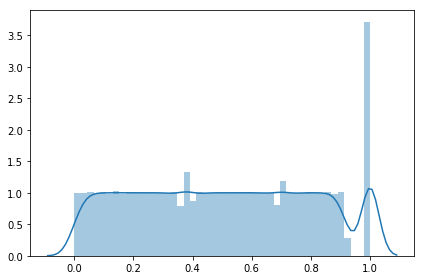

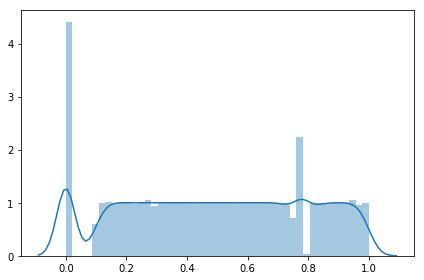

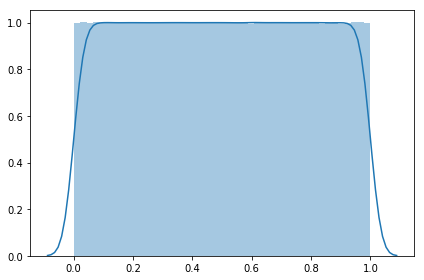

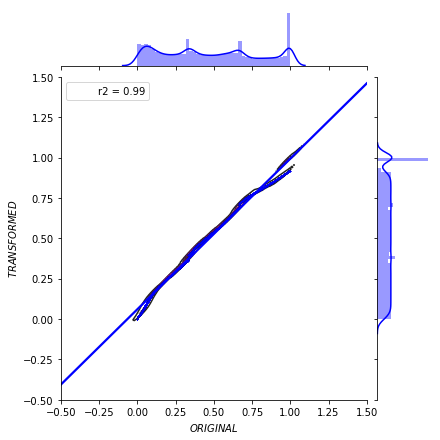

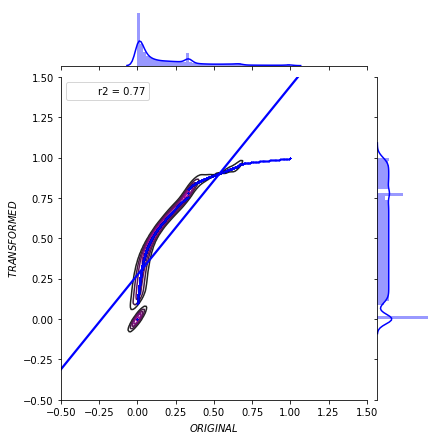

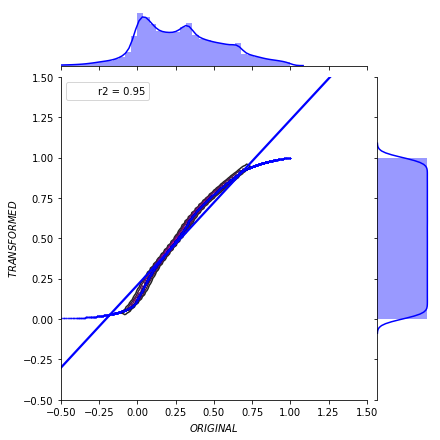

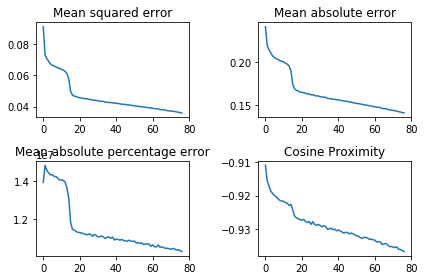

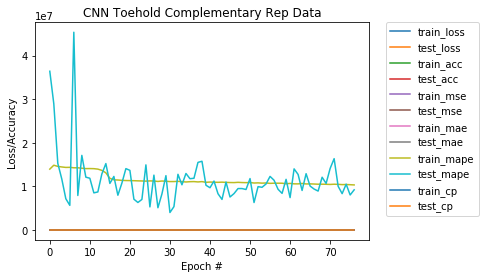

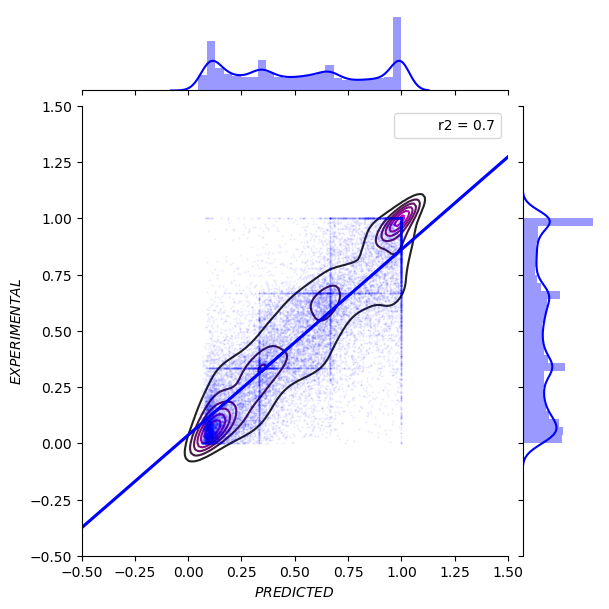

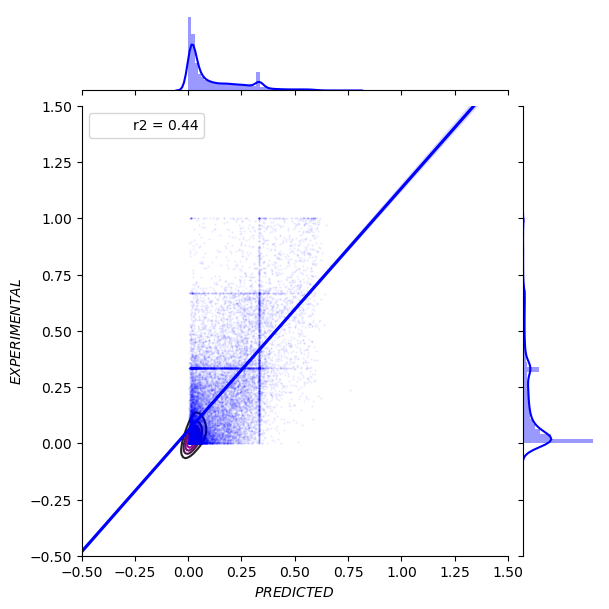

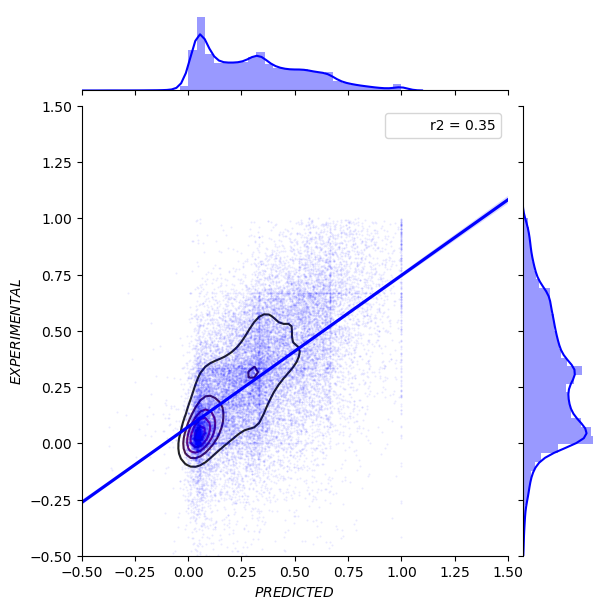

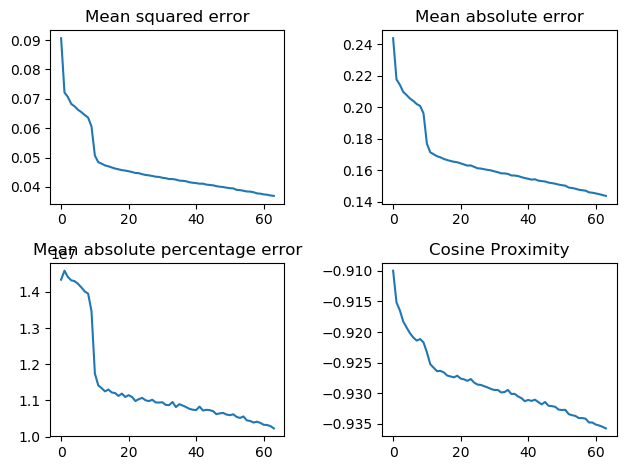

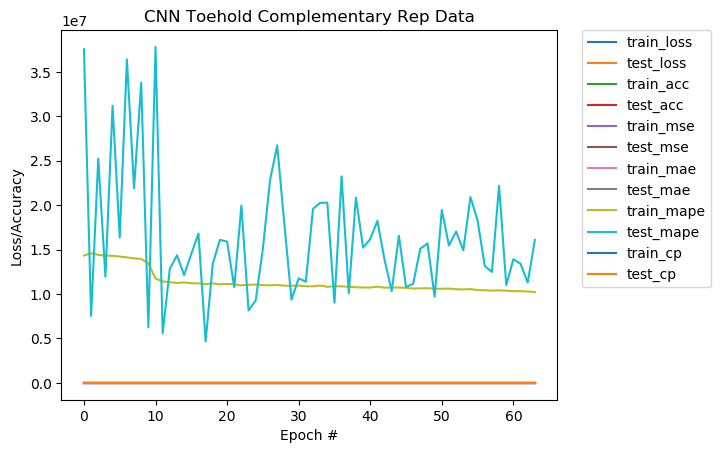

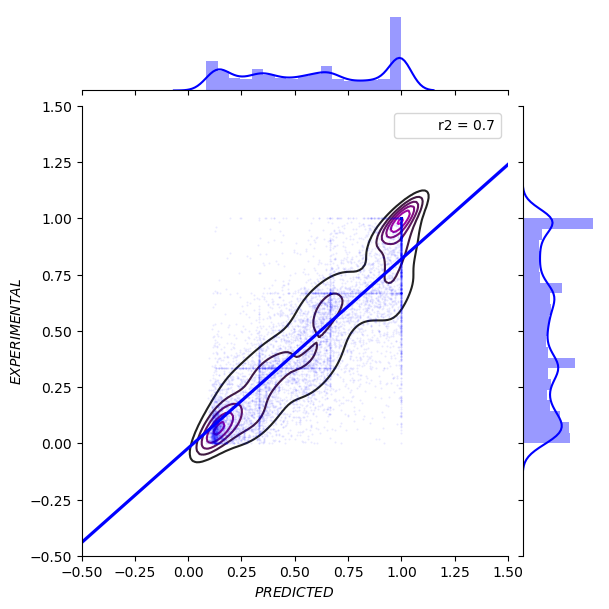

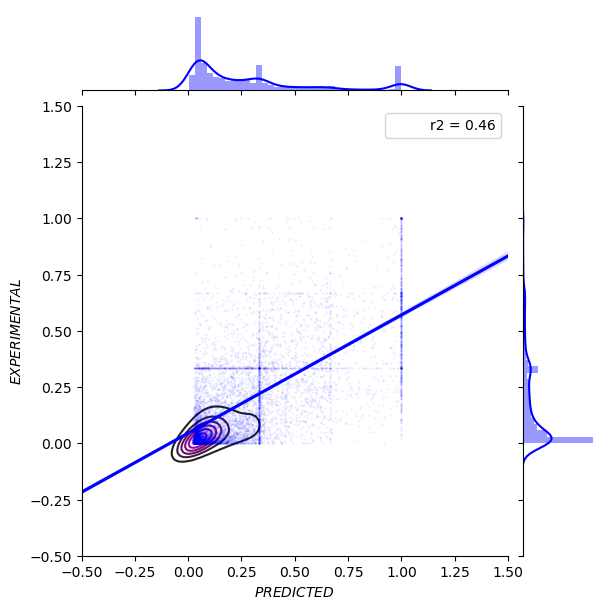

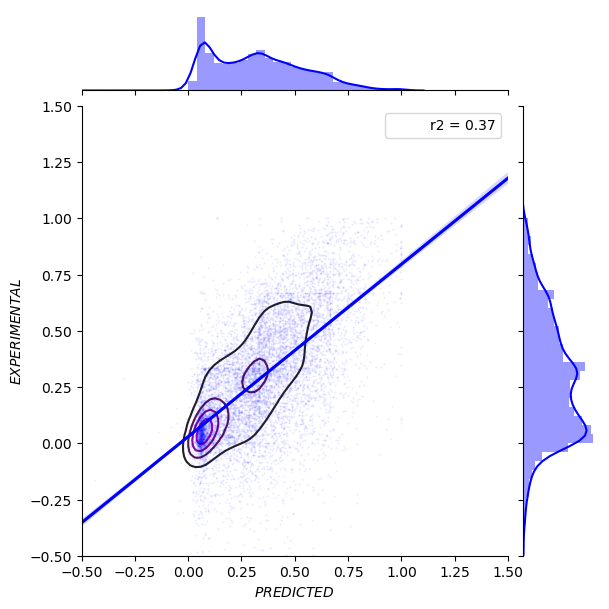

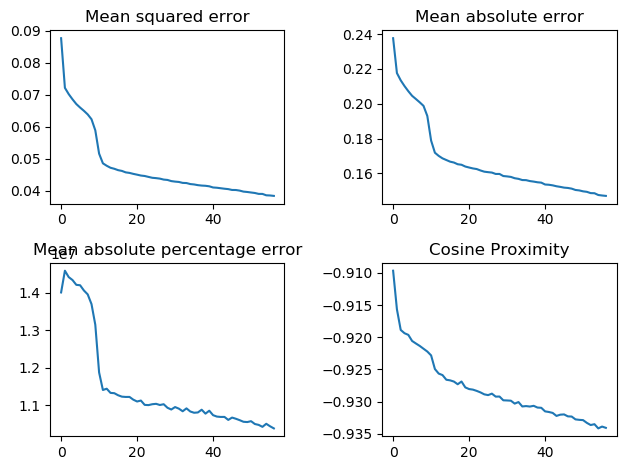

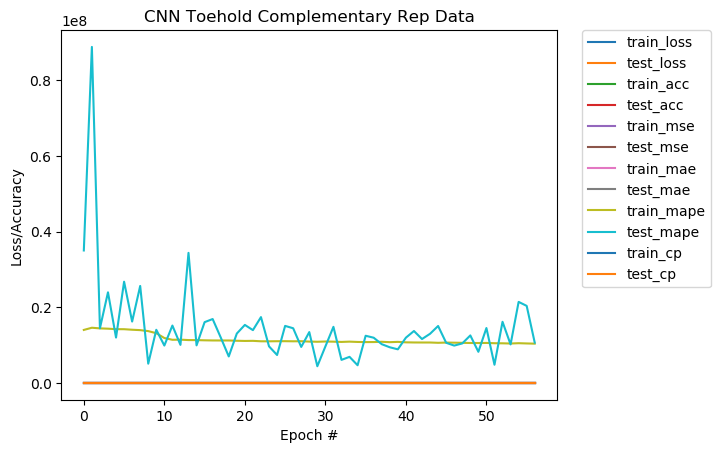

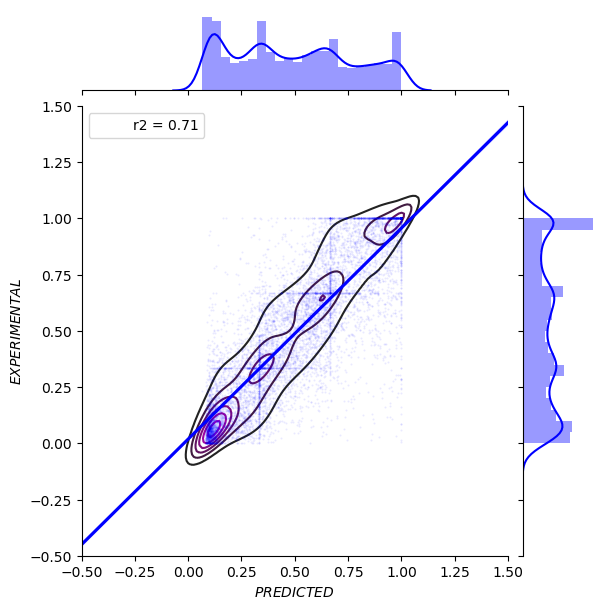

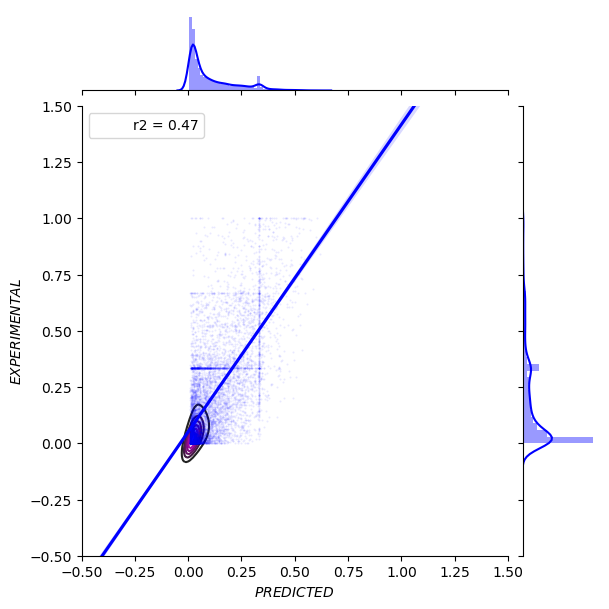

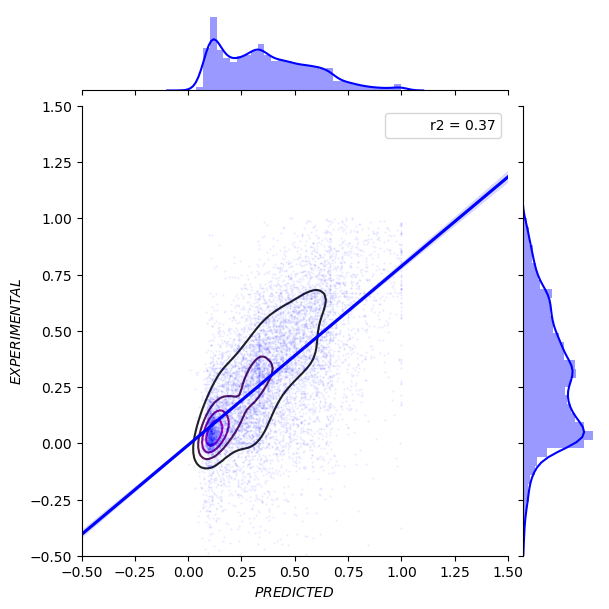

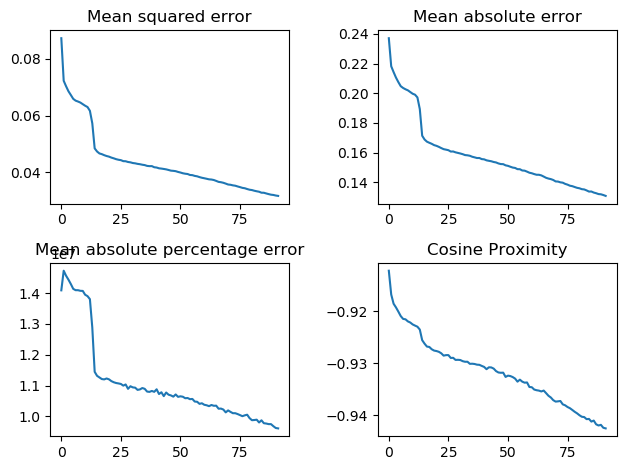

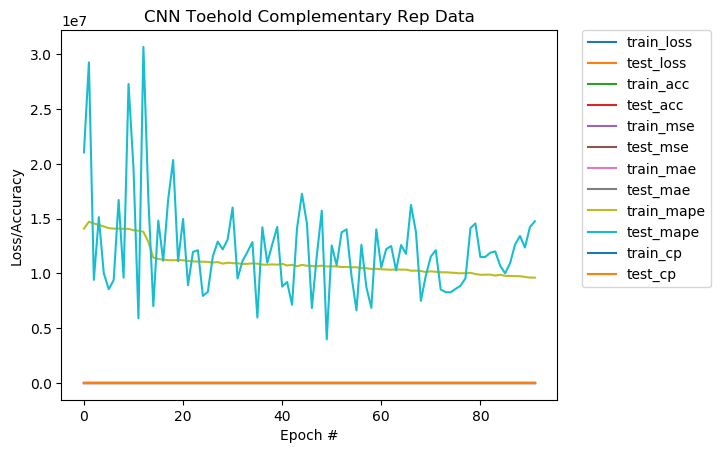

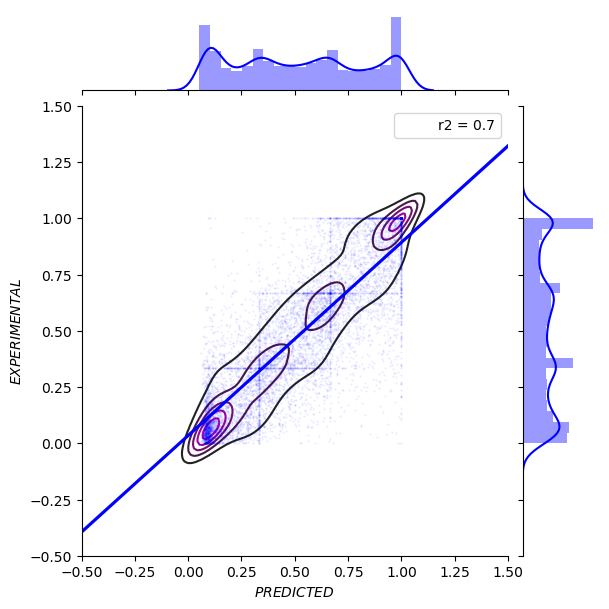

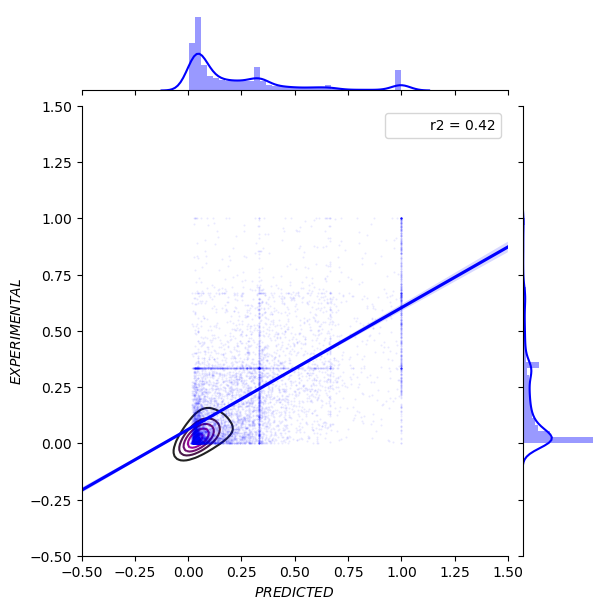

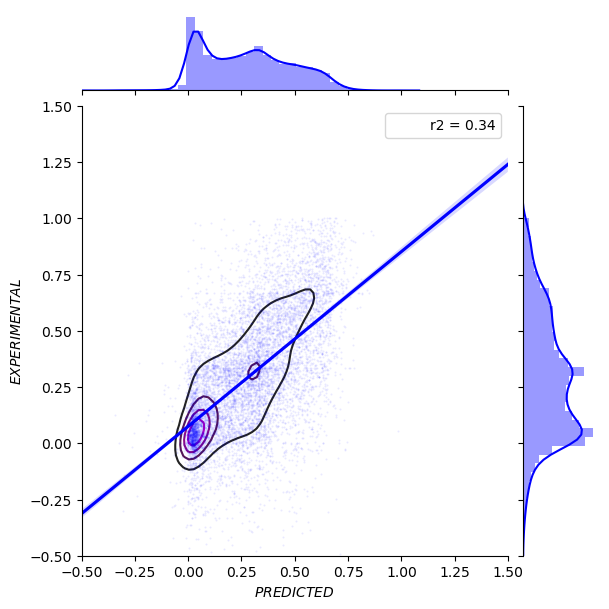

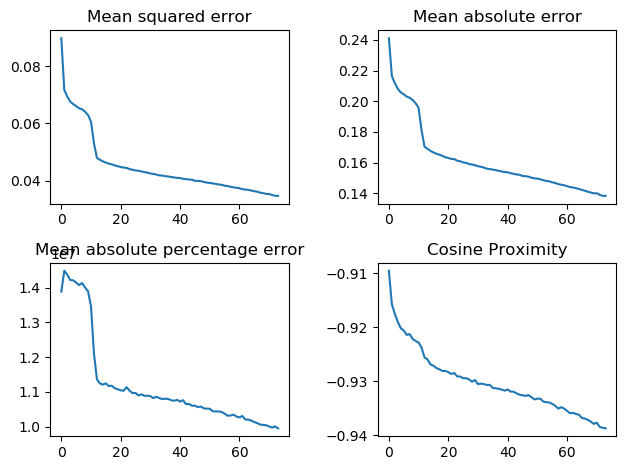

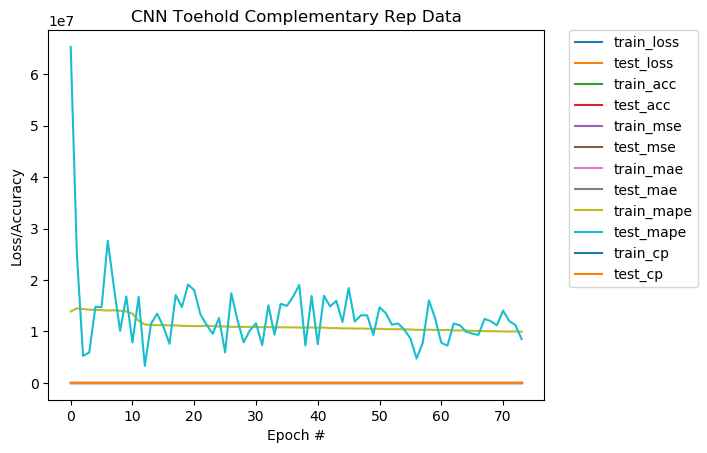

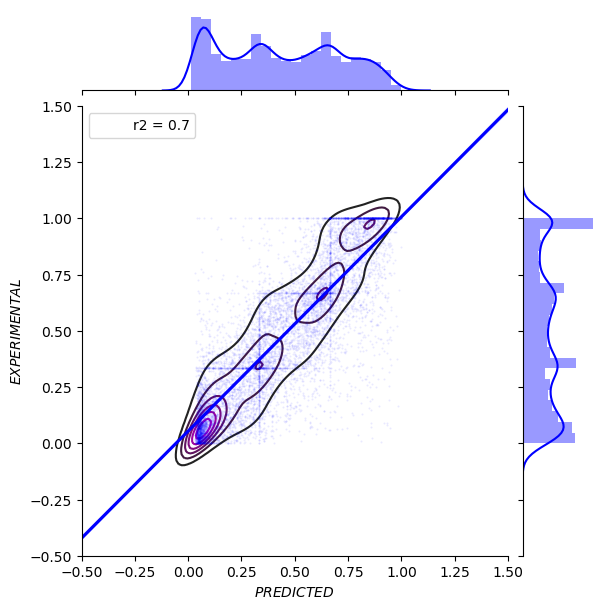

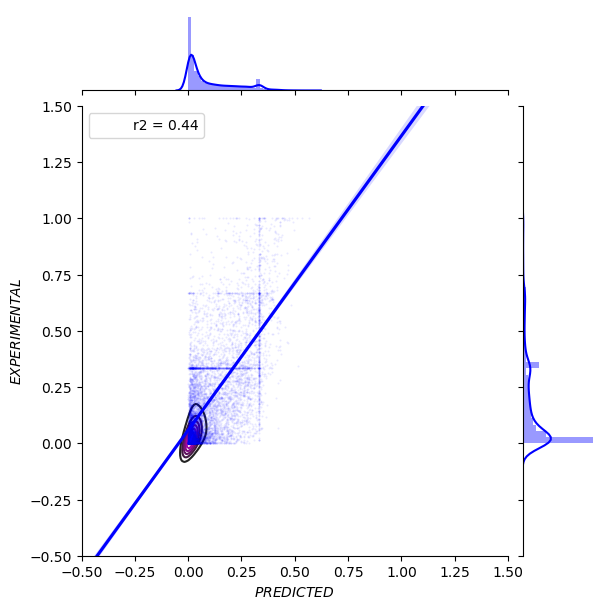

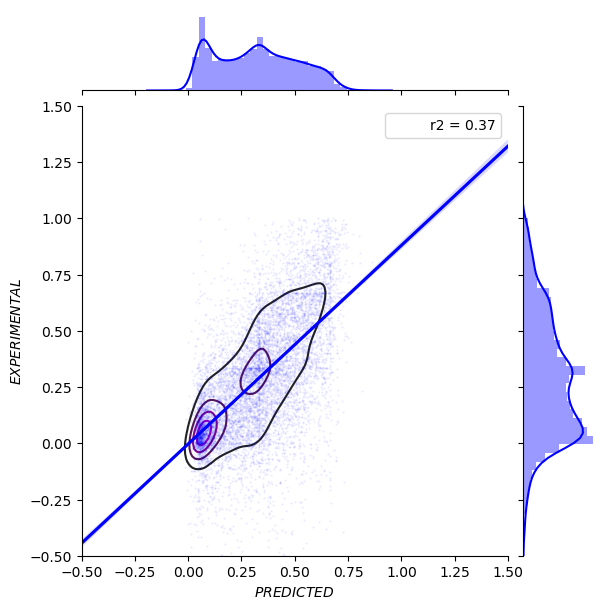

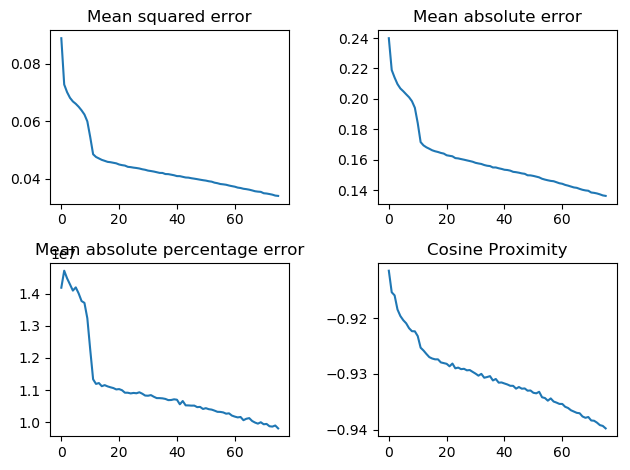

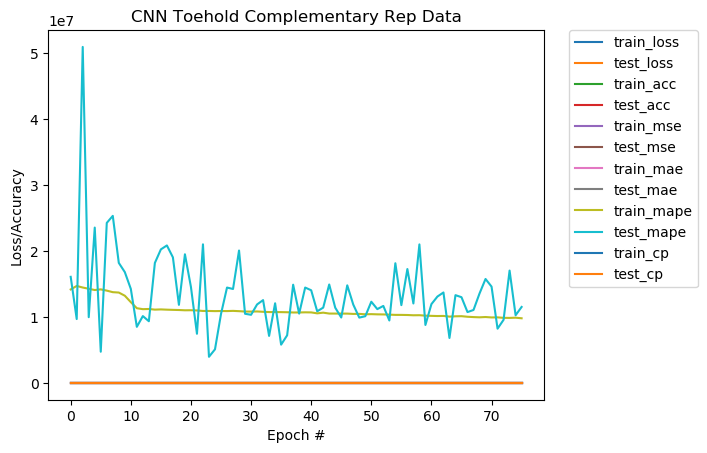

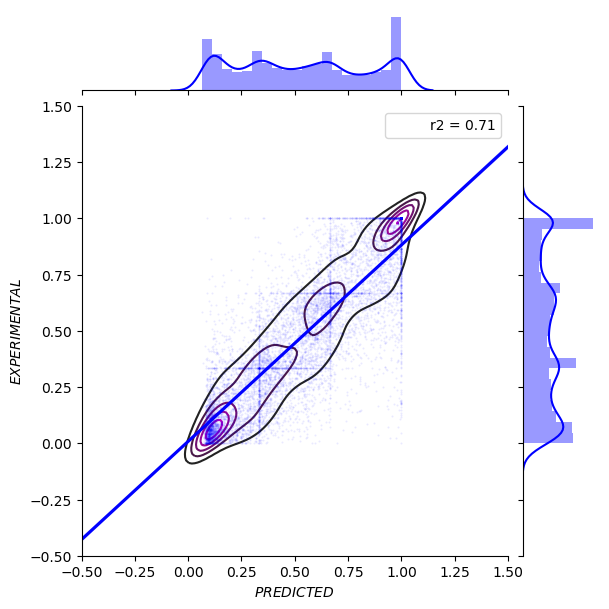

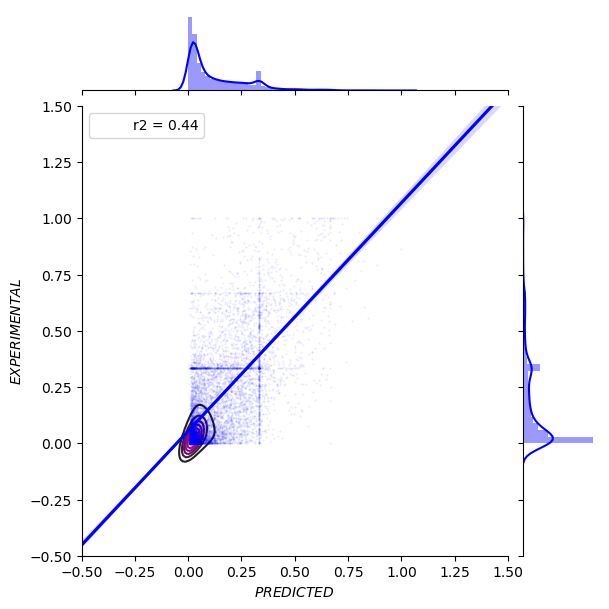

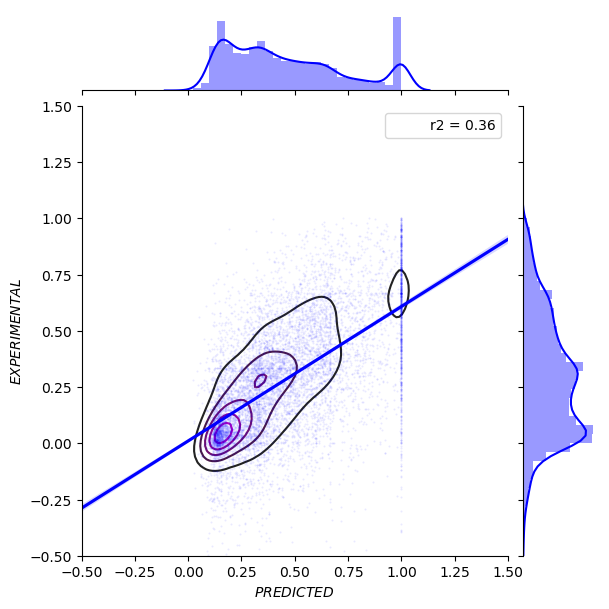

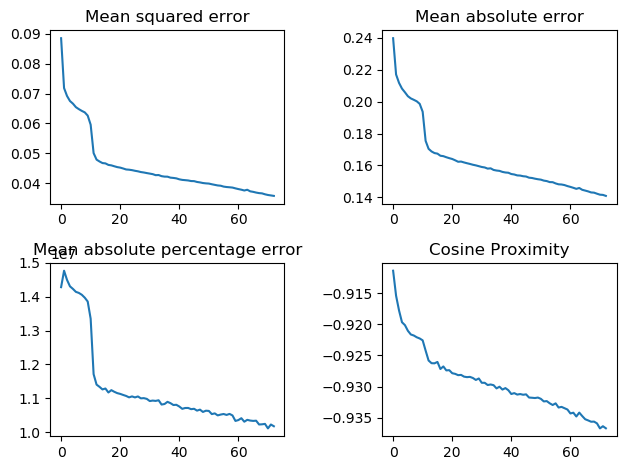

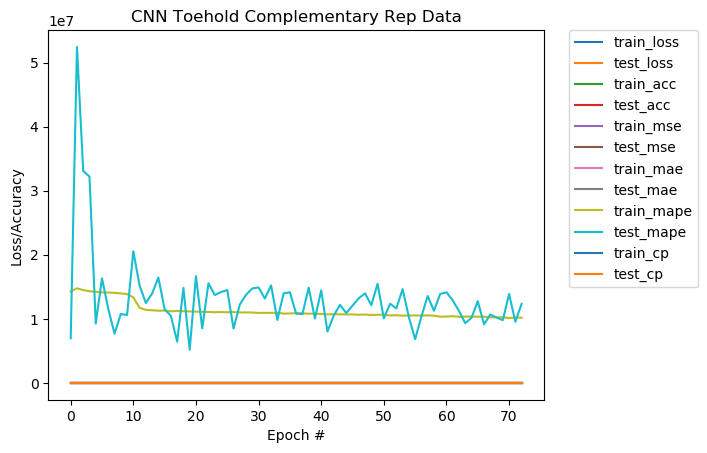

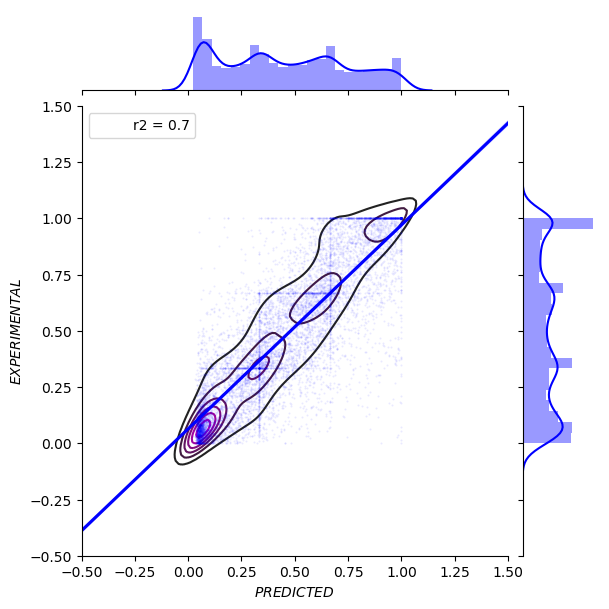

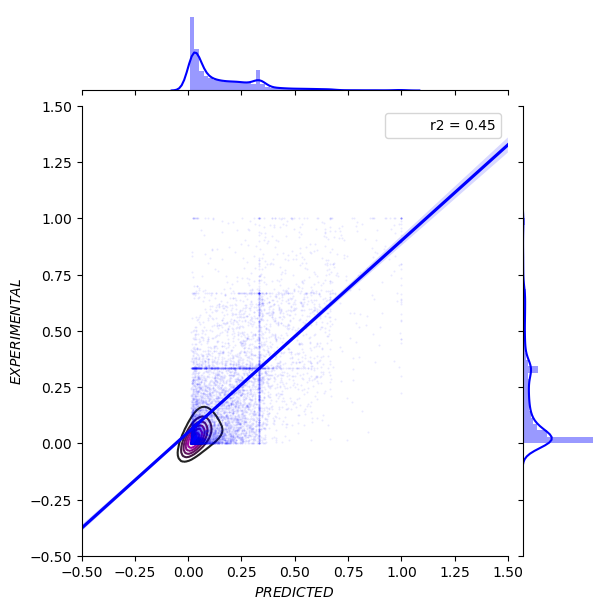

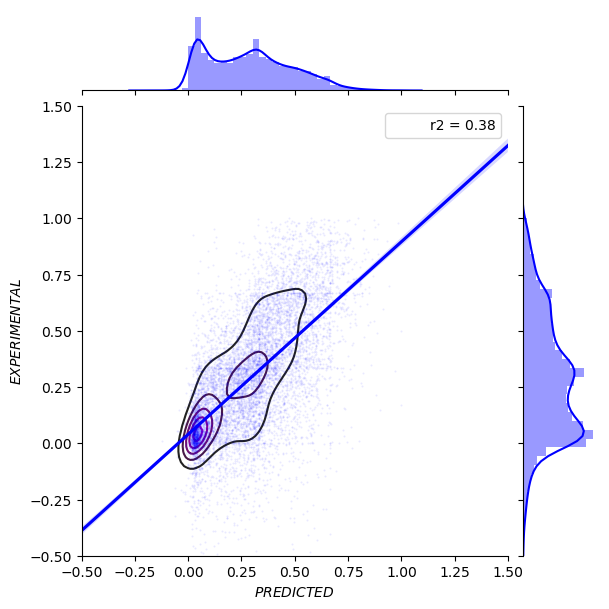

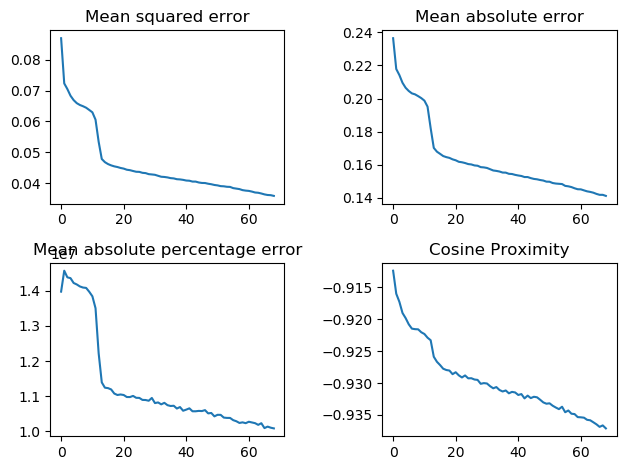

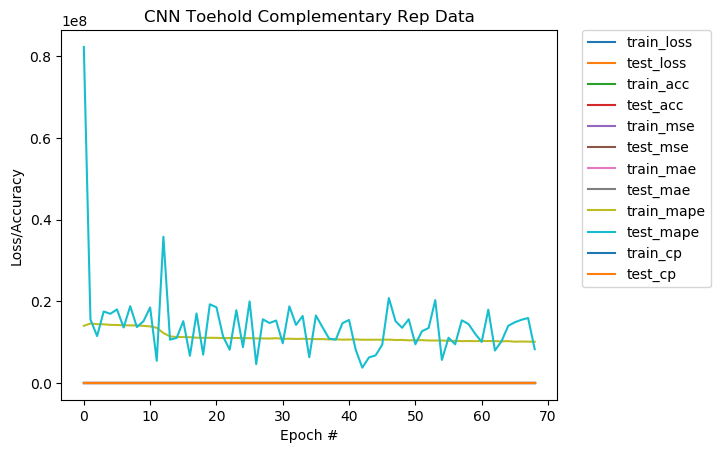

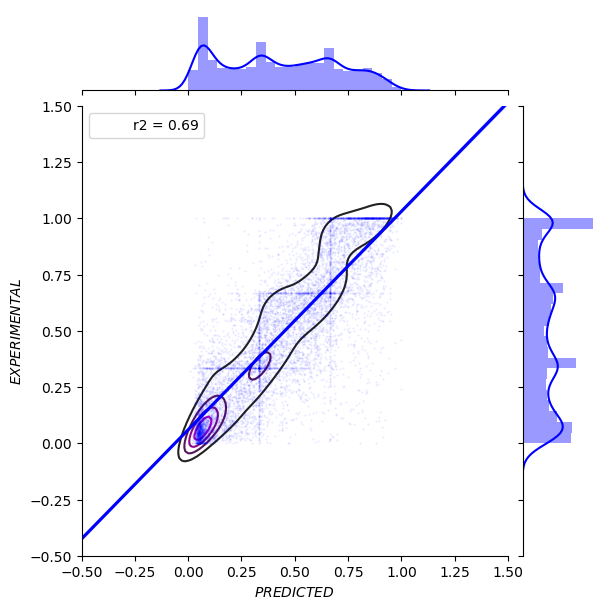

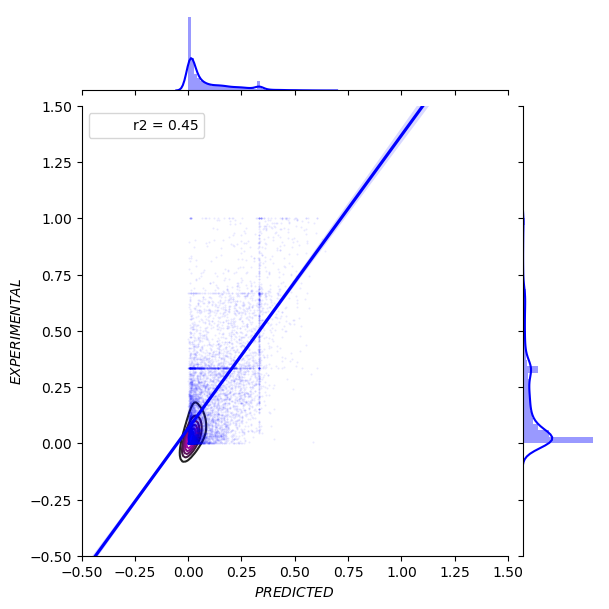

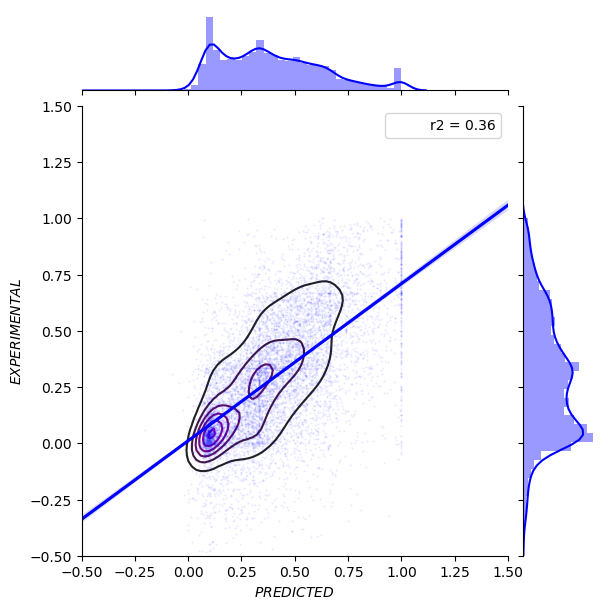

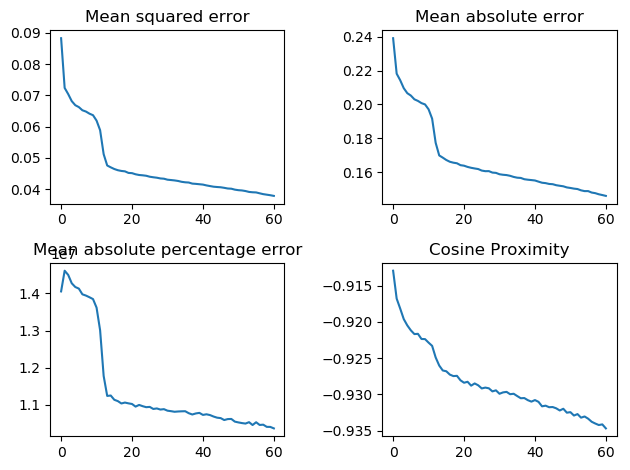

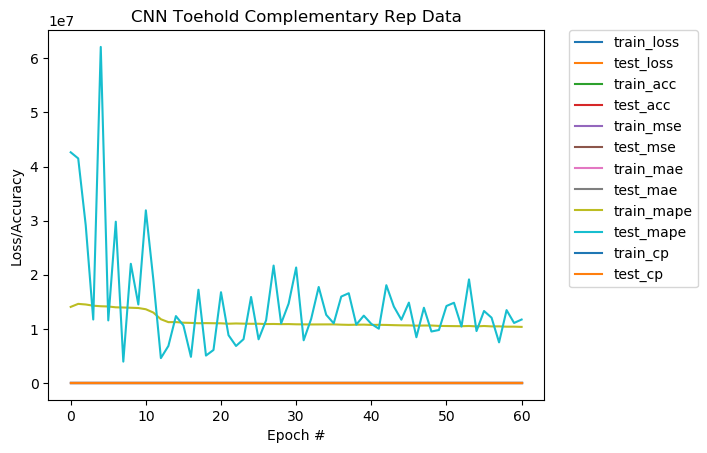

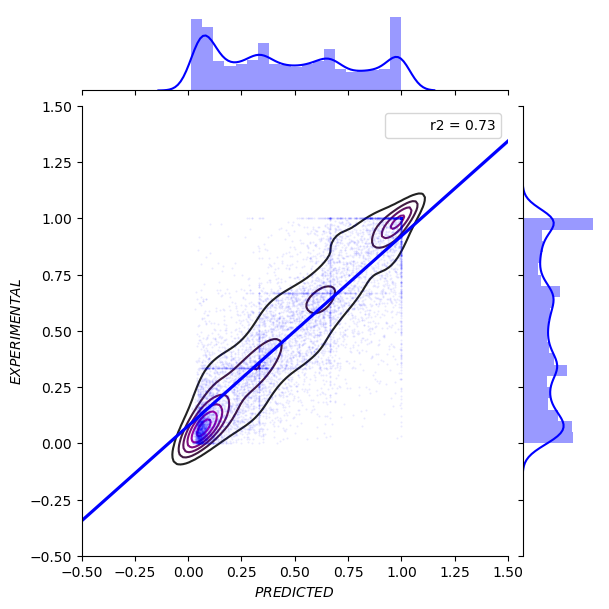

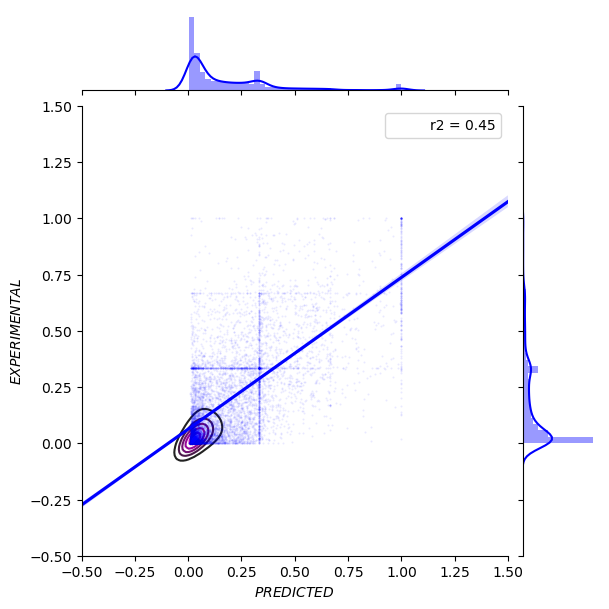

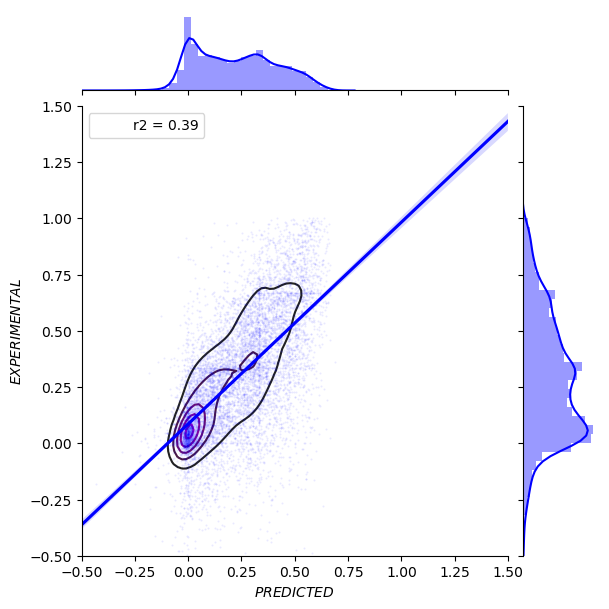

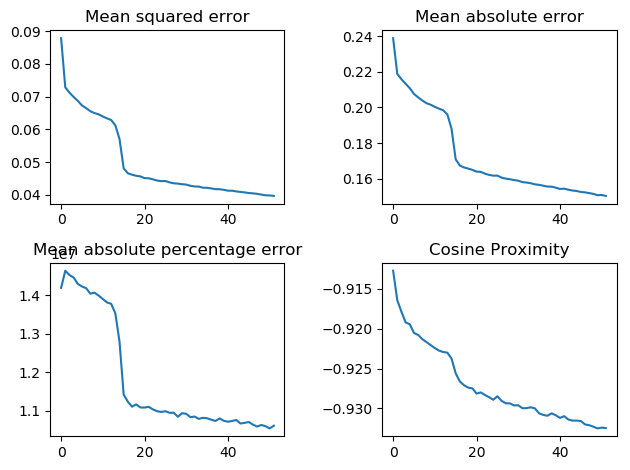

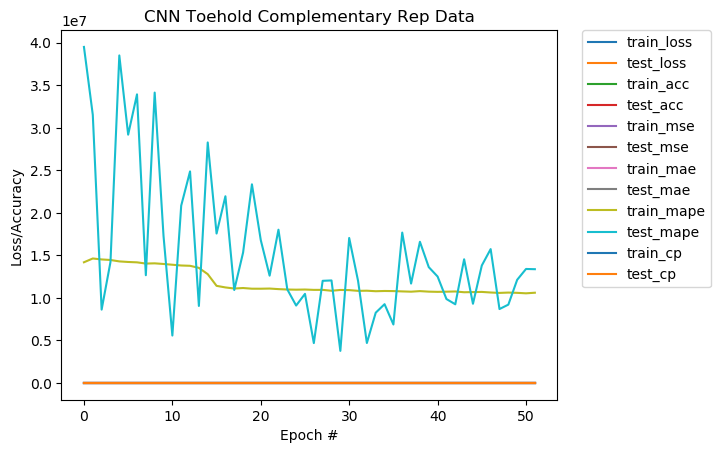

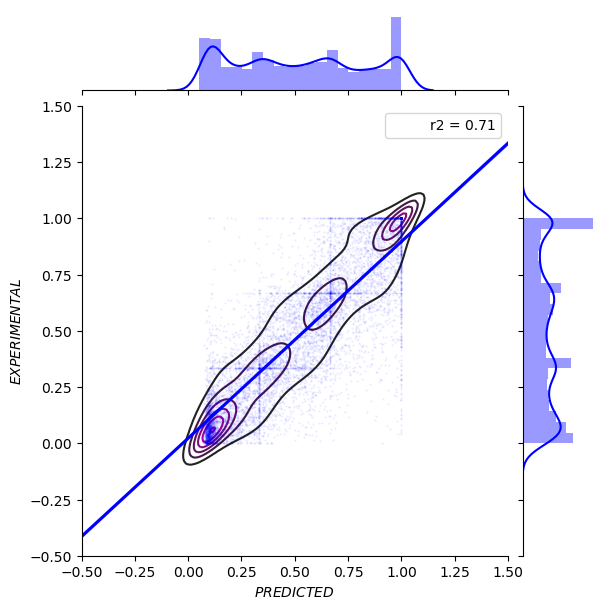

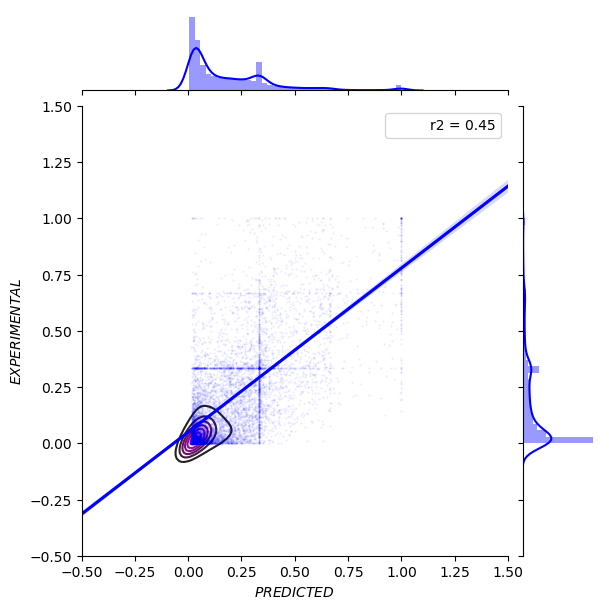

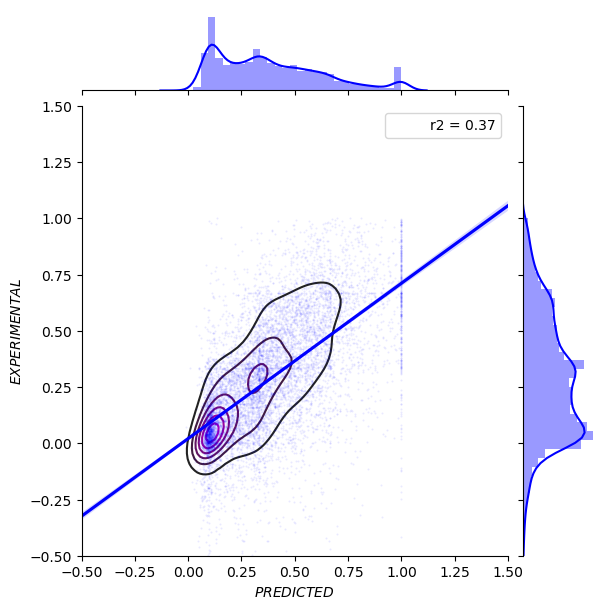

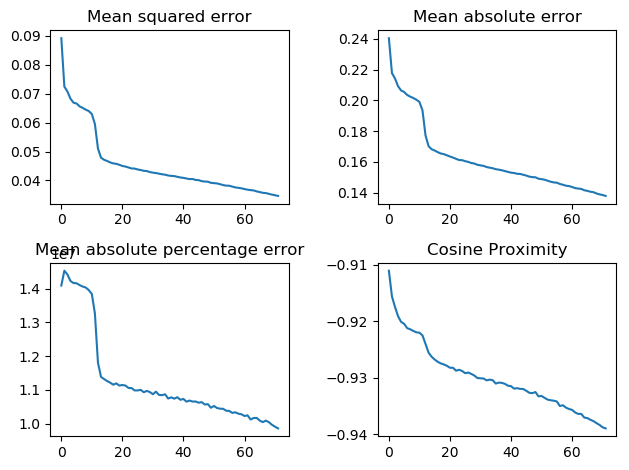

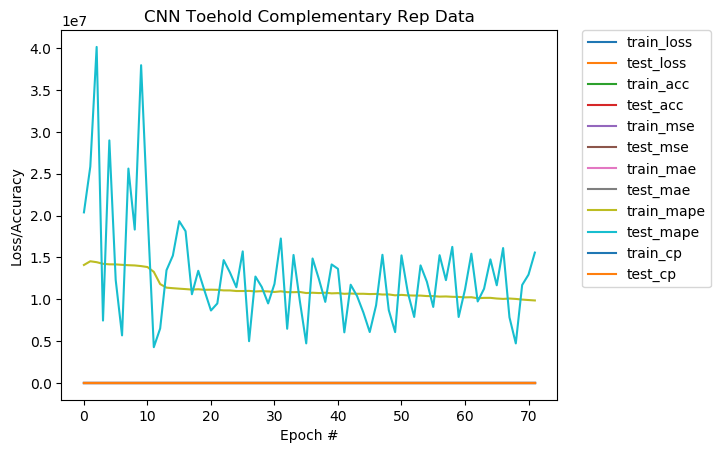

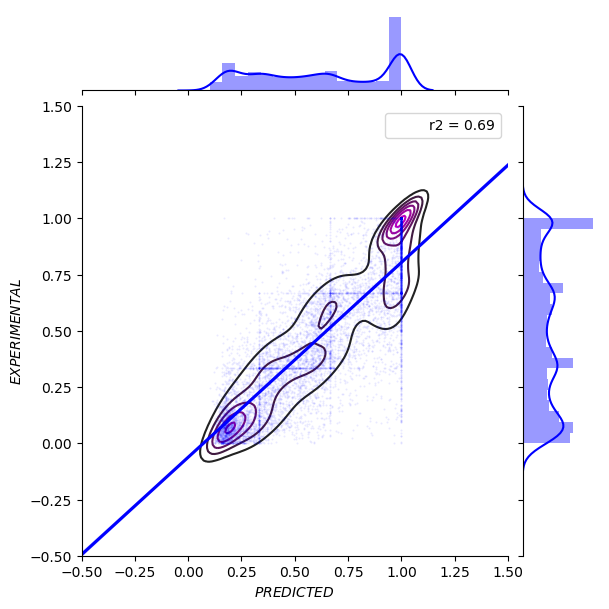

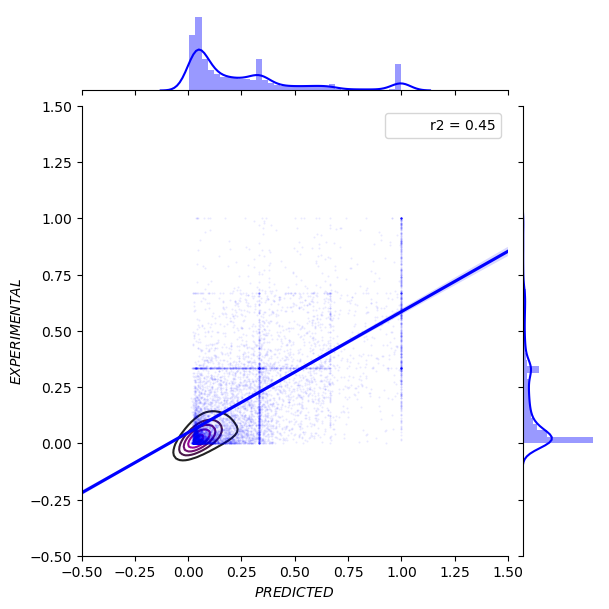

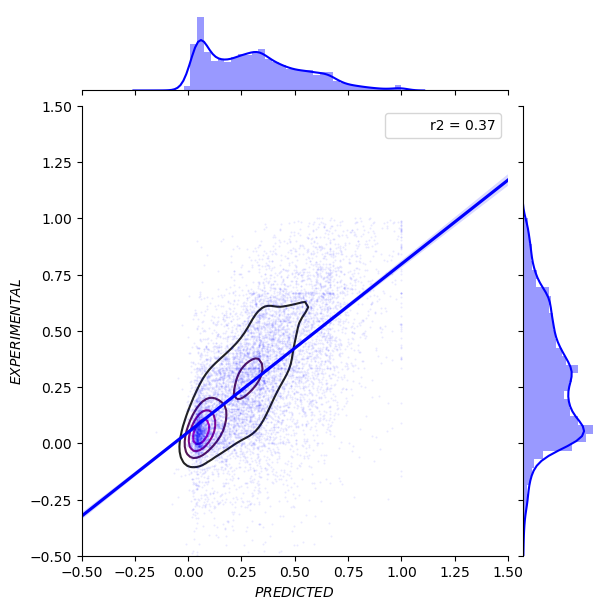

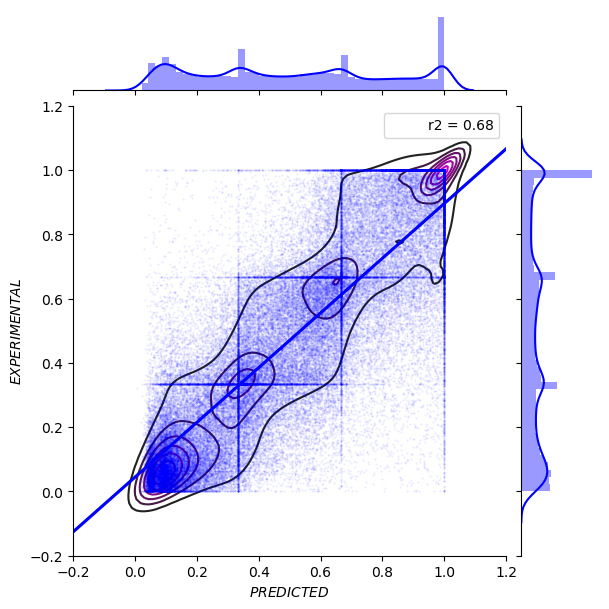

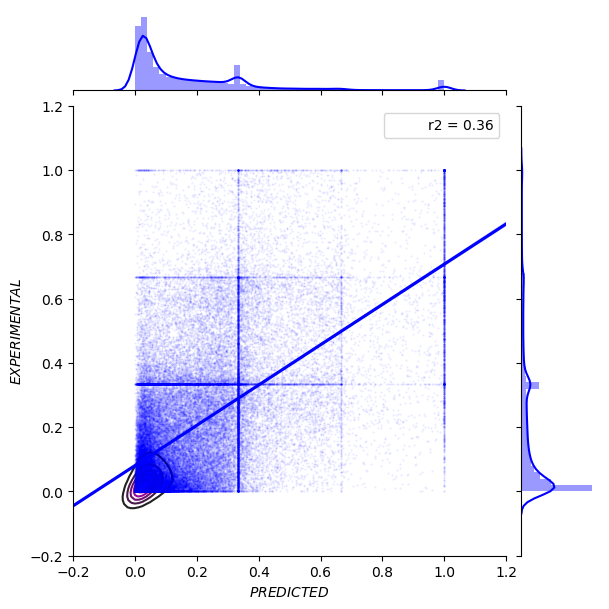

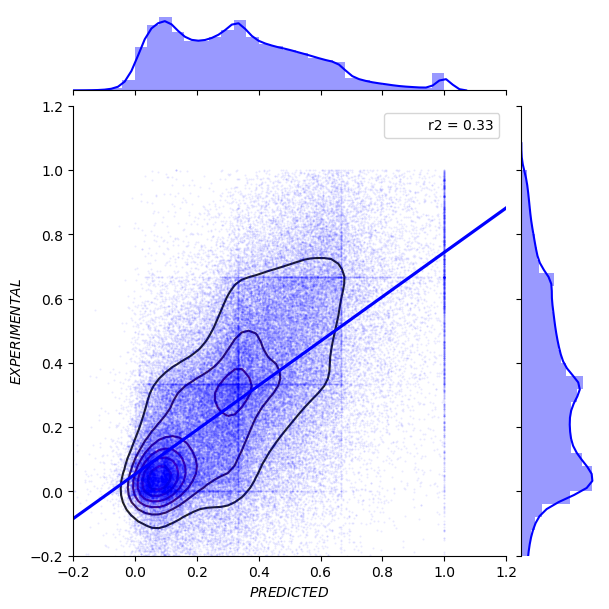

In [13]:
# RUN FULL MODEL ANALYSIS AND REPORTING model
execute_model_analysis(core_models_path, model_name, data, input_cols, output_cols, qc_levels, n_foldCV, verbose_init, evaluate)

-----------------------------------------------------------------------------------------------------------------------------

END OF CODE